In [27]:
import time

from torchvision import transforms, datasets
from torch.utils.data import DataLoader




import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image




from pushover import notify
from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display





In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [29]:
bs = 32

In [30]:
# Load Data
dataset = datasets.ImageFolder(root='./', transform=transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(), 
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
len(dataset.imgs), len(dataloader)





(402, 13)

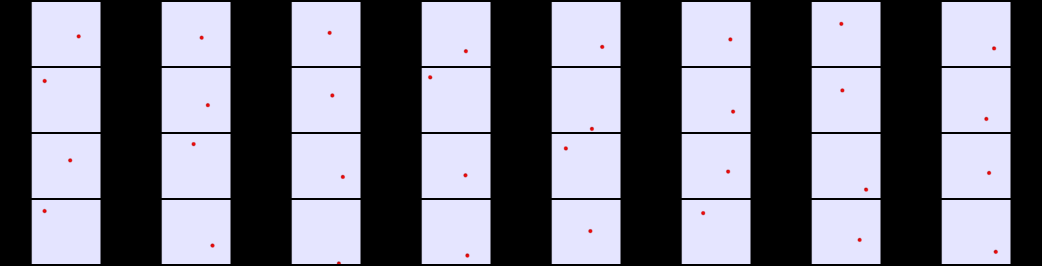

In [31]:
# Fixed input for debugging
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [32]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [33]:
class UnFlatten(nn.Module):
    def forward(self, input, size=3072):
        return input.view(input.size(0), size, 1, 1)

In [34]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=3072, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels,kernel_size=[6,70],padding=0,stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        
        
        z = mu + std * esp.cuda()
        
        
        return z
    
    def bottleneck(self, h):

        
        mu, logvar = self.fc1(h), self.fc2(h)
        
        
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        
        #print('ori')
        #print(x.shape)
        
        h = self.encoder(x)
        
        #print('encoder')
        #print(h.shape)
        
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        
        
        #print('Before fc3')
        #print(z.shape)
        
        z = self.fc3(z)
        #print('fc3')
        #print(z.shape)      
        
        
        
        z = self.decoder(z)
        #print('Decoder')
        #print(z.shape)
        
        
        
        
        
        return z

    def forward(self, x):

        z, mu, logvar = self.encode(x)
        
        
        z = self.decode(z)
        return z, mu, logvar

In [35]:
image_channels = fixed_x.size(1)

In [45]:
model = VAE(image_channels=image_channels).to(device)
model.load_state_dict(torch.load('vae.torch', map_location='cpu'))

<All keys matched successfully>

In [46]:
#optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3) 

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

In [47]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.cuda(), x.cuda(), size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [48]:
##!rm -rfr reconstructed
##!mkdir reconstructed

In [49]:
epochs = 5000

In [50]:

model.to(device)
print(device)

cuda


In [51]:
print(model)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (fc1): Linear(in_features=3072, out_features=32, bias=True)
  (fc2): Linear(in_features=3072, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3072, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(3072, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=[6, 70], stride=(2, 2))
    (8): Sigmoid()
  )
)


In [24]:
for epoch in range(epochs):
    for idx, (images, _) in enumerate(dataloader):
        
        #print(images.shape)
        recon_images, mu, logvar = model(images.to(device))
        
        
        #print(recon_images.shape)
        #print(images.shape)
        
        
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1,epochs, loss.data.item()/bs, bce.item()/bs, kld.item()/bs)
        print(to_print)

        
        
        #to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1,epochs, loss.data[0]/bs, bce.data[0]/bs, kld.data[0]/bs)
        #print(to_print)

# notify to android when finished training
#notify(to_print, priority=1)

torch.save(model.state_dict(), 'vae.torch')

Epoch[1/5000] Loss: 3210.012 3209.928 0.084
Epoch[1/5000] Loss: 3212.820 3212.737 0.083
Epoch[1/5000] Loss: 3210.226 3210.142 0.084
Epoch[1/5000] Loss: 3204.621 3204.536 0.084
Epoch[1/5000] Loss: 3215.928 3215.844 0.084
Epoch[1/5000] Loss: 3216.319 3216.233 0.085
Epoch[1/5000] Loss: 3209.821 3209.735 0.085
Epoch[1/5000] Loss: 3208.301 3208.216 0.085
Epoch[1/5000] Loss: 3208.012 3207.927 0.086
Epoch[1/5000] Loss: 3211.726 3211.641 0.085
Epoch[1/5000] Loss: 3200.732 3200.646 0.086
Epoch[1/5000] Loss: 3206.006 3205.919 0.087
Epoch[1/5000] Loss: 1801.455 1801.368 0.087
Epoch[2/5000] Loss: 3204.635 3204.548 0.087
Epoch[2/5000] Loss: 3203.282 3203.195 0.087
Epoch[2/5000] Loss: 3207.931 3207.844 0.087
Epoch[2/5000] Loss: 3216.292 3216.205 0.087
Epoch[2/5000] Loss: 3202.575 3202.487 0.088
Epoch[2/5000] Loss: 3211.119 3211.031 0.088
Epoch[2/5000] Loss: 3210.997 3210.910 0.088
Epoch[2/5000] Loss: 3219.072 3218.984 0.088
Epoch[2/5000] Loss: 3212.564 3212.477 0.087
Epoch[2/5000] Loss: 3206.840 320

Epoch[15/5000] Loss: 3208.751 3208.671 0.080
Epoch[15/5000] Loss: 3215.609 3215.527 0.082
Epoch[15/5000] Loss: 3212.842 3212.762 0.080
Epoch[15/5000] Loss: 3209.855 3209.774 0.081
Epoch[15/5000] Loss: 3213.102 3213.020 0.082
Epoch[15/5000] Loss: 3210.422 3210.341 0.081
Epoch[15/5000] Loss: 3208.090 3208.009 0.082
Epoch[15/5000] Loss: 3214.247 3214.165 0.082
Epoch[15/5000] Loss: 3204.894 3204.812 0.081
Epoch[15/5000] Loss: 1808.901 1808.819 0.082
Epoch[16/5000] Loss: 3208.699 3208.617 0.082
Epoch[16/5000] Loss: 3214.371 3214.290 0.081
Epoch[16/5000] Loss: 3210.650 3210.567 0.082
Epoch[16/5000] Loss: 3205.424 3205.342 0.082
Epoch[16/5000] Loss: 3207.485 3207.402 0.082
Epoch[16/5000] Loss: 3213.681 3213.597 0.084
Epoch[16/5000] Loss: 3209.639 3209.557 0.083
Epoch[16/5000] Loss: 3210.916 3210.831 0.085
Epoch[16/5000] Loss: 3208.069 3207.986 0.084
Epoch[16/5000] Loss: 3215.619 3215.535 0.084
Epoch[16/5000] Loss: 3206.895 3206.811 0.084
Epoch[16/5000] Loss: 3201.357 3201.273 0.084
Epoch[16/5

Epoch[29/5000] Loss: 3204.324 3204.241 0.083
Epoch[29/5000] Loss: 3207.914 3207.831 0.083
Epoch[29/5000] Loss: 3213.745 3213.661 0.084
Epoch[29/5000] Loss: 3214.300 3214.216 0.084
Epoch[29/5000] Loss: 3205.451 3205.366 0.084
Epoch[29/5000] Loss: 3200.757 3200.672 0.085
Epoch[29/5000] Loss: 3204.668 3204.583 0.084
Epoch[29/5000] Loss: 1810.113 1810.027 0.086
Epoch[30/5000] Loss: 3200.742 3200.656 0.086
Epoch[30/5000] Loss: 3225.799 3225.714 0.085
Epoch[30/5000] Loss: 3227.337 3227.251 0.087
Epoch[30/5000] Loss: 3210.664 3210.580 0.084
Epoch[30/5000] Loss: 3207.830 3207.747 0.083
Epoch[30/5000] Loss: 3217.327 3217.243 0.084
Epoch[30/5000] Loss: 3218.939 3218.857 0.081
Epoch[30/5000] Loss: 3211.215 3211.133 0.083
Epoch[30/5000] Loss: 3212.266 3212.184 0.082
Epoch[30/5000] Loss: 3212.584 3212.503 0.081
Epoch[30/5000] Loss: 3209.502 3209.419 0.083
Epoch[30/5000] Loss: 3213.952 3213.871 0.081
Epoch[30/5000] Loss: 1805.345 1805.265 0.081
Epoch[31/5000] Loss: 3215.965 3215.884 0.081
Epoch[31/5

Epoch[43/5000] Loss: 3222.600 3222.521 0.078
Epoch[43/5000] Loss: 3205.386 3205.307 0.079
Epoch[43/5000] Loss: 3214.443 3214.366 0.077
Epoch[43/5000] Loss: 3222.531 3222.453 0.077
Epoch[43/5000] Loss: 3214.318 3214.240 0.078
Epoch[43/5000] Loss: 3221.370 3221.294 0.076
Epoch[43/5000] Loss: 1800.072 1799.995 0.078
Epoch[44/5000] Loss: 3218.350 3218.272 0.078
Epoch[44/5000] Loss: 3211.516 3211.439 0.076
Epoch[44/5000] Loss: 3208.195 3208.117 0.077
Epoch[44/5000] Loss: 3222.417 3222.340 0.078
Epoch[44/5000] Loss: 3210.534 3210.458 0.076
Epoch[44/5000] Loss: 3210.768 3210.690 0.077
Epoch[44/5000] Loss: 3223.224 3223.147 0.077
Epoch[44/5000] Loss: 3209.363 3209.287 0.076
Epoch[44/5000] Loss: 3211.097 3211.020 0.078
Epoch[44/5000] Loss: 3218.982 3218.905 0.077
Epoch[44/5000] Loss: 3202.621 3202.543 0.078
Epoch[44/5000] Loss: 3217.714 3217.634 0.079
Epoch[44/5000] Loss: 1805.432 1805.354 0.078
Epoch[45/5000] Loss: 3211.780 3211.702 0.078
Epoch[45/5000] Loss: 3229.564 3229.484 0.081
Epoch[45/5

Epoch[57/5000] Loss: 3213.977 3213.894 0.083
Epoch[57/5000] Loss: 3219.557 3219.474 0.084
Epoch[57/5000] Loss: 3210.017 3209.934 0.083
Epoch[57/5000] Loss: 3201.032 3200.949 0.083
Epoch[57/5000] Loss: 3215.906 3215.824 0.082
Epoch[57/5000] Loss: 1804.606 1804.524 0.082
Epoch[58/5000] Loss: 3205.346 3205.264 0.082
Epoch[58/5000] Loss: 3205.032 3204.950 0.082
Epoch[58/5000] Loss: 3216.226 3216.144 0.082
Epoch[58/5000] Loss: 3207.010 3206.929 0.082
Epoch[58/5000] Loss: 3215.024 3214.942 0.081
Epoch[58/5000] Loss: 3209.668 3209.587 0.081
Epoch[58/5000] Loss: 3205.791 3205.710 0.081
Epoch[58/5000] Loss: 3217.595 3217.515 0.080
Epoch[58/5000] Loss: 3210.500 3210.419 0.081
Epoch[58/5000] Loss: 3205.062 3204.982 0.080
Epoch[58/5000] Loss: 3211.042 3210.961 0.081
Epoch[58/5000] Loss: 3213.170 3213.089 0.081
Epoch[58/5000] Loss: 1803.628 1803.547 0.081
Epoch[59/5000] Loss: 3215.447 3215.367 0.081
Epoch[59/5000] Loss: 3214.442 3214.361 0.081
Epoch[59/5000] Loss: 3199.211 3199.130 0.081
Epoch[59/5

Epoch[85/5000] Loss: 3211.657 3211.581 0.077
Epoch[85/5000] Loss: 3194.533 3194.456 0.077
Epoch[85/5000] Loss: 1808.325 1808.247 0.079
Epoch[86/5000] Loss: 3215.363 3215.284 0.079
Epoch[86/5000] Loss: 3213.177 3213.100 0.077
Epoch[86/5000] Loss: 3211.533 3211.453 0.080
Epoch[86/5000] Loss: 3209.830 3209.752 0.078
Epoch[86/5000] Loss: 3215.832 3215.755 0.077
Epoch[86/5000] Loss: 3212.015 3211.936 0.079
Epoch[86/5000] Loss: 3210.956 3210.879 0.077
Epoch[86/5000] Loss: 3211.780 3211.704 0.076
Epoch[86/5000] Loss: 3201.405 3201.327 0.078
Epoch[86/5000] Loss: 3200.027 3199.950 0.077
Epoch[86/5000] Loss: 3208.611 3208.535 0.077
Epoch[86/5000] Loss: 3218.262 3218.184 0.079
Epoch[86/5000] Loss: 1808.485 1808.408 0.077
Epoch[87/5000] Loss: 3210.207 3210.131 0.076
Epoch[87/5000] Loss: 3223.040 3222.961 0.079
Epoch[87/5000] Loss: 3209.720 3209.644 0.076
Epoch[87/5000] Loss: 3201.583 3201.507 0.077
Epoch[87/5000] Loss: 3214.625 3214.546 0.079
Epoch[87/5000] Loss: 3212.145 3212.068 0.076
Epoch[87/5

Epoch[100/5000] Loss: 3222.139 3222.061 0.078
Epoch[100/5000] Loss: 3212.017 3211.940 0.078
Epoch[100/5000] Loss: 3205.879 3205.802 0.078
Epoch[100/5000] Loss: 3211.379 3211.300 0.079
Epoch[100/5000] Loss: 3208.137 3208.059 0.078
Epoch[100/5000] Loss: 3207.768 3207.689 0.079
Epoch[100/5000] Loss: 3205.345 3205.266 0.080
Epoch[100/5000] Loss: 3206.147 3206.068 0.079
Epoch[100/5000] Loss: 3210.730 3210.650 0.080
Epoch[100/5000] Loss: 3205.668 3205.588 0.080
Epoch[100/5000] Loss: 3203.258 3203.178 0.080
Epoch[100/5000] Loss: 1801.487 1801.406 0.081
Epoch[101/5000] Loss: 3210.665 3210.584 0.081
Epoch[101/5000] Loss: 3211.500 3211.420 0.080
Epoch[101/5000] Loss: 3214.802 3214.720 0.082
Epoch[101/5000] Loss: 3202.465 3202.385 0.080
Epoch[101/5000] Loss: 3208.760 3208.679 0.081
Epoch[101/5000] Loss: 3220.944 3220.862 0.082
Epoch[101/5000] Loss: 3216.062 3215.982 0.080
Epoch[101/5000] Loss: 3210.257 3210.177 0.080
Epoch[101/5000] Loss: 3207.737 3207.657 0.080
Epoch[101/5000] Loss: 3207.893 320

Epoch[114/5000] Loss: 3213.656 3213.571 0.085
Epoch[114/5000] Loss: 3207.652 3207.567 0.085
Epoch[114/5000] Loss: 3205.376 3205.292 0.085
Epoch[114/5000] Loss: 3202.184 3202.100 0.085
Epoch[114/5000] Loss: 3201.261 3201.175 0.086
Epoch[114/5000] Loss: 3199.222 3199.136 0.085
Epoch[114/5000] Loss: 3206.802 3206.716 0.086
Epoch[114/5000] Loss: 3211.157 3211.072 0.086
Epoch[114/5000] Loss: 3216.926 3216.841 0.085
Epoch[114/5000] Loss: 3213.382 3213.297 0.085
Epoch[114/5000] Loss: 3210.241 3210.165 0.077
Epoch[114/5000] Loss: 3225.229 3225.142 0.087
Epoch[114/5000] Loss: 1815.437 1815.354 0.083
Epoch[115/5000] Loss: 3221.557 3221.475 0.082
Epoch[115/5000] Loss: 3284.005 3283.917 0.087
Epoch[115/5000] Loss: 3223.248 3223.169 0.078
Epoch[115/5000] Loss: 3221.488 3221.412 0.076
Epoch[115/5000] Loss: 3236.836 3236.758 0.078
Epoch[115/5000] Loss: 3212.522 3212.449 0.073
Epoch[115/5000] Loss: 3235.155 3235.085 0.070
Epoch[115/5000] Loss: 3204.843 3204.773 0.071
Epoch[115/5000] Loss: 3226.951 322

Epoch[128/5000] Loss: 3200.997 3200.911 0.086
Epoch[128/5000] Loss: 3220.686 3220.601 0.085
Epoch[128/5000] Loss: 3219.296 3219.211 0.085
Epoch[128/5000] Loss: 3207.744 3207.659 0.085
Epoch[128/5000] Loss: 3212.504 3212.420 0.084
Epoch[128/5000] Loss: 3200.682 3200.598 0.084
Epoch[128/5000] Loss: 3212.414 3212.329 0.085
Epoch[128/5000] Loss: 3197.422 3197.338 0.084
Epoch[128/5000] Loss: 3217.666 3217.581 0.084
Epoch[128/5000] Loss: 3213.969 3213.884 0.085
Epoch[128/5000] Loss: 3218.305 3218.222 0.084
Epoch[128/5000] Loss: 3205.831 3205.747 0.083
Epoch[128/5000] Loss: 1809.429 1809.344 0.084
Epoch[129/5000] Loss: 3209.258 3209.174 0.084
Epoch[129/5000] Loss: 3221.634 3221.551 0.082
Epoch[129/5000] Loss: 3205.066 3204.983 0.083
Epoch[129/5000] Loss: 3209.811 3209.727 0.084
Epoch[129/5000] Loss: 3210.116 3210.033 0.082
Epoch[129/5000] Loss: 3204.323 3204.240 0.083
Epoch[129/5000] Loss: 3207.273 3207.189 0.083
Epoch[129/5000] Loss: 3207.079 3206.997 0.082
Epoch[129/5000] Loss: 3211.953 321

Epoch[142/5000] Loss: 3209.414 3209.330 0.084
Epoch[142/5000] Loss: 3207.994 3207.909 0.085
Epoch[142/5000] Loss: 3203.785 3203.701 0.084
Epoch[142/5000] Loss: 3220.074 3219.990 0.083
Epoch[142/5000] Loss: 3215.585 3215.501 0.083
Epoch[142/5000] Loss: 3210.075 3209.991 0.083
Epoch[142/5000] Loss: 3213.535 3213.452 0.083
Epoch[142/5000] Loss: 3211.437 3211.354 0.083
Epoch[142/5000] Loss: 3208.829 3208.746 0.083
Epoch[142/5000] Loss: 3220.904 3220.822 0.083
Epoch[142/5000] Loss: 3214.176 3214.093 0.083
Epoch[142/5000] Loss: 3209.660 3209.577 0.083
Epoch[142/5000] Loss: 1810.133 1810.051 0.082
Epoch[143/5000] Loss: 3211.424 3211.342 0.082
Epoch[143/5000] Loss: 3221.183 3221.100 0.083
Epoch[143/5000] Loss: 3212.386 3212.304 0.083
Epoch[143/5000] Loss: 3212.389 3212.307 0.082
Epoch[143/5000] Loss: 3213.445 3213.362 0.082
Epoch[143/5000] Loss: 3211.128 3211.046 0.082
Epoch[143/5000] Loss: 3220.379 3220.298 0.081
Epoch[143/5000] Loss: 3228.873 3228.791 0.082
Epoch[143/5000] Loss: 3213.683 321

Epoch[156/5000] Loss: 3208.963 3208.875 0.088
Epoch[156/5000] Loss: 3209.452 3209.364 0.088
Epoch[156/5000] Loss: 3208.921 3208.832 0.089
Epoch[156/5000] Loss: 3202.859 3202.770 0.089
Epoch[156/5000] Loss: 3211.980 3211.892 0.089
Epoch[156/5000] Loss: 3203.242 3203.153 0.089
Epoch[156/5000] Loss: 3205.460 3205.371 0.089
Epoch[156/5000] Loss: 3205.055 3204.966 0.090
Epoch[156/5000] Loss: 3204.599 3204.509 0.090
Epoch[156/5000] Loss: 3200.430 3200.339 0.091
Epoch[156/5000] Loss: 3195.890 3195.800 0.091
Epoch[156/5000] Loss: 3210.909 3210.818 0.091
Epoch[156/5000] Loss: 1805.569 1805.479 0.090
Epoch[157/5000] Loss: 3204.047 3203.956 0.091
Epoch[157/5000] Loss: 3203.145 3203.053 0.091
Epoch[157/5000] Loss: 3213.837 3213.746 0.091
Epoch[157/5000] Loss: 3207.753 3207.662 0.091
Epoch[157/5000] Loss: 3201.795 3201.704 0.091
Epoch[157/5000] Loss: 3209.162 3209.071 0.091
Epoch[157/5000] Loss: 3204.378 3204.287 0.091
Epoch[157/5000] Loss: 3212.182 3212.091 0.092
Epoch[157/5000] Loss: 3206.660 320

Epoch[169/5000] Loss: 3212.915 3212.825 0.090
Epoch[169/5000] Loss: 1805.570 1805.481 0.089
Epoch[170/5000] Loss: 3215.470 3215.381 0.089
Epoch[170/5000] Loss: 3215.452 3215.363 0.089
Epoch[170/5000] Loss: 3212.542 3212.454 0.089
Epoch[170/5000] Loss: 3208.907 3208.819 0.088
Epoch[170/5000] Loss: 3214.613 3214.524 0.089
Epoch[170/5000] Loss: 3209.923 3209.834 0.089
Epoch[170/5000] Loss: 3209.197 3209.109 0.088
Epoch[170/5000] Loss: 3222.303 3222.215 0.088
Epoch[170/5000] Loss: 3201.062 3200.974 0.088
Epoch[170/5000] Loss: 3209.183 3209.097 0.086
Epoch[170/5000] Loss: 3209.287 3209.200 0.087
Epoch[170/5000] Loss: 3212.523 3212.437 0.086
Epoch[170/5000] Loss: 1804.113 1804.027 0.086
Epoch[171/5000] Loss: 3212.798 3212.712 0.086
Epoch[171/5000] Loss: 3221.560 3221.473 0.087
Epoch[171/5000] Loss: 3201.553 3201.468 0.086
Epoch[171/5000] Loss: 3213.938 3213.853 0.085
Epoch[171/5000] Loss: 3208.153 3208.067 0.086
Epoch[171/5000] Loss: 3205.589 3205.504 0.085
Epoch[171/5000] Loss: 3216.904 321

Epoch[183/5000] Loss: 3208.202 3208.112 0.090
Epoch[183/5000] Loss: 3210.590 3210.500 0.090
Epoch[183/5000] Loss: 3199.656 3199.566 0.089
Epoch[183/5000] Loss: 1806.189 1806.100 0.089
Epoch[184/5000] Loss: 3219.715 3219.626 0.089
Epoch[184/5000] Loss: 3213.831 3213.742 0.089
Epoch[184/5000] Loss: 3201.377 3201.288 0.089
Epoch[184/5000] Loss: 3210.543 3210.455 0.089
Epoch[184/5000] Loss: 3208.325 3208.237 0.089
Epoch[184/5000] Loss: 3204.701 3204.613 0.088
Epoch[184/5000] Loss: 3208.414 3208.325 0.088
Epoch[184/5000] Loss: 3205.698 3205.609 0.089
Epoch[184/5000] Loss: 3198.096 3198.008 0.089
Epoch[184/5000] Loss: 3204.886 3204.797 0.089
Epoch[184/5000] Loss: 3204.342 3204.253 0.089
Epoch[184/5000] Loss: 3205.135 3205.047 0.088
Epoch[184/5000] Loss: 1804.859 1804.771 0.088
Epoch[185/5000] Loss: 3203.900 3203.812 0.088
Epoch[185/5000] Loss: 3207.344 3207.255 0.089
Epoch[185/5000] Loss: 3205.873 3205.784 0.089
Epoch[185/5000] Loss: 3207.196 3207.106 0.090
Epoch[185/5000] Loss: 3201.945 320

Epoch[197/5000] Loss: 3209.246 3209.157 0.089
Epoch[197/5000] Loss: 3207.333 3207.244 0.089
Epoch[197/5000] Loss: 3204.535 3204.446 0.089
Epoch[197/5000] Loss: 3201.474 3201.384 0.090
Epoch[197/5000] Loss: 3208.632 3208.543 0.090
Epoch[197/5000] Loss: 3211.742 3211.653 0.089
Epoch[197/5000] Loss: 1804.345 1804.256 0.090
Epoch[198/5000] Loss: 3207.213 3207.123 0.090
Epoch[198/5000] Loss: 3211.920 3211.830 0.090
Epoch[198/5000] Loss: 3206.900 3206.810 0.090
Epoch[198/5000] Loss: 3202.375 3202.285 0.090
Epoch[198/5000] Loss: 3211.634 3211.545 0.089
Epoch[198/5000] Loss: 3208.344 3208.255 0.090
Epoch[198/5000] Loss: 3206.961 3206.872 0.090
Epoch[198/5000] Loss: 3207.852 3207.762 0.090
Epoch[198/5000] Loss: 3197.682 3197.592 0.090
Epoch[198/5000] Loss: 3207.189 3207.100 0.090
Epoch[198/5000] Loss: 3208.406 3208.317 0.090
Epoch[198/5000] Loss: 3206.800 3206.709 0.090
Epoch[198/5000] Loss: 1804.449 1804.359 0.090
Epoch[199/5000] Loss: 3205.717 3205.627 0.090
Epoch[199/5000] Loss: 3208.311 320

Epoch[211/5000] Loss: 3208.343 3208.252 0.090
Epoch[211/5000] Loss: 3211.596 3211.505 0.091
Epoch[211/5000] Loss: 3215.280 3215.189 0.091
Epoch[211/5000] Loss: 3203.562 3203.472 0.090
Epoch[211/5000] Loss: 3206.987 3206.896 0.091
Epoch[211/5000] Loss: 3216.011 3215.920 0.091
Epoch[211/5000] Loss: 3199.453 3199.362 0.091
Epoch[211/5000] Loss: 3204.146 3204.054 0.092
Epoch[211/5000] Loss: 3204.183 3204.092 0.091
Epoch[211/5000] Loss: 1797.250 1797.158 0.091
Epoch[212/5000] Loss: 3209.038 3208.946 0.091
Epoch[212/5000] Loss: 3214.302 3214.211 0.091
Epoch[212/5000] Loss: 3209.718 3209.626 0.091
Epoch[212/5000] Loss: 3207.156 3207.065 0.091
Epoch[212/5000] Loss: 3207.097 3207.006 0.090
Epoch[212/5000] Loss: 3204.372 3204.281 0.091
Epoch[212/5000] Loss: 3212.075 3211.984 0.091
Epoch[212/5000] Loss: 3209.398 3209.307 0.091
Epoch[212/5000] Loss: 3207.304 3207.213 0.092
Epoch[212/5000] Loss: 3204.574 3204.482 0.092
Epoch[212/5000] Loss: 3206.886 3206.795 0.091
Epoch[212/5000] Loss: 3215.048 321

Epoch[238/5000] Loss: 3210.449 3210.354 0.095
Epoch[238/5000] Loss: 3198.469 3198.374 0.095
Epoch[238/5000] Loss: 3207.900 3207.804 0.096
Epoch[238/5000] Loss: 3209.637 3209.541 0.097
Epoch[238/5000] Loss: 1804.095 1803.999 0.097
Epoch[239/5000] Loss: 3204.781 3204.685 0.096
Epoch[239/5000] Loss: 3206.390 3206.294 0.096
Epoch[239/5000] Loss: 3211.078 3210.981 0.096
Epoch[239/5000] Loss: 3207.260 3207.165 0.096
Epoch[239/5000] Loss: 3209.057 3208.961 0.095
Epoch[239/5000] Loss: 3212.148 3212.052 0.095
Epoch[239/5000] Loss: 3215.563 3215.468 0.094
Epoch[239/5000] Loss: 3202.670 3202.576 0.095
Epoch[239/5000] Loss: 3203.255 3203.161 0.095
Epoch[239/5000] Loss: 3210.024 3209.930 0.094
Epoch[239/5000] Loss: 3209.306 3209.212 0.094
Epoch[239/5000] Loss: 3209.976 3209.882 0.094
Epoch[239/5000] Loss: 1803.333 1803.240 0.093
Epoch[240/5000] Loss: 3206.426 3206.333 0.093
Epoch[240/5000] Loss: 3207.934 3207.841 0.093
Epoch[240/5000] Loss: 3206.231 3206.138 0.093
Epoch[240/5000] Loss: 3200.778 320

Epoch[252/5000] Loss: 3218.575 3218.479 0.096
Epoch[252/5000] Loss: 3208.135 3208.038 0.096
Epoch[252/5000] Loss: 3211.111 3211.015 0.096
Epoch[252/5000] Loss: 3210.741 3210.645 0.097
Epoch[252/5000] Loss: 3208.153 3208.057 0.096
Epoch[252/5000] Loss: 1805.694 1805.599 0.096
Epoch[253/5000] Loss: 3210.697 3210.601 0.096
Epoch[253/5000] Loss: 3213.990 3213.895 0.096
Epoch[253/5000] Loss: 3201.539 3201.443 0.096
Epoch[253/5000] Loss: 3211.467 3211.371 0.096
Epoch[253/5000] Loss: 3206.429 3206.333 0.096
Epoch[253/5000] Loss: 3208.806 3208.710 0.096
Epoch[253/5000] Loss: 3206.910 3206.813 0.097
Epoch[253/5000] Loss: 3204.280 3204.183 0.097
Epoch[253/5000] Loss: 3202.208 3202.111 0.097
Epoch[253/5000] Loss: 3206.716 3206.620 0.097
Epoch[253/5000] Loss: 3203.967 3203.870 0.096
Epoch[253/5000] Loss: 3201.555 3201.458 0.097
Epoch[253/5000] Loss: 1806.548 1806.450 0.098
Epoch[254/5000] Loss: 3208.799 3208.701 0.098
Epoch[254/5000] Loss: 3205.313 3205.215 0.097
Epoch[254/5000] Loss: 3211.975 321

Epoch[266/5000] Loss: 3252.445 3252.284 0.161
Epoch[266/5000] Loss: 3246.858 3246.696 0.162
Epoch[266/5000] Loss: 3243.645 3243.482 0.163
Epoch[266/5000] Loss: 3240.672 3240.509 0.163
Epoch[266/5000] Loss: 3242.323 3242.159 0.164
Epoch[266/5000] Loss: 3244.553 3244.389 0.164
Epoch[266/5000] Loss: 3242.767 3242.602 0.165
Epoch[266/5000] Loss: 1823.402 1823.236 0.166
Epoch[267/5000] Loss: 3235.528 3235.361 0.167
Epoch[267/5000] Loss: 3242.712 3242.544 0.168
Epoch[267/5000] Loss: 3230.714 3230.545 0.169
Epoch[267/5000] Loss: 3237.534 3237.365 0.169
Epoch[267/5000] Loss: 3235.384 3235.214 0.169
Epoch[267/5000] Loss: 3224.116 3223.946 0.170
Epoch[267/5000] Loss: 3227.128 3226.958 0.170
Epoch[267/5000] Loss: 3234.901 3234.730 0.170
Epoch[267/5000] Loss: 3224.854 3224.684 0.170
Epoch[267/5000] Loss: 3227.564 3227.394 0.170
Epoch[267/5000] Loss: 3226.941 3226.771 0.170
Epoch[267/5000] Loss: 3219.700 3219.530 0.170
Epoch[267/5000] Loss: 1815.115 1814.945 0.170
Epoch[268/5000] Loss: 3219.998 321

Epoch[280/5000] Loss: 3209.779 3209.618 0.161
Epoch[280/5000] Loss: 3209.427 3209.267 0.161
Epoch[280/5000] Loss: 3196.720 3196.559 0.161
Epoch[280/5000] Loss: 3208.539 3208.377 0.161
Epoch[280/5000] Loss: 3213.565 3213.404 0.161
Epoch[280/5000] Loss: 3208.412 3208.251 0.161
Epoch[280/5000] Loss: 3220.000 3219.839 0.161
Epoch[280/5000] Loss: 3213.262 3213.100 0.162
Epoch[280/5000] Loss: 3210.467 3210.306 0.162
Epoch[280/5000] Loss: 1812.738 1812.577 0.161
Epoch[281/5000] Loss: 3206.373 3206.212 0.161
Epoch[281/5000] Loss: 3215.907 3215.746 0.161
Epoch[281/5000] Loss: 3203.655 3203.493 0.161
Epoch[281/5000] Loss: 3200.012 3199.851 0.161
Epoch[281/5000] Loss: 3207.083 3206.922 0.161
Epoch[281/5000] Loss: 3210.879 3210.717 0.161
Epoch[281/5000] Loss: 3214.292 3214.131 0.161
Epoch[281/5000] Loss: 3210.685 3210.523 0.161
Epoch[281/5000] Loss: 3199.860 3199.699 0.162
Epoch[281/5000] Loss: 3208.596 3208.434 0.162
Epoch[281/5000] Loss: 3213.607 3213.446 0.161
Epoch[281/5000] Loss: 3219.792 321

Epoch[307/5000] Loss: 3216.271 3216.122 0.149
Epoch[307/5000] Loss: 1801.958 1801.809 0.149
Epoch[308/5000] Loss: 3198.764 3198.615 0.149
Epoch[308/5000] Loss: 3195.705 3195.557 0.149
Epoch[308/5000] Loss: 3203.988 3203.839 0.149
Epoch[308/5000] Loss: 3206.365 3206.216 0.149
Epoch[308/5000] Loss: 3207.201 3207.052 0.149
Epoch[308/5000] Loss: 3214.431 3214.282 0.149
Epoch[308/5000] Loss: 3209.169 3209.020 0.149
Epoch[308/5000] Loss: 3208.619 3208.470 0.149
Epoch[308/5000] Loss: 3210.320 3210.170 0.150
Epoch[308/5000] Loss: 3211.269 3211.120 0.150
Epoch[308/5000] Loss: 3205.143 3204.994 0.149
Epoch[308/5000] Loss: 3201.814 3201.665 0.149
Epoch[308/5000] Loss: 1805.003 1804.855 0.149
Epoch[309/5000] Loss: 3203.790 3203.642 0.148
Epoch[309/5000] Loss: 3206.903 3206.754 0.148
Epoch[309/5000] Loss: 3209.378 3209.230 0.148
Epoch[309/5000] Loss: 3202.000 3201.852 0.148
Epoch[309/5000] Loss: 3201.531 3201.383 0.149
Epoch[309/5000] Loss: 3204.837 3204.688 0.149
Epoch[309/5000] Loss: 3208.414 320

Epoch[321/5000] Loss: 3213.113 3212.967 0.147
Epoch[321/5000] Loss: 3207.022 3206.875 0.147
Epoch[321/5000] Loss: 1798.288 1798.142 0.146
Epoch[322/5000] Loss: 3192.918 3192.772 0.146
Epoch[322/5000] Loss: 3201.969 3201.823 0.146
Epoch[322/5000] Loss: 3204.177 3204.032 0.145
Epoch[322/5000] Loss: 3211.113 3210.968 0.145
Epoch[322/5000] Loss: 3211.248 3211.103 0.145
Epoch[322/5000] Loss: 3200.188 3200.042 0.146
Epoch[322/5000] Loss: 3204.806 3204.660 0.145
Epoch[322/5000] Loss: 3208.882 3208.737 0.145
Epoch[322/5000] Loss: 3212.519 3212.374 0.146
Epoch[322/5000] Loss: 3210.143 3209.997 0.146
Epoch[322/5000] Loss: 3203.229 3203.083 0.146
Epoch[322/5000] Loss: 3207.158 3207.011 0.147
Epoch[322/5000] Loss: 1800.705 1800.559 0.146
Epoch[323/5000] Loss: 3208.644 3208.498 0.146
Epoch[323/5000] Loss: 3211.325 3211.178 0.147
Epoch[323/5000] Loss: 3206.490 3206.343 0.147
Epoch[323/5000] Loss: 3200.404 3200.257 0.147
Epoch[323/5000] Loss: 3208.685 3208.539 0.147
Epoch[323/5000] Loss: 3196.740 319

Epoch[335/5000] Loss: 3211.273 3211.129 0.144
Epoch[335/5000] Loss: 3205.694 3205.551 0.144
Epoch[335/5000] Loss: 3208.248 3208.105 0.144
Epoch[335/5000] Loss: 3205.852 3205.708 0.144
Epoch[335/5000] Loss: 1803.847 1803.703 0.144
Epoch[336/5000] Loss: 3208.421 3208.277 0.143
Epoch[336/5000] Loss: 3206.030 3205.887 0.143
Epoch[336/5000] Loss: 3205.711 3205.569 0.143
Epoch[336/5000] Loss: 3206.140 3205.998 0.143
Epoch[336/5000] Loss: 3200.819 3200.676 0.143
Epoch[336/5000] Loss: 3200.573 3200.430 0.143
Epoch[336/5000] Loss: 3202.003 3201.860 0.144
Epoch[336/5000] Loss: 3211.614 3211.471 0.144
Epoch[336/5000] Loss: 3216.263 3216.120 0.143
Epoch[336/5000] Loss: 3201.934 3201.791 0.143
Epoch[336/5000] Loss: 3201.615 3201.472 0.144
Epoch[336/5000] Loss: 3212.365 3212.221 0.144
Epoch[336/5000] Loss: 1798.688 1798.545 0.143
Epoch[337/5000] Loss: 3199.328 3199.186 0.142
Epoch[337/5000] Loss: 3205.113 3204.970 0.143
Epoch[337/5000] Loss: 3206.646 3206.503 0.143
Epoch[337/5000] Loss: 3211.880 321

Epoch[349/5000] Loss: 3206.905 3206.763 0.142
Epoch[349/5000] Loss: 3207.361 3207.219 0.142
Epoch[349/5000] Loss: 3201.410 3201.268 0.142
Epoch[349/5000] Loss: 3203.280 3203.137 0.143
Epoch[349/5000] Loss: 3205.513 3205.370 0.143
Epoch[349/5000] Loss: 3215.112 3214.969 0.143
Epoch[349/5000] Loss: 1801.519 1801.377 0.142
Epoch[350/5000] Loss: 3208.228 3208.085 0.143
Epoch[350/5000] Loss: 3207.714 3207.571 0.143
Epoch[350/5000] Loss: 3196.460 3196.318 0.143
Epoch[350/5000] Loss: 3202.947 3202.804 0.142
Epoch[350/5000] Loss: 3200.824 3200.682 0.143
Epoch[350/5000] Loss: 3202.631 3202.489 0.142
Epoch[350/5000] Loss: 3206.809 3206.667 0.142
Epoch[350/5000] Loss: 3208.432 3208.290 0.142
Epoch[350/5000] Loss: 3204.836 3204.694 0.142
Epoch[350/5000] Loss: 3207.183 3207.041 0.142
Epoch[350/5000] Loss: 3207.220 3207.079 0.142
Epoch[350/5000] Loss: 3207.347 3207.206 0.142
Epoch[350/5000] Loss: 1804.358 1804.216 0.142
Epoch[351/5000] Loss: 3206.104 3205.962 0.142
Epoch[351/5000] Loss: 3205.164 320

Epoch[363/5000] Loss: 3208.223 3208.086 0.137
Epoch[363/5000] Loss: 3207.581 3207.446 0.136
Epoch[363/5000] Loss: 3198.274 3198.138 0.136
Epoch[363/5000] Loss: 3199.930 3199.793 0.137
Epoch[363/5000] Loss: 3204.884 3204.748 0.136
Epoch[363/5000] Loss: 3203.832 3203.696 0.135
Epoch[363/5000] Loss: 3199.898 3199.762 0.136
Epoch[363/5000] Loss: 3200.935 3200.798 0.137
Epoch[363/5000] Loss: 1806.229 1806.093 0.136
Epoch[364/5000] Loss: 3206.449 3206.313 0.136
Epoch[364/5000] Loss: 3203.175 3203.038 0.137
Epoch[364/5000] Loss: 3199.828 3199.690 0.138
Epoch[364/5000] Loss: 3204.124 3203.988 0.136
Epoch[364/5000] Loss: 3207.543 3207.407 0.136
Epoch[364/5000] Loss: 3212.873 3212.735 0.137
Epoch[364/5000] Loss: 3205.364 3205.228 0.136
Epoch[364/5000] Loss: 3200.917 3200.782 0.135
Epoch[364/5000] Loss: 3198.795 3198.660 0.135
Epoch[364/5000] Loss: 3209.665 3209.529 0.136
Epoch[364/5000] Loss: 3210.348 3210.213 0.135
Epoch[364/5000] Loss: 3201.289 3201.155 0.135
Epoch[364/5000] Loss: 1807.500 180

Epoch[377/5000] Loss: 3208.762 3208.627 0.136
Epoch[377/5000] Loss: 3201.453 3201.317 0.136
Epoch[377/5000] Loss: 3202.889 3202.754 0.135
Epoch[377/5000] Loss: 3210.241 3210.106 0.135
Epoch[377/5000] Loss: 3209.100 3208.964 0.136
Epoch[377/5000] Loss: 3198.448 3198.313 0.135
Epoch[377/5000] Loss: 3206.180 3206.045 0.135
Epoch[377/5000] Loss: 3192.506 3192.371 0.135
Epoch[377/5000] Loss: 3211.273 3211.138 0.135
Epoch[377/5000] Loss: 3209.015 3208.880 0.135
Epoch[377/5000] Loss: 3205.810 3205.675 0.135
Epoch[377/5000] Loss: 1803.699 1803.563 0.135
Epoch[378/5000] Loss: 3206.605 3206.469 0.135
Epoch[378/5000] Loss: 3207.819 3207.685 0.135
Epoch[378/5000] Loss: 3206.333 3206.198 0.135
Epoch[378/5000] Loss: 3203.407 3203.271 0.136
Epoch[378/5000] Loss: 3197.385 3197.249 0.136
Epoch[378/5000] Loss: 3199.237 3199.103 0.135
Epoch[378/5000] Loss: 3203.215 3203.080 0.135
Epoch[378/5000] Loss: 3202.041 3201.906 0.135
Epoch[378/5000] Loss: 3208.845 3208.710 0.135
Epoch[378/5000] Loss: 3210.123 320

Epoch[391/5000] Loss: 3198.889 3198.754 0.136
Epoch[391/5000] Loss: 3200.921 3200.786 0.135
Epoch[391/5000] Loss: 3204.401 3204.266 0.135
Epoch[391/5000] Loss: 3212.171 3212.035 0.135
Epoch[391/5000] Loss: 3212.949 3212.813 0.135
Epoch[391/5000] Loss: 3203.042 3202.907 0.135
Epoch[391/5000] Loss: 3199.708 3199.573 0.136
Epoch[391/5000] Loss: 3210.210 3210.074 0.136
Epoch[391/5000] Loss: 3198.567 3198.431 0.136
Epoch[391/5000] Loss: 3209.165 3209.029 0.137
Epoch[391/5000] Loss: 3205.015 3204.878 0.137
Epoch[391/5000] Loss: 3200.454 3200.316 0.137
Epoch[391/5000] Loss: 1803.657 1803.519 0.138
Epoch[392/5000] Loss: 3205.524 3205.386 0.138
Epoch[392/5000] Loss: 3204.235 3204.098 0.138
Epoch[392/5000] Loss: 3202.521 3202.383 0.137
Epoch[392/5000] Loss: 3204.130 3203.993 0.138
Epoch[392/5000] Loss: 3201.517 3201.380 0.137
Epoch[392/5000] Loss: 3211.001 3210.864 0.137
Epoch[392/5000] Loss: 3207.145 3207.008 0.137
Epoch[392/5000] Loss: 3214.008 3213.870 0.137
Epoch[392/5000] Loss: 3200.803 320

Epoch[405/5000] Loss: 3205.460 3205.327 0.133
Epoch[405/5000] Loss: 3200.229 3200.096 0.133
Epoch[405/5000] Loss: 3198.162 3198.029 0.133
Epoch[405/5000] Loss: 3204.809 3204.676 0.133
Epoch[405/5000] Loss: 3203.822 3203.688 0.133
Epoch[405/5000] Loss: 3209.317 3209.183 0.133
Epoch[405/5000] Loss: 3203.394 3203.260 0.133
Epoch[405/5000] Loss: 3207.983 3207.850 0.133
Epoch[405/5000] Loss: 3204.471 3204.338 0.133
Epoch[405/5000] Loss: 3207.963 3207.830 0.133
Epoch[405/5000] Loss: 3201.306 3201.173 0.133
Epoch[405/5000] Loss: 3206.684 3206.551 0.133
Epoch[405/5000] Loss: 1804.443 1804.310 0.133
Epoch[406/5000] Loss: 3203.662 3203.529 0.133
Epoch[406/5000] Loss: 3215.806 3215.672 0.133
Epoch[406/5000] Loss: 3209.827 3209.694 0.133
Epoch[406/5000] Loss: 3210.885 3210.751 0.134
Epoch[406/5000] Loss: 3201.381 3201.248 0.134
Epoch[406/5000] Loss: 3206.507 3206.374 0.134
Epoch[406/5000] Loss: 3198.432 3198.299 0.134
Epoch[406/5000] Loss: 3201.924 3201.791 0.134
Epoch[406/5000] Loss: 3207.953 320

Epoch[418/5000] Loss: 3207.647 3207.513 0.134
Epoch[418/5000] Loss: 1797.505 1797.371 0.134
Epoch[419/5000] Loss: 3203.948 3203.813 0.135
Epoch[419/5000] Loss: 3197.225 3197.091 0.135
Epoch[419/5000] Loss: 3204.035 3203.900 0.134
Epoch[419/5000] Loss: 3200.284 3200.150 0.134
Epoch[419/5000] Loss: 3201.860 3201.726 0.135
Epoch[419/5000] Loss: 3201.424 3201.289 0.135
Epoch[419/5000] Loss: 3209.444 3209.310 0.134
Epoch[419/5000] Loss: 3198.825 3198.691 0.134
Epoch[419/5000] Loss: 3211.818 3211.684 0.134
Epoch[419/5000] Loss: 3210.057 3209.923 0.134
Epoch[419/5000] Loss: 3207.710 3207.577 0.134
Epoch[419/5000] Loss: 3210.097 3209.963 0.134
Epoch[419/5000] Loss: 1803.588 1803.454 0.134
Epoch[420/5000] Loss: 3205.183 3205.049 0.134
Epoch[420/5000] Loss: 3208.788 3208.653 0.134
Epoch[420/5000] Loss: 3208.747 3208.613 0.135
Epoch[420/5000] Loss: 3195.825 3195.690 0.134
Epoch[420/5000] Loss: 3213.333 3213.199 0.134
Epoch[420/5000] Loss: 3198.296 3198.162 0.134
Epoch[420/5000] Loss: 3203.086 320

Epoch[432/5000] Loss: 3208.725 3208.592 0.133
Epoch[432/5000] Loss: 3211.471 3211.338 0.133
Epoch[432/5000] Loss: 3202.618 3202.485 0.133
Epoch[432/5000] Loss: 1806.364 1806.231 0.133
Epoch[433/5000] Loss: 3210.278 3210.145 0.133
Epoch[433/5000] Loss: 3201.819 3201.686 0.133
Epoch[433/5000] Loss: 3206.622 3206.488 0.133
Epoch[433/5000] Loss: 3198.813 3198.679 0.134
Epoch[433/5000] Loss: 3205.161 3205.028 0.134
Epoch[433/5000] Loss: 3207.351 3207.217 0.134
Epoch[433/5000] Loss: 3205.007 3204.873 0.134
Epoch[433/5000] Loss: 3206.802 3206.667 0.134
Epoch[433/5000] Loss: 3203.652 3203.518 0.134
Epoch[433/5000] Loss: 3208.034 3207.900 0.134
Epoch[433/5000] Loss: 3202.157 3202.023 0.134
Epoch[433/5000] Loss: 3210.544 3210.410 0.134
Epoch[433/5000] Loss: 1792.966 1792.833 0.134
Epoch[434/5000] Loss: 3209.335 3209.201 0.134
Epoch[434/5000] Loss: 3199.125 3198.991 0.134
Epoch[434/5000] Loss: 3212.081 3211.947 0.134
Epoch[434/5000] Loss: 3202.267 3202.132 0.134
Epoch[434/5000] Loss: 3197.686 319

Epoch[460/5000] Loss: 3207.490 3207.356 0.133
Epoch[460/5000] Loss: 3203.252 3203.120 0.132
Epoch[460/5000] Loss: 3208.669 3208.537 0.132
Epoch[460/5000] Loss: 3206.330 3206.198 0.133
Epoch[460/5000] Loss: 3206.687 3206.555 0.132
Epoch[460/5000] Loss: 3207.045 3206.914 0.131
Epoch[460/5000] Loss: 3212.433 3212.301 0.132
Epoch[460/5000] Loss: 3199.363 3199.232 0.131
Epoch[460/5000] Loss: 3203.297 3203.166 0.130
Epoch[460/5000] Loss: 1801.375 1801.244 0.130
Epoch[461/5000] Loss: 3207.561 3207.431 0.130
Epoch[461/5000] Loss: 3207.880 3207.751 0.129
Epoch[461/5000] Loss: 3202.448 3202.319 0.129
Epoch[461/5000] Loss: 3205.856 3205.727 0.130
Epoch[461/5000] Loss: 3195.074 3194.944 0.129
Epoch[461/5000] Loss: 3214.165 3214.035 0.129
Epoch[461/5000] Loss: 3200.387 3200.257 0.129
Epoch[461/5000] Loss: 3205.043 3204.913 0.129
Epoch[461/5000] Loss: 3199.842 3199.712 0.129
Epoch[461/5000] Loss: 3205.328 3205.199 0.130
Epoch[461/5000] Loss: 3200.447 3200.317 0.130
Epoch[461/5000] Loss: 3212.339 321

Epoch[474/5000] Loss: 3206.567 3206.434 0.134
Epoch[474/5000] Loss: 3206.429 3206.295 0.134
Epoch[474/5000] Loss: 3198.737 3198.603 0.134
Epoch[474/5000] Loss: 3200.208 3200.073 0.134
Epoch[474/5000] Loss: 3208.811 3208.677 0.134
Epoch[474/5000] Loss: 3202.453 3202.319 0.134
Epoch[474/5000] Loss: 3203.744 3203.610 0.134
Epoch[474/5000] Loss: 3207.371 3207.237 0.134
Epoch[474/5000] Loss: 3201.406 3201.272 0.134
Epoch[474/5000] Loss: 3202.927 3202.793 0.134
Epoch[474/5000] Loss: 3210.302 3210.167 0.134
Epoch[474/5000] Loss: 3203.871 3203.737 0.134
Epoch[474/5000] Loss: 1803.328 1803.194 0.134
Epoch[475/5000] Loss: 3201.279 3201.145 0.134
Epoch[475/5000] Loss: 3209.068 3208.934 0.134
Epoch[475/5000] Loss: 3208.975 3208.841 0.134
Epoch[475/5000] Loss: 3206.983 3206.849 0.134
Epoch[475/5000] Loss: 3199.801 3199.667 0.134
Epoch[475/5000] Loss: 3207.999 3207.865 0.134
Epoch[475/5000] Loss: 3201.601 3201.467 0.134
Epoch[475/5000] Loss: 3200.913 3200.779 0.134
Epoch[475/5000] Loss: 3207.844 320

Epoch[488/5000] Loss: 3203.675 3203.542 0.132
Epoch[488/5000] Loss: 3198.709 3198.577 0.132
Epoch[488/5000] Loss: 3202.937 3202.804 0.132
Epoch[488/5000] Loss: 3206.621 3206.489 0.132
Epoch[488/5000] Loss: 3198.778 3198.646 0.132
Epoch[488/5000] Loss: 3209.595 3209.463 0.132
Epoch[488/5000] Loss: 3211.979 3211.847 0.132
Epoch[488/5000] Loss: 3207.649 3207.517 0.132
Epoch[488/5000] Loss: 3208.092 3207.960 0.132
Epoch[488/5000] Loss: 3205.468 3205.336 0.132
Epoch[488/5000] Loss: 3197.550 3197.418 0.131
Epoch[488/5000] Loss: 3206.810 3206.678 0.131
Epoch[488/5000] Loss: 1801.527 1801.396 0.132
Epoch[489/5000] Loss: 3209.633 3209.501 0.132
Epoch[489/5000] Loss: 3204.672 3204.541 0.132
Epoch[489/5000] Loss: 3196.178 3196.046 0.132
Epoch[489/5000] Loss: 3213.430 3213.298 0.132
Epoch[489/5000] Loss: 3203.436 3203.304 0.132
Epoch[489/5000] Loss: 3202.401 3202.269 0.132
Epoch[489/5000] Loss: 3202.791 3202.659 0.132
Epoch[489/5000] Loss: 3208.149 3208.018 0.131
Epoch[489/5000] Loss: 3201.120 320

Epoch[502/5000] Loss: 3207.478 3207.346 0.131
Epoch[502/5000] Loss: 3206.533 3206.402 0.131
Epoch[502/5000] Loss: 3205.266 3205.135 0.131
Epoch[502/5000] Loss: 3210.530 3210.398 0.132
Epoch[502/5000] Loss: 3202.990 3202.858 0.131
Epoch[502/5000] Loss: 3203.781 3203.649 0.132
Epoch[502/5000] Loss: 3208.553 3208.422 0.132
Epoch[502/5000] Loss: 3207.340 3207.208 0.132
Epoch[502/5000] Loss: 3195.249 3195.117 0.132
Epoch[502/5000] Loss: 3202.879 3202.747 0.132
Epoch[502/5000] Loss: 3201.110 3200.978 0.132
Epoch[502/5000] Loss: 3202.467 3202.335 0.132
Epoch[502/5000] Loss: 1806.203 1806.071 0.132
Epoch[503/5000] Loss: 3202.686 3202.554 0.132
Epoch[503/5000] Loss: 3208.759 3208.627 0.132
Epoch[503/5000] Loss: 3202.169 3202.037 0.132
Epoch[503/5000] Loss: 3214.198 3214.066 0.132
Epoch[503/5000] Loss: 3207.333 3207.201 0.131
Epoch[503/5000] Loss: 3204.344 3204.212 0.132
Epoch[503/5000] Loss: 3199.063 3198.931 0.132
Epoch[503/5000] Loss: 3206.669 3206.538 0.132
Epoch[503/5000] Loss: 3195.567 319

Epoch[515/5000] Loss: 3207.869 3207.739 0.130
Epoch[515/5000] Loss: 1805.545 1805.416 0.130
Epoch[516/5000] Loss: 3205.375 3205.246 0.129
Epoch[516/5000] Loss: 3202.255 3202.125 0.130
Epoch[516/5000] Loss: 3205.331 3205.201 0.130
Epoch[516/5000] Loss: 3211.486 3211.356 0.129
Epoch[516/5000] Loss: 3199.211 3199.082 0.130
Epoch[516/5000] Loss: 3206.524 3206.394 0.130
Epoch[516/5000] Loss: 3210.646 3210.516 0.130
Epoch[516/5000] Loss: 3197.884 3197.754 0.130
Epoch[516/5000] Loss: 3207.376 3207.245 0.131
Epoch[516/5000] Loss: 3204.550 3204.419 0.131
Epoch[516/5000] Loss: 3204.638 3204.508 0.130
Epoch[516/5000] Loss: 3202.438 3202.308 0.131
Epoch[516/5000] Loss: 1799.362 1799.231 0.131
Epoch[517/5000] Loss: 3204.610 3204.480 0.130
Epoch[517/5000] Loss: 3202.335 3202.205 0.130
Epoch[517/5000] Loss: 3201.556 3201.426 0.130
Epoch[517/5000] Loss: 3210.112 3209.982 0.130
Epoch[517/5000] Loss: 3206.475 3206.345 0.130
Epoch[517/5000] Loss: 3204.588 3204.458 0.130
Epoch[517/5000] Loss: 3208.257 320

Epoch[543/5000] Loss: 3203.123 3202.992 0.130
Epoch[543/5000] Loss: 3207.348 3207.219 0.130
Epoch[543/5000] Loss: 3198.481 3198.351 0.130
Epoch[543/5000] Loss: 3210.322 3210.192 0.130
Epoch[543/5000] Loss: 3207.020 3206.890 0.130
Epoch[543/5000] Loss: 3208.166 3208.036 0.129
Epoch[543/5000] Loss: 3204.387 3204.258 0.130
Epoch[543/5000] Loss: 1801.132 1801.002 0.129
Epoch[544/5000] Loss: 3203.117 3202.988 0.129
Epoch[544/5000] Loss: 3209.456 3209.327 0.129
Epoch[544/5000] Loss: 3203.959 3203.830 0.129
Epoch[544/5000] Loss: 3206.091 3205.961 0.130
Epoch[544/5000] Loss: 3203.784 3203.654 0.130
Epoch[544/5000] Loss: 3202.786 3202.656 0.130
Epoch[544/5000] Loss: 3204.651 3204.521 0.130
Epoch[544/5000] Loss: 3205.905 3205.775 0.130
Epoch[544/5000] Loss: 3207.572 3207.443 0.129
Epoch[544/5000] Loss: 3204.833 3204.705 0.129
Epoch[544/5000] Loss: 3204.209 3204.081 0.129
Epoch[544/5000] Loss: 3205.274 3205.146 0.129
Epoch[544/5000] Loss: 1796.738 1796.609 0.129
Epoch[545/5000] Loss: 3200.474 320

Epoch[557/5000] Loss: 3206.945 3206.816 0.129
Epoch[557/5000] Loss: 3196.490 3196.361 0.129
Epoch[557/5000] Loss: 3204.496 3204.367 0.129
Epoch[557/5000] Loss: 3200.753 3200.625 0.129
Epoch[557/5000] Loss: 3203.516 3203.387 0.129
Epoch[557/5000] Loss: 3209.358 3209.229 0.129
Epoch[557/5000] Loss: 3202.808 3202.679 0.129
Epoch[557/5000] Loss: 3205.982 3205.854 0.129
Epoch[557/5000] Loss: 3199.967 3199.838 0.129
Epoch[557/5000] Loss: 1804.571 1804.443 0.128
Epoch[558/5000] Loss: 3201.187 3201.059 0.128
Epoch[558/5000] Loss: 3207.501 3207.372 0.129
Epoch[558/5000] Loss: 3202.391 3202.263 0.128
Epoch[558/5000] Loss: 3202.090 3201.962 0.128
Epoch[558/5000] Loss: 3198.774 3198.646 0.128
Epoch[558/5000] Loss: 3202.761 3202.633 0.128
Epoch[558/5000] Loss: 3212.359 3212.231 0.128
Epoch[558/5000] Loss: 3201.583 3201.455 0.128
Epoch[558/5000] Loss: 3203.175 3203.047 0.128
Epoch[558/5000] Loss: 3202.169 3202.042 0.127
Epoch[558/5000] Loss: 3209.229 3209.102 0.127
Epoch[558/5000] Loss: 3208.836 320

Epoch[571/5000] Loss: 3199.349 3199.222 0.127
Epoch[571/5000] Loss: 3206.386 3206.259 0.127
Epoch[571/5000] Loss: 3210.555 3210.429 0.127
Epoch[571/5000] Loss: 3198.982 3198.856 0.127
Epoch[571/5000] Loss: 3205.197 3205.070 0.127
Epoch[571/5000] Loss: 3196.825 3196.699 0.126
Epoch[571/5000] Loss: 3209.198 3209.072 0.126
Epoch[571/5000] Loss: 3201.973 3201.846 0.126
Epoch[571/5000] Loss: 3196.731 3196.604 0.126
Epoch[571/5000] Loss: 3203.523 3203.397 0.126
Epoch[571/5000] Loss: 3206.195 3206.069 0.127
Epoch[571/5000] Loss: 1813.133 1813.006 0.127
Epoch[572/5000] Loss: 3202.809 3202.683 0.126
Epoch[572/5000] Loss: 3205.967 3205.840 0.127
Epoch[572/5000] Loss: 3206.623 3206.496 0.127
Epoch[572/5000] Loss: 3202.150 3202.024 0.127
Epoch[572/5000] Loss: 3200.316 3200.189 0.127
Epoch[572/5000] Loss: 3199.917 3199.790 0.127
Epoch[572/5000] Loss: 3210.231 3210.104 0.127
Epoch[572/5000] Loss: 3204.956 3204.829 0.127
Epoch[572/5000] Loss: 3191.318 3191.191 0.127
Epoch[572/5000] Loss: 3214.458 321

Epoch[584/5000] Loss: 3211.440 3211.319 0.121
Epoch[584/5000] Loss: 1808.668 1808.547 0.121
Epoch[585/5000] Loss: 3205.785 3205.665 0.121
Epoch[585/5000] Loss: 3202.016 3201.895 0.121
Epoch[585/5000] Loss: 3207.279 3207.158 0.121
Epoch[585/5000] Loss: 3203.202 3203.082 0.121
Epoch[585/5000] Loss: 3205.389 3205.268 0.121
Epoch[585/5000] Loss: 3203.974 3203.853 0.121
Epoch[585/5000] Loss: 3203.866 3203.745 0.121
Epoch[585/5000] Loss: 3205.659 3205.537 0.122
Epoch[585/5000] Loss: 3201.874 3201.751 0.122
Epoch[585/5000] Loss: 3206.255 3206.133 0.122
Epoch[585/5000] Loss: 3208.918 3208.796 0.122
Epoch[585/5000] Loss: 3202.424 3202.302 0.122
Epoch[585/5000] Loss: 1800.561 1800.438 0.123
Epoch[586/5000] Loss: 3204.004 3203.881 0.122
Epoch[586/5000] Loss: 3200.337 3200.214 0.122
Epoch[586/5000] Loss: 3200.988 3200.866 0.122
Epoch[586/5000] Loss: 3202.648 3202.526 0.123
Epoch[586/5000] Loss: 3207.467 3207.344 0.123
Epoch[586/5000] Loss: 3208.916 3208.793 0.123
Epoch[586/5000] Loss: 3204.195 320

Epoch[598/5000] Loss: 3206.125 3206.002 0.123
Epoch[598/5000] Loss: 3203.968 3203.845 0.123
Epoch[598/5000] Loss: 3205.684 3205.561 0.123
Epoch[598/5000] Loss: 1801.369 1801.246 0.123
Epoch[599/5000] Loss: 3193.854 3193.732 0.122
Epoch[599/5000] Loss: 3203.413 3203.290 0.123
Epoch[599/5000] Loss: 3202.195 3202.073 0.122
Epoch[599/5000] Loss: 3206.575 3206.454 0.121
Epoch[599/5000] Loss: 3206.884 3206.763 0.121
Epoch[599/5000] Loss: 3210.986 3210.864 0.121
Epoch[599/5000] Loss: 3204.225 3204.104 0.121
Epoch[599/5000] Loss: 3201.463 3201.342 0.121
Epoch[599/5000] Loss: 3198.534 3198.413 0.121
Epoch[599/5000] Loss: 3209.384 3209.263 0.121
Epoch[599/5000] Loss: 3206.881 3206.760 0.121
Epoch[599/5000] Loss: 3211.439 3211.318 0.121
Epoch[599/5000] Loss: 1803.983 1803.863 0.121
Epoch[600/5000] Loss: 3206.692 3206.572 0.120
Epoch[600/5000] Loss: 3203.604 3203.483 0.121
Epoch[600/5000] Loss: 3204.862 3204.741 0.121
Epoch[600/5000] Loss: 3199.173 3199.053 0.120
Epoch[600/5000] Loss: 3204.346 320

Epoch[612/5000] Loss: 3205.568 3205.449 0.119
Epoch[612/5000] Loss: 3204.067 3203.948 0.119
Epoch[612/5000] Loss: 3204.954 3204.834 0.119
Epoch[612/5000] Loss: 3200.206 3200.087 0.119
Epoch[612/5000] Loss: 3199.535 3199.416 0.119
Epoch[612/5000] Loss: 1802.543 1802.424 0.120
Epoch[613/5000] Loss: 3201.433 3201.313 0.120
Epoch[613/5000] Loss: 3216.957 3216.837 0.120
Epoch[613/5000] Loss: 3207.423 3207.303 0.120
Epoch[613/5000] Loss: 3205.683 3205.563 0.120
Epoch[613/5000] Loss: 3207.723 3207.603 0.120
Epoch[613/5000] Loss: 3200.297 3200.177 0.120
Epoch[613/5000] Loss: 3201.796 3201.676 0.120
Epoch[613/5000] Loss: 3205.283 3205.163 0.120
Epoch[613/5000] Loss: 3195.854 3195.735 0.120
Epoch[613/5000] Loss: 3200.155 3200.035 0.119
Epoch[613/5000] Loss: 3204.646 3204.526 0.120
Epoch[613/5000] Loss: 3206.301 3206.181 0.119
Epoch[613/5000] Loss: 1801.198 1801.079 0.119
Epoch[614/5000] Loss: 3207.151 3207.031 0.120
Epoch[614/5000] Loss: 3202.727 3202.607 0.120
Epoch[614/5000] Loss: 3196.100 319

Epoch[626/5000] Loss: 3205.840 3205.722 0.117
Epoch[626/5000] Loss: 3205.012 3204.895 0.117
Epoch[626/5000] Loss: 3204.075 3203.958 0.117
Epoch[626/5000] Loss: 3205.609 3205.493 0.117
Epoch[626/5000] Loss: 3197.910 3197.793 0.117
Epoch[626/5000] Loss: 3199.822 3199.705 0.117
Epoch[626/5000] Loss: 1803.127 1803.010 0.117
Epoch[627/5000] Loss: 3202.994 3202.878 0.117
Epoch[627/5000] Loss: 3205.231 3205.115 0.117
Epoch[627/5000] Loss: 3200.493 3200.377 0.117
Epoch[627/5000] Loss: 3212.744 3212.628 0.116
Epoch[627/5000] Loss: 3202.557 3202.441 0.116
Epoch[627/5000] Loss: 3206.218 3206.101 0.116
Epoch[627/5000] Loss: 3203.604 3203.487 0.116
Epoch[627/5000] Loss: 3196.612 3196.496 0.116
Epoch[627/5000] Loss: 3210.004 3209.888 0.117
Epoch[627/5000] Loss: 3213.935 3213.819 0.116
Epoch[627/5000] Loss: 3196.796 3196.680 0.116
Epoch[627/5000] Loss: 3199.862 3199.746 0.116
Epoch[627/5000] Loss: 1803.707 1803.590 0.116
Epoch[628/5000] Loss: 3203.610 3203.494 0.116
Epoch[628/5000] Loss: 3208.267 320

Epoch[640/5000] Loss: 3204.210 3204.095 0.115
Epoch[640/5000] Loss: 3201.237 3201.122 0.116
Epoch[640/5000] Loss: 3201.632 3201.516 0.116
Epoch[640/5000] Loss: 3200.912 3200.796 0.116
Epoch[640/5000] Loss: 3202.917 3202.805 0.113
Epoch[640/5000] Loss: 3208.622 3208.506 0.116
Epoch[640/5000] Loss: 3202.049 3201.933 0.116
Epoch[640/5000] Loss: 3209.632 3209.516 0.117
Epoch[640/5000] Loss: 1804.551 1804.435 0.117
Epoch[641/5000] Loss: 3208.646 3208.530 0.117
Epoch[641/5000] Loss: 3194.773 3194.656 0.117
Epoch[641/5000] Loss: 3204.994 3204.876 0.117
Epoch[641/5000] Loss: 3196.100 3195.982 0.117
Epoch[641/5000] Loss: 3211.446 3211.329 0.117
Epoch[641/5000] Loss: 3210.396 3210.279 0.117
Epoch[641/5000] Loss: 3203.217 3203.100 0.117
Epoch[641/5000] Loss: 3196.689 3196.572 0.117
Epoch[641/5000] Loss: 3199.414 3199.296 0.117
Epoch[641/5000] Loss: 3199.167 3199.050 0.117
Epoch[641/5000] Loss: 3210.982 3210.866 0.116
Epoch[641/5000] Loss: 3212.266 3212.149 0.117
Epoch[641/5000] Loss: 1811.747 181

Epoch[654/5000] Loss: 3201.500 3201.385 0.115
Epoch[654/5000] Loss: 3209.314 3209.198 0.116
Epoch[654/5000] Loss: 3204.110 3203.994 0.116
Epoch[654/5000] Loss: 3204.648 3204.532 0.116
Epoch[654/5000] Loss: 3206.386 3206.271 0.116
Epoch[654/5000] Loss: 3199.307 3199.191 0.116
Epoch[654/5000] Loss: 3206.352 3206.236 0.116
Epoch[654/5000] Loss: 3197.351 3197.235 0.116
Epoch[654/5000] Loss: 3203.407 3203.292 0.115
Epoch[654/5000] Loss: 3205.052 3204.936 0.116
Epoch[654/5000] Loss: 3212.162 3212.046 0.116
Epoch[654/5000] Loss: 1805.770 1805.653 0.116
Epoch[655/5000] Loss: 3201.060 3200.943 0.117
Epoch[655/5000] Loss: 3205.991 3205.875 0.117
Epoch[655/5000] Loss: 3206.199 3206.082 0.117
Epoch[655/5000] Loss: 3209.338 3209.221 0.117
Epoch[655/5000] Loss: 3199.316 3199.199 0.117
Epoch[655/5000] Loss: 3201.020 3200.903 0.117
Epoch[655/5000] Loss: 3203.551 3203.434 0.117
Epoch[655/5000] Loss: 3203.946 3203.830 0.116
Epoch[655/5000] Loss: 3200.798 3200.681 0.118
Epoch[655/5000] Loss: 3207.633 320

Epoch[667/5000] Loss: 3201.084 3200.967 0.117
Epoch[667/5000] Loss: 1799.708 1799.591 0.117
Epoch[668/5000] Loss: 3205.621 3205.504 0.117
Epoch[668/5000] Loss: 3210.140 3210.024 0.116
Epoch[668/5000] Loss: 3201.394 3201.278 0.116
Epoch[668/5000] Loss: 3203.193 3203.077 0.116
Epoch[668/5000] Loss: 3198.556 3198.439 0.116
Epoch[668/5000] Loss: 3208.660 3208.545 0.115
Epoch[668/5000] Loss: 3203.664 3203.549 0.115
Epoch[668/5000] Loss: 3200.017 3199.901 0.116
Epoch[668/5000] Loss: 3208.779 3208.663 0.115
Epoch[668/5000] Loss: 3207.120 3207.004 0.115
Epoch[668/5000] Loss: 3202.004 3201.888 0.116
Epoch[668/5000] Loss: 3204.236 3204.121 0.115
Epoch[668/5000] Loss: 1798.991 1798.877 0.115
Epoch[669/5000] Loss: 3201.889 3201.774 0.115
Epoch[669/5000] Loss: 3204.290 3204.175 0.114
Epoch[669/5000] Loss: 3205.507 3205.393 0.115
Epoch[669/5000] Loss: 3211.033 3210.919 0.115
Epoch[669/5000] Loss: 3202.881 3202.768 0.114
Epoch[669/5000] Loss: 3205.044 3204.931 0.113
Epoch[669/5000] Loss: 3206.424 320

Epoch[695/5000] Loss: 3195.657 3195.517 0.141
Epoch[695/5000] Loss: 3204.956 3204.815 0.141
Epoch[695/5000] Loss: 3211.217 3211.077 0.140
Epoch[695/5000] Loss: 3202.441 3202.301 0.140
Epoch[695/5000] Loss: 3198.353 3198.212 0.140
Epoch[695/5000] Loss: 3205.923 3205.782 0.141
Epoch[695/5000] Loss: 3199.996 3199.855 0.141
Epoch[695/5000] Loss: 3210.084 3209.944 0.140
Epoch[695/5000] Loss: 1805.742 1805.603 0.139
Epoch[696/5000] Loss: 3203.410 3203.271 0.140
Epoch[696/5000] Loss: 3208.490 3208.350 0.140
Epoch[696/5000] Loss: 3209.072 3208.932 0.140
Epoch[696/5000] Loss: 3206.962 3206.823 0.139
Epoch[696/5000] Loss: 3199.105 3198.966 0.139
Epoch[696/5000] Loss: 3207.566 3207.427 0.139
Epoch[696/5000] Loss: 3201.885 3201.745 0.140
Epoch[696/5000] Loss: 3205.836 3205.696 0.140
Epoch[696/5000] Loss: 3209.004 3208.864 0.140
Epoch[696/5000] Loss: 3208.345 3208.206 0.140
Epoch[696/5000] Loss: 3201.630 3201.490 0.140
Epoch[696/5000] Loss: 3201.593 3201.452 0.141
Epoch[696/5000] Loss: 1802.678 180

Epoch[709/5000] Loss: 3207.964 3207.830 0.134
Epoch[709/5000] Loss: 3206.597 3206.463 0.134
Epoch[709/5000] Loss: 3207.132 3206.998 0.134
Epoch[709/5000] Loss: 3211.691 3211.557 0.134
Epoch[709/5000] Loss: 3208.526 3208.392 0.134
Epoch[709/5000] Loss: 3202.754 3202.620 0.134
Epoch[709/5000] Loss: 3199.917 3199.784 0.133
Epoch[709/5000] Loss: 3203.398 3203.265 0.133
Epoch[709/5000] Loss: 3201.365 3201.231 0.134
Epoch[709/5000] Loss: 3200.069 3199.935 0.134
Epoch[709/5000] Loss: 3205.359 3205.225 0.134
Epoch[709/5000] Loss: 1806.460 1806.327 0.133
Epoch[710/5000] Loss: 3201.938 3201.805 0.133
Epoch[710/5000] Loss: 3206.851 3206.718 0.133
Epoch[710/5000] Loss: 3202.745 3202.611 0.134
Epoch[710/5000] Loss: 3203.616 3203.482 0.134
Epoch[710/5000] Loss: 3199.141 3199.008 0.133
Epoch[710/5000] Loss: 3204.105 3203.972 0.133
Epoch[710/5000] Loss: 3216.072 3215.938 0.133
Epoch[710/5000] Loss: 3200.415 3200.282 0.133
Epoch[710/5000] Loss: 3211.821 3211.688 0.133
Epoch[710/5000] Loss: 3205.313 320

Epoch[722/5000] Loss: 3208.815 3208.683 0.132
Epoch[722/5000] Loss: 1802.736 1802.605 0.131
Epoch[723/5000] Loss: 3213.912 3213.781 0.131
Epoch[723/5000] Loss: 3201.349 3201.217 0.132
Epoch[723/5000] Loss: 3200.840 3200.708 0.132
Epoch[723/5000] Loss: 3201.025 3200.893 0.133
Epoch[723/5000] Loss: 3203.789 3203.656 0.133
Epoch[723/5000] Loss: 3209.253 3209.121 0.132
Epoch[723/5000] Loss: 3196.465 3196.333 0.132
Epoch[723/5000] Loss: 3205.357 3205.225 0.132
Epoch[723/5000] Loss: 3210.361 3210.229 0.132
Epoch[723/5000] Loss: 3203.045 3202.914 0.132
Epoch[723/5000] Loss: 3208.719 3208.587 0.132
Epoch[723/5000] Loss: 3209.265 3209.133 0.132
Epoch[723/5000] Loss: 1795.688 1795.555 0.132
Epoch[724/5000] Loss: 3200.325 3200.193 0.133
Epoch[724/5000] Loss: 3204.450 3204.317 0.132
Epoch[724/5000] Loss: 3207.984 3207.852 0.132
Epoch[724/5000] Loss: 3202.874 3202.742 0.132
Epoch[724/5000] Loss: 3196.235 3196.103 0.132
Epoch[724/5000] Loss: 3203.487 3203.354 0.133
Epoch[724/5000] Loss: 3203.948 320

Epoch[750/5000] Loss: 3199.486 3199.354 0.132
Epoch[750/5000] Loss: 3207.576 3207.445 0.132
Epoch[750/5000] Loss: 3207.527 3207.396 0.132
Epoch[750/5000] Loss: 3205.498 3205.367 0.131
Epoch[750/5000] Loss: 3203.935 3203.803 0.131
Epoch[750/5000] Loss: 3205.221 3205.089 0.132
Epoch[750/5000] Loss: 3204.064 3203.932 0.132
Epoch[750/5000] Loss: 1802.753 1802.621 0.132
Epoch[751/5000] Loss: 3209.435 3209.303 0.131
Epoch[751/5000] Loss: 3213.718 3213.586 0.132
Epoch[751/5000] Loss: 3197.995 3197.862 0.132
Epoch[751/5000] Loss: 3191.021 3190.889 0.133
Epoch[751/5000] Loss: 3204.466 3204.333 0.133
Epoch[751/5000] Loss: 3207.193 3207.060 0.133
Epoch[751/5000] Loss: 3203.520 3203.387 0.132
Epoch[751/5000] Loss: 3202.522 3202.389 0.133
Epoch[751/5000] Loss: 3209.951 3209.818 0.133
Epoch[751/5000] Loss: 3203.854 3203.722 0.133
Epoch[751/5000] Loss: 3205.340 3205.208 0.132
Epoch[751/5000] Loss: 3207.613 3207.481 0.132
Epoch[751/5000] Loss: 1798.224 1798.092 0.132
Epoch[752/5000] Loss: 3198.260 319

Epoch[764/5000] Loss: 3201.363 3201.231 0.131
Epoch[764/5000] Loss: 3208.285 3208.154 0.131
Epoch[764/5000] Loss: 3218.193 3218.063 0.130
Epoch[764/5000] Loss: 3205.275 3205.145 0.130
Epoch[764/5000] Loss: 3199.438 3199.308 0.130
Epoch[764/5000] Loss: 3212.303 3212.172 0.131
Epoch[764/5000] Loss: 3195.887 3195.757 0.130
Epoch[764/5000] Loss: 3198.520 3198.390 0.130
Epoch[764/5000] Loss: 3206.087 3205.957 0.130
Epoch[764/5000] Loss: 1800.847 1800.717 0.130
Epoch[765/5000] Loss: 3202.674 3202.544 0.130
Epoch[765/5000] Loss: 3212.313 3212.183 0.130
Epoch[765/5000] Loss: 3203.653 3203.523 0.130
Epoch[765/5000] Loss: 3204.195 3204.065 0.130
Epoch[765/5000] Loss: 3199.004 3198.874 0.130
Epoch[765/5000] Loss: 3202.212 3202.082 0.129
Epoch[765/5000] Loss: 3201.723 3201.594 0.129
Epoch[765/5000] Loss: 3209.422 3209.293 0.129
Epoch[765/5000] Loss: 3204.310 3204.180 0.130
Epoch[765/5000] Loss: 3206.187 3206.057 0.130
Epoch[765/5000] Loss: 3201.769 3201.639 0.130
Epoch[765/5000] Loss: 3207.166 320

Epoch[778/5000] Loss: 3210.500 3210.373 0.127
Epoch[778/5000] Loss: 3198.422 3198.295 0.126
Epoch[778/5000] Loss: 3205.837 3205.711 0.126
Epoch[778/5000] Loss: 3216.681 3216.554 0.127
Epoch[778/5000] Loss: 3208.490 3208.365 0.126
Epoch[778/5000] Loss: 3197.119 3196.993 0.125
Epoch[778/5000] Loss: 3189.932 3189.806 0.126
Epoch[778/5000] Loss: 3206.084 3205.958 0.127
Epoch[778/5000] Loss: 3202.203 3202.077 0.126
Epoch[778/5000] Loss: 3205.733 3205.608 0.125
Epoch[778/5000] Loss: 1808.001 1807.875 0.126
Epoch[779/5000] Loss: 3196.625 3196.498 0.127
Epoch[779/5000] Loss: 3209.734 3209.608 0.126
Epoch[779/5000] Loss: 3201.917 3201.792 0.126
Epoch[779/5000] Loss: 3201.906 3201.780 0.126
Epoch[779/5000] Loss: 3202.117 3201.990 0.127
Epoch[779/5000] Loss: 3206.549 3206.422 0.126
Epoch[779/5000] Loss: 3203.729 3203.603 0.125
Epoch[779/5000] Loss: 3208.091 3207.965 0.126
Epoch[779/5000] Loss: 3199.109 3198.982 0.127
Epoch[779/5000] Loss: 3206.167 3206.040 0.127
Epoch[779/5000] Loss: 3209.720 320

Epoch[791/5000] Loss: 1806.014 1805.890 0.124
Epoch[792/5000] Loss: 3202.261 3202.137 0.125
Epoch[792/5000] Loss: 3201.159 3201.035 0.123
Epoch[792/5000] Loss: 3204.276 3204.153 0.123
Epoch[792/5000] Loss: 3203.552 3203.428 0.124
Epoch[792/5000] Loss: 3198.229 3198.105 0.124
Epoch[792/5000] Loss: 3202.783 3202.660 0.123
Epoch[792/5000] Loss: 3202.738 3202.615 0.123
Epoch[792/5000] Loss: 3205.450 3205.327 0.123
Epoch[792/5000] Loss: 3209.482 3209.359 0.124
Epoch[792/5000] Loss: 3198.464 3198.342 0.122
Epoch[792/5000] Loss: 3212.372 3212.250 0.122
Epoch[792/5000] Loss: 3207.854 3207.732 0.122
Epoch[792/5000] Loss: 1806.899 1806.776 0.123
Epoch[793/5000] Loss: 3205.688 3205.565 0.123
Epoch[793/5000] Loss: 3206.732 3206.610 0.122
Epoch[793/5000] Loss: 3202.852 3202.730 0.122
Epoch[793/5000] Loss: 3200.241 3200.118 0.123
Epoch[793/5000] Loss: 3202.452 3202.329 0.123
Epoch[793/5000] Loss: 3205.184 3205.062 0.122
Epoch[793/5000] Loss: 3211.828 3211.706 0.122
Epoch[793/5000] Loss: 3200.959 320

Epoch[805/5000] Loss: 3203.616 3203.490 0.125
Epoch[805/5000] Loss: 1809.714 1809.589 0.125
Epoch[806/5000] Loss: 3204.038 3203.914 0.125
Epoch[806/5000] Loss: 3206.453 3206.328 0.125
Epoch[806/5000] Loss: 3202.033 3201.908 0.125
Epoch[806/5000] Loss: 3203.247 3203.123 0.124
Epoch[806/5000] Loss: 3205.834 3205.710 0.124
Epoch[806/5000] Loss: 3199.833 3199.708 0.125
Epoch[806/5000] Loss: 3203.552 3203.428 0.125
Epoch[806/5000] Loss: 3198.428 3198.304 0.124
Epoch[806/5000] Loss: 3207.871 3207.747 0.124
Epoch[806/5000] Loss: 3214.831 3214.706 0.125
Epoch[806/5000] Loss: 3196.873 3196.748 0.125
Epoch[806/5000] Loss: 3208.322 3208.197 0.125
Epoch[806/5000] Loss: 1802.749 1802.624 0.125
Epoch[807/5000] Loss: 3199.359 3199.233 0.125
Epoch[807/5000] Loss: 3201.006 3200.881 0.125
Epoch[807/5000] Loss: 3199.620 3199.495 0.125
Epoch[807/5000] Loss: 3210.302 3210.176 0.125
Epoch[807/5000] Loss: 3202.206 3202.081 0.125
Epoch[807/5000] Loss: 3208.134 3208.009 0.125
Epoch[807/5000] Loss: 3204.911 320

Epoch[819/5000] Loss: 3207.008 3206.884 0.124
Epoch[819/5000] Loss: 3210.137 3210.012 0.125
Epoch[819/5000] Loss: 3204.396 3204.272 0.123
Epoch[819/5000] Loss: 3209.812 3209.689 0.123
Epoch[819/5000] Loss: 1798.227 1798.104 0.123
Epoch[820/5000] Loss: 3206.083 3205.959 0.123
Epoch[820/5000] Loss: 3211.568 3211.445 0.123
Epoch[820/5000] Loss: 3202.646 3202.524 0.122
Epoch[820/5000] Loss: 3199.355 3199.232 0.122
Epoch[820/5000] Loss: 3207.147 3207.024 0.123
Epoch[820/5000] Loss: 3203.586 3203.463 0.123
Epoch[820/5000] Loss: 3201.089 3200.967 0.123
Epoch[820/5000] Loss: 3205.630 3205.508 0.123
Epoch[820/5000] Loss: 3200.953 3200.831 0.123
Epoch[820/5000] Loss: 3211.373 3211.250 0.122
Epoch[820/5000] Loss: 3202.691 3202.569 0.122
Epoch[820/5000] Loss: 3201.177 3201.054 0.123
Epoch[820/5000] Loss: 1800.759 1800.636 0.123
Epoch[821/5000] Loss: 3207.218 3207.096 0.122
Epoch[821/5000] Loss: 3194.599 3194.477 0.122
Epoch[821/5000] Loss: 3210.042 3209.919 0.123
Epoch[821/5000] Loss: 3207.465 320

Epoch[847/5000] Loss: 3201.067 3200.944 0.122
Epoch[847/5000] Loss: 3204.032 3203.910 0.122
Epoch[847/5000] Loss: 3196.831 3196.708 0.122
Epoch[847/5000] Loss: 3202.912 3202.789 0.123
Epoch[847/5000] Loss: 3210.644 3210.522 0.123
Epoch[847/5000] Loss: 3206.021 3205.898 0.122
Epoch[847/5000] Loss: 3193.390 3193.268 0.122
Epoch[847/5000] Loss: 3199.898 3199.775 0.122
Epoch[847/5000] Loss: 3203.730 3203.608 0.123
Epoch[847/5000] Loss: 3208.580 3208.458 0.122
Epoch[847/5000] Loss: 1804.869 1804.747 0.122
Epoch[848/5000] Loss: 3194.167 3194.045 0.122
Epoch[848/5000] Loss: 3206.955 3206.833 0.122
Epoch[848/5000] Loss: 3200.750 3200.627 0.122
Epoch[848/5000] Loss: 3211.641 3211.518 0.123
Epoch[848/5000] Loss: 3211.885 3211.763 0.123
Epoch[848/5000] Loss: 3205.253 3205.131 0.122
Epoch[848/5000] Loss: 3209.073 3208.951 0.122
Epoch[848/5000] Loss: 3205.264 3205.142 0.122
Epoch[848/5000] Loss: 3198.859 3198.737 0.122
Epoch[848/5000] Loss: 3205.004 3204.882 0.122
Epoch[848/5000] Loss: 3201.885 320

Epoch[861/5000] Loss: 3199.336 3199.216 0.120
Epoch[861/5000] Loss: 3202.094 3201.974 0.120
Epoch[861/5000] Loss: 3202.911 3202.791 0.119
Epoch[861/5000] Loss: 3207.486 3207.366 0.120
Epoch[861/5000] Loss: 3206.127 3206.007 0.120
Epoch[861/5000] Loss: 3213.078 3212.958 0.120
Epoch[861/5000] Loss: 3199.218 3199.098 0.120
Epoch[861/5000] Loss: 3200.734 3200.613 0.120
Epoch[861/5000] Loss: 3203.215 3203.095 0.120
Epoch[861/5000] Loss: 3201.821 3201.701 0.120
Epoch[861/5000] Loss: 3208.338 3208.218 0.120
Epoch[861/5000] Loss: 3205.153 3205.032 0.121
Epoch[861/5000] Loss: 1803.319 1803.199 0.120
Epoch[862/5000] Loss: 3198.632 3198.512 0.120
Epoch[862/5000] Loss: 3197.413 3197.292 0.120
Epoch[862/5000] Loss: 3206.443 3206.322 0.121
Epoch[862/5000] Loss: 3204.108 3203.988 0.120
Epoch[862/5000] Loss: 3211.380 3211.259 0.121
Epoch[862/5000] Loss: 3207.881 3207.760 0.121
Epoch[862/5000] Loss: 3209.465 3209.344 0.120
Epoch[862/5000] Loss: 3194.553 3194.432 0.121
Epoch[862/5000] Loss: 3206.296 320

Epoch[874/5000] Loss: 3203.787 3203.670 0.117
Epoch[874/5000] Loss: 3209.175 3209.058 0.117
Epoch[874/5000] Loss: 1798.232 1798.115 0.117
Epoch[875/5000] Loss: 3202.130 3202.013 0.117
Epoch[875/5000] Loss: 3203.510 3203.393 0.117
Epoch[875/5000] Loss: 3203.573 3203.456 0.117
Epoch[875/5000] Loss: 3195.359 3195.242 0.117
Epoch[875/5000] Loss: 3195.770 3195.653 0.117
Epoch[875/5000] Loss: 3206.227 3206.110 0.117
Epoch[875/5000] Loss: 3197.120 3197.003 0.117
Epoch[875/5000] Loss: 3211.571 3211.453 0.117
Epoch[875/5000] Loss: 3209.373 3209.256 0.117
Epoch[875/5000] Loss: 3217.008 3216.891 0.117
Epoch[875/5000] Loss: 3211.684 3211.566 0.117
Epoch[875/5000] Loss: 3202.462 3202.344 0.118
Epoch[875/5000] Loss: 1797.319 1797.201 0.118
Epoch[876/5000] Loss: 3207.194 3207.076 0.119
Epoch[876/5000] Loss: 3204.346 3204.227 0.119
Epoch[876/5000] Loss: 3205.429 3205.310 0.119
Epoch[876/5000] Loss: 3204.678 3204.559 0.119
Epoch[876/5000] Loss: 3210.778 3210.659 0.119
Epoch[876/5000] Loss: 3200.388 320

Epoch[888/5000] Loss: 3210.289 3210.170 0.119
Epoch[888/5000] Loss: 3201.088 3200.969 0.119
Epoch[888/5000] Loss: 3199.541 3199.422 0.119
Epoch[888/5000] Loss: 1802.409 1802.290 0.119
Epoch[889/5000] Loss: 3201.229 3201.111 0.118
Epoch[889/5000] Loss: 3201.616 3201.498 0.118
Epoch[889/5000] Loss: 3207.100 3206.981 0.119
Epoch[889/5000] Loss: 3208.497 3208.378 0.119
Epoch[889/5000] Loss: 3203.084 3202.965 0.118
Epoch[889/5000] Loss: 3202.163 3202.045 0.118
Epoch[889/5000] Loss: 3204.061 3203.942 0.119
Epoch[889/5000] Loss: 3204.803 3204.684 0.119
Epoch[889/5000] Loss: 3200.550 3200.432 0.119
Epoch[889/5000] Loss: 3207.779 3207.660 0.119
Epoch[889/5000] Loss: 3203.172 3203.053 0.119
Epoch[889/5000] Loss: 3205.709 3205.590 0.119
Epoch[889/5000] Loss: 1804.519 1804.400 0.119
Epoch[890/5000] Loss: 3209.637 3209.518 0.119
Epoch[890/5000] Loss: 3195.825 3195.707 0.119
Epoch[890/5000] Loss: 3206.925 3206.806 0.119
Epoch[890/5000] Loss: 3211.272 3211.153 0.119
Epoch[890/5000] Loss: 3201.477 320

Epoch[902/5000] Loss: 3193.197 3193.081 0.115
Epoch[902/5000] Loss: 3213.259 3213.144 0.116
Epoch[902/5000] Loss: 3216.568 3216.452 0.116
Epoch[902/5000] Loss: 3207.280 3207.165 0.116
Epoch[902/5000] Loss: 3201.336 3201.221 0.116
Epoch[902/5000] Loss: 3198.363 3198.247 0.116
Epoch[902/5000] Loss: 1803.665 1803.549 0.116
Epoch[903/5000] Loss: 3201.482 3201.367 0.116
Epoch[903/5000] Loss: 3201.951 3201.835 0.116
Epoch[903/5000] Loss: 3204.983 3204.866 0.116
Epoch[903/5000] Loss: 3205.571 3205.455 0.116
Epoch[903/5000] Loss: 3206.112 3205.997 0.115
Epoch[903/5000] Loss: 3202.418 3202.302 0.115
Epoch[903/5000] Loss: 3205.772 3205.656 0.116
Epoch[903/5000] Loss: 3213.749 3213.633 0.116
Epoch[903/5000] Loss: 3206.656 3206.542 0.115
Epoch[903/5000] Loss: 3202.389 3202.275 0.114
Epoch[903/5000] Loss: 3202.933 3202.818 0.115
Epoch[903/5000] Loss: 3202.126 3202.012 0.114
Epoch[903/5000] Loss: 1799.726 1799.612 0.114
Epoch[904/5000] Loss: 3210.029 3209.915 0.114
Epoch[904/5000] Loss: 3204.001 320

Epoch[916/5000] Loss: 3200.651 3200.542 0.109
Epoch[916/5000] Loss: 3206.144 3206.035 0.109
Epoch[916/5000] Loss: 3201.978 3201.868 0.109
Epoch[916/5000] Loss: 3206.142 3206.032 0.110
Epoch[916/5000] Loss: 3206.613 3206.503 0.109
Epoch[916/5000] Loss: 3199.843 3199.734 0.109
Epoch[916/5000] Loss: 3208.307 3208.197 0.109
Epoch[916/5000] Loss: 3209.731 3209.622 0.109
Epoch[916/5000] Loss: 1798.612 1798.503 0.109
Epoch[917/5000] Loss: 3209.830 3209.721 0.109
Epoch[917/5000] Loss: 3214.162 3214.052 0.109
Epoch[917/5000] Loss: 3200.308 3200.199 0.109
Epoch[917/5000] Loss: 3196.519 3196.410 0.109
Epoch[917/5000] Loss: 3201.433 3201.323 0.109
Epoch[917/5000] Loss: 3208.172 3208.062 0.110
Epoch[917/5000] Loss: 3209.648 3209.538 0.110
Epoch[917/5000] Loss: 3198.233 3198.124 0.109
Epoch[917/5000] Loss: 3198.385 3198.276 0.110
Epoch[917/5000] Loss: 3210.669 3210.560 0.110
Epoch[917/5000] Loss: 3196.693 3196.584 0.109
Epoch[917/5000] Loss: 3205.564 3205.455 0.109
Epoch[917/5000] Loss: 1804.873 180

Epoch[930/5000] Loss: 3194.001 3193.890 0.111
Epoch[930/5000] Loss: 3206.782 3206.671 0.111
Epoch[930/5000] Loss: 3197.864 3197.752 0.111
Epoch[930/5000] Loss: 3203.596 3203.485 0.111
Epoch[930/5000] Loss: 3203.248 3203.136 0.111
Epoch[930/5000] Loss: 3207.097 3206.986 0.111
Epoch[930/5000] Loss: 3200.914 3200.803 0.111
Epoch[930/5000] Loss: 3205.704 3205.593 0.111
Epoch[930/5000] Loss: 3207.910 3207.799 0.112
Epoch[930/5000] Loss: 3209.403 3209.291 0.111
Epoch[930/5000] Loss: 1803.491 1803.380 0.111
Epoch[931/5000] Loss: 3209.180 3209.068 0.112
Epoch[931/5000] Loss: 3204.303 3204.191 0.112
Epoch[931/5000] Loss: 3207.225 3207.114 0.112
Epoch[931/5000] Loss: 3197.640 3197.528 0.112
Epoch[931/5000] Loss: 3206.738 3206.626 0.112
Epoch[931/5000] Loss: 3206.520 3206.408 0.112
Epoch[931/5000] Loss: 3204.153 3204.042 0.112
Epoch[931/5000] Loss: 3201.216 3201.104 0.112
Epoch[931/5000] Loss: 3203.223 3203.111 0.112
Epoch[931/5000] Loss: 3200.367 3200.255 0.111
Epoch[931/5000] Loss: 3209.902 320

Epoch[944/5000] Loss: 3205.125 3205.016 0.109
Epoch[944/5000] Loss: 3208.496 3208.387 0.109
Epoch[944/5000] Loss: 3210.249 3210.140 0.109
Epoch[944/5000] Loss: 3214.559 3214.450 0.109
Epoch[944/5000] Loss: 3199.133 3199.024 0.109
Epoch[944/5000] Loss: 3200.582 3200.474 0.109
Epoch[944/5000] Loss: 3204.722 3204.613 0.109
Epoch[944/5000] Loss: 3200.423 3200.314 0.109
Epoch[944/5000] Loss: 3200.994 3200.885 0.109
Epoch[944/5000] Loss: 3201.542 3201.434 0.109
Epoch[944/5000] Loss: 3205.875 3205.767 0.109
Epoch[944/5000] Loss: 3200.765 3200.657 0.108
Epoch[944/5000] Loss: 1799.377 1799.268 0.109
Epoch[945/5000] Loss: 3202.552 3202.443 0.109
Epoch[945/5000] Loss: 3205.148 3205.039 0.109
Epoch[945/5000] Loss: 3199.849 3199.740 0.109
Epoch[945/5000] Loss: 3192.133 3192.024 0.109
Epoch[945/5000] Loss: 3207.692 3207.583 0.109
Epoch[945/5000] Loss: 3208.724 3208.615 0.109
Epoch[945/5000] Loss: 3211.624 3211.516 0.109
Epoch[945/5000] Loss: 3204.304 3204.195 0.109
Epoch[945/5000] Loss: 3205.716 320

Epoch[957/5000] Loss: 3201.283 3201.175 0.108
Epoch[957/5000] Loss: 3201.221 3201.113 0.108
Epoch[957/5000] Loss: 1798.726 1798.618 0.108
Epoch[958/5000] Loss: 3211.769 3211.661 0.107
Epoch[958/5000] Loss: 3199.870 3199.762 0.108
Epoch[958/5000] Loss: 3204.182 3204.075 0.107
Epoch[958/5000] Loss: 3206.732 3206.625 0.107
Epoch[958/5000] Loss: 3202.787 3202.680 0.107
Epoch[958/5000] Loss: 3204.744 3204.637 0.107
Epoch[958/5000] Loss: 3210.549 3210.441 0.107
Epoch[958/5000] Loss: 3196.354 3196.247 0.107
Epoch[958/5000] Loss: 3201.239 3201.132 0.107
Epoch[958/5000] Loss: 3203.002 3202.896 0.107
Epoch[958/5000] Loss: 3205.924 3205.817 0.107
Epoch[958/5000] Loss: 3199.148 3199.042 0.106
Epoch[958/5000] Loss: 1803.413 1803.307 0.106
Epoch[959/5000] Loss: 3205.429 3205.323 0.106
Epoch[959/5000] Loss: 3205.620 3205.515 0.106
Epoch[959/5000] Loss: 3210.252 3210.146 0.106
Epoch[959/5000] Loss: 3204.023 3203.917 0.106
Epoch[959/5000] Loss: 3197.422 3197.317 0.106
Epoch[959/5000] Loss: 3207.652 320

Epoch[971/5000] Loss: 3205.876 3205.771 0.105
Epoch[971/5000] Loss: 3208.790 3208.685 0.105
Epoch[971/5000] Loss: 3198.327 3198.222 0.105
Epoch[971/5000] Loss: 3205.429 3205.324 0.106
Epoch[971/5000] Loss: 3206.367 3206.261 0.105
Epoch[971/5000] Loss: 1803.769 1803.664 0.105
Epoch[972/5000] Loss: 3202.077 3201.972 0.105
Epoch[972/5000] Loss: 3203.827 3203.722 0.105
Epoch[972/5000] Loss: 3207.698 3207.592 0.105
Epoch[972/5000] Loss: 3210.194 3210.090 0.104
Epoch[972/5000] Loss: 3202.914 3202.810 0.104
Epoch[972/5000] Loss: 3205.554 3205.450 0.104
Epoch[972/5000] Loss: 3198.386 3198.282 0.103
Epoch[972/5000] Loss: 3205.850 3205.747 0.103
Epoch[972/5000] Loss: 3201.593 3201.490 0.103
Epoch[972/5000] Loss: 3199.587 3199.484 0.103
Epoch[972/5000] Loss: 3210.456 3210.353 0.103
Epoch[972/5000] Loss: 3201.033 3200.931 0.102
Epoch[972/5000] Loss: 1805.071 1804.968 0.102
Epoch[973/5000] Loss: 3197.138 3197.035 0.103
Epoch[973/5000] Loss: 3202.894 3202.792 0.102
Epoch[973/5000] Loss: 3201.874 320

Epoch[985/5000] Loss: 3207.121 3207.018 0.103
Epoch[985/5000] Loss: 3214.585 3214.482 0.103
Epoch[985/5000] Loss: 3200.373 3200.270 0.103
Epoch[985/5000] Loss: 3201.684 3201.582 0.103
Epoch[985/5000] Loss: 3205.836 3205.733 0.103
Epoch[985/5000] Loss: 3205.003 3204.901 0.103
Epoch[985/5000] Loss: 3201.703 3201.601 0.102
Epoch[985/5000] Loss: 1799.795 1799.693 0.103
Epoch[986/5000] Loss: 3199.179 3199.076 0.103
Epoch[986/5000] Loss: 3207.567 3207.465 0.103
Epoch[986/5000] Loss: 3211.450 3211.348 0.102
Epoch[986/5000] Loss: 3206.274 3206.171 0.103
Epoch[986/5000] Loss: 3202.496 3202.393 0.103
Epoch[986/5000] Loss: 3211.135 3211.032 0.103
Epoch[986/5000] Loss: 3204.648 3204.546 0.102
Epoch[986/5000] Loss: 3201.729 3201.626 0.103
Epoch[986/5000] Loss: 3201.628 3201.526 0.103
Epoch[986/5000] Loss: 3207.889 3207.787 0.102
Epoch[986/5000] Loss: 3200.495 3200.393 0.102
Epoch[986/5000] Loss: 3195.468 3195.365 0.102
Epoch[986/5000] Loss: 1803.312 1803.210 0.102
Epoch[987/5000] Loss: 3209.443 320

Epoch[1012/5000] Loss: 3204.082 3203.986 0.096
Epoch[1012/5000] Loss: 3205.299 3205.203 0.095
Epoch[1012/5000] Loss: 3200.783 3200.688 0.095
Epoch[1012/5000] Loss: 1798.331 1798.236 0.095
Epoch[1013/5000] Loss: 3202.108 3202.013 0.096
Epoch[1013/5000] Loss: 3205.916 3205.820 0.095
Epoch[1013/5000] Loss: 3197.863 3197.768 0.095
Epoch[1013/5000] Loss: 3204.923 3204.828 0.095
Epoch[1013/5000] Loss: 3202.089 3201.993 0.095
Epoch[1013/5000] Loss: 3208.275 3208.180 0.095
Epoch[1013/5000] Loss: 3206.343 3206.248 0.095
Epoch[1013/5000] Loss: 3206.155 3206.059 0.096
Epoch[1013/5000] Loss: 3204.961 3204.866 0.096
Epoch[1013/5000] Loss: 3201.852 3201.756 0.095
Epoch[1013/5000] Loss: 3204.245 3204.149 0.096
Epoch[1013/5000] Loss: 3205.370 3205.274 0.096
Epoch[1013/5000] Loss: 1799.721 1799.625 0.096
Epoch[1014/5000] Loss: 3203.484 3203.388 0.096
Epoch[1014/5000] Loss: 3205.960 3205.864 0.096
Epoch[1014/5000] Loss: 3202.895 3202.798 0.097
Epoch[1014/5000] Loss: 3202.673 3202.577 0.097
Epoch[1014/50

Epoch[1026/5000] Loss: 3200.535 3200.438 0.098
Epoch[1026/5000] Loss: 3210.471 3210.374 0.097
Epoch[1026/5000] Loss: 3201.477 3201.380 0.097
Epoch[1026/5000] Loss: 3203.590 3203.493 0.097
Epoch[1026/5000] Loss: 3199.556 3199.458 0.097
Epoch[1026/5000] Loss: 3201.720 3201.623 0.097
Epoch[1026/5000] Loss: 3202.984 3202.887 0.097
Epoch[1026/5000] Loss: 3204.221 3204.124 0.097
Epoch[1026/5000] Loss: 3206.844 3206.747 0.097
Epoch[1026/5000] Loss: 1801.117 1801.020 0.097
Epoch[1027/5000] Loss: 3202.681 3202.584 0.097
Epoch[1027/5000] Loss: 3200.424 3200.328 0.097
Epoch[1027/5000] Loss: 3199.700 3199.604 0.097
Epoch[1027/5000] Loss: 3206.864 3206.768 0.096
Epoch[1027/5000] Loss: 3208.630 3208.534 0.096
Epoch[1027/5000] Loss: 3209.491 3209.395 0.096
Epoch[1027/5000] Loss: 3203.063 3202.967 0.096
Epoch[1027/5000] Loss: 3190.284 3190.188 0.096
Epoch[1027/5000] Loss: 3213.922 3213.826 0.096
Epoch[1027/5000] Loss: 3206.534 3206.438 0.096
Epoch[1027/5000] Loss: 3200.258 3200.162 0.095
Epoch[1027/50

Epoch[1039/5000] Loss: 3198.209 3198.115 0.094
Epoch[1039/5000] Loss: 1803.575 1803.481 0.094
Epoch[1040/5000] Loss: 3198.579 3198.485 0.094
Epoch[1040/5000] Loss: 3202.312 3202.218 0.094
Epoch[1040/5000] Loss: 3204.905 3204.810 0.095
Epoch[1040/5000] Loss: 3200.787 3200.692 0.095
Epoch[1040/5000] Loss: 3204.447 3204.352 0.095
Epoch[1040/5000] Loss: 3202.519 3202.424 0.095
Epoch[1040/5000] Loss: 3202.082 3201.987 0.095
Epoch[1040/5000] Loss: 3211.481 3211.386 0.095
Epoch[1040/5000] Loss: 3209.693 3209.598 0.095
Epoch[1040/5000] Loss: 3205.475 3205.380 0.095
Epoch[1040/5000] Loss: 3202.674 3202.579 0.095
Epoch[1040/5000] Loss: 3203.198 3203.104 0.094
Epoch[1040/5000] Loss: 1802.346 1802.252 0.094
Epoch[1041/5000] Loss: 3203.751 3203.657 0.094
Epoch[1041/5000] Loss: 3199.581 3199.487 0.094
Epoch[1041/5000] Loss: 3206.642 3206.548 0.094
Epoch[1041/5000] Loss: 3207.095 3207.001 0.093
Epoch[1041/5000] Loss: 3207.864 3207.771 0.093
Epoch[1041/5000] Loss: 3208.445 3208.352 0.093
Epoch[1041/50

Epoch[1066/5000] Loss: 3210.372 3210.281 0.091
Epoch[1066/5000] Loss: 1802.584 1802.492 0.091
Epoch[1067/5000] Loss: 3210.880 3210.788 0.091
Epoch[1067/5000] Loss: 3201.336 3201.245 0.091
Epoch[1067/5000] Loss: 3204.886 3204.795 0.091
Epoch[1067/5000] Loss: 3206.775 3206.685 0.091
Epoch[1067/5000] Loss: 3191.397 3191.307 0.091
Epoch[1067/5000] Loss: 3206.633 3206.542 0.091
Epoch[1067/5000] Loss: 3204.219 3204.129 0.091
Epoch[1067/5000] Loss: 3209.378 3209.288 0.090
Epoch[1067/5000] Loss: 3200.141 3200.051 0.090
Epoch[1067/5000] Loss: 3207.041 3206.951 0.090
Epoch[1067/5000] Loss: 3208.498 3208.408 0.090
Epoch[1067/5000] Loss: 3202.482 3202.393 0.089
Epoch[1067/5000] Loss: 1800.708 1800.619 0.089
Epoch[1068/5000] Loss: 3200.890 3200.801 0.089
Epoch[1068/5000] Loss: 3202.705 3202.617 0.088
Epoch[1068/5000] Loss: 3205.087 3204.999 0.088
Epoch[1068/5000] Loss: 3206.444 3206.356 0.088
Epoch[1068/5000] Loss: 3205.267 3205.180 0.087
Epoch[1068/5000] Loss: 3203.834 3203.748 0.086
Epoch[1068/50

Epoch[1080/5000] Loss: 3198.802 3198.717 0.085
Epoch[1080/5000] Loss: 3207.983 3207.898 0.085
Epoch[1080/5000] Loss: 3207.176 3207.091 0.084
Epoch[1080/5000] Loss: 3204.021 3203.937 0.084
Epoch[1080/5000] Loss: 3211.282 3211.198 0.084
Epoch[1080/5000] Loss: 3206.015 3205.931 0.084
Epoch[1080/5000] Loss: 3192.283 3192.198 0.084
Epoch[1080/5000] Loss: 1802.838 1802.753 0.085
Epoch[1081/5000] Loss: 3203.822 3203.736 0.085
Epoch[1081/5000] Loss: 3207.405 3207.319 0.086
Epoch[1081/5000] Loss: 3202.005 3201.919 0.086
Epoch[1081/5000] Loss: 3207.085 3206.999 0.086
Epoch[1081/5000] Loss: 3200.601 3200.516 0.086
Epoch[1081/5000] Loss: 3206.685 3206.599 0.085
Epoch[1081/5000] Loss: 3205.690 3205.604 0.085
Epoch[1081/5000] Loss: 3207.850 3207.765 0.086
Epoch[1081/5000] Loss: 3206.037 3205.952 0.085
Epoch[1081/5000] Loss: 3203.718 3203.632 0.085
Epoch[1081/5000] Loss: 3201.568 3201.483 0.086
Epoch[1081/5000] Loss: 3197.536 3197.451 0.086
Epoch[1081/5000] Loss: 1804.285 1804.199 0.086
Epoch[1082/50

Epoch[1107/5000] Loss: 3206.063 3205.983 0.080
Epoch[1107/5000] Loss: 3199.588 3199.508 0.080
Epoch[1107/5000] Loss: 3195.872 3195.792 0.080
Epoch[1107/5000] Loss: 3209.961 3209.881 0.080
Epoch[1107/5000] Loss: 3202.570 3202.489 0.080
Epoch[1107/5000] Loss: 3205.351 3205.271 0.081
Epoch[1107/5000] Loss: 3196.180 3196.099 0.081
Epoch[1107/5000] Loss: 3211.092 3211.011 0.081
Epoch[1107/5000] Loss: 3199.794 3199.712 0.081
Epoch[1107/5000] Loss: 1800.371 1800.289 0.082
Epoch[1108/5000] Loss: 3202.565 3202.483 0.082
Epoch[1108/5000] Loss: 3204.529 3204.447 0.082
Epoch[1108/5000] Loss: 3206.118 3206.036 0.082
Epoch[1108/5000] Loss: 3206.398 3206.316 0.082
Epoch[1108/5000] Loss: 3209.694 3209.612 0.082
Epoch[1108/5000] Loss: 3197.009 3196.927 0.082
Epoch[1108/5000] Loss: 3204.011 3203.928 0.083
Epoch[1108/5000] Loss: 3198.151 3198.068 0.083
Epoch[1108/5000] Loss: 3203.921 3203.837 0.083
Epoch[1108/5000] Loss: 3203.628 3203.545 0.083
Epoch[1108/5000] Loss: 3197.423 3197.340 0.083
Epoch[1108/50

Epoch[1120/5000] Loss: 3205.087 3205.009 0.078
Epoch[1120/5000] Loss: 3202.062 3201.983 0.078
Epoch[1120/5000] Loss: 3206.508 3206.429 0.079
Epoch[1120/5000] Loss: 1803.636 1803.558 0.078
Epoch[1121/5000] Loss: 3204.158 3204.080 0.078
Epoch[1121/5000] Loss: 3208.455 3208.376 0.078
Epoch[1121/5000] Loss: 3202.073 3201.994 0.078
Epoch[1121/5000] Loss: 3200.466 3200.388 0.078
Epoch[1121/5000] Loss: 3208.094 3208.016 0.078
Epoch[1121/5000] Loss: 3204.029 3203.950 0.079
Epoch[1121/5000] Loss: 3205.291 3205.212 0.079
Epoch[1121/5000] Loss: 3204.161 3204.082 0.079
Epoch[1121/5000] Loss: 3213.202 3213.123 0.079
Epoch[1121/5000] Loss: 3206.348 3206.269 0.079
Epoch[1121/5000] Loss: 3200.853 3200.774 0.079
Epoch[1121/5000] Loss: 3199.179 3199.100 0.079
Epoch[1121/5000] Loss: 1796.108 1796.029 0.079
Epoch[1122/5000] Loss: 3205.692 3205.613 0.079
Epoch[1122/5000] Loss: 3206.365 3206.286 0.079
Epoch[1122/5000] Loss: 3200.598 3200.520 0.079
Epoch[1122/5000] Loss: 3208.693 3208.614 0.079
Epoch[1122/50

Epoch[1134/5000] Loss: 3208.307 3208.222 0.085
Epoch[1134/5000] Loss: 3203.773 3203.689 0.084
Epoch[1134/5000] Loss: 3202.610 3202.526 0.084
Epoch[1134/5000] Loss: 3202.927 3202.843 0.084
Epoch[1134/5000] Loss: 3205.587 3205.504 0.083
Epoch[1134/5000] Loss: 3202.678 3202.595 0.083
Epoch[1134/5000] Loss: 3205.319 3205.236 0.083
Epoch[1134/5000] Loss: 3208.474 3208.391 0.083
Epoch[1134/5000] Loss: 3203.205 3203.123 0.082
Epoch[1134/5000] Loss: 3209.787 3209.705 0.082
Epoch[1134/5000] Loss: 1795.888 1795.806 0.082
Epoch[1135/5000] Loss: 3201.217 3201.135 0.082
Epoch[1135/5000] Loss: 3200.350 3200.269 0.081
Epoch[1135/5000] Loss: 3202.113 3202.032 0.081
Epoch[1135/5000] Loss: 3210.386 3210.306 0.081
Epoch[1135/5000] Loss: 3201.362 3201.282 0.080
Epoch[1135/5000] Loss: 3201.839 3201.760 0.080
Epoch[1135/5000] Loss: 3201.681 3201.602 0.079
Epoch[1135/5000] Loss: 3212.925 3212.845 0.079
Epoch[1135/5000] Loss: 3205.245 3205.167 0.079
Epoch[1135/5000] Loss: 3205.413 3205.334 0.079
Epoch[1135/50

Epoch[1147/5000] Loss: 3208.379 3208.301 0.077
Epoch[1147/5000] Loss: 3200.370 3200.292 0.078
Epoch[1147/5000] Loss: 3204.392 3204.314 0.078
Epoch[1147/5000] Loss: 3216.881 3216.803 0.078
Epoch[1147/5000] Loss: 1800.432 1800.354 0.078
Epoch[1148/5000] Loss: 3203.457 3203.379 0.078
Epoch[1148/5000] Loss: 3197.682 3197.604 0.078
Epoch[1148/5000] Loss: 3206.246 3206.168 0.077
Epoch[1148/5000] Loss: 3209.892 3209.816 0.076
Epoch[1148/5000] Loss: 3207.428 3207.353 0.075
Epoch[1148/5000] Loss: 3200.246 3200.171 0.075
Epoch[1148/5000] Loss: 3211.566 3211.491 0.075
Epoch[1148/5000] Loss: 3200.219 3200.146 0.074
Epoch[1148/5000] Loss: 3202.081 3202.007 0.074
Epoch[1148/5000] Loss: 3202.931 3202.856 0.075
Epoch[1148/5000] Loss: 3199.535 3199.461 0.074
Epoch[1148/5000] Loss: 3207.447 3207.373 0.074
Epoch[1148/5000] Loss: 1804.584 1804.510 0.074
Epoch[1149/5000] Loss: 3199.330 3199.257 0.073
Epoch[1149/5000] Loss: 3201.693 3201.621 0.073
Epoch[1149/5000] Loss: 3209.009 3208.936 0.072
Epoch[1149/50

Epoch[1161/5000] Loss: 3200.966 3200.888 0.078
Epoch[1161/5000] Loss: 3204.693 3204.616 0.078
Epoch[1161/5000] Loss: 3200.985 3200.907 0.077
Epoch[1161/5000] Loss: 3208.035 3207.958 0.077
Epoch[1161/5000] Loss: 3203.445 3203.368 0.077
Epoch[1161/5000] Loss: 3204.947 3204.870 0.077
Epoch[1161/5000] Loss: 3199.864 3199.787 0.076
Epoch[1161/5000] Loss: 3203.242 3203.166 0.076
Epoch[1161/5000] Loss: 3198.544 3198.468 0.076
Epoch[1161/5000] Loss: 3207.334 3207.259 0.076
Epoch[1161/5000] Loss: 3205.395 3205.319 0.076
Epoch[1161/5000] Loss: 1809.524 1809.448 0.076
Epoch[1162/5000] Loss: 3204.984 3204.909 0.075
Epoch[1162/5000] Loss: 3196.099 3196.023 0.075
Epoch[1162/5000] Loss: 3202.480 3202.405 0.076
Epoch[1162/5000] Loss: 3203.711 3203.635 0.076
Epoch[1162/5000] Loss: 3204.139 3204.064 0.075
Epoch[1162/5000] Loss: 3197.573 3197.498 0.075
Epoch[1162/5000] Loss: 3204.337 3204.261 0.076
Epoch[1162/5000] Loss: 3201.681 3201.605 0.075
Epoch[1162/5000] Loss: 3211.980 3211.905 0.075
Epoch[1162/50

Epoch[1174/5000] Loss: 3199.179 3199.100 0.079
Epoch[1174/5000] Loss: 3204.142 3204.062 0.079
Epoch[1174/5000] Loss: 3197.450 3197.370 0.080
Epoch[1174/5000] Loss: 3202.431 3202.350 0.081
Epoch[1174/5000] Loss: 1804.038 1803.956 0.082
Epoch[1175/5000] Loss: 3200.429 3200.347 0.083
Epoch[1175/5000] Loss: 3209.019 3208.935 0.084
Epoch[1175/5000] Loss: 3199.596 3199.512 0.084
Epoch[1175/5000] Loss: 3201.339 3201.254 0.085
Epoch[1175/5000] Loss: 3204.146 3204.060 0.086
Epoch[1175/5000] Loss: 3203.005 3202.919 0.086
Epoch[1175/5000] Loss: 3203.859 3203.773 0.086
Epoch[1175/5000] Loss: 3201.855 3201.768 0.087
Epoch[1175/5000] Loss: 3207.865 3207.778 0.087
Epoch[1175/5000] Loss: 3205.335 3205.249 0.086
Epoch[1175/5000] Loss: 3214.589 3214.502 0.086
Epoch[1175/5000] Loss: 3201.444 3201.358 0.086
Epoch[1175/5000] Loss: 1795.863 1795.777 0.086
Epoch[1176/5000] Loss: 3200.529 3200.443 0.086
Epoch[1176/5000] Loss: 3204.617 3204.531 0.085
Epoch[1176/5000] Loss: 3206.927 3206.842 0.085
Epoch[1176/50

Epoch[1188/5000] Loss: 3206.748 3206.668 0.080
Epoch[1188/5000] Loss: 3198.600 3198.521 0.079
Epoch[1188/5000] Loss: 3196.434 3196.355 0.079
Epoch[1188/5000] Loss: 3202.115 3202.036 0.079
Epoch[1188/5000] Loss: 3206.660 3206.582 0.078
Epoch[1188/5000] Loss: 3204.565 3204.487 0.077
Epoch[1188/5000] Loss: 3210.365 3210.288 0.077
Epoch[1188/5000] Loss: 3203.793 3203.717 0.077
Epoch[1188/5000] Loss: 3196.359 3196.283 0.076
Epoch[1188/5000] Loss: 3209.054 3208.979 0.075
Epoch[1188/5000] Loss: 1802.803 1802.728 0.075
Epoch[1189/5000] Loss: 3195.549 3195.475 0.075
Epoch[1189/5000] Loss: 3201.511 3201.437 0.074
Epoch[1189/5000] Loss: 3205.452 3205.378 0.074
Epoch[1189/5000] Loss: 3197.971 3197.898 0.073
Epoch[1189/5000] Loss: 3206.650 3206.577 0.072
Epoch[1189/5000] Loss: 3202.958 3202.886 0.072
Epoch[1189/5000] Loss: 3205.432 3205.361 0.071
Epoch[1189/5000] Loss: 3214.125 3214.055 0.071
Epoch[1189/5000] Loss: 3203.457 3203.386 0.070
Epoch[1189/5000] Loss: 3201.698 3201.628 0.070
Epoch[1189/50

Epoch[1215/5000] Loss: 3202.040 3201.948 0.092
Epoch[1215/5000] Loss: 3204.710 3204.620 0.090
Epoch[1215/5000] Loss: 3206.941 3206.851 0.090
Epoch[1215/5000] Loss: 3199.873 3199.782 0.090
Epoch[1215/5000] Loss: 3200.826 3200.737 0.089
Epoch[1215/5000] Loss: 3196.805 3196.718 0.087
Epoch[1215/5000] Loss: 3208.535 3208.450 0.085
Epoch[1215/5000] Loss: 3212.443 3212.360 0.083
Epoch[1215/5000] Loss: 3198.347 3198.264 0.083
Epoch[1215/5000] Loss: 3204.159 3204.076 0.083
Epoch[1215/5000] Loss: 3208.877 3208.795 0.082
Epoch[1215/5000] Loss: 1803.640 1803.559 0.081
Epoch[1216/5000] Loss: 3200.853 3200.772 0.081
Epoch[1216/5000] Loss: 3203.144 3203.064 0.080
Epoch[1216/5000] Loss: 3207.638 3207.561 0.077
Epoch[1216/5000] Loss: 3208.516 3208.439 0.077
Epoch[1216/5000] Loss: 3208.871 3208.795 0.076
Epoch[1216/5000] Loss: 3202.401 3202.326 0.075
Epoch[1216/5000] Loss: 3205.934 3205.859 0.076
Epoch[1216/5000] Loss: 3203.055 3202.978 0.077
Epoch[1216/5000] Loss: 3195.848 3195.772 0.076
Epoch[1216/50

Epoch[1228/5000] Loss: 3204.638 3204.552 0.086
Epoch[1228/5000] Loss: 3213.921 3213.837 0.084
Epoch[1228/5000] Loss: 3204.184 3204.100 0.084
Epoch[1228/5000] Loss: 3204.799 3204.714 0.085
Epoch[1228/5000] Loss: 1805.881 1805.797 0.084
Epoch[1229/5000] Loss: 3200.906 3200.822 0.084
Epoch[1229/5000] Loss: 3200.277 3200.193 0.084
Epoch[1229/5000] Loss: 3202.111 3202.027 0.084
Epoch[1229/5000] Loss: 3206.931 3206.847 0.084
Epoch[1229/5000] Loss: 3202.045 3201.960 0.084
Epoch[1229/5000] Loss: 3199.009 3198.923 0.085
Epoch[1229/5000] Loss: 3207.832 3207.747 0.085
Epoch[1229/5000] Loss: 3208.878 3208.793 0.085
Epoch[1229/5000] Loss: 3199.942 3199.859 0.083
Epoch[1229/5000] Loss: 3193.645 3193.562 0.083
Epoch[1229/5000] Loss: 3209.962 3209.881 0.081
Epoch[1229/5000] Loss: 3210.495 3210.417 0.078
Epoch[1229/5000] Loss: 1804.472 1804.395 0.077
Epoch[1230/5000] Loss: 3205.785 3205.708 0.076
Epoch[1230/5000] Loss: 3204.677 3204.602 0.075
Epoch[1230/5000] Loss: 3205.778 3205.703 0.076
Epoch[1230/50

Epoch[1242/5000] Loss: 3205.169 3205.089 0.080
Epoch[1242/5000] Loss: 3205.410 3205.331 0.079
Epoch[1242/5000] Loss: 3199.742 3199.662 0.080
Epoch[1242/5000] Loss: 3205.596 3205.516 0.080
Epoch[1242/5000] Loss: 3203.689 3203.609 0.080
Epoch[1242/5000] Loss: 3206.367 3206.288 0.079
Epoch[1242/5000] Loss: 3203.746 3203.666 0.080
Epoch[1242/5000] Loss: 3210.345 3210.265 0.080
Epoch[1242/5000] Loss: 3201.510 3201.429 0.080
Epoch[1242/5000] Loss: 3204.469 3204.387 0.082
Epoch[1242/5000] Loss: 1803.319 1803.237 0.082
Epoch[1243/5000] Loss: 3202.318 3202.235 0.083
Epoch[1243/5000] Loss: 3201.389 3201.307 0.083
Epoch[1243/5000] Loss: 3203.579 3203.496 0.083
Epoch[1243/5000] Loss: 3200.680 3200.598 0.082
Epoch[1243/5000] Loss: 3196.404 3196.323 0.081
Epoch[1243/5000] Loss: 3216.855 3216.775 0.080
Epoch[1243/5000] Loss: 3205.210 3205.130 0.079
Epoch[1243/5000] Loss: 3202.803 3202.725 0.078
Epoch[1243/5000] Loss: 3207.231 3207.154 0.077
Epoch[1243/5000] Loss: 3198.654 3198.577 0.077
Epoch[1243/50

Epoch[1269/5000] Loss: 3196.506 3196.430 0.075
Epoch[1269/5000] Loss: 3206.290 3206.215 0.074
Epoch[1269/5000] Loss: 3203.217 3203.143 0.074
Epoch[1269/5000] Loss: 3201.624 3201.551 0.074
Epoch[1269/5000] Loss: 3199.620 3199.548 0.073
Epoch[1269/5000] Loss: 3207.440 3207.366 0.074
Epoch[1269/5000] Loss: 3197.993 3197.920 0.072
Epoch[1269/5000] Loss: 3206.785 3206.713 0.072
Epoch[1269/5000] Loss: 3204.092 3204.020 0.072
Epoch[1269/5000] Loss: 3208.818 3208.746 0.072
Epoch[1269/5000] Loss: 3204.944 3204.872 0.072
Epoch[1269/5000] Loss: 1804.467 1804.393 0.074
Epoch[1270/5000] Loss: 3195.972 3195.897 0.075
Epoch[1270/5000] Loss: 3204.227 3204.152 0.075
Epoch[1270/5000] Loss: 3204.169 3204.092 0.077
Epoch[1270/5000] Loss: 3201.415 3201.338 0.077
Epoch[1270/5000] Loss: 3191.038 3190.962 0.076
Epoch[1270/5000] Loss: 3209.284 3209.207 0.078
Epoch[1270/5000] Loss: 3205.665 3205.586 0.078
Epoch[1270/5000] Loss: 3200.003 3199.924 0.079
Epoch[1270/5000] Loss: 3209.490 3209.411 0.079
Epoch[1270/50

Epoch[1282/5000] Loss: 3200.805 3200.701 0.103
Epoch[1282/5000] Loss: 3206.695 3206.591 0.104
Epoch[1282/5000] Loss: 3217.751 3217.647 0.104
Epoch[1282/5000] Loss: 1799.669 1799.565 0.104
Epoch[1283/5000] Loss: 3206.382 3206.278 0.104
Epoch[1283/5000] Loss: 3203.697 3203.593 0.104
Epoch[1283/5000] Loss: 3210.458 3210.354 0.104
Epoch[1283/5000] Loss: 3201.619 3201.515 0.104
Epoch[1283/5000] Loss: 3198.183 3198.079 0.104
Epoch[1283/5000] Loss: 3214.384 3214.280 0.104
Epoch[1283/5000] Loss: 3204.266 3204.160 0.106
Epoch[1283/5000] Loss: 3200.537 3200.433 0.105
Epoch[1283/5000] Loss: 3194.784 3194.679 0.105
Epoch[1283/5000] Loss: 3198.801 3198.696 0.105
Epoch[1283/5000] Loss: 3205.468 3205.363 0.105
Epoch[1283/5000] Loss: 3204.263 3204.159 0.105
Epoch[1283/5000] Loss: 1802.646 1802.542 0.104
Epoch[1284/5000] Loss: 3205.085 3204.981 0.104
Epoch[1284/5000] Loss: 3202.253 3202.149 0.104
Epoch[1284/5000] Loss: 3201.448 3201.344 0.104
Epoch[1284/5000] Loss: 3196.455 3196.352 0.104
Epoch[1284/50

Epoch[1296/5000] Loss: 3205.060 3204.966 0.093
Epoch[1296/5000] Loss: 3200.121 3200.028 0.093
Epoch[1296/5000] Loss: 3200.751 3200.659 0.093
Epoch[1296/5000] Loss: 3207.297 3207.204 0.093
Epoch[1296/5000] Loss: 3193.357 3193.265 0.092
Epoch[1296/5000] Loss: 3202.851 3202.759 0.093
Epoch[1296/5000] Loss: 3200.550 3200.457 0.092
Epoch[1296/5000] Loss: 3205.067 3204.975 0.092
Epoch[1296/5000] Loss: 3207.156 3207.065 0.091
Epoch[1296/5000] Loss: 1805.177 1805.086 0.091
Epoch[1297/5000] Loss: 3202.278 3202.187 0.091
Epoch[1297/5000] Loss: 3201.482 3201.391 0.091
Epoch[1297/5000] Loss: 3201.982 3201.889 0.093
Epoch[1297/5000] Loss: 3203.958 3203.866 0.091
Epoch[1297/5000] Loss: 3215.148 3215.057 0.091
Epoch[1297/5000] Loss: 3206.879 3206.788 0.091
Epoch[1297/5000] Loss: 3197.407 3197.316 0.091
Epoch[1297/5000] Loss: 3206.182 3206.091 0.091
Epoch[1297/5000] Loss: 3206.640 3206.549 0.091
Epoch[1297/5000] Loss: 3201.064 3200.973 0.092
Epoch[1297/5000] Loss: 3197.917 3197.825 0.091
Epoch[1297/50

Epoch[1309/5000] Loss: 3203.416 3203.327 0.089
Epoch[1309/5000] Loss: 1799.731 1799.643 0.089
Epoch[1310/5000] Loss: 3201.995 3201.907 0.089
Epoch[1310/5000] Loss: 3205.595 3205.505 0.090
Epoch[1310/5000] Loss: 3197.651 3197.563 0.088
Epoch[1310/5000] Loss: 3199.052 3198.964 0.088
Epoch[1310/5000] Loss: 3203.233 3203.145 0.088
Epoch[1310/5000] Loss: 3204.403 3204.314 0.088
Epoch[1310/5000] Loss: 3203.061 3202.973 0.088
Epoch[1310/5000] Loss: 3211.050 3210.962 0.088
Epoch[1310/5000] Loss: 3201.042 3200.953 0.088
Epoch[1310/5000] Loss: 3201.509 3201.420 0.088
Epoch[1310/5000] Loss: 3209.419 3209.330 0.089
Epoch[1310/5000] Loss: 3208.357 3208.268 0.089
Epoch[1310/5000] Loss: 1795.950 1795.861 0.089
Epoch[1311/5000] Loss: 3200.810 3200.720 0.089
Epoch[1311/5000] Loss: 3206.069 3205.980 0.089
Epoch[1311/5000] Loss: 3205.948 3205.859 0.089
Epoch[1311/5000] Loss: 3198.963 3198.874 0.089
Epoch[1311/5000] Loss: 3200.233 3200.142 0.091
Epoch[1311/5000] Loss: 3204.622 3204.533 0.089
Epoch[1311/50

Epoch[1323/5000] Loss: 3202.950 3202.866 0.084
Epoch[1323/5000] Loss: 3207.454 3207.370 0.084
Epoch[1323/5000] Loss: 3199.264 3199.180 0.085
Epoch[1323/5000] Loss: 3199.915 3199.828 0.087
Epoch[1323/5000] Loss: 3206.544 3206.458 0.085
Epoch[1323/5000] Loss: 3200.413 3200.328 0.085
Epoch[1323/5000] Loss: 3199.662 3199.577 0.085
Epoch[1323/5000] Loss: 1800.494 1800.409 0.085
Epoch[1324/5000] Loss: 3212.821 3212.737 0.085
Epoch[1324/5000] Loss: 3204.258 3204.173 0.085
Epoch[1324/5000] Loss: 3199.326 3199.241 0.085
Epoch[1324/5000] Loss: 3202.081 3201.995 0.086
Epoch[1324/5000] Loss: 3203.741 3203.654 0.087
Epoch[1324/5000] Loss: 3205.398 3205.310 0.088
Epoch[1324/5000] Loss: 3208.810 3208.722 0.089
Epoch[1324/5000] Loss: 3200.696 3200.607 0.089
Epoch[1324/5000] Loss: 3198.509 3198.418 0.091
Epoch[1324/5000] Loss: 3200.210 3200.121 0.089
Epoch[1324/5000] Loss: 3199.499 3199.410 0.089
Epoch[1324/5000] Loss: 3204.254 3204.164 0.090
Epoch[1324/5000] Loss: 1804.837 1804.747 0.090
Epoch[1325/50

Epoch[1337/5000] Loss: 3202.006 3201.922 0.084
Epoch[1337/5000] Loss: 3204.214 3204.130 0.083
Epoch[1337/5000] Loss: 3200.269 3200.186 0.083
Epoch[1337/5000] Loss: 3202.727 3202.644 0.083
Epoch[1337/5000] Loss: 3206.023 3205.941 0.082
Epoch[1337/5000] Loss: 3205.446 3205.364 0.082
Epoch[1337/5000] Loss: 3200.289 3200.207 0.082
Epoch[1337/5000] Loss: 3209.081 3208.997 0.084
Epoch[1337/5000] Loss: 3197.650 3197.566 0.084
Epoch[1337/5000] Loss: 3205.790 3205.707 0.083
Epoch[1337/5000] Loss: 3197.604 3197.524 0.080
Epoch[1337/5000] Loss: 1803.418 1803.345 0.073
Epoch[1338/5000] Loss: 3205.193 3205.121 0.072
Epoch[1338/5000] Loss: 3204.364 3204.294 0.070
Epoch[1338/5000] Loss: 3201.171 3201.100 0.071
Epoch[1338/5000] Loss: 3200.524 3200.453 0.071
Epoch[1338/5000] Loss: 3194.164 3194.093 0.072
Epoch[1338/5000] Loss: 3207.371 3207.299 0.072
Epoch[1338/5000] Loss: 3203.034 3202.960 0.073
Epoch[1338/5000] Loss: 3203.791 3203.716 0.075
Epoch[1338/5000] Loss: 3203.889 3203.811 0.078
Epoch[1338/50

Epoch[1350/5000] Loss: 3209.333 3209.250 0.083
Epoch[1350/5000] Loss: 3206.054 3205.972 0.082
Epoch[1350/5000] Loss: 3208.552 3208.470 0.082
Epoch[1350/5000] Loss: 3202.615 3202.532 0.082
Epoch[1350/5000] Loss: 1804.925 1804.843 0.082
Epoch[1351/5000] Loss: 3211.531 3211.449 0.082
Epoch[1351/5000] Loss: 3199.111 3199.030 0.082
Epoch[1351/5000] Loss: 3204.846 3204.764 0.081
Epoch[1351/5000] Loss: 3203.552 3203.471 0.081
Epoch[1351/5000] Loss: 3197.875 3197.794 0.081
Epoch[1351/5000] Loss: 3209.813 3209.732 0.081
Epoch[1351/5000] Loss: 3201.958 3201.877 0.081
Epoch[1351/5000] Loss: 3206.899 3206.818 0.081
Epoch[1351/5000] Loss: 3194.298 3194.218 0.080
Epoch[1351/5000] Loss: 3212.531 3212.450 0.081
Epoch[1351/5000] Loss: 3196.259 3196.179 0.080
Epoch[1351/5000] Loss: 3203.961 3203.878 0.083
Epoch[1351/5000] Loss: 1799.813 1799.732 0.081
Epoch[1352/5000] Loss: 3202.927 3202.846 0.081
Epoch[1352/5000] Loss: 3202.681 3202.601 0.080
Epoch[1352/5000] Loss: 3205.609 3205.528 0.081
Epoch[1352/50

Epoch[1364/5000] Loss: 3202.727 3202.648 0.079
Epoch[1364/5000] Loss: 3206.734 3206.656 0.079
Epoch[1364/5000] Loss: 3207.051 3206.971 0.079
Epoch[1364/5000] Loss: 3208.927 3208.847 0.080
Epoch[1364/5000] Loss: 3200.263 3200.181 0.082
Epoch[1364/5000] Loss: 3198.194 3198.114 0.080
Epoch[1364/5000] Loss: 3201.772 3201.693 0.079
Epoch[1364/5000] Loss: 3202.765 3202.685 0.079
Epoch[1364/5000] Loss: 3202.865 3202.786 0.079
Epoch[1364/5000] Loss: 3200.549 3200.469 0.079
Epoch[1364/5000] Loss: 3206.104 3206.025 0.079
Epoch[1364/5000] Loss: 1803.658 1803.579 0.079
Epoch[1365/5000] Loss: 3209.111 3209.032 0.079
Epoch[1365/5000] Loss: 3208.962 3208.884 0.078
Epoch[1365/5000] Loss: 3202.225 3202.146 0.078
Epoch[1365/5000] Loss: 3207.510 3207.431 0.078
Epoch[1365/5000] Loss: 3192.187 3192.109 0.078
Epoch[1365/5000] Loss: 3208.976 3208.896 0.080
Epoch[1365/5000] Loss: 3207.142 3207.064 0.078
Epoch[1365/5000] Loss: 3204.719 3204.641 0.078
Epoch[1365/5000] Loss: 3207.068 3206.990 0.078
Epoch[1365/50

Epoch[1377/5000] Loss: 3200.517 3200.439 0.078
Epoch[1377/5000] Loss: 3202.487 3202.409 0.079
Epoch[1377/5000] Loss: 3206.991 3206.912 0.079
Epoch[1377/5000] Loss: 3206.081 3206.002 0.079
Epoch[1377/5000] Loss: 1806.391 1806.312 0.079
Epoch[1378/5000] Loss: 3201.838 3201.759 0.079
Epoch[1378/5000] Loss: 3202.304 3202.225 0.079
Epoch[1378/5000] Loss: 3206.076 3205.996 0.080
Epoch[1378/5000] Loss: 3206.698 3206.618 0.080
Epoch[1378/5000] Loss: 3204.846 3204.764 0.082
Epoch[1378/5000] Loss: 3209.483 3209.403 0.080
Epoch[1378/5000] Loss: 3203.104 3203.025 0.080
Epoch[1378/5000] Loss: 3202.519 3202.439 0.080
Epoch[1378/5000] Loss: 3200.881 3200.801 0.080
Epoch[1378/5000] Loss: 3198.624 3198.544 0.080
Epoch[1378/5000] Loss: 3204.636 3204.557 0.079
Epoch[1378/5000] Loss: 3201.421 3201.341 0.080
Epoch[1378/5000] Loss: 1799.380 1799.300 0.080
Epoch[1379/5000] Loss: 3198.066 3197.984 0.082
Epoch[1379/5000] Loss: 3204.986 3204.906 0.080
Epoch[1379/5000] Loss: 3202.195 3202.115 0.080
Epoch[1379/50

Epoch[1404/5000] Loss: 3202.358 3202.280 0.078
Epoch[1404/5000] Loss: 3204.345 3204.268 0.078
Epoch[1404/5000] Loss: 3206.840 3206.762 0.078
Epoch[1404/5000] Loss: 3194.869 3194.791 0.078
Epoch[1404/5000] Loss: 3202.065 3201.987 0.078
Epoch[1404/5000] Loss: 3205.074 3204.994 0.080
Epoch[1404/5000] Loss: 1797.551 1797.473 0.078
Epoch[1405/5000] Loss: 3208.758 3208.680 0.078
Epoch[1405/5000] Loss: 3194.090 3194.011 0.078
Epoch[1405/5000] Loss: 3201.806 3201.728 0.078
Epoch[1405/5000] Loss: 3203.374 3203.295 0.078
Epoch[1405/5000] Loss: 3200.379 3200.301 0.078
Epoch[1405/5000] Loss: 3205.254 3205.176 0.078
Epoch[1405/5000] Loss: 3201.361 3201.283 0.078
Epoch[1405/5000] Loss: 3200.071 3199.993 0.078
Epoch[1405/5000] Loss: 3202.540 3202.461 0.078
Epoch[1405/5000] Loss: 3209.370 3209.289 0.081
Epoch[1405/5000] Loss: 3212.608 3212.530 0.078
Epoch[1405/5000] Loss: 3205.806 3205.728 0.078
Epoch[1405/5000] Loss: 1796.724 1796.645 0.079
Epoch[1406/5000] Loss: 3208.187 3208.108 0.078
Epoch[1406/50

Epoch[1418/5000] Loss: 3206.188 3206.107 0.082
Epoch[1418/5000] Loss: 3203.521 3203.439 0.082
Epoch[1418/5000] Loss: 3200.903 3200.821 0.082
Epoch[1418/5000] Loss: 3203.573 3203.491 0.082
Epoch[1418/5000] Loss: 3202.291 3202.209 0.082
Epoch[1418/5000] Loss: 3199.722 3199.638 0.084
Epoch[1418/5000] Loss: 3207.380 3207.298 0.082
Epoch[1418/5000] Loss: 3204.762 3204.680 0.082
Epoch[1418/5000] Loss: 3207.677 3207.595 0.082
Epoch[1418/5000] Loss: 3198.685 3198.604 0.082
Epoch[1418/5000] Loss: 3204.661 3204.579 0.082
Epoch[1418/5000] Loss: 3199.251 3199.170 0.081
Epoch[1418/5000] Loss: 1802.879 1802.796 0.082
Epoch[1419/5000] Loss: 3201.109 3201.026 0.083
Epoch[1419/5000] Loss: 3201.202 3201.117 0.085
Epoch[1419/5000] Loss: 3199.787 3199.704 0.083
Epoch[1419/5000] Loss: 3202.986 3202.903 0.083
Epoch[1419/5000] Loss: 3202.419 3202.336 0.083
Epoch[1419/5000] Loss: 3194.865 3194.782 0.083
Epoch[1419/5000] Loss: 3197.714 3197.631 0.083
Epoch[1419/5000] Loss: 3209.797 3209.713 0.084
Epoch[1419/50

Epoch[1431/5000] Loss: 3199.679 3199.593 0.086
Epoch[1431/5000] Loss: 3207.976 3207.890 0.086
Epoch[1431/5000] Loss: 3204.097 3204.010 0.087
Epoch[1431/5000] Loss: 3202.358 3202.273 0.085
Epoch[1431/5000] Loss: 3201.339 3201.255 0.084
Epoch[1431/5000] Loss: 1802.421 1802.338 0.084
Epoch[1432/5000] Loss: 3203.692 3203.609 0.083
Epoch[1432/5000] Loss: 3206.315 3206.230 0.085
Epoch[1432/5000] Loss: 3201.130 3201.047 0.083
Epoch[1432/5000] Loss: 3206.951 3206.868 0.083
Epoch[1432/5000] Loss: 3197.520 3197.435 0.084
Epoch[1432/5000] Loss: 3203.950 3203.867 0.082
Epoch[1432/5000] Loss: 3204.706 3204.622 0.084
Epoch[1432/5000] Loss: 3199.542 3199.459 0.083
Epoch[1432/5000] Loss: 3198.573 3198.490 0.083
Epoch[1432/5000] Loss: 3202.420 3202.337 0.083
Epoch[1432/5000] Loss: 3200.763 3200.677 0.086
Epoch[1432/5000] Loss: 3206.424 3206.341 0.082
Epoch[1432/5000] Loss: 1805.508 1805.426 0.082
Epoch[1433/5000] Loss: 3201.361 3201.278 0.083
Epoch[1433/5000] Loss: 3197.876 3197.794 0.082
Epoch[1433/50

Epoch[1445/5000] Loss: 3175.595 3175.452 0.144
Epoch[1445/5000] Loss: 3179.519 3179.368 0.151
Epoch[1445/5000] Loss: 3171.124 3170.979 0.144
Epoch[1445/5000] Loss: 3179.302 3179.155 0.147
Epoch[1445/5000] Loss: 3173.068 3172.929 0.140
Epoch[1445/5000] Loss: 3178.216 3178.036 0.179
Epoch[1445/5000] Loss: 3187.181 3187.098 0.083
Epoch[1445/5000] Loss: 3203.404 3203.324 0.079
Epoch[1445/5000] Loss: 3190.352 3190.262 0.089
Epoch[1445/5000] Loss: 3184.032 3183.939 0.093
Epoch[1445/5000] Loss: 3184.973 3184.851 0.123
Epoch[1445/5000] Loss: 1798.560 1798.406 0.153
Epoch[1446/5000] Loss: 3188.533 3188.374 0.160
Epoch[1446/5000] Loss: 3180.917 3180.796 0.121
Epoch[1446/5000] Loss: 3194.328 3194.197 0.131
Epoch[1446/5000] Loss: 3180.394 3180.278 0.116
Epoch[1446/5000] Loss: 3183.354 3183.232 0.122
Epoch[1446/5000] Loss: 3187.917 3187.809 0.108
Epoch[1446/5000] Loss: 3187.895 3187.786 0.109
Epoch[1446/5000] Loss: 3174.169 3174.047 0.122
Epoch[1446/5000] Loss: 3180.489 3180.374 0.114
Epoch[1446/50

Epoch[1458/5000] Loss: 3173.065 3172.987 0.078
Epoch[1458/5000] Loss: 3171.671 3171.562 0.109
Epoch[1458/5000] Loss: 3173.573 3173.461 0.111
Epoch[1458/5000] Loss: 1781.064 1780.973 0.092
Epoch[1459/5000] Loss: 3175.291 3175.206 0.085
Epoch[1459/5000] Loss: 3170.939 3170.843 0.097
Epoch[1459/5000] Loss: 3162.881 3162.760 0.121
Epoch[1459/5000] Loss: 3163.493 3163.355 0.138
Epoch[1459/5000] Loss: 3168.722 3168.583 0.140
Epoch[1459/5000] Loss: 3166.566 3166.408 0.157
Epoch[1459/5000] Loss: 3171.339 3171.196 0.143
Epoch[1459/5000] Loss: 3166.029 3165.893 0.136
Epoch[1459/5000] Loss: 3165.064 3164.923 0.141
Epoch[1459/5000] Loss: 3167.653 3167.513 0.140
Epoch[1459/5000] Loss: 3162.831 3162.698 0.134
Epoch[1459/5000] Loss: 3163.131 3162.986 0.145
Epoch[1459/5000] Loss: 1781.068 1780.916 0.153
Epoch[1460/5000] Loss: 3173.812 3173.681 0.132
Epoch[1460/5000] Loss: 3162.779 3162.645 0.134
Epoch[1460/5000] Loss: 3163.851 3163.709 0.142
Epoch[1460/5000] Loss: 3169.541 3169.418 0.123
Epoch[1460/50

Epoch[1472/5000] Loss: 3156.603 3156.459 0.144
Epoch[1472/5000] Loss: 3151.720 3151.579 0.141
Epoch[1472/5000] Loss: 3150.975 3150.818 0.157
Epoch[1472/5000] Loss: 3148.884 3148.739 0.145
Epoch[1472/5000] Loss: 3154.040 3153.887 0.153
Epoch[1472/5000] Loss: 3156.088 3155.923 0.166
Epoch[1472/5000] Loss: 3151.408 3151.250 0.158
Epoch[1472/5000] Loss: 3152.586 3152.438 0.148
Epoch[1472/5000] Loss: 1769.703 1769.558 0.145
Epoch[1473/5000] Loss: 3154.804 3154.663 0.142
Epoch[1473/5000] Loss: 3152.031 3151.885 0.146
Epoch[1473/5000] Loss: 3149.106 3148.958 0.148
Epoch[1473/5000] Loss: 3152.573 3152.416 0.157
Epoch[1473/5000] Loss: 3154.218 3154.057 0.161
Epoch[1473/5000] Loss: 3153.354 3153.200 0.154
Epoch[1473/5000] Loss: 3151.609 3151.465 0.145
Epoch[1473/5000] Loss: 3155.325 3155.189 0.136
Epoch[1473/5000] Loss: 3148.718 3148.571 0.147
Epoch[1473/5000] Loss: 3150.270 3150.109 0.161
Epoch[1473/5000] Loss: 3155.582 3155.430 0.152
Epoch[1473/5000] Loss: 3150.959 3150.819 0.141
Epoch[1473/50

Epoch[1485/5000] Loss: 3146.781 3146.638 0.143
Epoch[1485/5000] Loss: 3150.890 3150.746 0.144
Epoch[1485/5000] Loss: 1771.700 1771.568 0.133
Epoch[1486/5000] Loss: 3150.629 3150.487 0.142
Epoch[1486/5000] Loss: 3153.390 3153.243 0.147
Epoch[1486/5000] Loss: 3150.801 3150.654 0.147
Epoch[1486/5000] Loss: 3150.948 3150.808 0.140
Epoch[1486/5000] Loss: 3151.941 3151.800 0.141
Epoch[1486/5000] Loss: 3148.460 3148.308 0.152
Epoch[1486/5000] Loss: 3150.145 3149.987 0.158
Epoch[1486/5000] Loss: 3149.962 3149.825 0.137
Epoch[1486/5000] Loss: 3146.945 3146.804 0.141
Epoch[1486/5000] Loss: 3152.156 3152.024 0.132
Epoch[1486/5000] Loss: 3147.938 3147.810 0.128
Epoch[1486/5000] Loss: 3152.529 3152.402 0.127
Epoch[1486/5000] Loss: 1771.570 1771.435 0.135
Epoch[1487/5000] Loss: 3148.732 3148.599 0.133
Epoch[1487/5000] Loss: 3151.249 3151.121 0.127
Epoch[1487/5000] Loss: 3153.591 3153.464 0.127
Epoch[1487/5000] Loss: 3148.601 3148.461 0.140
Epoch[1487/5000] Loss: 3146.534 3146.396 0.138
Epoch[1487/50

Epoch[1499/5000] Loss: 3148.927 3148.807 0.120
Epoch[1499/5000] Loss: 3150.123 3149.996 0.128
Epoch[1499/5000] Loss: 3148.456 3148.320 0.136
Epoch[1499/5000] Loss: 3146.545 3146.434 0.111
Epoch[1499/5000] Loss: 3148.255 3148.125 0.131
Epoch[1499/5000] Loss: 3150.313 3150.179 0.133
Epoch[1499/5000] Loss: 3146.260 3146.121 0.139
Epoch[1499/5000] Loss: 3147.320 3147.186 0.133
Epoch[1499/5000] Loss: 3150.189 3150.070 0.119
Epoch[1499/5000] Loss: 1777.027 1776.894 0.134
Epoch[1500/5000] Loss: 3145.666 3145.545 0.121
Epoch[1500/5000] Loss: 3146.633 3146.519 0.114
Epoch[1500/5000] Loss: 3147.130 3147.005 0.124
Epoch[1500/5000] Loss: 3150.858 3150.731 0.127
Epoch[1500/5000] Loss: 3148.336 3148.207 0.129
Epoch[1500/5000] Loss: 3151.516 3151.379 0.137
Epoch[1500/5000] Loss: 3146.951 3146.816 0.136
Epoch[1500/5000] Loss: 3152.947 3152.804 0.142
Epoch[1500/5000] Loss: 3143.420 3143.296 0.124
Epoch[1500/5000] Loss: 3152.736 3152.613 0.123
Epoch[1500/5000] Loss: 3145.567 3145.442 0.125
Epoch[1500/50

Epoch[1512/5000] Loss: 3146.820 3146.678 0.142
Epoch[1512/5000] Loss: 1770.874 1770.757 0.117
Epoch[1513/5000] Loss: 3145.843 3145.704 0.139
Epoch[1513/5000] Loss: 3148.500 3148.356 0.144
Epoch[1513/5000] Loss: 3147.161 3147.022 0.139
Epoch[1513/5000] Loss: 3144.637 3144.511 0.126
Epoch[1513/5000] Loss: 3152.101 3151.958 0.143
Epoch[1513/5000] Loss: 3151.130 3151.004 0.126
Epoch[1513/5000] Loss: 3146.346 3146.211 0.135
Epoch[1513/5000] Loss: 3152.082 3151.952 0.130
Epoch[1513/5000] Loss: 3146.265 3146.138 0.128
Epoch[1513/5000] Loss: 3145.678 3145.537 0.141
Epoch[1513/5000] Loss: 3148.603 3148.454 0.149
Epoch[1513/5000] Loss: 3147.558 3147.425 0.133
Epoch[1513/5000] Loss: 1767.186 1767.057 0.129
Epoch[1514/5000] Loss: 3148.622 3148.493 0.129
Epoch[1514/5000] Loss: 3150.761 3150.627 0.134
Epoch[1514/5000] Loss: 3143.851 3143.716 0.135
Epoch[1514/5000] Loss: 3151.226 3151.098 0.128
Epoch[1514/5000] Loss: 3145.017 3144.881 0.137
Epoch[1514/5000] Loss: 3145.756 3145.629 0.127
Epoch[1514/50

Epoch[1526/5000] Loss: 3148.687 3148.556 0.131
Epoch[1526/5000] Loss: 3146.607 3146.473 0.133
Epoch[1526/5000] Loss: 3146.728 3146.588 0.139
Epoch[1526/5000] Loss: 3147.596 3147.455 0.142
Epoch[1526/5000] Loss: 3146.914 3146.773 0.140
Epoch[1526/5000] Loss: 3146.350 3146.215 0.135
Epoch[1526/5000] Loss: 3148.765 3148.635 0.131
Epoch[1526/5000] Loss: 1768.225 1768.090 0.136
Epoch[1527/5000] Loss: 3149.642 3149.508 0.134
Epoch[1527/5000] Loss: 3144.206 3144.069 0.136
Epoch[1527/5000] Loss: 3150.919 3150.785 0.134
Epoch[1527/5000] Loss: 3149.210 3149.086 0.124
Epoch[1527/5000] Loss: 3144.110 3143.979 0.131
Epoch[1527/5000] Loss: 3143.135 3143.009 0.126
Epoch[1527/5000] Loss: 3145.601 3145.467 0.134
Epoch[1527/5000] Loss: 3146.340 3146.210 0.130
Epoch[1527/5000] Loss: 3148.023 3147.896 0.128
Epoch[1527/5000] Loss: 3147.445 3147.318 0.126
Epoch[1527/5000] Loss: 3146.856 3146.727 0.129
Epoch[1527/5000] Loss: 3147.892 3147.760 0.132
Epoch[1527/5000] Loss: 1768.461 1768.332 0.129
Epoch[1528/50

Epoch[1539/5000] Loss: 1768.210 1768.086 0.124
Epoch[1540/5000] Loss: 3145.110 3144.970 0.140
Epoch[1540/5000] Loss: 3151.074 3150.940 0.134
Epoch[1540/5000] Loss: 3143.442 3143.309 0.133
Epoch[1540/5000] Loss: 3151.842 3151.702 0.140
Epoch[1540/5000] Loss: 3147.634 3147.499 0.135
Epoch[1540/5000] Loss: 3143.055 3142.917 0.137
Epoch[1540/5000] Loss: 3144.982 3144.853 0.129
Epoch[1540/5000] Loss: 3143.938 3143.801 0.136
Epoch[1540/5000] Loss: 3149.092 3148.962 0.130
Epoch[1540/5000] Loss: 3142.712 3142.594 0.117
Epoch[1540/5000] Loss: 3147.386 3147.261 0.125
Epoch[1540/5000] Loss: 3146.170 3146.041 0.129
Epoch[1540/5000] Loss: 1769.521 1769.398 0.123
Epoch[1541/5000] Loss: 3143.638 3143.515 0.123
Epoch[1541/5000] Loss: 3146.047 3145.919 0.128
Epoch[1541/5000] Loss: 3145.715 3145.592 0.123
Epoch[1541/5000] Loss: 3149.514 3149.387 0.127
Epoch[1541/5000] Loss: 3148.063 3147.932 0.131
Epoch[1541/5000] Loss: 3147.180 3147.055 0.124
Epoch[1541/5000] Loss: 3145.407 3145.278 0.130
Epoch[1541/50

Epoch[1553/5000] Loss: 3147.594 3147.476 0.118
Epoch[1553/5000] Loss: 3143.970 3143.862 0.108
Epoch[1553/5000] Loss: 3149.154 3149.042 0.113
Epoch[1553/5000] Loss: 3149.542 3149.432 0.110
Epoch[1553/5000] Loss: 3146.407 3146.295 0.112
Epoch[1553/5000] Loss: 3145.812 3145.691 0.121
Epoch[1553/5000] Loss: 3149.172 3149.050 0.123
Epoch[1553/5000] Loss: 1769.758 1769.646 0.112
Epoch[1554/5000] Loss: 3147.127 3147.016 0.111
Epoch[1554/5000] Loss: 3151.787 3151.677 0.110
Epoch[1554/5000] Loss: 3148.534 3148.432 0.102
Epoch[1554/5000] Loss: 3146.946 3146.831 0.115
Epoch[1554/5000] Loss: 3145.139 3145.035 0.104
Epoch[1554/5000] Loss: 3150.945 3150.824 0.120
Epoch[1554/5000] Loss: 3143.687 3143.579 0.108
Epoch[1554/5000] Loss: 3151.512 3151.402 0.110
Epoch[1554/5000] Loss: 3149.332 3149.219 0.113
Epoch[1554/5000] Loss: 3152.796 3152.687 0.109
Epoch[1554/5000] Loss: 3148.785 3148.675 0.111
Epoch[1554/5000] Loss: 3148.321 3148.219 0.102
Epoch[1554/5000] Loss: 1768.768 1768.661 0.107
Epoch[1555/50

Epoch[1566/5000] Loss: 3145.849 3145.733 0.116
Epoch[1566/5000] Loss: 1770.422 1770.298 0.124
Epoch[1567/5000] Loss: 3142.346 3142.228 0.118
Epoch[1567/5000] Loss: 3142.601 3142.477 0.123
Epoch[1567/5000] Loss: 3148.377 3148.255 0.121
Epoch[1567/5000] Loss: 3143.254 3143.132 0.122
Epoch[1567/5000] Loss: 3143.779 3143.654 0.125
Epoch[1567/5000] Loss: 3146.523 3146.395 0.128
Epoch[1567/5000] Loss: 3150.844 3150.720 0.123
Epoch[1567/5000] Loss: 3145.363 3145.238 0.125
Epoch[1567/5000] Loss: 3141.502 3141.382 0.120
Epoch[1567/5000] Loss: 3147.165 3147.040 0.125
Epoch[1567/5000] Loss: 3146.847 3146.725 0.123
Epoch[1567/5000] Loss: 3146.326 3146.206 0.121
Epoch[1567/5000] Loss: 1770.499 1770.373 0.126
Epoch[1568/5000] Loss: 3147.542 3147.413 0.129
Epoch[1568/5000] Loss: 3141.939 3141.815 0.124
Epoch[1568/5000] Loss: 3144.260 3144.143 0.117
Epoch[1568/5000] Loss: 3145.467 3145.344 0.123
Epoch[1568/5000] Loss: 3143.549 3143.420 0.129
Epoch[1568/5000] Loss: 3143.394 3143.277 0.117
Epoch[1568/50

Epoch[1593/5000] Loss: 3144.508 3144.397 0.110
Epoch[1593/5000] Loss: 1770.026 1769.907 0.119
Epoch[1594/5000] Loss: 3145.380 3145.266 0.114
Epoch[1594/5000] Loss: 3143.503 3143.391 0.113
Epoch[1594/5000] Loss: 3145.332 3145.215 0.117
Epoch[1594/5000] Loss: 3145.915 3145.804 0.110
Epoch[1594/5000] Loss: 3144.652 3144.518 0.134
Epoch[1594/5000] Loss: 3146.784 3146.651 0.133
Epoch[1594/5000] Loss: 3149.585 3149.458 0.127
Epoch[1594/5000] Loss: 3144.314 3144.188 0.126
Epoch[1594/5000] Loss: 3146.612 3146.489 0.123
Epoch[1594/5000] Loss: 3145.045 3144.926 0.119
Epoch[1594/5000] Loss: 3147.668 3147.550 0.117
Epoch[1594/5000] Loss: 3145.498 3145.380 0.118
Epoch[1594/5000] Loss: 1771.729 1771.593 0.136
Epoch[1595/5000] Loss: 3144.435 3144.314 0.120
Epoch[1595/5000] Loss: 3145.479 3145.358 0.121
Epoch[1595/5000] Loss: 3144.503 3144.371 0.132
Epoch[1595/5000] Loss: 3147.373 3147.254 0.119
Epoch[1595/5000] Loss: 3146.039 3145.917 0.122
Epoch[1595/5000] Loss: 3148.917 3148.788 0.129
Epoch[1595/50

Epoch[1620/5000] Loss: 3148.233 3148.116 0.117
Epoch[1620/5000] Loss: 1768.008 1767.888 0.120
Epoch[1621/5000] Loss: 3141.954 3141.835 0.119
Epoch[1621/5000] Loss: 3147.845 3147.725 0.121
Epoch[1621/5000] Loss: 3143.087 3142.959 0.128
Epoch[1621/5000] Loss: 3143.545 3143.429 0.117
Epoch[1621/5000] Loss: 3148.242 3148.113 0.129
Epoch[1621/5000] Loss: 3144.778 3144.652 0.125
Epoch[1621/5000] Loss: 3144.890 3144.763 0.127
Epoch[1621/5000] Loss: 3144.624 3144.496 0.129
Epoch[1621/5000] Loss: 3144.643 3144.519 0.125
Epoch[1621/5000] Loss: 3144.751 3144.625 0.126
Epoch[1621/5000] Loss: 3145.499 3145.371 0.128
Epoch[1621/5000] Loss: 3144.342 3144.210 0.132
Epoch[1621/5000] Loss: 1767.706 1767.579 0.127
Epoch[1622/5000] Loss: 3145.577 3145.444 0.133
Epoch[1622/5000] Loss: 3146.721 3146.596 0.125
Epoch[1622/5000] Loss: 3147.988 3147.860 0.127
Epoch[1622/5000] Loss: 3145.083 3144.954 0.129
Epoch[1622/5000] Loss: 3141.692 3141.562 0.130
Epoch[1622/5000] Loss: 3142.544 3142.413 0.130
Epoch[1622/50

Epoch[1647/5000] Loss: 3142.875 3142.758 0.116
Epoch[1647/5000] Loss: 3141.139 3141.017 0.122
Epoch[1647/5000] Loss: 3145.358 3145.239 0.119
Epoch[1647/5000] Loss: 3143.325 3143.203 0.122
Epoch[1647/5000] Loss: 1766.447 1766.325 0.122
Epoch[1648/5000] Loss: 3145.960 3145.839 0.121
Epoch[1648/5000] Loss: 3147.062 3146.940 0.121
Epoch[1648/5000] Loss: 3143.413 3143.294 0.119
Epoch[1648/5000] Loss: 3143.386 3143.263 0.123
Epoch[1648/5000] Loss: 3142.153 3142.035 0.118
Epoch[1648/5000] Loss: 3143.599 3143.475 0.124
Epoch[1648/5000] Loss: 3142.283 3142.166 0.118
Epoch[1648/5000] Loss: 3147.516 3147.401 0.114
Epoch[1648/5000] Loss: 3141.469 3141.354 0.115
Epoch[1648/5000] Loss: 3146.047 3145.929 0.117
Epoch[1648/5000] Loss: 3143.667 3143.547 0.120
Epoch[1648/5000] Loss: 3147.281 3147.157 0.125
Epoch[1648/5000] Loss: 1767.214 1767.098 0.116
Epoch[1649/5000] Loss: 3145.473 3145.351 0.122
Epoch[1649/5000] Loss: 3143.619 3143.502 0.117
Epoch[1649/5000] Loss: 3143.560 3143.438 0.122
Epoch[1649/50

Epoch[1674/5000] Loss: 3141.936 3141.816 0.120
Epoch[1674/5000] Loss: 3144.126 3144.011 0.115
Epoch[1674/5000] Loss: 3144.826 3144.706 0.120
Epoch[1674/5000] Loss: 3142.065 3141.945 0.120
Epoch[1674/5000] Loss: 3142.185 3142.066 0.119
Epoch[1674/5000] Loss: 3145.780 3145.662 0.119
Epoch[1674/5000] Loss: 3145.238 3145.119 0.119
Epoch[1674/5000] Loss: 1767.724 1767.603 0.122
Epoch[1675/5000] Loss: 3143.351 3143.223 0.129
Epoch[1675/5000] Loss: 3144.326 3144.201 0.125
Epoch[1675/5000] Loss: 3145.350 3145.228 0.122
Epoch[1675/5000] Loss: 3145.452 3145.331 0.121
Epoch[1675/5000] Loss: 3143.482 3143.360 0.122
Epoch[1675/5000] Loss: 3145.066 3144.942 0.124
Epoch[1675/5000] Loss: 3141.675 3141.553 0.122
Epoch[1675/5000] Loss: 3145.083 3144.957 0.126
Epoch[1675/5000] Loss: 3145.033 3144.913 0.120
Epoch[1675/5000] Loss: 3144.069 3143.948 0.121
Epoch[1675/5000] Loss: 3141.911 3141.793 0.118
Epoch[1675/5000] Loss: 3147.745 3147.618 0.128
Epoch[1675/5000] Loss: 1766.691 1766.562 0.129
Epoch[1676/50

Epoch[1688/5000] Loss: 3145.274 3145.151 0.123
Epoch[1688/5000] Loss: 3142.711 3142.589 0.122
Epoch[1688/5000] Loss: 3147.712 3147.591 0.121
Epoch[1688/5000] Loss: 3140.437 3140.310 0.127
Epoch[1688/5000] Loss: 3142.834 3142.712 0.122
Epoch[1688/5000] Loss: 3144.508 3144.387 0.121
Epoch[1688/5000] Loss: 3147.874 3147.752 0.122
Epoch[1688/5000] Loss: 3142.761 3142.639 0.122
Epoch[1688/5000] Loss: 3144.896 3144.772 0.124
Epoch[1688/5000] Loss: 3146.465 3146.342 0.123
Epoch[1688/5000] Loss: 3141.856 3141.730 0.126
Epoch[1688/5000] Loss: 3142.204 3142.083 0.122
Epoch[1688/5000] Loss: 1767.696 1767.569 0.128
Epoch[1689/5000] Loss: 3143.076 3142.950 0.127
Epoch[1689/5000] Loss: 3141.908 3141.784 0.124
Epoch[1689/5000] Loss: 3145.514 3145.389 0.125
Epoch[1689/5000] Loss: 3145.100 3144.977 0.123
Epoch[1689/5000] Loss: 3145.890 3145.766 0.123
Epoch[1689/5000] Loss: 3144.998 3144.875 0.124
Epoch[1689/5000] Loss: 3141.412 3141.289 0.123
Epoch[1689/5000] Loss: 3142.806 3142.679 0.126
Epoch[1689/50

Epoch[1701/5000] Loss: 3145.820 3145.704 0.115
Epoch[1701/5000] Loss: 3146.436 3146.316 0.120
Epoch[1701/5000] Loss: 3144.268 3144.147 0.120
Epoch[1701/5000] Loss: 3142.056 3141.941 0.115
Epoch[1701/5000] Loss: 3148.082 3147.966 0.116
Epoch[1701/5000] Loss: 1769.664 1769.552 0.113
Epoch[1702/5000] Loss: 3146.428 3146.305 0.124
Epoch[1702/5000] Loss: 3141.373 3141.252 0.121
Epoch[1702/5000] Loss: 3142.516 3142.394 0.122
Epoch[1702/5000] Loss: 3144.860 3144.739 0.121
Epoch[1702/5000] Loss: 3145.371 3145.251 0.120
Epoch[1702/5000] Loss: 3142.490 3142.364 0.126
Epoch[1702/5000] Loss: 3142.469 3142.345 0.125
Epoch[1702/5000] Loss: 3142.564 3142.442 0.122
Epoch[1702/5000] Loss: 3146.147 3146.029 0.118
Epoch[1702/5000] Loss: 3141.467 3141.347 0.120
Epoch[1702/5000] Loss: 3143.011 3142.895 0.116
Epoch[1702/5000] Loss: 3148.149 3148.035 0.114
Epoch[1702/5000] Loss: 1772.744 1772.623 0.121
Epoch[1703/5000] Loss: 3149.627 3149.509 0.119
Epoch[1703/5000] Loss: 3142.646 3142.523 0.123
Epoch[1703/50

Epoch[1715/5000] Loss: 3142.942 3142.817 0.124
Epoch[1715/5000] Loss: 3147.895 3147.777 0.118
Epoch[1715/5000] Loss: 3142.434 3142.313 0.121
Epoch[1715/5000] Loss: 3141.646 3141.525 0.120
Epoch[1715/5000] Loss: 3144.754 3144.639 0.115
Epoch[1715/5000] Loss: 3143.742 3143.625 0.117
Epoch[1715/5000] Loss: 3141.448 3141.330 0.118
Epoch[1715/5000] Loss: 3144.679 3144.560 0.119
Epoch[1715/5000] Loss: 3141.438 3141.321 0.117
Epoch[1715/5000] Loss: 3143.909 3143.791 0.118
Epoch[1715/5000] Loss: 3149.906 3149.782 0.123
Epoch[1715/5000] Loss: 1767.915 1767.800 0.116
Epoch[1716/5000] Loss: 3148.753 3148.635 0.117
Epoch[1716/5000] Loss: 3140.685 3140.569 0.116
Epoch[1716/5000] Loss: 3144.283 3144.167 0.116
Epoch[1716/5000] Loss: 3146.457 3146.336 0.120
Epoch[1716/5000] Loss: 3143.017 3142.901 0.116
Epoch[1716/5000] Loss: 3142.684 3142.566 0.118
Epoch[1716/5000] Loss: 3146.357 3146.233 0.123
Epoch[1716/5000] Loss: 3142.958 3142.841 0.117
Epoch[1716/5000] Loss: 3147.278 3147.159 0.120
Epoch[1716/50

Epoch[1728/5000] Loss: 3144.657 3144.538 0.119
Epoch[1728/5000] Loss: 3147.562 3147.438 0.123
Epoch[1728/5000] Loss: 3140.419 3140.300 0.119
Epoch[1728/5000] Loss: 3141.499 3141.374 0.126
Epoch[1728/5000] Loss: 1769.743 1769.627 0.116
Epoch[1729/5000] Loss: 3146.411 3146.294 0.117
Epoch[1729/5000] Loss: 3144.651 3144.533 0.119
Epoch[1729/5000] Loss: 3147.313 3147.201 0.112
Epoch[1729/5000] Loss: 3143.899 3143.781 0.118
Epoch[1729/5000] Loss: 3148.268 3148.155 0.114
Epoch[1729/5000] Loss: 3142.283 3142.167 0.116
Epoch[1729/5000] Loss: 3142.288 3142.167 0.121
Epoch[1729/5000] Loss: 3146.808 3146.691 0.117
Epoch[1729/5000] Loss: 3140.762 3140.641 0.122
Epoch[1729/5000] Loss: 3144.131 3144.013 0.118
Epoch[1729/5000] Loss: 3144.679 3144.558 0.121
Epoch[1729/5000] Loss: 3141.812 3141.689 0.123
Epoch[1729/5000] Loss: 1766.986 1766.865 0.121
Epoch[1730/5000] Loss: 3141.710 3141.593 0.117
Epoch[1730/5000] Loss: 3142.143 3142.022 0.121
Epoch[1730/5000] Loss: 3145.233 3145.112 0.121
Epoch[1730/50

Epoch[1742/5000] Loss: 3143.456 3143.337 0.119
Epoch[1742/5000] Loss: 3143.733 3143.608 0.125
Epoch[1742/5000] Loss: 3141.939 3141.813 0.126
Epoch[1742/5000] Loss: 3146.536 3146.410 0.125
Epoch[1742/5000] Loss: 3144.191 3144.067 0.124
Epoch[1742/5000] Loss: 3141.887 3141.764 0.122
Epoch[1742/5000] Loss: 3142.763 3142.639 0.125
Epoch[1742/5000] Loss: 3142.157 3142.032 0.125
Epoch[1742/5000] Loss: 3139.167 3139.045 0.122
Epoch[1742/5000] Loss: 3142.502 3142.381 0.121
Epoch[1742/5000] Loss: 1775.633 1775.513 0.120
Epoch[1743/5000] Loss: 3144.470 3144.350 0.120
Epoch[1743/5000] Loss: 3140.965 3140.846 0.119
Epoch[1743/5000] Loss: 3151.306 3151.187 0.119
Epoch[1743/5000] Loss: 3141.386 3141.271 0.115
Epoch[1743/5000] Loss: 3143.172 3143.059 0.114
Epoch[1743/5000] Loss: 3142.922 3142.803 0.119
Epoch[1743/5000] Loss: 3142.013 3141.895 0.118
Epoch[1743/5000] Loss: 3144.705 3144.585 0.119
Epoch[1743/5000] Loss: 3142.146 3142.029 0.118
Epoch[1743/5000] Loss: 3140.938 3140.823 0.114
Epoch[1743/50

Epoch[1755/5000] Loss: 3142.399 3142.283 0.116
Epoch[1755/5000] Loss: 3141.922 3141.806 0.116
Epoch[1755/5000] Loss: 3142.153 3142.041 0.112
Epoch[1755/5000] Loss: 3146.712 3146.600 0.112
Epoch[1755/5000] Loss: 1767.301 1767.194 0.108
Epoch[1756/5000] Loss: 3145.057 3144.950 0.107
Epoch[1756/5000] Loss: 3141.173 3141.062 0.111
Epoch[1756/5000] Loss: 3143.706 3143.585 0.121
Epoch[1756/5000] Loss: 3141.393 3141.271 0.122
Epoch[1756/5000] Loss: 3143.375 3143.261 0.114
Epoch[1756/5000] Loss: 3142.122 3142.001 0.121
Epoch[1756/5000] Loss: 3144.847 3144.730 0.117
Epoch[1756/5000] Loss: 3145.797 3145.679 0.118
Epoch[1756/5000] Loss: 3146.569 3146.454 0.115
Epoch[1756/5000] Loss: 3143.212 3143.097 0.115
Epoch[1756/5000] Loss: 3141.803 3141.691 0.111
Epoch[1756/5000] Loss: 3141.040 3140.925 0.115
Epoch[1756/5000] Loss: 1770.912 1770.797 0.115
Epoch[1757/5000] Loss: 3147.557 3147.437 0.120
Epoch[1757/5000] Loss: 3142.324 3142.208 0.117
Epoch[1757/5000] Loss: 3142.295 3142.183 0.113
Epoch[1757/50

Epoch[1769/5000] Loss: 3144.541 3144.420 0.121
Epoch[1769/5000] Loss: 3144.602 3144.481 0.122
Epoch[1769/5000] Loss: 3142.862 3142.746 0.116
Epoch[1769/5000] Loss: 3146.571 3146.451 0.120
Epoch[1769/5000] Loss: 3142.249 3142.135 0.114
Epoch[1769/5000] Loss: 3140.362 3140.250 0.112
Epoch[1769/5000] Loss: 3145.830 3145.715 0.115
Epoch[1769/5000] Loss: 3141.758 3141.646 0.112
Epoch[1769/5000] Loss: 3148.654 3148.539 0.115
Epoch[1769/5000] Loss: 3144.178 3144.059 0.119
Epoch[1769/5000] Loss: 1769.012 1768.894 0.118
Epoch[1770/5000] Loss: 3143.349 3143.237 0.112
Epoch[1770/5000] Loss: 3141.298 3141.180 0.118
Epoch[1770/5000] Loss: 3141.702 3141.586 0.116
Epoch[1770/5000] Loss: 3144.096 3143.980 0.117
Epoch[1770/5000] Loss: 3148.008 3147.894 0.115
Epoch[1770/5000] Loss: 3142.513 3142.395 0.118
Epoch[1770/5000] Loss: 3141.418 3141.301 0.117
Epoch[1770/5000] Loss: 3142.563 3142.445 0.118
Epoch[1770/5000] Loss: 3150.560 3150.443 0.117
Epoch[1770/5000] Loss: 3141.620 3141.504 0.116
Epoch[1770/50

Epoch[1782/5000] Loss: 3140.893 3140.769 0.123
Epoch[1782/5000] Loss: 3141.075 3140.951 0.125
Epoch[1782/5000] Loss: 3148.229 3148.107 0.122
Epoch[1782/5000] Loss: 3146.303 3146.183 0.121
Epoch[1782/5000] Loss: 1766.422 1766.304 0.119
Epoch[1783/5000] Loss: 3142.952 3142.833 0.119
Epoch[1783/5000] Loss: 3143.878 3143.759 0.119
Epoch[1783/5000] Loss: 3143.844 3143.724 0.121
Epoch[1783/5000] Loss: 3143.124 3143.005 0.118
Epoch[1783/5000] Loss: 3146.939 3146.822 0.117
Epoch[1783/5000] Loss: 3141.023 3140.907 0.116
Epoch[1783/5000] Loss: 3148.897 3148.782 0.115
Epoch[1783/5000] Loss: 3144.642 3144.528 0.114
Epoch[1783/5000] Loss: 3142.282 3142.168 0.114
Epoch[1783/5000] Loss: 3141.559 3141.442 0.116
Epoch[1783/5000] Loss: 3144.388 3144.269 0.119
Epoch[1783/5000] Loss: 3140.780 3140.666 0.114
Epoch[1783/5000] Loss: 1769.597 1769.483 0.114
Epoch[1784/5000] Loss: 3141.324 3141.209 0.116
Epoch[1784/5000] Loss: 3146.189 3146.073 0.117
Epoch[1784/5000] Loss: 3143.774 3143.660 0.115
Epoch[1784/50

Epoch[1809/5000] Loss: 3143.034 3142.915 0.119
Epoch[1809/5000] Loss: 3147.693 3147.568 0.125
Epoch[1809/5000] Loss: 3140.637 3140.521 0.117
Epoch[1809/5000] Loss: 3139.455 3139.340 0.115
Epoch[1809/5000] Loss: 3141.664 3141.545 0.118
Epoch[1809/5000] Loss: 3145.603 3145.488 0.115
Epoch[1809/5000] Loss: 3142.051 3141.933 0.118
Epoch[1809/5000] Loss: 1766.092 1765.975 0.117
Epoch[1810/5000] Loss: 3141.951 3141.831 0.120
Epoch[1810/5000] Loss: 3139.650 3139.530 0.120
Epoch[1810/5000] Loss: 3143.762 3143.642 0.120
Epoch[1810/5000] Loss: 3145.571 3145.451 0.120
Epoch[1810/5000] Loss: 3141.122 3141.004 0.119
Epoch[1810/5000] Loss: 3142.665 3142.546 0.119
Epoch[1810/5000] Loss: 3142.508 3142.389 0.119
Epoch[1810/5000] Loss: 3147.259 3147.139 0.120
Epoch[1810/5000] Loss: 3147.741 3147.616 0.124
Epoch[1810/5000] Loss: 3143.026 3142.906 0.120
Epoch[1810/5000] Loss: 3143.274 3143.155 0.120
Epoch[1810/5000] Loss: 3142.296 3142.172 0.123
Epoch[1810/5000] Loss: 1767.129 1767.007 0.122
Epoch[1811/50

Epoch[1822/5000] Loss: 3140.001 3139.890 0.111
Epoch[1822/5000] Loss: 1766.646 1766.524 0.123
Epoch[1823/5000] Loss: 3143.096 3142.969 0.127
Epoch[1823/5000] Loss: 3144.268 3144.138 0.130
Epoch[1823/5000] Loss: 3142.110 3141.983 0.126
Epoch[1823/5000] Loss: 3149.895 3149.781 0.114
Epoch[1823/5000] Loss: 3147.452 3147.333 0.119
Epoch[1823/5000] Loss: 3143.787 3143.670 0.117
Epoch[1823/5000] Loss: 3143.183 3143.068 0.115
Epoch[1823/5000] Loss: 3140.530 3140.409 0.122
Epoch[1823/5000] Loss: 3145.468 3145.333 0.135
Epoch[1823/5000] Loss: 3140.842 3140.714 0.128
Epoch[1823/5000] Loss: 3146.257 3146.141 0.116
Epoch[1823/5000] Loss: 3142.479 3142.365 0.113
Epoch[1823/5000] Loss: 1767.979 1767.863 0.115
Epoch[1824/5000] Loss: 3142.878 3142.768 0.110
Epoch[1824/5000] Loss: 3146.245 3146.103 0.142
Epoch[1824/5000] Loss: 3144.715 3144.578 0.137
Epoch[1824/5000] Loss: 3144.565 3144.434 0.131
Epoch[1824/5000] Loss: 3142.395 3142.272 0.123
Epoch[1824/5000] Loss: 3145.649 3145.535 0.114
Epoch[1824/50

Epoch[1836/5000] Loss: 3146.398 3146.284 0.114
Epoch[1836/5000] Loss: 3145.494 3145.376 0.117
Epoch[1836/5000] Loss: 3142.078 3141.965 0.113
Epoch[1836/5000] Loss: 3142.623 3142.515 0.108
Epoch[1836/5000] Loss: 3145.255 3145.111 0.144
Epoch[1836/5000] Loss: 3147.523 3147.417 0.107
Epoch[1836/5000] Loss: 3143.003 3142.898 0.105
Epoch[1836/5000] Loss: 3143.640 3143.516 0.124
Epoch[1836/5000] Loss: 1771.094 1770.961 0.132
Epoch[1837/5000] Loss: 3141.859 3141.733 0.125
Epoch[1837/5000] Loss: 3146.247 3146.133 0.114
Epoch[1837/5000] Loss: 3140.897 3140.799 0.098
Epoch[1837/5000] Loss: 3147.650 3147.550 0.101
Epoch[1837/5000] Loss: 3145.019 3144.907 0.111
Epoch[1837/5000] Loss: 3145.346 3145.233 0.113
Epoch[1837/5000] Loss: 3146.900 3146.788 0.112
Epoch[1837/5000] Loss: 3144.868 3144.751 0.116
Epoch[1837/5000] Loss: 3142.856 3142.743 0.113
Epoch[1837/5000] Loss: 3144.898 3144.781 0.117
Epoch[1837/5000] Loss: 3148.453 3148.338 0.115
Epoch[1837/5000] Loss: 3141.819 3141.704 0.115
Epoch[1837/50

Epoch[1849/5000] Loss: 3141.089 3140.979 0.110
Epoch[1849/5000] Loss: 1767.165 1767.056 0.109
Epoch[1850/5000] Loss: 3146.115 3146.004 0.112
Epoch[1850/5000] Loss: 3144.073 3143.958 0.115
Epoch[1850/5000] Loss: 3141.060 3140.944 0.116
Epoch[1850/5000] Loss: 3142.956 3142.840 0.116
Epoch[1850/5000] Loss: 3139.976 3139.856 0.120
Epoch[1850/5000] Loss: 3140.540 3140.419 0.121
Epoch[1850/5000] Loss: 3143.657 3143.536 0.121
Epoch[1850/5000] Loss: 3143.530 3143.406 0.124
Epoch[1850/5000] Loss: 3144.209 3144.088 0.121
Epoch[1850/5000] Loss: 3144.033 3143.913 0.120
Epoch[1850/5000] Loss: 3146.290 3146.169 0.121
Epoch[1850/5000] Loss: 3143.894 3143.770 0.124
Epoch[1850/5000] Loss: 1767.747 1767.630 0.117
Epoch[1851/5000] Loss: 3145.586 3145.467 0.119
Epoch[1851/5000] Loss: 3142.718 3142.599 0.119
Epoch[1851/5000] Loss: 3142.284 3142.167 0.117
Epoch[1851/5000] Loss: 3143.042 3142.926 0.117
Epoch[1851/5000] Loss: 3142.944 3142.825 0.119
Epoch[1851/5000] Loss: 3141.592 3141.477 0.115
Epoch[1851/50

Epoch[1863/5000] Loss: 3145.844 3145.725 0.119
Epoch[1863/5000] Loss: 3143.088 3142.967 0.121
Epoch[1863/5000] Loss: 3143.187 3143.064 0.122
Epoch[1863/5000] Loss: 3144.304 3144.190 0.114
Epoch[1863/5000] Loss: 3139.056 3138.942 0.115
Epoch[1863/5000] Loss: 3144.549 3144.432 0.117
Epoch[1863/5000] Loss: 3142.665 3142.548 0.116
Epoch[1863/5000] Loss: 1766.652 1766.536 0.116
Epoch[1864/5000] Loss: 3143.372 3143.253 0.119
Epoch[1864/5000] Loss: 3140.684 3140.563 0.122
Epoch[1864/5000] Loss: 3140.749 3140.630 0.119
Epoch[1864/5000] Loss: 3142.962 3142.842 0.120
Epoch[1864/5000] Loss: 3144.364 3144.240 0.124
Epoch[1864/5000] Loss: 3142.888 3142.768 0.120
Epoch[1864/5000] Loss: 3141.134 3141.014 0.120
Epoch[1864/5000] Loss: 3142.323 3142.202 0.121
Epoch[1864/5000] Loss: 3145.584 3145.465 0.120
Epoch[1864/5000] Loss: 3145.861 3145.745 0.117
Epoch[1864/5000] Loss: 3144.372 3144.252 0.120
Epoch[1864/5000] Loss: 3143.743 3143.627 0.116
Epoch[1864/5000] Loss: 1767.174 1767.054 0.120
Epoch[1865/50

Epoch[1877/5000] Loss: 3145.479 3145.359 0.120
Epoch[1877/5000] Loss: 3144.158 3144.039 0.120
Epoch[1877/5000] Loss: 3141.729 3141.614 0.115
Epoch[1877/5000] Loss: 3142.754 3142.636 0.118
Epoch[1877/5000] Loss: 3140.759 3140.641 0.118
Epoch[1877/5000] Loss: 3143.583 3143.467 0.116
Epoch[1877/5000] Loss: 3144.701 3144.588 0.113
Epoch[1877/5000] Loss: 3142.672 3142.555 0.117
Epoch[1877/5000] Loss: 3143.201 3143.087 0.114
Epoch[1877/5000] Loss: 3145.972 3145.863 0.109
Epoch[1877/5000] Loss: 3141.762 3141.646 0.117
Epoch[1877/5000] Loss: 3141.336 3141.224 0.112
Epoch[1877/5000] Loss: 1767.237 1767.116 0.121
Epoch[1878/5000] Loss: 3140.658 3140.543 0.115
Epoch[1878/5000] Loss: 3144.119 3144.001 0.117
Epoch[1878/5000] Loss: 3146.144 3146.028 0.115
Epoch[1878/5000] Loss: 3140.444 3140.327 0.118
Epoch[1878/5000] Loss: 3144.697 3144.582 0.116
Epoch[1878/5000] Loss: 3146.549 3146.429 0.119
Epoch[1878/5000] Loss: 3143.419 3143.302 0.116
Epoch[1878/5000] Loss: 3140.056 3139.939 0.117
Epoch[1878/50

Epoch[1890/5000] Loss: 3145.247 3145.130 0.116
Epoch[1890/5000] Loss: 3140.388 3140.271 0.116
Epoch[1890/5000] Loss: 3142.441 3142.328 0.113
Epoch[1890/5000] Loss: 3145.341 3145.225 0.116
Epoch[1890/5000] Loss: 3142.412 3142.297 0.116
Epoch[1890/5000] Loss: 1767.434 1767.315 0.119
Epoch[1891/5000] Loss: 3145.140 3145.024 0.116
Epoch[1891/5000] Loss: 3141.699 3141.581 0.119
Epoch[1891/5000] Loss: 3141.995 3141.882 0.113
Epoch[1891/5000] Loss: 3141.849 3141.734 0.115
Epoch[1891/5000] Loss: 3142.618 3142.503 0.115
Epoch[1891/5000] Loss: 3143.166 3143.052 0.114
Epoch[1891/5000] Loss: 3142.198 3142.085 0.113
Epoch[1891/5000] Loss: 3141.793 3141.680 0.114
Epoch[1891/5000] Loss: 3147.471 3147.353 0.119
Epoch[1891/5000] Loss: 3144.153 3144.037 0.117
Epoch[1891/5000] Loss: 3143.106 3142.992 0.114
Epoch[1891/5000] Loss: 3143.845 3143.722 0.123
Epoch[1891/5000] Loss: 1766.620 1766.503 0.116
Epoch[1892/5000] Loss: 3148.159 3148.040 0.119
Epoch[1892/5000] Loss: 3141.322 3141.201 0.121
Epoch[1892/50

Epoch[1904/5000] Loss: 3141.261 3141.159 0.103
Epoch[1904/5000] Loss: 3152.989 3152.875 0.114
Epoch[1904/5000] Loss: 3149.319 3149.200 0.119
Epoch[1904/5000] Loss: 3147.522 3147.399 0.123
Epoch[1904/5000] Loss: 3148.854 3148.742 0.111
Epoch[1904/5000] Loss: 3152.649 3152.549 0.101
Epoch[1904/5000] Loss: 3148.917 3148.798 0.119
Epoch[1904/5000] Loss: 3152.410 3152.291 0.120
Epoch[1904/5000] Loss: 3148.950 3148.847 0.102
Epoch[1904/5000] Loss: 3149.591 3149.524 0.067
Epoch[1904/5000] Loss: 3147.510 3147.413 0.097
Epoch[1904/5000] Loss: 1768.681 1768.546 0.135
Epoch[1905/5000] Loss: 3146.969 3146.808 0.161
Epoch[1905/5000] Loss: 3149.729 3149.561 0.168
Epoch[1905/5000] Loss: 3149.518 3149.374 0.144
Epoch[1905/5000] Loss: 3148.917 3148.796 0.120
Epoch[1905/5000] Loss: 3150.149 3150.040 0.110
Epoch[1905/5000] Loss: 3147.472 3147.360 0.112
Epoch[1905/5000] Loss: 3146.477 3146.366 0.111
Epoch[1905/5000] Loss: 3157.180 3157.068 0.112
Epoch[1905/5000] Loss: 3145.638 3145.530 0.108
Epoch[1905/50

Epoch[1917/5000] Loss: 3145.305 3145.190 0.115
Epoch[1917/5000] Loss: 3140.693 3140.576 0.117
Epoch[1917/5000] Loss: 3145.161 3145.043 0.118
Epoch[1917/5000] Loss: 1766.208 1766.096 0.112
Epoch[1918/5000] Loss: 3146.832 3146.719 0.113
Epoch[1918/5000] Loss: 3140.430 3140.314 0.116
Epoch[1918/5000] Loss: 3141.146 3141.030 0.116
Epoch[1918/5000] Loss: 3141.007 3140.895 0.113
Epoch[1918/5000] Loss: 3141.547 3141.436 0.112
Epoch[1918/5000] Loss: 3143.406 3143.291 0.116
Epoch[1918/5000] Loss: 3142.994 3142.877 0.117
Epoch[1918/5000] Loss: 3141.491 3141.375 0.115
Epoch[1918/5000] Loss: 3142.466 3142.351 0.114
Epoch[1918/5000] Loss: 3147.394 3147.275 0.118
Epoch[1918/5000] Loss: 3143.535 3143.418 0.117
Epoch[1918/5000] Loss: 3147.345 3147.228 0.118
Epoch[1918/5000] Loss: 1767.012 1766.894 0.118
Epoch[1919/5000] Loss: 3150.281 3150.161 0.120
Epoch[1919/5000] Loss: 3140.780 3140.663 0.117
Epoch[1919/5000] Loss: 3142.240 3142.122 0.119
Epoch[1919/5000] Loss: 3144.282 3144.163 0.119
Epoch[1919/50

Epoch[1944/5000] Loss: 3141.831 3141.714 0.116
Epoch[1944/5000] Loss: 3143.269 3143.152 0.117
Epoch[1944/5000] Loss: 3144.579 3144.466 0.113
Epoch[1944/5000] Loss: 3143.311 3143.195 0.115
Epoch[1944/5000] Loss: 3140.909 3140.798 0.112
Epoch[1944/5000] Loss: 1766.155 1766.041 0.114
Epoch[1945/5000] Loss: 3145.269 3145.155 0.114
Epoch[1945/5000] Loss: 3144.947 3144.833 0.113
Epoch[1945/5000] Loss: 3143.538 3143.423 0.114
Epoch[1945/5000] Loss: 3140.044 3139.932 0.113
Epoch[1945/5000] Loss: 3144.409 3144.290 0.119
Epoch[1945/5000] Loss: 3144.360 3144.243 0.117
Epoch[1945/5000] Loss: 3140.575 3140.457 0.118
Epoch[1945/5000] Loss: 3144.670 3144.558 0.113
Epoch[1945/5000] Loss: 3142.979 3142.863 0.116
Epoch[1945/5000] Loss: 3140.718 3140.599 0.119
Epoch[1945/5000] Loss: 3140.366 3140.250 0.116
Epoch[1945/5000] Loss: 3145.147 3145.033 0.115
Epoch[1945/5000] Loss: 1765.773 1765.662 0.112
Epoch[1946/5000] Loss: 3138.951 3138.837 0.114
Epoch[1946/5000] Loss: 3143.665 3143.550 0.115
Epoch[1946/50

Epoch[1971/5000] Loss: 3145.061 3144.939 0.122
Epoch[1971/5000] Loss: 3142.329 3142.199 0.130
Epoch[1971/5000] Loss: 3142.617 3142.494 0.123
Epoch[1971/5000] Loss: 3150.501 3150.376 0.125
Epoch[1971/5000] Loss: 3145.287 3145.161 0.126
Epoch[1971/5000] Loss: 3147.284 3147.164 0.120
Epoch[1971/5000] Loss: 3145.249 3145.131 0.118
Epoch[1971/5000] Loss: 3145.635 3145.519 0.116
Epoch[1971/5000] Loss: 1768.007 1767.885 0.122
Epoch[1972/5000] Loss: 3142.149 3142.031 0.118
Epoch[1972/5000] Loss: 3152.278 3152.156 0.123
Epoch[1972/5000] Loss: 3145.144 3145.028 0.116
Epoch[1972/5000] Loss: 3144.019 3143.903 0.116
Epoch[1972/5000] Loss: 3143.505 3143.384 0.121
Epoch[1972/5000] Loss: 3141.926 3141.810 0.116
Epoch[1972/5000] Loss: 3146.024 3145.907 0.117
Epoch[1972/5000] Loss: 3141.600 3141.484 0.116
Epoch[1972/5000] Loss: 3143.669 3143.558 0.111
Epoch[1972/5000] Loss: 3145.317 3145.211 0.106
Epoch[1972/5000] Loss: 3145.107 3144.997 0.110
Epoch[1972/5000] Loss: 3148.173 3148.060 0.113
Epoch[1972/50

Epoch[1984/5000] Loss: 3140.796 3140.676 0.121
Epoch[1984/5000] Loss: 1768.989 1768.866 0.123
Epoch[1985/5000] Loss: 3141.434 3141.311 0.123
Epoch[1985/5000] Loss: 3145.406 3145.288 0.118
Epoch[1985/5000] Loss: 3142.223 3142.105 0.117
Epoch[1985/5000] Loss: 3141.216 3141.096 0.120
Epoch[1985/5000] Loss: 3143.136 3143.024 0.111
Epoch[1985/5000] Loss: 3143.651 3143.530 0.121
Epoch[1985/5000] Loss: 3143.514 3143.396 0.118
Epoch[1985/5000] Loss: 3139.955 3139.841 0.114
Epoch[1985/5000] Loss: 3146.604 3146.490 0.114
Epoch[1985/5000] Loss: 3145.400 3145.284 0.116
Epoch[1985/5000] Loss: 3140.338 3140.223 0.116
Epoch[1985/5000] Loss: 3140.491 3140.374 0.118
Epoch[1985/5000] Loss: 1768.655 1768.537 0.118
Epoch[1986/5000] Loss: 3145.151 3145.034 0.116
Epoch[1986/5000] Loss: 3145.085 3144.961 0.123
Epoch[1986/5000] Loss: 3140.764 3140.643 0.122
Epoch[1986/5000] Loss: 3142.513 3142.392 0.121
Epoch[1986/5000] Loss: 3140.837 3140.719 0.118
Epoch[1986/5000] Loss: 3139.779 3139.661 0.118
Epoch[1986/50

Epoch[2011/5000] Loss: 3141.721 3141.604 0.117
Epoch[2011/5000] Loss: 3143.087 3142.966 0.121
Epoch[2011/5000] Loss: 1766.745 1766.627 0.118
Epoch[2012/5000] Loss: 3142.516 3142.403 0.113
Epoch[2012/5000] Loss: 3142.281 3142.164 0.118
Epoch[2012/5000] Loss: 3144.341 3144.219 0.121
Epoch[2012/5000] Loss: 3141.447 3141.323 0.124
Epoch[2012/5000] Loss: 3142.778 3142.661 0.118
Epoch[2012/5000] Loss: 3142.765 3142.648 0.116
Epoch[2012/5000] Loss: 3142.932 3142.812 0.120
Epoch[2012/5000] Loss: 3142.690 3142.573 0.117
Epoch[2012/5000] Loss: 3140.393 3140.278 0.116
Epoch[2012/5000] Loss: 3143.578 3143.461 0.117
Epoch[2012/5000] Loss: 3140.632 3140.515 0.117
Epoch[2012/5000] Loss: 3148.098 3147.984 0.115
Epoch[2012/5000] Loss: 1766.724 1766.606 0.119
Epoch[2013/5000] Loss: 3141.952 3141.835 0.117
Epoch[2013/5000] Loss: 3145.262 3145.144 0.119
Epoch[2013/5000] Loss: 3138.871 3138.757 0.114
Epoch[2013/5000] Loss: 3144.702 3144.583 0.119
Epoch[2013/5000] Loss: 3142.551 3142.436 0.115
Epoch[2013/50

Epoch[2038/5000] Loss: 3145.608 3145.489 0.119
Epoch[2038/5000] Loss: 3144.853 3144.735 0.118
Epoch[2038/5000] Loss: 3141.352 3141.232 0.120
Epoch[2038/5000] Loss: 3147.326 3147.210 0.116
Epoch[2038/5000] Loss: 1767.673 1767.553 0.119
Epoch[2039/5000] Loss: 3143.710 3143.588 0.122
Epoch[2039/5000] Loss: 3141.969 3141.851 0.118
Epoch[2039/5000] Loss: 3144.504 3144.391 0.114
Epoch[2039/5000] Loss: 3143.238 3143.124 0.114
Epoch[2039/5000] Loss: 3142.584 3142.471 0.114
Epoch[2039/5000] Loss: 3141.485 3141.371 0.114
Epoch[2039/5000] Loss: 3143.649 3143.530 0.119
Epoch[2039/5000] Loss: 3140.856 3140.738 0.117
Epoch[2039/5000] Loss: 3146.003 3145.884 0.119
Epoch[2039/5000] Loss: 3142.051 3141.931 0.120
Epoch[2039/5000] Loss: 3140.186 3140.066 0.120
Epoch[2039/5000] Loss: 3145.073 3144.956 0.117
Epoch[2039/5000] Loss: 1767.770 1767.657 0.113
Epoch[2040/5000] Loss: 3142.559 3142.445 0.114
Epoch[2040/5000] Loss: 3140.202 3140.087 0.115
Epoch[2040/5000] Loss: 3142.849 3142.733 0.115
Epoch[2040/50

Epoch[2052/5000] Loss: 3143.350 3143.234 0.117
Epoch[2052/5000] Loss: 3144.793 3144.680 0.113
Epoch[2052/5000] Loss: 3139.898 3139.787 0.111
Epoch[2052/5000] Loss: 3148.221 3148.106 0.115
Epoch[2052/5000] Loss: 3140.390 3140.274 0.116
Epoch[2052/5000] Loss: 3142.044 3141.932 0.112
Epoch[2052/5000] Loss: 3145.349 3145.239 0.109
Epoch[2052/5000] Loss: 3144.001 3143.884 0.117
Epoch[2052/5000] Loss: 3141.589 3141.473 0.116
Epoch[2052/5000] Loss: 1768.558 1768.448 0.110
Epoch[2053/5000] Loss: 3138.403 3138.294 0.109
Epoch[2053/5000] Loss: 3144.411 3144.299 0.112
Epoch[2053/5000] Loss: 3143.084 3142.968 0.116
Epoch[2053/5000] Loss: 3142.556 3142.447 0.109
Epoch[2053/5000] Loss: 3143.556 3143.443 0.113
Epoch[2053/5000] Loss: 3143.571 3143.457 0.114
Epoch[2053/5000] Loss: 3144.494 3144.385 0.109
Epoch[2053/5000] Loss: 3143.547 3143.433 0.114
Epoch[2053/5000] Loss: 3141.597 3141.485 0.112
Epoch[2053/5000] Loss: 3140.347 3140.232 0.115
Epoch[2053/5000] Loss: 3144.130 3144.015 0.115
Epoch[2053/50

Epoch[2065/5000] Loss: 3143.304 3143.193 0.111
Epoch[2065/5000] Loss: 1767.005 1766.889 0.116
Epoch[2066/5000] Loss: 3143.446 3143.333 0.113
Epoch[2066/5000] Loss: 3147.108 3146.994 0.114
Epoch[2066/5000] Loss: 3146.122 3146.008 0.114
Epoch[2066/5000] Loss: 3142.369 3142.257 0.112
Epoch[2066/5000] Loss: 3143.469 3143.359 0.111
Epoch[2066/5000] Loss: 3142.229 3142.120 0.110
Epoch[2066/5000] Loss: 3138.886 3138.778 0.109
Epoch[2066/5000] Loss: 3141.005 3140.890 0.115
Epoch[2066/5000] Loss: 3145.800 3145.682 0.117
Epoch[2066/5000] Loss: 3142.971 3142.857 0.114
Epoch[2066/5000] Loss: 3138.940 3138.827 0.113
Epoch[2066/5000] Loss: 3143.030 3142.914 0.116
Epoch[2066/5000] Loss: 1766.757 1766.646 0.111
Epoch[2067/5000] Loss: 3141.778 3141.664 0.114
Epoch[2067/5000] Loss: 3143.018 3142.904 0.114
Epoch[2067/5000] Loss: 3141.816 3141.702 0.114
Epoch[2067/5000] Loss: 3140.091 3139.977 0.114
Epoch[2067/5000] Loss: 3146.301 3146.189 0.112
Epoch[2067/5000] Loss: 3142.731 3142.617 0.114
Epoch[2067/50

Epoch[2079/5000] Loss: 3140.994 3140.884 0.110
Epoch[2079/5000] Loss: 3147.767 3147.656 0.112
Epoch[2079/5000] Loss: 3140.201 3140.089 0.112
Epoch[2079/5000] Loss: 3142.773 3142.664 0.110
Epoch[2079/5000] Loss: 3143.303 3143.188 0.115
Epoch[2079/5000] Loss: 3139.739 3139.624 0.115
Epoch[2079/5000] Loss: 3145.656 3145.542 0.114
Epoch[2079/5000] Loss: 3141.433 3141.319 0.114
Epoch[2079/5000] Loss: 1767.203 1767.094 0.110
Epoch[2080/5000] Loss: 3146.202 3146.088 0.114
Epoch[2080/5000] Loss: 3140.597 3140.486 0.111
Epoch[2080/5000] Loss: 3142.975 3142.862 0.113
Epoch[2080/5000] Loss: 3148.663 3148.551 0.112
Epoch[2080/5000] Loss: 3145.335 3145.225 0.110
Epoch[2080/5000] Loss: 3140.303 3140.192 0.111
Epoch[2080/5000] Loss: 3142.738 3142.627 0.111
Epoch[2080/5000] Loss: 3144.155 3144.046 0.109
Epoch[2080/5000] Loss: 3145.615 3145.508 0.107
Epoch[2080/5000] Loss: 3140.171 3140.063 0.107
Epoch[2080/5000] Loss: 3142.520 3142.410 0.110
Epoch[2080/5000] Loss: 3139.997 3139.886 0.111
Epoch[2080/50

Epoch[2093/5000] Loss: 3139.887 3139.772 0.115
Epoch[2093/5000] Loss: 3145.209 3145.093 0.116
Epoch[2093/5000] Loss: 3143.224 3143.107 0.117
Epoch[2093/5000] Loss: 3142.568 3142.452 0.115
Epoch[2093/5000] Loss: 3146.485 3146.364 0.121
Epoch[2093/5000] Loss: 3142.262 3142.145 0.117
Epoch[2093/5000] Loss: 3140.898 3140.782 0.116
Epoch[2093/5000] Loss: 3140.916 3140.795 0.121
Epoch[2093/5000] Loss: 3143.913 3143.794 0.119
Epoch[2093/5000] Loss: 3148.390 3148.266 0.124
Epoch[2093/5000] Loss: 3140.541 3140.420 0.121
Epoch[2093/5000] Loss: 3141.697 3141.579 0.118
Epoch[2093/5000] Loss: 1766.039 1765.925 0.114
Epoch[2094/5000] Loss: 3142.592 3142.479 0.114
Epoch[2094/5000] Loss: 3143.402 3143.287 0.116
Epoch[2094/5000] Loss: 3143.422 3143.308 0.114
Epoch[2094/5000] Loss: 3144.085 3143.967 0.118
Epoch[2094/5000] Loss: 3142.158 3142.043 0.115
Epoch[2094/5000] Loss: 3141.035 3140.920 0.114
Epoch[2094/5000] Loss: 3140.599 3140.481 0.117
Epoch[2094/5000] Loss: 3142.192 3142.078 0.114
Epoch[2094/50

Epoch[2106/5000] Loss: 3144.279 3144.162 0.117
Epoch[2106/5000] Loss: 3141.432 3141.315 0.117
Epoch[2106/5000] Loss: 3141.748 3141.631 0.117
Epoch[2106/5000] Loss: 3144.024 3143.908 0.117
Epoch[2106/5000] Loss: 3145.102 3144.984 0.117
Epoch[2106/5000] Loss: 1769.657 1769.533 0.124
Epoch[2107/5000] Loss: 3142.008 3141.890 0.118
Epoch[2107/5000] Loss: 3147.517 3147.398 0.119
Epoch[2107/5000] Loss: 3144.845 3144.729 0.116
Epoch[2107/5000] Loss: 3140.734 3140.615 0.119
Epoch[2107/5000] Loss: 3144.197 3144.081 0.117
Epoch[2107/5000] Loss: 3138.294 3138.180 0.115
Epoch[2107/5000] Loss: 3143.283 3143.167 0.117
Epoch[2107/5000] Loss: 3146.332 3146.214 0.118
Epoch[2107/5000] Loss: 3140.393 3140.280 0.114
Epoch[2107/5000] Loss: 3142.626 3142.516 0.110
Epoch[2107/5000] Loss: 3142.155 3142.044 0.111
Epoch[2107/5000] Loss: 3141.068 3140.955 0.114
Epoch[2107/5000] Loss: 1769.131 1769.021 0.111
Epoch[2108/5000] Loss: 3139.696 3139.585 0.110
Epoch[2108/5000] Loss: 3142.737 3142.625 0.111
Epoch[2108/50

Epoch[2120/5000] Loss: 3146.103 3145.971 0.131
Epoch[2120/5000] Loss: 3142.582 3142.444 0.137
Epoch[2120/5000] Loss: 3146.911 3146.775 0.136
Epoch[2120/5000] Loss: 3144.958 3144.822 0.136
Epoch[2120/5000] Loss: 3142.243 3142.109 0.134
Epoch[2120/5000] Loss: 3144.869 3144.732 0.137
Epoch[2120/5000] Loss: 3144.950 3144.816 0.134
Epoch[2120/5000] Loss: 3150.155 3150.023 0.131
Epoch[2120/5000] Loss: 3142.411 3142.276 0.135
Epoch[2120/5000] Loss: 3146.732 3146.595 0.137
Epoch[2120/5000] Loss: 3144.375 3144.239 0.136
Epoch[2120/5000] Loss: 3140.992 3140.859 0.132
Epoch[2120/5000] Loss: 1769.091 1768.964 0.127
Epoch[2121/5000] Loss: 3144.508 3144.376 0.132
Epoch[2121/5000] Loss: 3146.177 3146.047 0.130
Epoch[2121/5000] Loss: 3147.745 3147.613 0.131
Epoch[2121/5000] Loss: 3141.306 3141.181 0.125
Epoch[2121/5000] Loss: 3143.501 3143.371 0.130
Epoch[2121/5000] Loss: 3147.030 3146.908 0.122
Epoch[2121/5000] Loss: 3144.245 3144.121 0.124
Epoch[2121/5000] Loss: 3147.249 3147.125 0.124
Epoch[2121/50

Epoch[2133/5000] Loss: 3142.193 3142.072 0.121
Epoch[2133/5000] Loss: 3138.753 3138.639 0.114
Epoch[2133/5000] Loss: 3144.624 3144.509 0.114
Epoch[2133/5000] Loss: 3140.145 3140.031 0.114
Epoch[2133/5000] Loss: 3143.581 3143.461 0.120
Epoch[2133/5000] Loss: 1766.336 1766.220 0.116
Epoch[2134/5000] Loss: 3140.580 3140.461 0.119
Epoch[2134/5000] Loss: 3142.465 3142.346 0.119
Epoch[2134/5000] Loss: 3147.006 3146.888 0.118
Epoch[2134/5000] Loss: 3140.898 3140.779 0.120
Epoch[2134/5000] Loss: 3140.087 3139.971 0.116
Epoch[2134/5000] Loss: 3145.383 3145.264 0.119
Epoch[2134/5000] Loss: 3140.207 3140.089 0.118
Epoch[2134/5000] Loss: 3147.715 3147.594 0.120
Epoch[2134/5000] Loss: 3143.221 3143.100 0.121
Epoch[2134/5000] Loss: 3138.830 3138.714 0.115
Epoch[2134/5000] Loss: 3142.829 3142.709 0.120
Epoch[2134/5000] Loss: 3141.569 3141.448 0.120
Epoch[2134/5000] Loss: 1769.047 1768.927 0.120
Epoch[2135/5000] Loss: 3140.306 3140.184 0.121
Epoch[2135/5000] Loss: 3143.480 3143.360 0.120
Epoch[2135/50

Epoch[2147/5000] Loss: 3141.301 3141.186 0.114
Epoch[2147/5000] Loss: 3139.576 3139.464 0.112
Epoch[2147/5000] Loss: 3140.704 3140.588 0.116
Epoch[2147/5000] Loss: 3146.926 3146.815 0.111
Epoch[2147/5000] Loss: 3145.145 3145.024 0.121
Epoch[2147/5000] Loss: 3140.134 3140.020 0.114
Epoch[2147/5000] Loss: 3145.944 3145.826 0.118
Epoch[2147/5000] Loss: 3143.925 3143.808 0.117
Epoch[2147/5000] Loss: 3140.241 3140.129 0.113
Epoch[2147/5000] Loss: 3143.736 3143.622 0.114
Epoch[2147/5000] Loss: 3143.171 3143.056 0.115
Epoch[2147/5000] Loss: 3142.456 3142.337 0.118
Epoch[2147/5000] Loss: 1766.095 1765.981 0.114
Epoch[2148/5000] Loss: 3139.862 3139.749 0.114
Epoch[2148/5000] Loss: 3144.720 3144.604 0.117
Epoch[2148/5000] Loss: 3143.164 3143.049 0.115
Epoch[2148/5000] Loss: 3144.719 3144.600 0.120
Epoch[2148/5000] Loss: 3140.700 3140.585 0.115
Epoch[2148/5000] Loss: 3144.911 3144.797 0.114
Epoch[2148/5000] Loss: 3146.371 3146.254 0.116
Epoch[2148/5000] Loss: 3143.026 3142.908 0.118
Epoch[2148/50

Epoch[2173/5000] Loss: 3143.696 3143.579 0.117
Epoch[2173/5000] Loss: 3140.132 3140.021 0.111
Epoch[2173/5000] Loss: 1766.586 1766.475 0.111
Epoch[2174/5000] Loss: 3142.518 3142.406 0.111
Epoch[2174/5000] Loss: 3139.158 3139.047 0.111
Epoch[2174/5000] Loss: 3143.554 3143.441 0.113
Epoch[2174/5000] Loss: 3144.499 3144.388 0.111
Epoch[2174/5000] Loss: 3141.564 3141.451 0.113
Epoch[2174/5000] Loss: 3143.927 3143.817 0.110
Epoch[2174/5000] Loss: 3144.163 3144.054 0.109
Epoch[2174/5000] Loss: 3147.499 3147.389 0.110
Epoch[2174/5000] Loss: 3140.324 3140.211 0.113
Epoch[2174/5000] Loss: 3140.004 3139.891 0.113
Epoch[2174/5000] Loss: 3140.506 3140.397 0.109
Epoch[2174/5000] Loss: 3140.226 3140.115 0.110
Epoch[2174/5000] Loss: 1771.281 1771.171 0.109
Epoch[2175/5000] Loss: 3140.417 3140.303 0.114
Epoch[2175/5000] Loss: 3142.549 3142.434 0.115
Epoch[2175/5000] Loss: 3141.281 3141.166 0.115
Epoch[2175/5000] Loss: 3141.193 3141.078 0.115
Epoch[2175/5000] Loss: 3139.658 3139.543 0.115
Epoch[2175/50

Epoch[2187/5000] Loss: 3144.262 3144.149 0.112
Epoch[2187/5000] Loss: 3141.047 3140.935 0.112
Epoch[2187/5000] Loss: 3141.738 3141.627 0.111
Epoch[2187/5000] Loss: 3144.022 3143.912 0.110
Epoch[2187/5000] Loss: 3145.671 3145.561 0.111
Epoch[2187/5000] Loss: 3145.724 3145.611 0.113
Epoch[2187/5000] Loss: 3141.027 3140.912 0.115
Epoch[2187/5000] Loss: 1766.801 1766.681 0.120
Epoch[2188/5000] Loss: 3145.573 3145.452 0.121
Epoch[2188/5000] Loss: 3142.275 3142.153 0.122
Epoch[2188/5000] Loss: 3139.097 3138.976 0.121
Epoch[2188/5000] Loss: 3142.676 3142.552 0.124
Epoch[2188/5000] Loss: 3144.078 3143.958 0.121
Epoch[2188/5000] Loss: 3140.724 3140.602 0.122
Epoch[2188/5000] Loss: 3141.900 3141.781 0.118
Epoch[2188/5000] Loss: 3144.903 3144.787 0.116
Epoch[2188/5000] Loss: 3144.546 3144.430 0.116
Epoch[2188/5000] Loss: 3143.272 3143.157 0.115
Epoch[2188/5000] Loss: 3143.044 3142.927 0.117
Epoch[2188/5000] Loss: 3142.420 3142.306 0.114
Epoch[2188/5000] Loss: 1766.726 1766.612 0.114
Epoch[2189/50

Epoch[2201/5000] Loss: 3144.118 3144.000 0.118
Epoch[2201/5000] Loss: 3140.407 3140.293 0.114
Epoch[2201/5000] Loss: 3140.604 3140.488 0.115
Epoch[2201/5000] Loss: 3143.196 3143.083 0.113
Epoch[2201/5000] Loss: 3143.096 3142.979 0.117
Epoch[2201/5000] Loss: 3138.475 3138.364 0.111
Epoch[2201/5000] Loss: 3140.163 3140.049 0.114
Epoch[2201/5000] Loss: 3140.120 3140.005 0.115
Epoch[2201/5000] Loss: 3145.657 3145.540 0.118
Epoch[2201/5000] Loss: 3147.520 3147.408 0.111
Epoch[2201/5000] Loss: 3142.591 3142.483 0.108
Epoch[2201/5000] Loss: 3140.187 3140.076 0.112
Epoch[2201/5000] Loss: 1771.997 1771.886 0.111
Epoch[2202/5000] Loss: 3140.517 3140.402 0.116
Epoch[2202/5000] Loss: 3142.607 3142.494 0.113
Epoch[2202/5000] Loss: 3140.961 3140.848 0.114
Epoch[2202/5000] Loss: 3141.592 3141.479 0.112
Epoch[2202/5000] Loss: 3141.538 3141.427 0.110
Epoch[2202/5000] Loss: 3143.958 3143.841 0.117
Epoch[2202/5000] Loss: 3144.439 3144.321 0.118
Epoch[2202/5000] Loss: 3145.130 3145.017 0.113
Epoch[2202/50

Epoch[2214/5000] Loss: 3143.238 3143.119 0.119
Epoch[2214/5000] Loss: 3144.361 3144.240 0.120
Epoch[2214/5000] Loss: 3144.524 3144.407 0.117
Epoch[2214/5000] Loss: 3143.539 3143.417 0.122
Epoch[2214/5000] Loss: 3145.030 3144.916 0.115
Epoch[2214/5000] Loss: 1768.449 1768.330 0.119
Epoch[2215/5000] Loss: 3142.917 3142.800 0.117
Epoch[2215/5000] Loss: 3146.262 3146.151 0.111
Epoch[2215/5000] Loss: 3146.893 3146.780 0.113
Epoch[2215/5000] Loss: 3143.141 3143.028 0.113
Epoch[2215/5000] Loss: 3142.501 3142.385 0.116
Epoch[2215/5000] Loss: 3143.250 3143.136 0.114
Epoch[2215/5000] Loss: 3147.386 3147.269 0.117
Epoch[2215/5000] Loss: 3142.598 3142.481 0.118
Epoch[2215/5000] Loss: 3144.055 3143.943 0.113
Epoch[2215/5000] Loss: 3144.306 3144.195 0.112
Epoch[2215/5000] Loss: 3149.419 3149.306 0.113
Epoch[2215/5000] Loss: 3143.072 3142.961 0.111
Epoch[2215/5000] Loss: 1768.938 1768.827 0.111
Epoch[2216/5000] Loss: 3142.645 3142.534 0.111
Epoch[2216/5000] Loss: 3144.563 3144.448 0.114
Epoch[2216/50

Epoch[2228/5000] Loss: 3147.817 3147.712 0.104
Epoch[2228/5000] Loss: 3142.275 3142.173 0.102
Epoch[2228/5000] Loss: 3141.593 3141.483 0.110
Epoch[2228/5000] Loss: 3146.261 3146.145 0.116
Epoch[2228/5000] Loss: 3142.146 3142.032 0.114
Epoch[2228/5000] Loss: 3143.255 3143.138 0.117
Epoch[2228/5000] Loss: 3140.762 3140.649 0.113
Epoch[2228/5000] Loss: 3148.181 3148.064 0.117
Epoch[2228/5000] Loss: 3142.987 3142.872 0.115
Epoch[2228/5000] Loss: 3145.758 3145.640 0.118
Epoch[2228/5000] Loss: 3142.958 3142.840 0.119
Epoch[2228/5000] Loss: 1766.452 1766.337 0.115
Epoch[2229/5000] Loss: 3144.769 3144.655 0.114
Epoch[2229/5000] Loss: 3143.117 3143.000 0.117
Epoch[2229/5000] Loss: 3142.587 3142.465 0.122
Epoch[2229/5000] Loss: 3141.881 3141.762 0.119
Epoch[2229/5000] Loss: 3146.262 3146.142 0.120
Epoch[2229/5000] Loss: 3144.681 3144.557 0.124
Epoch[2229/5000] Loss: 3145.030 3144.908 0.122
Epoch[2229/5000] Loss: 3143.888 3143.770 0.118
Epoch[2229/5000] Loss: 3146.603 3146.485 0.118
Epoch[2229/50

Epoch[2241/5000] Loss: 3146.479 3146.366 0.113
Epoch[2241/5000] Loss: 3142.017 3141.905 0.113
Epoch[2241/5000] Loss: 3141.362 3141.252 0.109
Epoch[2241/5000] Loss: 3143.303 3143.191 0.111
Epoch[2241/5000] Loss: 1767.303 1767.198 0.105
Epoch[2242/5000] Loss: 3141.502 3141.390 0.112
Epoch[2242/5000] Loss: 3141.738 3141.630 0.108
Epoch[2242/5000] Loss: 3141.262 3141.147 0.115
Epoch[2242/5000] Loss: 3144.706 3144.591 0.115
Epoch[2242/5000] Loss: 3142.689 3142.572 0.117
Epoch[2242/5000] Loss: 3141.147 3141.034 0.114
Epoch[2242/5000] Loss: 3147.593 3147.479 0.114
Epoch[2242/5000] Loss: 3140.342 3140.228 0.114
Epoch[2242/5000] Loss: 3143.322 3143.210 0.111
Epoch[2242/5000] Loss: 3144.054 3143.941 0.113
Epoch[2242/5000] Loss: 3143.412 3143.300 0.113
Epoch[2242/5000] Loss: 3140.792 3140.684 0.108
Epoch[2242/5000] Loss: 1766.857 1766.745 0.112
Epoch[2243/5000] Loss: 3144.287 3144.169 0.118
Epoch[2243/5000] Loss: 3141.041 3140.928 0.113
Epoch[2243/5000] Loss: 3144.913 3144.798 0.115
Epoch[2243/50

Epoch[2255/5000] Loss: 3142.073 3141.959 0.114
Epoch[2255/5000] Loss: 3144.986 3144.871 0.115
Epoch[2255/5000] Loss: 3139.537 3139.423 0.113
Epoch[2255/5000] Loss: 3140.295 3140.181 0.114
Epoch[2255/5000] Loss: 3140.246 3140.128 0.118
Epoch[2255/5000] Loss: 3140.076 3139.958 0.117
Epoch[2255/5000] Loss: 3147.351 3147.234 0.117
Epoch[2255/5000] Loss: 3139.805 3139.689 0.115
Epoch[2255/5000] Loss: 3143.100 3142.983 0.117
Epoch[2255/5000] Loss: 1767.089 1766.972 0.117
Epoch[2256/5000] Loss: 3143.547 3143.433 0.115
Epoch[2256/5000] Loss: 3147.945 3147.831 0.114
Epoch[2256/5000] Loss: 3142.329 3142.215 0.114
Epoch[2256/5000] Loss: 3142.342 3142.228 0.114
Epoch[2256/5000] Loss: 3139.827 3139.714 0.113
Epoch[2256/5000] Loss: 3141.653 3141.539 0.114
Epoch[2256/5000] Loss: 3140.320 3140.204 0.117
Epoch[2256/5000] Loss: 3140.973 3140.856 0.117
Epoch[2256/5000] Loss: 3144.198 3144.081 0.117
Epoch[2256/5000] Loss: 3141.151 3141.038 0.113
Epoch[2256/5000] Loss: 3143.179 3143.065 0.114
Epoch[2256/50

Epoch[2282/5000] Loss: 3142.416 3142.302 0.114
Epoch[2282/5000] Loss: 3142.120 3142.006 0.113
Epoch[2282/5000] Loss: 3143.020 3142.910 0.110
Epoch[2282/5000] Loss: 3142.725 3142.612 0.113
Epoch[2282/5000] Loss: 3145.396 3145.280 0.115
Epoch[2282/5000] Loss: 3145.209 3145.096 0.112
Epoch[2282/5000] Loss: 3143.981 3143.869 0.112
Epoch[2282/5000] Loss: 3144.466 3144.352 0.113
Epoch[2282/5000] Loss: 3140.252 3140.140 0.112
Epoch[2282/5000] Loss: 1767.295 1767.180 0.114
Epoch[2283/5000] Loss: 3141.897 3141.786 0.112
Epoch[2283/5000] Loss: 3147.989 3147.875 0.113
Epoch[2283/5000] Loss: 3144.871 3144.756 0.115
Epoch[2283/5000] Loss: 3140.560 3140.445 0.115
Epoch[2283/5000] Loss: 3141.290 3141.174 0.116
Epoch[2283/5000] Loss: 3140.433 3140.319 0.114
Epoch[2283/5000] Loss: 3143.503 3143.390 0.113
Epoch[2283/5000] Loss: 3141.117 3141.003 0.115
Epoch[2283/5000] Loss: 3142.825 3142.712 0.113
Epoch[2283/5000] Loss: 3142.119 3142.005 0.114
Epoch[2283/5000] Loss: 3143.636 3143.518 0.118
Epoch[2283/50

Epoch[2295/5000] Loss: 3146.905 3146.790 0.115
Epoch[2295/5000] Loss: 3146.185 3146.064 0.121
Epoch[2295/5000] Loss: 1767.094 1766.975 0.119
Epoch[2296/5000] Loss: 3139.221 3139.106 0.115
Epoch[2296/5000] Loss: 3140.099 3139.982 0.117
Epoch[2296/5000] Loss: 3143.852 3143.732 0.119
Epoch[2296/5000] Loss: 3146.013 3145.900 0.113
Epoch[2296/5000] Loss: 3140.671 3140.554 0.118
Epoch[2296/5000] Loss: 3145.535 3145.415 0.120
Epoch[2296/5000] Loss: 3145.904 3145.788 0.116
Epoch[2296/5000] Loss: 3139.415 3139.303 0.111
Epoch[2296/5000] Loss: 3144.821 3144.708 0.113
Epoch[2296/5000] Loss: 3140.525 3140.409 0.117
Epoch[2296/5000] Loss: 3140.776 3140.662 0.115
Epoch[2296/5000] Loss: 3146.379 3146.270 0.109
Epoch[2296/5000] Loss: 1767.075 1766.962 0.113
Epoch[2297/5000] Loss: 3142.624 3142.517 0.107
Epoch[2297/5000] Loss: 3144.770 3144.660 0.111
Epoch[2297/5000] Loss: 3142.334 3142.226 0.108
Epoch[2297/5000] Loss: 3139.876 3139.762 0.114
Epoch[2297/5000] Loss: 3142.774 3142.661 0.113
Epoch[2297/50

Epoch[2309/5000] Loss: 3142.612 3142.498 0.114
Epoch[2309/5000] Loss: 3139.896 3139.784 0.111
Epoch[2309/5000] Loss: 3146.139 3146.031 0.108
Epoch[2309/5000] Loss: 3139.592 3139.481 0.110
Epoch[2309/5000] Loss: 3141.142 3141.029 0.113
Epoch[2309/5000] Loss: 3146.792 3146.683 0.109
Epoch[2309/5000] Loss: 3142.169 3142.057 0.112
Epoch[2309/5000] Loss: 3143.439 3143.325 0.113
Epoch[2309/5000] Loss: 1767.133 1767.015 0.118
Epoch[2310/5000] Loss: 3141.696 3141.578 0.118
Epoch[2310/5000] Loss: 3138.944 3138.827 0.116
Epoch[2310/5000] Loss: 3143.420 3143.301 0.119
Epoch[2310/5000] Loss: 3143.446 3143.330 0.116
Epoch[2310/5000] Loss: 3143.536 3143.422 0.114
Epoch[2310/5000] Loss: 3143.229 3143.114 0.115
Epoch[2310/5000] Loss: 3143.209 3143.097 0.112
Epoch[2310/5000] Loss: 3142.301 3142.188 0.113
Epoch[2310/5000] Loss: 3143.374 3143.264 0.110
Epoch[2310/5000] Loss: 3145.223 3145.113 0.110
Epoch[2310/5000] Loss: 3144.505 3144.395 0.110
Epoch[2310/5000] Loss: 3142.176 3142.063 0.113
Epoch[2310/50

Epoch[2322/5000] Loss: 3146.803 3146.687 0.116
Epoch[2322/5000] Loss: 3142.507 3142.385 0.122
Epoch[2322/5000] Loss: 1767.310 1767.183 0.127
Epoch[2323/5000] Loss: 3140.473 3140.347 0.126
Epoch[2323/5000] Loss: 3142.005 3141.880 0.126
Epoch[2323/5000] Loss: 3141.246 3141.122 0.125
Epoch[2323/5000] Loss: 3142.600 3142.479 0.120
Epoch[2323/5000] Loss: 3143.928 3143.807 0.122
Epoch[2323/5000] Loss: 3139.971 3139.856 0.115
Epoch[2323/5000] Loss: 3141.746 3141.630 0.116
Epoch[2323/5000] Loss: 3143.262 3143.148 0.114
Epoch[2323/5000] Loss: 3142.294 3142.178 0.116
Epoch[2323/5000] Loss: 3146.542 3146.429 0.113
Epoch[2323/5000] Loss: 3141.748 3141.629 0.119
Epoch[2323/5000] Loss: 3142.107 3141.992 0.115
Epoch[2323/5000] Loss: 1772.157 1772.044 0.113
Epoch[2324/5000] Loss: 3144.721 3144.608 0.113
Epoch[2324/5000] Loss: 3140.205 3140.093 0.112
Epoch[2324/5000] Loss: 3140.637 3140.531 0.105
Epoch[2324/5000] Loss: 3147.997 3147.887 0.110
Epoch[2324/5000] Loss: 3140.369 3140.256 0.113
Epoch[2324/50

Epoch[2336/5000] Loss: 3140.593 3140.483 0.111
Epoch[2336/5000] Loss: 3143.760 3143.650 0.110
Epoch[2336/5000] Loss: 3143.217 3143.101 0.116
Epoch[2336/5000] Loss: 3147.458 3147.347 0.111
Epoch[2336/5000] Loss: 3138.878 3138.768 0.109
Epoch[2336/5000] Loss: 3141.912 3141.801 0.112
Epoch[2336/5000] Loss: 3141.593 3141.481 0.112
Epoch[2336/5000] Loss: 3141.105 3140.996 0.109
Epoch[2336/5000] Loss: 1768.250 1768.138 0.111
Epoch[2337/5000] Loss: 3142.238 3142.126 0.112
Epoch[2337/5000] Loss: 3139.717 3139.606 0.111
Epoch[2337/5000] Loss: 3143.377 3143.267 0.111
Epoch[2337/5000] Loss: 3144.095 3143.982 0.113
Epoch[2337/5000] Loss: 3143.267 3143.150 0.118
Epoch[2337/5000] Loss: 3140.491 3140.375 0.116
Epoch[2337/5000] Loss: 3146.395 3146.282 0.113
Epoch[2337/5000] Loss: 3144.121 3144.007 0.114
Epoch[2337/5000] Loss: 3140.411 3140.300 0.111
Epoch[2337/5000] Loss: 3140.686 3140.572 0.113
Epoch[2337/5000] Loss: 3140.321 3140.208 0.112
Epoch[2337/5000] Loss: 3144.915 3144.803 0.112
Epoch[2337/50

Epoch[2349/5000] Loss: 3140.313 3140.199 0.115
Epoch[2349/5000] Loss: 1766.010 1765.893 0.118
Epoch[2350/5000] Loss: 3142.114 3141.998 0.116
Epoch[2350/5000] Loss: 3140.227 3140.113 0.115
Epoch[2350/5000] Loss: 3140.734 3140.620 0.114
Epoch[2350/5000] Loss: 3142.302 3142.184 0.118
Epoch[2350/5000] Loss: 3140.834 3140.715 0.119
Epoch[2350/5000] Loss: 3142.349 3142.232 0.117
Epoch[2350/5000] Loss: 3142.742 3142.625 0.117
Epoch[2350/5000] Loss: 3143.804 3143.689 0.115
Epoch[2350/5000] Loss: 3142.733 3142.619 0.115
Epoch[2350/5000] Loss: 3140.282 3140.167 0.115
Epoch[2350/5000] Loss: 3146.704 3146.588 0.116
Epoch[2350/5000] Loss: 3141.131 3141.021 0.110
Epoch[2350/5000] Loss: 1771.227 1771.112 0.115
Epoch[2351/5000] Loss: 3141.581 3141.469 0.111
Epoch[2351/5000] Loss: 3141.994 3141.885 0.109
Epoch[2351/5000] Loss: 3143.459 3143.347 0.112
Epoch[2351/5000] Loss: 3141.651 3141.537 0.115
Epoch[2351/5000] Loss: 3147.020 3146.904 0.115
Epoch[2351/5000] Loss: 3139.869 3139.749 0.121
Epoch[2351/50

Epoch[2363/5000] Loss: 3139.766 3139.658 0.108
Epoch[2363/5000] Loss: 3140.689 3140.581 0.108
Epoch[2363/5000] Loss: 3147.622 3147.516 0.106
Epoch[2363/5000] Loss: 3138.429 3138.321 0.108
Epoch[2363/5000] Loss: 3145.283 3145.171 0.111
Epoch[2363/5000] Loss: 3145.780 3145.669 0.111
Epoch[2363/5000] Loss: 3143.362 3143.251 0.111
Epoch[2363/5000] Loss: 1764.697 1764.589 0.108
Epoch[2364/5000] Loss: 3141.246 3141.138 0.108
Epoch[2364/5000] Loss: 3144.268 3144.160 0.108
Epoch[2364/5000] Loss: 3145.107 3144.992 0.115
Epoch[2364/5000] Loss: 3141.501 3141.390 0.112
Epoch[2364/5000] Loss: 3140.810 3140.694 0.115
Epoch[2364/5000] Loss: 3143.088 3142.976 0.113
Epoch[2364/5000] Loss: 3142.503 3142.392 0.111
Epoch[2364/5000] Loss: 3144.308 3144.198 0.110
Epoch[2364/5000] Loss: 3143.016 3142.904 0.113
Epoch[2364/5000] Loss: 3144.744 3144.635 0.109
Epoch[2364/5000] Loss: 3141.395 3141.286 0.109
Epoch[2364/5000] Loss: 3139.910 3139.799 0.111
Epoch[2364/5000] Loss: 1766.558 1766.445 0.114
Epoch[2365/50

Epoch[2377/5000] Loss: 3145.090 3144.979 0.111
Epoch[2377/5000] Loss: 3139.180 3139.071 0.109
Epoch[2377/5000] Loss: 3147.622 3147.513 0.109
Epoch[2377/5000] Loss: 3144.348 3144.239 0.109
Epoch[2377/5000] Loss: 3144.837 3144.724 0.113
Epoch[2377/5000] Loss: 3141.963 3141.850 0.113
Epoch[2377/5000] Loss: 3141.863 3141.752 0.111
Epoch[2377/5000] Loss: 3140.432 3140.323 0.110
Epoch[2377/5000] Loss: 3144.151 3144.036 0.114
Epoch[2377/5000] Loss: 3143.315 3143.198 0.116
Epoch[2377/5000] Loss: 3143.510 3143.394 0.116
Epoch[2377/5000] Loss: 3142.133 3142.018 0.115
Epoch[2377/5000] Loss: 1767.089 1766.974 0.115
Epoch[2378/5000] Loss: 3145.245 3145.133 0.113
Epoch[2378/5000] Loss: 3141.278 3141.165 0.113
Epoch[2378/5000] Loss: 3140.772 3140.660 0.111
Epoch[2378/5000] Loss: 3141.603 3141.493 0.110
Epoch[2378/5000] Loss: 3140.694 3140.584 0.109
Epoch[2378/5000] Loss: 3144.514 3144.407 0.107
Epoch[2378/5000] Loss: 3145.389 3145.279 0.110
Epoch[2378/5000] Loss: 3141.296 3141.185 0.111
Epoch[2378/50

Epoch[2390/5000] Loss: 3143.031 3142.915 0.116
Epoch[2390/5000] Loss: 3142.199 3142.083 0.117
Epoch[2390/5000] Loss: 3144.153 3144.035 0.118
Epoch[2390/5000] Loss: 3141.985 3141.867 0.118
Epoch[2390/5000] Loss: 3142.354 3142.237 0.118
Epoch[2390/5000] Loss: 3142.579 3142.460 0.119
Epoch[2390/5000] Loss: 1769.440 1769.319 0.121
Epoch[2391/5000] Loss: 3139.640 3139.523 0.117
Epoch[2391/5000] Loss: 3139.582 3139.464 0.118
Epoch[2391/5000] Loss: 3148.076 3147.958 0.118
Epoch[2391/5000] Loss: 3143.000 3142.886 0.114
Epoch[2391/5000] Loss: 3145.563 3145.451 0.112
Epoch[2391/5000] Loss: 3140.901 3140.784 0.116
Epoch[2391/5000] Loss: 3140.808 3140.697 0.111
Epoch[2391/5000] Loss: 3142.501 3142.389 0.113
Epoch[2391/5000] Loss: 3139.302 3139.191 0.111
Epoch[2391/5000] Loss: 3142.564 3142.452 0.112
Epoch[2391/5000] Loss: 3141.518 3141.404 0.114
Epoch[2391/5000] Loss: 3145.845 3145.733 0.112
Epoch[2391/5000] Loss: 1767.555 1767.440 0.114
Epoch[2392/5000] Loss: 3138.943 3138.830 0.113
Epoch[2392/50

Epoch[2404/5000] Loss: 3140.219 3140.109 0.109
Epoch[2404/5000] Loss: 3140.011 3139.899 0.112
Epoch[2404/5000] Loss: 3141.984 3141.874 0.110
Epoch[2404/5000] Loss: 3142.286 3142.172 0.114
Epoch[2404/5000] Loss: 3147.486 3147.376 0.110
Epoch[2404/5000] Loss: 3146.009 3145.901 0.108
Epoch[2404/5000] Loss: 3142.240 3142.128 0.112
Epoch[2404/5000] Loss: 3142.157 3142.041 0.116
Epoch[2404/5000] Loss: 3144.190 3144.080 0.110
Epoch[2404/5000] Loss: 3140.501 3140.390 0.112
Epoch[2404/5000] Loss: 3139.314 3139.202 0.113
Epoch[2404/5000] Loss: 1766.863 1766.746 0.117
Epoch[2405/5000] Loss: 3146.373 3146.260 0.113
Epoch[2405/5000] Loss: 3143.169 3143.056 0.113
Epoch[2405/5000] Loss: 3141.017 3140.900 0.116
Epoch[2405/5000] Loss: 3142.271 3142.156 0.115
Epoch[2405/5000] Loss: 3141.104 3140.985 0.119
Epoch[2405/5000] Loss: 3143.774 3143.663 0.112
Epoch[2405/5000] Loss: 3142.644 3142.528 0.117
Epoch[2405/5000] Loss: 3144.396 3144.284 0.112
Epoch[2405/5000] Loss: 3142.117 3142.000 0.116
Epoch[2405/50

Epoch[2417/5000] Loss: 3140.849 3140.737 0.113
Epoch[2417/5000] Loss: 3142.162 3142.047 0.115
Epoch[2417/5000] Loss: 3140.905 3140.789 0.116
Epoch[2417/5000] Loss: 3145.448 3145.331 0.118
Epoch[2417/5000] Loss: 1766.912 1766.795 0.117
Epoch[2418/5000] Loss: 3144.406 3144.288 0.118
Epoch[2418/5000] Loss: 3139.958 3139.841 0.117
Epoch[2418/5000] Loss: 3139.482 3139.366 0.116
Epoch[2418/5000] Loss: 3143.824 3143.706 0.118
Epoch[2418/5000] Loss: 3144.196 3144.079 0.116
Epoch[2418/5000] Loss: 3143.865 3143.750 0.115
Epoch[2418/5000] Loss: 3143.284 3143.176 0.108
Epoch[2418/5000] Loss: 3142.946 3142.838 0.108
Epoch[2418/5000] Loss: 3147.886 3147.773 0.113
Epoch[2418/5000] Loss: 3140.788 3140.676 0.112
Epoch[2418/5000] Loss: 3143.719 3143.610 0.109
Epoch[2418/5000] Loss: 3142.014 3141.883 0.131
Epoch[2418/5000] Loss: 1767.396 1767.219 0.176
Epoch[2419/5000] Loss: 3143.384 3143.182 0.201
Epoch[2419/5000] Loss: 3142.879 3142.674 0.206
Epoch[2419/5000] Loss: 3150.428 3150.232 0.196
Epoch[2419/50

Epoch[2431/5000] Loss: 3143.245 3143.137 0.108
Epoch[2431/5000] Loss: 3143.110 3143.003 0.107
Epoch[2431/5000] Loss: 3141.332 3141.229 0.103
Epoch[2431/5000] Loss: 3141.191 3141.086 0.105
Epoch[2431/5000] Loss: 3142.188 3142.078 0.110
Epoch[2431/5000] Loss: 3142.672 3142.560 0.112
Epoch[2431/5000] Loss: 3141.663 3141.552 0.111
Epoch[2431/5000] Loss: 3147.736 3147.625 0.111
Epoch[2431/5000] Loss: 3140.894 3140.777 0.117
Epoch[2431/5000] Loss: 3141.288 3141.176 0.112
Epoch[2431/5000] Loss: 1765.938 1765.824 0.114
Epoch[2432/5000] Loss: 3140.233 3140.119 0.114
Epoch[2432/5000] Loss: 3142.548 3142.437 0.111
Epoch[2432/5000] Loss: 3142.084 3141.972 0.112
Epoch[2432/5000] Loss: 3139.609 3139.495 0.114
Epoch[2432/5000] Loss: 3142.120 3142.005 0.114
Epoch[2432/5000] Loss: 3145.248 3145.135 0.113
Epoch[2432/5000] Loss: 3139.140 3139.028 0.112
Epoch[2432/5000] Loss: 3140.476 3140.366 0.110
Epoch[2432/5000] Loss: 3146.758 3146.645 0.113
Epoch[2432/5000] Loss: 3139.075 3138.963 0.112
Epoch[2432/50

Epoch[2444/5000] Loss: 3139.342 3139.228 0.114
Epoch[2444/5000] Loss: 3143.078 3142.965 0.113
Epoch[2444/5000] Loss: 3146.802 3146.691 0.112
Epoch[2444/5000] Loss: 1767.997 1767.887 0.110
Epoch[2445/5000] Loss: 3144.161 3144.050 0.112
Epoch[2445/5000] Loss: 3139.634 3139.523 0.111
Epoch[2445/5000] Loss: 3145.723 3145.613 0.110
Epoch[2445/5000] Loss: 3144.112 3144.001 0.111
Epoch[2445/5000] Loss: 3142.402 3142.289 0.112
Epoch[2445/5000] Loss: 3142.306 3142.198 0.108
Epoch[2445/5000] Loss: 3144.441 3144.326 0.115
Epoch[2445/5000] Loss: 3145.527 3145.415 0.112
Epoch[2445/5000] Loss: 3141.295 3141.187 0.109
Epoch[2445/5000] Loss: 3139.829 3139.717 0.112
Epoch[2445/5000] Loss: 3142.824 3142.709 0.115
Epoch[2445/5000] Loss: 3138.674 3138.564 0.110
Epoch[2445/5000] Loss: 1766.410 1766.299 0.111
Epoch[2446/5000] Loss: 3141.913 3141.803 0.110
Epoch[2446/5000] Loss: 3141.849 3141.737 0.112
Epoch[2446/5000] Loss: 3144.860 3144.748 0.112
Epoch[2446/5000] Loss: 3147.391 3147.281 0.110
Epoch[2446/50

Epoch[2458/5000] Loss: 3143.554 3143.443 0.111
Epoch[2458/5000] Loss: 3143.909 3143.798 0.112
Epoch[2458/5000] Loss: 3144.779 3144.667 0.113
Epoch[2458/5000] Loss: 3140.037 3139.925 0.112
Epoch[2458/5000] Loss: 3142.954 3142.842 0.112
Epoch[2458/5000] Loss: 3143.924 3143.816 0.108
Epoch[2458/5000] Loss: 3144.727 3144.616 0.111
Epoch[2458/5000] Loss: 3141.088 3140.977 0.112
Epoch[2458/5000] Loss: 3141.426 3141.311 0.115
Epoch[2458/5000] Loss: 3140.735 3140.623 0.112
Epoch[2458/5000] Loss: 1770.051 1769.938 0.113
Epoch[2459/5000] Loss: 3142.016 3141.903 0.113
Epoch[2459/5000] Loss: 3140.390 3140.278 0.113
Epoch[2459/5000] Loss: 3143.297 3143.182 0.115
Epoch[2459/5000] Loss: 3142.184 3142.073 0.111
Epoch[2459/5000] Loss: 3143.069 3142.955 0.114
Epoch[2459/5000] Loss: 3139.658 3139.546 0.112
Epoch[2459/5000] Loss: 3142.103 3141.990 0.113
Epoch[2459/5000] Loss: 3141.937 3141.822 0.115
Epoch[2459/5000] Loss: 3143.167 3143.052 0.115
Epoch[2459/5000] Loss: 3144.592 3144.477 0.115
Epoch[2459/50

Epoch[2485/5000] Loss: 3140.486 3140.373 0.112
Epoch[2485/5000] Loss: 3144.235 3144.125 0.110
Epoch[2485/5000] Loss: 3145.122 3145.011 0.111
Epoch[2485/5000] Loss: 3140.094 3139.981 0.113
Epoch[2485/5000] Loss: 3139.545 3139.434 0.111
Epoch[2485/5000] Loss: 3141.045 3140.932 0.113
Epoch[2485/5000] Loss: 3140.684 3140.571 0.113
Epoch[2485/5000] Loss: 3144.623 3144.509 0.114
Epoch[2485/5000] Loss: 3140.733 3140.617 0.116
Epoch[2485/5000] Loss: 3143.776 3143.666 0.111
Epoch[2485/5000] Loss: 3143.741 3143.630 0.111
Epoch[2485/5000] Loss: 3146.035 3145.923 0.112
Epoch[2485/5000] Loss: 1765.961 1765.846 0.115
Epoch[2486/5000] Loss: 3142.266 3142.152 0.114
Epoch[2486/5000] Loss: 3142.430 3142.316 0.114
Epoch[2486/5000] Loss: 3143.848 3143.735 0.113
Epoch[2486/5000] Loss: 3145.161 3145.044 0.117
Epoch[2486/5000] Loss: 3141.472 3141.355 0.117
Epoch[2486/5000] Loss: 3149.468 3149.355 0.113
Epoch[2486/5000] Loss: 3139.555 3139.442 0.113
Epoch[2486/5000] Loss: 3144.939 3144.826 0.113
Epoch[2486/50

Epoch[2511/5000] Loss: 3142.607 3142.495 0.112
Epoch[2511/5000] Loss: 3143.103 3142.991 0.113
Epoch[2511/5000] Loss: 1766.623 1766.514 0.109
Epoch[2512/5000] Loss: 3139.115 3139.005 0.109
Epoch[2512/5000] Loss: 3141.016 3140.901 0.115
Epoch[2512/5000] Loss: 3140.933 3140.824 0.109
Epoch[2512/5000] Loss: 3140.219 3140.110 0.109
Epoch[2512/5000] Loss: 3145.987 3145.878 0.108
Epoch[2512/5000] Loss: 3142.375 3142.270 0.106
Epoch[2512/5000] Loss: 3140.925 3140.812 0.112
Epoch[2512/5000] Loss: 3147.081 3146.974 0.107
Epoch[2512/5000] Loss: 3142.370 3142.262 0.108
Epoch[2512/5000] Loss: 3143.435 3143.328 0.107
Epoch[2512/5000] Loss: 3142.754 3142.644 0.110
Epoch[2512/5000] Loss: 3144.588 3144.478 0.110
Epoch[2512/5000] Loss: 1766.912 1766.797 0.115
Epoch[2513/5000] Loss: 3141.877 3141.766 0.111
Epoch[2513/5000] Loss: 3140.784 3140.676 0.108
Epoch[2513/5000] Loss: 3141.435 3141.320 0.115
Epoch[2513/5000] Loss: 3139.606 3139.494 0.113
Epoch[2513/5000] Loss: 3141.835 3141.725 0.110
Epoch[2513/50

Epoch[2525/5000] Loss: 3144.578 3144.468 0.110
Epoch[2525/5000] Loss: 3139.873 3139.764 0.109
Epoch[2525/5000] Loss: 3139.203 3139.094 0.109
Epoch[2525/5000] Loss: 3145.125 3145.014 0.111
Epoch[2525/5000] Loss: 3141.128 3141.017 0.112
Epoch[2525/5000] Loss: 3139.839 3139.726 0.112
Epoch[2525/5000] Loss: 3143.248 3143.134 0.114
Epoch[2525/5000] Loss: 3140.031 3139.919 0.112
Epoch[2525/5000] Loss: 3139.014 3138.904 0.110
Epoch[2525/5000] Loss: 1772.025 1771.911 0.114
Epoch[2526/5000] Loss: 3141.085 3140.971 0.114
Epoch[2526/5000] Loss: 3140.047 3139.937 0.110
Epoch[2526/5000] Loss: 3141.425 3141.318 0.107
Epoch[2526/5000] Loss: 3143.412 3143.298 0.114
Epoch[2526/5000] Loss: 3140.292 3140.180 0.111
Epoch[2526/5000] Loss: 3141.360 3141.248 0.112
Epoch[2526/5000] Loss: 3145.036 3144.921 0.115
Epoch[2526/5000] Loss: 3144.688 3144.573 0.115
Epoch[2526/5000] Loss: 3142.551 3142.433 0.118
Epoch[2526/5000] Loss: 3144.899 3144.781 0.118
Epoch[2526/5000] Loss: 3142.864 3142.745 0.119
Epoch[2526/50

Epoch[2552/5000] Loss: 3138.666 3138.561 0.105
Epoch[2552/5000] Loss: 3142.849 3142.739 0.109
Epoch[2552/5000] Loss: 3141.746 3141.639 0.107
Epoch[2552/5000] Loss: 3142.670 3142.563 0.107
Epoch[2552/5000] Loss: 3145.361 3145.250 0.111
Epoch[2552/5000] Loss: 3141.756 3141.646 0.111
Epoch[2552/5000] Loss: 3140.410 3140.298 0.112
Epoch[2552/5000] Loss: 3142.921 3142.809 0.112
Epoch[2552/5000] Loss: 3141.669 3141.555 0.114
Epoch[2552/5000] Loss: 3145.223 3145.109 0.114
Epoch[2552/5000] Loss: 1768.687 1768.574 0.112
Epoch[2553/5000] Loss: 3143.765 3143.652 0.113
Epoch[2553/5000] Loss: 3139.828 3139.715 0.113
Epoch[2553/5000] Loss: 3141.160 3141.048 0.112
Epoch[2553/5000] Loss: 3147.336 3147.220 0.116
Epoch[2553/5000] Loss: 3143.110 3142.998 0.113
Epoch[2553/5000] Loss: 3140.413 3140.296 0.117
Epoch[2553/5000] Loss: 3142.399 3142.283 0.116
Epoch[2553/5000] Loss: 3145.725 3145.612 0.113
Epoch[2553/5000] Loss: 3142.811 3142.697 0.114
Epoch[2553/5000] Loss: 3140.966 3140.849 0.117
Epoch[2553/50

Epoch[2565/5000] Loss: 3142.819 3142.709 0.110
Epoch[2565/5000] Loss: 3142.235 3142.123 0.112
Epoch[2565/5000] Loss: 3139.871 3139.760 0.112
Epoch[2565/5000] Loss: 1768.887 1768.778 0.109
Epoch[2566/5000] Loss: 3142.794 3142.689 0.105
Epoch[2566/5000] Loss: 3143.362 3143.254 0.108
Epoch[2566/5000] Loss: 3142.703 3142.595 0.108
Epoch[2566/5000] Loss: 3140.237 3140.131 0.106
Epoch[2566/5000] Loss: 3140.580 3140.471 0.109
Epoch[2566/5000] Loss: 3146.916 3146.806 0.109
Epoch[2566/5000] Loss: 3142.950 3142.840 0.110
Epoch[2566/5000] Loss: 3143.108 3142.997 0.111
Epoch[2566/5000] Loss: 3142.663 3142.552 0.110
Epoch[2566/5000] Loss: 3143.094 3142.987 0.107
Epoch[2566/5000] Loss: 3139.844 3139.736 0.108
Epoch[2566/5000] Loss: 3145.976 3145.865 0.111
Epoch[2566/5000] Loss: 1769.365 1769.257 0.108
Epoch[2567/5000] Loss: 3145.022 3144.919 0.103
Epoch[2567/5000] Loss: 3140.701 3140.592 0.109
Epoch[2567/5000] Loss: 3143.847 3143.738 0.109
Epoch[2567/5000] Loss: 3146.030 3145.920 0.109
Epoch[2567/50

Epoch[2579/5000] Loss: 3145.116 3145.046 0.070
Epoch[2579/5000] Loss: 3147.527 3147.419 0.108
Epoch[2579/5000] Loss: 3141.140 3141.029 0.111
Epoch[2579/5000] Loss: 3141.279 3141.161 0.118
Epoch[2579/5000] Loss: 3151.031 3150.910 0.121
Epoch[2579/5000] Loss: 3142.431 3142.305 0.126
Epoch[2579/5000] Loss: 3143.035 3142.909 0.125
Epoch[2579/5000] Loss: 3144.919 3144.796 0.123
Epoch[2579/5000] Loss: 3146.534 3146.403 0.131
Epoch[2579/5000] Loss: 3141.537 3141.410 0.127
Epoch[2579/5000] Loss: 1768.974 1768.855 0.119
Epoch[2580/5000] Loss: 3145.679 3145.561 0.118
Epoch[2580/5000] Loss: 3142.187 3142.069 0.117
Epoch[2580/5000] Loss: 3141.701 3141.575 0.126
Epoch[2580/5000] Loss: 3145.431 3145.309 0.121
Epoch[2580/5000] Loss: 3142.628 3142.507 0.121
Epoch[2580/5000] Loss: 3144.548 3144.430 0.118
Epoch[2580/5000] Loss: 3143.043 3142.927 0.117
Epoch[2580/5000] Loss: 3145.923 3145.811 0.113
Epoch[2580/5000] Loss: 3141.105 3140.991 0.114
Epoch[2580/5000] Loss: 3146.402 3146.286 0.116
Epoch[2580/50

Epoch[2606/5000] Loss: 3139.434 3139.321 0.113
Epoch[2606/5000] Loss: 3143.867 3143.755 0.112
Epoch[2606/5000] Loss: 3139.368 3139.258 0.110
Epoch[2606/5000] Loss: 3142.022 3141.908 0.114
Epoch[2606/5000] Loss: 3143.040 3142.928 0.111
Epoch[2606/5000] Loss: 3143.199 3143.083 0.117
Epoch[2606/5000] Loss: 3141.126 3141.009 0.116
Epoch[2606/5000] Loss: 3142.037 3141.922 0.114
Epoch[2606/5000] Loss: 3144.203 3144.088 0.115
Epoch[2606/5000] Loss: 3143.515 3143.402 0.114
Epoch[2606/5000] Loss: 3142.511 3142.395 0.116
Epoch[2606/5000] Loss: 1768.384 1768.270 0.114
Epoch[2607/5000] Loss: 3142.822 3142.708 0.114
Epoch[2607/5000] Loss: 3142.572 3142.454 0.118
Epoch[2607/5000] Loss: 3138.430 3138.318 0.112
Epoch[2607/5000] Loss: 3144.755 3144.641 0.115
Epoch[2607/5000] Loss: 3141.922 3141.812 0.109
Epoch[2607/5000] Loss: 3142.197 3142.083 0.114
Epoch[2607/5000] Loss: 3144.421 3144.306 0.115
Epoch[2607/5000] Loss: 3145.294 3145.176 0.118
Epoch[2607/5000] Loss: 3140.178 3140.065 0.113
Epoch[2607/50

Epoch[2619/5000] Loss: 3142.511 3142.395 0.116
Epoch[2619/5000] Loss: 3143.444 3143.333 0.111
Epoch[2619/5000] Loss: 3138.797 3138.684 0.113
Epoch[2619/5000] Loss: 3142.179 3142.072 0.107
Epoch[2619/5000] Loss: 1767.547 1767.438 0.110
Epoch[2620/5000] Loss: 3140.004 3139.888 0.116
Epoch[2620/5000] Loss: 3144.724 3144.612 0.113
Epoch[2620/5000] Loss: 3143.581 3143.467 0.114
Epoch[2620/5000] Loss: 3139.044 3138.931 0.114
Epoch[2620/5000] Loss: 3142.222 3142.111 0.110
Epoch[2620/5000] Loss: 3142.820 3142.710 0.109
Epoch[2620/5000] Loss: 3143.007 3142.896 0.111
Epoch[2620/5000] Loss: 3142.439 3142.326 0.113
Epoch[2620/5000] Loss: 3139.884 3139.774 0.110
Epoch[2620/5000] Loss: 3142.066 3141.952 0.114
Epoch[2620/5000] Loss: 3145.171 3145.055 0.116
Epoch[2620/5000] Loss: 3142.830 3142.720 0.111
Epoch[2620/5000] Loss: 1765.137 1765.029 0.108
Epoch[2621/5000] Loss: 3149.086 3148.971 0.116
Epoch[2621/5000] Loss: 3139.697 3139.587 0.110
Epoch[2621/5000] Loss: 3143.305 3143.193 0.112
Epoch[2621/50

Epoch[2633/5000] Loss: 3140.275 3140.162 0.113
Epoch[2633/5000] Loss: 3140.651 3140.542 0.109
Epoch[2633/5000] Loss: 3141.684 3141.576 0.108
Epoch[2633/5000] Loss: 3146.199 3146.091 0.108
Epoch[2633/5000] Loss: 3139.638 3139.527 0.112
Epoch[2633/5000] Loss: 3143.219 3143.104 0.114
Epoch[2633/5000] Loss: 3144.832 3144.722 0.110
Epoch[2633/5000] Loss: 3140.531 3140.419 0.112
Epoch[2633/5000] Loss: 3142.297 3142.184 0.113
Epoch[2633/5000] Loss: 3143.461 3143.350 0.111
Epoch[2633/5000] Loss: 3142.057 3141.945 0.112
Epoch[2633/5000] Loss: 1768.242 1768.127 0.115
Epoch[2634/5000] Loss: 3139.272 3139.162 0.110
Epoch[2634/5000] Loss: 3140.207 3140.094 0.112
Epoch[2634/5000] Loss: 3144.686 3144.573 0.113
Epoch[2634/5000] Loss: 3147.272 3147.161 0.112
Epoch[2634/5000] Loss: 3141.596 3141.485 0.111
Epoch[2634/5000] Loss: 3145.679 3145.565 0.114
Epoch[2634/5000] Loss: 3139.865 3139.751 0.114
Epoch[2634/5000] Loss: 3142.696 3142.579 0.117
Epoch[2634/5000] Loss: 3141.664 3141.550 0.114
Epoch[2634/50

Epoch[2646/5000] Loss: 3141.382 3141.275 0.107
Epoch[2646/5000] Loss: 3149.229 3149.122 0.107
Epoch[2646/5000] Loss: 3142.370 3142.259 0.111
Epoch[2646/5000] Loss: 1770.203 1770.095 0.108
Epoch[2647/5000] Loss: 3139.351 3139.241 0.109
Epoch[2647/5000] Loss: 3139.728 3139.624 0.104
Epoch[2647/5000] Loss: 3141.687 3141.579 0.108
Epoch[2647/5000] Loss: 3140.344 3140.234 0.110
Epoch[2647/5000] Loss: 3140.038 3139.927 0.111
Epoch[2647/5000] Loss: 3142.870 3142.758 0.112
Epoch[2647/5000] Loss: 3140.335 3140.229 0.107
Epoch[2647/5000] Loss: 3147.001 3146.892 0.109
Epoch[2647/5000] Loss: 3144.586 3144.479 0.107
Epoch[2647/5000] Loss: 3143.961 3143.854 0.107
Epoch[2647/5000] Loss: 3140.073 3139.965 0.108
Epoch[2647/5000] Loss: 3143.541 3143.431 0.110
Epoch[2647/5000] Loss: 1769.896 1769.792 0.103
Epoch[2648/5000] Loss: 3139.964 3139.858 0.106
Epoch[2648/5000] Loss: 3145.350 3145.244 0.106
Epoch[2648/5000] Loss: 3142.825 3142.715 0.110
Epoch[2648/5000] Loss: 3146.353 3146.248 0.105
Epoch[2648/50

Epoch[2660/5000] Loss: 3146.722 3146.612 0.109
Epoch[2660/5000] Loss: 3139.729 3139.618 0.110
Epoch[2660/5000] Loss: 3142.878 3142.769 0.109
Epoch[2660/5000] Loss: 3138.953 3138.844 0.108
Epoch[2660/5000] Loss: 3141.854 3141.746 0.107
Epoch[2660/5000] Loss: 3139.740 3139.631 0.108
Epoch[2660/5000] Loss: 3139.358 3139.247 0.112
Epoch[2660/5000] Loss: 3144.950 3144.839 0.111
Epoch[2660/5000] Loss: 3143.858 3143.745 0.113
Epoch[2660/5000] Loss: 3143.752 3143.639 0.112
Epoch[2660/5000] Loss: 1768.483 1768.373 0.110
Epoch[2661/5000] Loss: 3142.183 3142.072 0.111
Epoch[2661/5000] Loss: 3143.620 3143.509 0.111
Epoch[2661/5000] Loss: 3141.456 3141.346 0.110
Epoch[2661/5000] Loss: 3139.890 3139.782 0.109
Epoch[2661/5000] Loss: 3141.329 3141.221 0.108
Epoch[2661/5000] Loss: 3141.659 3141.554 0.105
Epoch[2661/5000] Loss: 3144.109 3144.001 0.108
Epoch[2661/5000] Loss: 3144.976 3144.866 0.109
Epoch[2661/5000] Loss: 3141.448 3141.342 0.106
Epoch[2661/5000] Loss: 3140.641 3140.533 0.109
Epoch[2661/50

Epoch[2673/5000] Loss: 3145.989 3145.880 0.109
Epoch[2673/5000] Loss: 3144.095 3143.987 0.108
Epoch[2673/5000] Loss: 3138.938 3138.830 0.108
Epoch[2673/5000] Loss: 1764.621 1764.515 0.106
Epoch[2674/5000] Loss: 3141.077 3140.962 0.115
Epoch[2674/5000] Loss: 3139.516 3139.405 0.111
Epoch[2674/5000] Loss: 3143.810 3143.699 0.110
Epoch[2674/5000] Loss: 3139.567 3139.458 0.109
Epoch[2674/5000] Loss: 3142.529 3142.421 0.108
Epoch[2674/5000] Loss: 3141.797 3141.688 0.109
Epoch[2674/5000] Loss: 3145.321 3145.213 0.108
Epoch[2674/5000] Loss: 3141.989 3141.879 0.110
Epoch[2674/5000] Loss: 3143.556 3143.447 0.109
Epoch[2674/5000] Loss: 3143.926 3143.818 0.108
Epoch[2674/5000] Loss: 3139.866 3139.759 0.107
Epoch[2674/5000] Loss: 3144.464 3144.355 0.109
Epoch[2674/5000] Loss: 1765.897 1765.789 0.108
Epoch[2675/5000] Loss: 3140.355 3140.243 0.112
Epoch[2675/5000] Loss: 3143.877 3143.767 0.110
Epoch[2675/5000] Loss: 3146.843 3146.731 0.112
Epoch[2675/5000] Loss: 3139.037 3138.925 0.112
Epoch[2675/50

Epoch[2687/5000] Loss: 3143.678 3143.571 0.107
Epoch[2687/5000] Loss: 3139.049 3138.942 0.107
Epoch[2687/5000] Loss: 3144.710 3144.603 0.107
Epoch[2687/5000] Loss: 3139.272 3139.167 0.106
Epoch[2687/5000] Loss: 3142.069 3141.961 0.108
Epoch[2687/5000] Loss: 3139.816 3139.710 0.106
Epoch[2687/5000] Loss: 3138.865 3138.755 0.110
Epoch[2687/5000] Loss: 3144.533 3144.419 0.114
Epoch[2687/5000] Loss: 1769.198 1769.084 0.114
Epoch[2688/5000] Loss: 3144.081 3143.968 0.113
Epoch[2688/5000] Loss: 3142.309 3142.195 0.114
Epoch[2688/5000] Loss: 3140.679 3140.567 0.112
Epoch[2688/5000] Loss: 3142.501 3142.389 0.113
Epoch[2688/5000] Loss: 3140.661 3140.548 0.113
Epoch[2688/5000] Loss: 3141.798 3141.685 0.113
Epoch[2688/5000] Loss: 3142.686 3142.570 0.116
Epoch[2688/5000] Loss: 3142.209 3142.094 0.115
Epoch[2688/5000] Loss: 3140.890 3140.775 0.115
Epoch[2688/5000] Loss: 3142.797 3142.681 0.116
Epoch[2688/5000] Loss: 3139.029 3138.916 0.113
Epoch[2688/5000] Loss: 3143.614 3143.503 0.111
Epoch[2688/50

Epoch[2700/5000] Loss: 3149.174 3149.059 0.115
Epoch[2700/5000] Loss: 3140.258 3140.146 0.112
Epoch[2700/5000] Loss: 1766.149 1766.036 0.112
Epoch[2701/5000] Loss: 3144.011 3143.900 0.111
Epoch[2701/5000] Loss: 3144.034 3143.921 0.113
Epoch[2701/5000] Loss: 3144.254 3144.141 0.113
Epoch[2701/5000] Loss: 3144.985 3144.872 0.113
Epoch[2701/5000] Loss: 3141.926 3141.814 0.113
Epoch[2701/5000] Loss: 3140.719 3140.606 0.112
Epoch[2701/5000] Loss: 3142.178 3142.065 0.113
Epoch[2701/5000] Loss: 3142.248 3142.134 0.114
Epoch[2701/5000] Loss: 3141.318 3141.208 0.110
Epoch[2701/5000] Loss: 3140.369 3140.257 0.112
Epoch[2701/5000] Loss: 3141.504 3141.392 0.112
Epoch[2701/5000] Loss: 3142.789 3142.676 0.113
Epoch[2701/5000] Loss: 1765.615 1765.506 0.110
Epoch[2702/5000] Loss: 3141.817 3141.704 0.113
Epoch[2702/5000] Loss: 3140.638 3140.525 0.113
Epoch[2702/5000] Loss: 3140.648 3140.533 0.114
Epoch[2702/5000] Loss: 3145.471 3145.362 0.109
Epoch[2702/5000] Loss: 3138.839 3138.728 0.111
Epoch[2702/50

Epoch[2727/5000] Loss: 3144.157 3144.049 0.109
Epoch[2727/5000] Loss: 3141.460 3141.350 0.111
Epoch[2727/5000] Loss: 3142.766 3142.653 0.112
Epoch[2727/5000] Loss: 3140.484 3140.369 0.116
Epoch[2727/5000] Loss: 1766.897 1766.783 0.114
Epoch[2728/5000] Loss: 3144.156 3144.045 0.111
Epoch[2728/5000] Loss: 3142.130 3142.018 0.112
Epoch[2728/5000] Loss: 3143.551 3143.435 0.116
Epoch[2728/5000] Loss: 3139.152 3139.040 0.112
Epoch[2728/5000] Loss: 3142.509 3142.396 0.112
Epoch[2728/5000] Loss: 3142.366 3142.256 0.110
Epoch[2728/5000] Loss: 3142.002 3141.892 0.110
Epoch[2728/5000] Loss: 3140.366 3140.255 0.111
Epoch[2728/5000] Loss: 3143.166 3143.053 0.113
Epoch[2728/5000] Loss: 3142.428 3142.315 0.113
Epoch[2728/5000] Loss: 3142.869 3142.756 0.113
Epoch[2728/5000] Loss: 3142.339 3142.226 0.113
Epoch[2728/5000] Loss: 1768.666 1768.557 0.110
Epoch[2729/5000] Loss: 3139.219 3139.109 0.111
Epoch[2729/5000] Loss: 3141.578 3141.469 0.108
Epoch[2729/5000] Loss: 3144.632 3144.517 0.115
Epoch[2729/50

Epoch[2741/5000] Loss: 3141.640 3141.529 0.111
Epoch[2741/5000] Loss: 3140.703 3140.591 0.113
Epoch[2741/5000] Loss: 3141.624 3141.513 0.111
Epoch[2741/5000] Loss: 3142.197 3142.084 0.113
Epoch[2741/5000] Loss: 3142.311 3142.196 0.115
Epoch[2741/5000] Loss: 3143.545 3143.433 0.112
Epoch[2741/5000] Loss: 3146.896 3146.784 0.112
Epoch[2741/5000] Loss: 3146.695 3146.584 0.111
Epoch[2741/5000] Loss: 3141.404 3141.295 0.110
Epoch[2741/5000] Loss: 3139.310 3139.203 0.108
Epoch[2741/5000] Loss: 3143.073 3142.967 0.106
Epoch[2741/5000] Loss: 1765.614 1765.506 0.108
Epoch[2742/5000] Loss: 3143.153 3143.041 0.112
Epoch[2742/5000] Loss: 3144.620 3144.512 0.108
Epoch[2742/5000] Loss: 3141.207 3141.097 0.110
Epoch[2742/5000] Loss: 3142.998 3142.889 0.109
Epoch[2742/5000] Loss: 3140.937 3140.826 0.110
Epoch[2742/5000] Loss: 3142.658 3142.552 0.106
Epoch[2742/5000] Loss: 3140.161 3140.053 0.108
Epoch[2742/5000] Loss: 3142.284 3142.178 0.107
Epoch[2742/5000] Loss: 3140.166 3140.059 0.106
Epoch[2742/50

Epoch[2754/5000] Loss: 3141.901 3141.791 0.110
Epoch[2754/5000] Loss: 3139.254 3139.144 0.110
Epoch[2754/5000] Loss: 3141.308 3141.196 0.112
Epoch[2754/5000] Loss: 1766.586 1766.475 0.111
Epoch[2755/5000] Loss: 3142.555 3142.444 0.111
Epoch[2755/5000] Loss: 3143.901 3143.791 0.111
Epoch[2755/5000] Loss: 3140.605 3140.491 0.113
Epoch[2755/5000] Loss: 3140.602 3140.491 0.111
Epoch[2755/5000] Loss: 3143.765 3143.655 0.109
Epoch[2755/5000] Loss: 3143.914 3143.806 0.108
Epoch[2755/5000] Loss: 3143.731 3143.618 0.113
Epoch[2755/5000] Loss: 3140.451 3140.343 0.108
Epoch[2755/5000] Loss: 3140.375 3140.264 0.111
Epoch[2755/5000] Loss: 3139.324 3139.217 0.108
Epoch[2755/5000] Loss: 3143.572 3143.466 0.106
Epoch[2755/5000] Loss: 3142.011 3141.901 0.109
Epoch[2755/5000] Loss: 1768.831 1768.723 0.108
Epoch[2756/5000] Loss: 3143.257 3143.151 0.106
Epoch[2756/5000] Loss: 3139.381 3139.273 0.108
Epoch[2756/5000] Loss: 3139.303 3139.198 0.106
Epoch[2756/5000] Loss: 3141.301 3141.192 0.108
Epoch[2756/50

Epoch[2768/5000] Loss: 3141.844 3141.714 0.130
Epoch[2768/5000] Loss: 3144.896 3144.769 0.127
Epoch[2768/5000] Loss: 3145.381 3145.251 0.130
Epoch[2768/5000] Loss: 3148.734 3148.605 0.129
Epoch[2768/5000] Loss: 3142.595 3142.462 0.133
Epoch[2768/5000] Loss: 3144.914 3144.792 0.122
Epoch[2768/5000] Loss: 3146.993 3146.871 0.122
Epoch[2768/5000] Loss: 3143.898 3143.773 0.125
Epoch[2768/5000] Loss: 3141.143 3141.018 0.125
Epoch[2768/5000] Loss: 3144.377 3144.251 0.127
Epoch[2768/5000] Loss: 1767.238 1767.110 0.128
Epoch[2769/5000] Loss: 3144.139 3144.007 0.131
Epoch[2769/5000] Loss: 3143.422 3143.291 0.131
Epoch[2769/5000] Loss: 3149.423 3149.294 0.129
Epoch[2769/5000] Loss: 3148.603 3148.470 0.133
Epoch[2769/5000] Loss: 3141.588 3141.458 0.129
Epoch[2769/5000] Loss: 3141.963 3141.827 0.137
Epoch[2769/5000] Loss: 3143.441 3143.307 0.134
Epoch[2769/5000] Loss: 3140.729 3140.601 0.129
Epoch[2769/5000] Loss: 3141.034 3140.905 0.129
Epoch[2769/5000] Loss: 3144.639 3144.512 0.127
Epoch[2769/50

Epoch[2781/5000] Loss: 3141.334 3141.221 0.113
Epoch[2781/5000] Loss: 3142.382 3142.264 0.118
Epoch[2781/5000] Loss: 3143.434 3143.313 0.121
Epoch[2781/5000] Loss: 1766.194 1766.071 0.122
Epoch[2782/5000] Loss: 3144.270 3144.147 0.122
Epoch[2782/5000] Loss: 3139.881 3139.759 0.122
Epoch[2782/5000] Loss: 3144.201 3144.079 0.123
Epoch[2782/5000] Loss: 3143.079 3142.954 0.125
Epoch[2782/5000] Loss: 3138.500 3138.378 0.121
Epoch[2782/5000] Loss: 3142.257 3142.134 0.123
Epoch[2782/5000] Loss: 3139.832 3139.710 0.122
Epoch[2782/5000] Loss: 3145.777 3145.653 0.124
Epoch[2782/5000] Loss: 3142.365 3142.248 0.117
Epoch[2782/5000] Loss: 3146.451 3146.331 0.121
Epoch[2782/5000] Loss: 3139.827 3139.706 0.122
Epoch[2782/5000] Loss: 3140.758 3140.635 0.123
Epoch[2782/5000] Loss: 1770.087 1769.965 0.122
Epoch[2783/5000] Loss: 3143.188 3143.059 0.129
Epoch[2783/5000] Loss: 3143.978 3143.857 0.121
Epoch[2783/5000] Loss: 3140.604 3140.476 0.128
Epoch[2783/5000] Loss: 3141.559 3141.436 0.123
Epoch[2783/50

Epoch[2795/5000] Loss: 3145.976 3145.860 0.116
Epoch[2795/5000] Loss: 3144.868 3144.744 0.124
Epoch[2795/5000] Loss: 3142.102 3141.978 0.124
Epoch[2795/5000] Loss: 3141.725 3141.606 0.118
Epoch[2795/5000] Loss: 3140.244 3140.120 0.124
Epoch[2795/5000] Loss: 3140.440 3140.316 0.124
Epoch[2795/5000] Loss: 3144.379 3144.257 0.122
Epoch[2795/5000] Loss: 3139.814 3139.695 0.119
Epoch[2795/5000] Loss: 1769.223 1769.097 0.126
Epoch[2796/5000] Loss: 3139.912 3139.793 0.119
Epoch[2796/5000] Loss: 3142.707 3142.587 0.120
Epoch[2796/5000] Loss: 3144.216 3144.093 0.123
Epoch[2796/5000] Loss: 3144.785 3144.660 0.125
Epoch[2796/5000] Loss: 3143.208 3143.087 0.121
Epoch[2796/5000] Loss: 3142.328 3142.208 0.120
Epoch[2796/5000] Loss: 3140.231 3140.109 0.123
Epoch[2796/5000] Loss: 3142.172 3142.049 0.123
Epoch[2796/5000] Loss: 3141.554 3141.437 0.117
Epoch[2796/5000] Loss: 3143.250 3143.125 0.126
Epoch[2796/5000] Loss: 3144.693 3144.571 0.122
Epoch[2796/5000] Loss: 3139.229 3139.109 0.119
Epoch[2796/50

Epoch[2809/5000] Loss: 3145.132 3145.011 0.122
Epoch[2809/5000] Loss: 3140.284 3140.170 0.114
Epoch[2809/5000] Loss: 3141.742 3141.626 0.116
Epoch[2809/5000] Loss: 3139.208 3139.093 0.115
Epoch[2809/5000] Loss: 3141.601 3141.480 0.121
Epoch[2809/5000] Loss: 3140.677 3140.563 0.115
Epoch[2809/5000] Loss: 3139.404 3139.286 0.118
Epoch[2809/5000] Loss: 3139.934 3139.815 0.119
Epoch[2809/5000] Loss: 3144.915 3144.792 0.123
Epoch[2809/5000] Loss: 3145.381 3145.256 0.125
Epoch[2809/5000] Loss: 3145.991 3145.874 0.117
Epoch[2809/5000] Loss: 3142.261 3142.139 0.121
Epoch[2809/5000] Loss: 1765.965 1765.850 0.116
Epoch[2810/5000] Loss: 3141.807 3141.688 0.119
Epoch[2810/5000] Loss: 3143.393 3143.277 0.115
Epoch[2810/5000] Loss: 3140.948 3140.826 0.122
Epoch[2810/5000] Loss: 3143.113 3142.996 0.117
Epoch[2810/5000] Loss: 3139.961 3139.844 0.117
Epoch[2810/5000] Loss: 3141.023 3140.906 0.116
Epoch[2810/5000] Loss: 3141.616 3141.492 0.124
Epoch[2810/5000] Loss: 3144.034 3143.916 0.117
Epoch[2810/50

Epoch[2822/5000] Loss: 3142.394 3142.274 0.120
Epoch[2822/5000] Loss: 3138.403 3138.287 0.115
Epoch[2822/5000] Loss: 3139.799 3139.679 0.120
Epoch[2822/5000] Loss: 3141.534 3141.414 0.120
Epoch[2822/5000] Loss: 3142.434 3142.312 0.122
Epoch[2822/5000] Loss: 1765.393 1765.282 0.111
Epoch[2823/5000] Loss: 3144.167 3144.049 0.117
Epoch[2823/5000] Loss: 3140.142 3140.024 0.117
Epoch[2823/5000] Loss: 3140.614 3140.496 0.117
Epoch[2823/5000] Loss: 3147.226 3147.110 0.115
Epoch[2823/5000] Loss: 3142.305 3142.187 0.118
Epoch[2823/5000] Loss: 3139.041 3138.925 0.116
Epoch[2823/5000] Loss: 3141.150 3141.038 0.112
Epoch[2823/5000] Loss: 3142.611 3142.492 0.119
Epoch[2823/5000] Loss: 3140.346 3140.225 0.121
Epoch[2823/5000] Loss: 3141.286 3141.175 0.111
Epoch[2823/5000] Loss: 3145.845 3145.732 0.113
Epoch[2823/5000] Loss: 3140.715 3140.597 0.117
Epoch[2823/5000] Loss: 1766.472 1766.351 0.121
Epoch[2824/5000] Loss: 3138.383 3138.271 0.113
Epoch[2824/5000] Loss: 3145.606 3145.487 0.119
Epoch[2824/50

Epoch[2836/5000] Loss: 3137.683 3137.572 0.111
Epoch[2836/5000] Loss: 3147.527 3147.412 0.115
Epoch[2836/5000] Loss: 3140.330 3140.214 0.116
Epoch[2836/5000] Loss: 3140.838 3140.727 0.111
Epoch[2836/5000] Loss: 3142.338 3142.222 0.116
Epoch[2836/5000] Loss: 3141.478 3141.365 0.113
Epoch[2836/5000] Loss: 3139.929 3139.810 0.120
Epoch[2836/5000] Loss: 3144.636 3144.516 0.120
Epoch[2836/5000] Loss: 3142.248 3142.130 0.118
Epoch[2836/5000] Loss: 3142.110 3141.995 0.116
Epoch[2836/5000] Loss: 3141.370 3141.250 0.121
Epoch[2836/5000] Loss: 1769.646 1769.531 0.114
Epoch[2837/5000] Loss: 3143.377 3143.261 0.116
Epoch[2837/5000] Loss: 3143.058 3142.939 0.118
Epoch[2837/5000] Loss: 3140.432 3140.312 0.120
Epoch[2837/5000] Loss: 3146.746 3146.633 0.113
Epoch[2837/5000] Loss: 3139.481 3139.364 0.117
Epoch[2837/5000] Loss: 3143.920 3143.809 0.111
Epoch[2837/5000] Loss: 3142.014 3141.900 0.114
Epoch[2837/5000] Loss: 3140.458 3140.343 0.115
Epoch[2837/5000] Loss: 3143.313 3143.201 0.112
Epoch[2837/50

Epoch[2863/5000] Loss: 3142.099 3141.985 0.114
Epoch[2863/5000] Loss: 3142.199 3142.086 0.113
Epoch[2863/5000] Loss: 3141.682 3141.569 0.113
Epoch[2863/5000] Loss: 3142.688 3142.573 0.115
Epoch[2863/5000] Loss: 3139.765 3139.651 0.114
Epoch[2863/5000] Loss: 3142.001 3141.891 0.110
Epoch[2863/5000] Loss: 3140.773 3140.661 0.112
Epoch[2863/5000] Loss: 3142.687 3142.568 0.119
Epoch[2863/5000] Loss: 3142.738 3142.620 0.118
Epoch[2863/5000] Loss: 3142.286 3142.170 0.115
Epoch[2863/5000] Loss: 3141.800 3141.684 0.116
Epoch[2863/5000] Loss: 3142.833 3142.718 0.115
Epoch[2863/5000] Loss: 1769.679 1769.572 0.107
Epoch[2864/5000] Loss: 3138.697 3138.586 0.110
Epoch[2864/5000] Loss: 3140.468 3140.354 0.113
Epoch[2864/5000] Loss: 3145.247 3145.139 0.108
Epoch[2864/5000] Loss: 3143.118 3143.003 0.116
Epoch[2864/5000] Loss: 3141.219 3141.106 0.113
Epoch[2864/5000] Loss: 3139.719 3139.608 0.112
Epoch[2864/5000] Loss: 3144.333 3144.216 0.117
Epoch[2864/5000] Loss: 3141.194 3141.082 0.112
Epoch[2864/50

Epoch[2890/5000] Loss: 3146.948 3146.837 0.111
Epoch[2890/5000] Loss: 3139.556 3139.445 0.110
Epoch[2890/5000] Loss: 3140.176 3140.068 0.108
Epoch[2890/5000] Loss: 3143.466 3143.355 0.111
Epoch[2890/5000] Loss: 3140.885 3140.775 0.109
Epoch[2890/5000] Loss: 3144.835 3144.723 0.112
Epoch[2890/5000] Loss: 3140.855 3140.741 0.114
Epoch[2890/5000] Loss: 3139.717 3139.602 0.115
Epoch[2890/5000] Loss: 3144.532 3144.417 0.115
Epoch[2890/5000] Loss: 3142.262 3142.147 0.115
Epoch[2890/5000] Loss: 3140.171 3140.057 0.114
Epoch[2890/5000] Loss: 3142.193 3142.076 0.117
Epoch[2890/5000] Loss: 1766.946 1766.828 0.118
Epoch[2891/5000] Loss: 3139.938 3139.824 0.114
Epoch[2891/5000] Loss: 3142.105 3141.990 0.115
Epoch[2891/5000] Loss: 3142.763 3142.654 0.109
Epoch[2891/5000] Loss: 3138.012 3137.905 0.107
Epoch[2891/5000] Loss: 3145.021 3144.907 0.113
Epoch[2891/5000] Loss: 3142.779 3142.668 0.110
Epoch[2891/5000] Loss: 3139.617 3139.506 0.111
Epoch[2891/5000] Loss: 3146.086 3145.978 0.109
Epoch[2891/50

Epoch[2903/5000] Loss: 3142.397 3142.289 0.109
Epoch[2903/5000] Loss: 3139.467 3139.358 0.109
Epoch[2903/5000] Loss: 3144.982 3144.874 0.107
Epoch[2903/5000] Loss: 3141.273 3141.163 0.110
Epoch[2903/5000] Loss: 3141.803 3141.693 0.110
Epoch[2903/5000] Loss: 3139.187 3139.075 0.111
Epoch[2903/5000] Loss: 1766.518 1766.402 0.116
Epoch[2904/5000] Loss: 3138.935 3138.822 0.113
Epoch[2904/5000] Loss: 3139.090 3138.978 0.113
Epoch[2904/5000] Loss: 3140.449 3140.338 0.111
Epoch[2904/5000] Loss: 3143.950 3143.835 0.114
Epoch[2904/5000] Loss: 3145.296 3145.179 0.117
Epoch[2904/5000] Loss: 3141.330 3141.216 0.113
Epoch[2904/5000] Loss: 3143.765 3143.654 0.111
Epoch[2904/5000] Loss: 3141.777 3141.664 0.113
Epoch[2904/5000] Loss: 3141.897 3141.785 0.112
Epoch[2904/5000] Loss: 3141.337 3141.225 0.113
Epoch[2904/5000] Loss: 3141.410 3141.300 0.110
Epoch[2904/5000] Loss: 3144.677 3144.566 0.111
Epoch[2904/5000] Loss: 1768.388 1768.282 0.107
Epoch[2905/5000] Loss: 3144.809 3144.699 0.109
Epoch[2905/50

Epoch[2917/5000] Loss: 3138.972 3138.859 0.113
Epoch[2917/5000] Loss: 3140.216 3140.101 0.115
Epoch[2917/5000] Loss: 3142.738 3142.623 0.115
Epoch[2917/5000] Loss: 3146.749 3146.635 0.114
Epoch[2917/5000] Loss: 3139.857 3139.747 0.111
Epoch[2917/5000] Loss: 3145.566 3145.449 0.117
Epoch[2917/5000] Loss: 3140.060 3139.946 0.113
Epoch[2917/5000] Loss: 3142.473 3142.361 0.112
Epoch[2917/5000] Loss: 3146.939 3146.828 0.111
Epoch[2917/5000] Loss: 3140.285 3140.176 0.109
Epoch[2917/5000] Loss: 1767.793 1767.689 0.104
Epoch[2918/5000] Loss: 3141.060 3140.949 0.111
Epoch[2918/5000] Loss: 3139.898 3139.791 0.108
Epoch[2918/5000] Loss: 3143.798 3143.688 0.110
Epoch[2918/5000] Loss: 3143.548 3143.441 0.107
Epoch[2918/5000] Loss: 3142.096 3141.988 0.108
Epoch[2918/5000] Loss: 3138.835 3138.727 0.108
Epoch[2918/5000] Loss: 3140.406 3140.298 0.108
Epoch[2918/5000] Loss: 3143.157 3143.045 0.112
Epoch[2918/5000] Loss: 3143.850 3143.733 0.116
Epoch[2918/5000] Loss: 3149.048 3148.938 0.110
Epoch[2918/50

Epoch[2930/5000] Loss: 3139.919 3139.808 0.111
Epoch[2930/5000] Loss: 3142.172 3142.056 0.116
Epoch[2930/5000] Loss: 3142.614 3142.494 0.119
Epoch[2930/5000] Loss: 1766.694 1766.577 0.117
Epoch[2931/5000] Loss: 3140.803 3140.685 0.117
Epoch[2931/5000] Loss: 3140.120 3140.003 0.117
Epoch[2931/5000] Loss: 3146.146 3146.031 0.115
Epoch[2931/5000] Loss: 3139.971 3139.857 0.114
Epoch[2931/5000] Loss: 3148.120 3148.002 0.118
Epoch[2931/5000] Loss: 3143.047 3142.937 0.110
Epoch[2931/5000] Loss: 3140.351 3140.239 0.111
Epoch[2931/5000] Loss: 3145.394 3145.282 0.112
Epoch[2931/5000] Loss: 3142.127 3142.016 0.111
Epoch[2931/5000] Loss: 3140.614 3140.501 0.113
Epoch[2931/5000] Loss: 3142.033 3141.920 0.113
Epoch[2931/5000] Loss: 3142.379 3142.265 0.114
Epoch[2931/5000] Loss: 1766.700 1766.585 0.115
Epoch[2932/5000] Loss: 3141.167 3141.054 0.113
Epoch[2932/5000] Loss: 3140.908 3140.796 0.112
Epoch[2932/5000] Loss: 3144.494 3144.379 0.115
Epoch[2932/5000] Loss: 3143.956 3143.843 0.113
Epoch[2932/50

Epoch[2944/5000] Loss: 3143.350 3143.238 0.112
Epoch[2944/5000] Loss: 3142.029 3141.914 0.114
Epoch[2944/5000] Loss: 3142.604 3142.490 0.113
Epoch[2944/5000] Loss: 3141.948 3141.830 0.118
Epoch[2944/5000] Loss: 3143.816 3143.703 0.113
Epoch[2944/5000] Loss: 3142.145 3142.034 0.111
Epoch[2944/5000] Loss: 3140.502 3140.391 0.112
Epoch[2944/5000] Loss: 3144.265 3144.153 0.112
Epoch[2944/5000] Loss: 3140.559 3140.447 0.113
Epoch[2944/5000] Loss: 3143.390 3143.279 0.111
Epoch[2944/5000] Loss: 1766.216 1766.103 0.114
Epoch[2945/5000] Loss: 3139.170 3139.062 0.108
Epoch[2945/5000] Loss: 3139.391 3139.278 0.113
Epoch[2945/5000] Loss: 3143.910 3143.801 0.109
Epoch[2945/5000] Loss: 3141.650 3141.538 0.112
Epoch[2945/5000] Loss: 3141.994 3141.886 0.108
Epoch[2945/5000] Loss: 3143.523 3143.415 0.108
Epoch[2945/5000] Loss: 3144.885 3144.776 0.108
Epoch[2945/5000] Loss: 3144.542 3144.434 0.108
Epoch[2945/5000] Loss: 3141.700 3141.590 0.110
Epoch[2945/5000] Loss: 3142.293 3142.182 0.111
Epoch[2945/50

Epoch[2971/5000] Loss: 3140.320 3140.208 0.111
Epoch[2971/5000] Loss: 3138.950 3138.841 0.109
Epoch[2971/5000] Loss: 3142.612 3142.498 0.113
Epoch[2971/5000] Loss: 3142.766 3142.655 0.111
Epoch[2971/5000] Loss: 3144.229 3144.115 0.114
Epoch[2971/5000] Loss: 3143.585 3143.471 0.114
Epoch[2971/5000] Loss: 3143.492 3143.376 0.116
Epoch[2971/5000] Loss: 3142.651 3142.538 0.113
Epoch[2971/5000] Loss: 3145.077 3144.965 0.111
Epoch[2971/5000] Loss: 3139.859 3139.744 0.115
Epoch[2971/5000] Loss: 3142.392 3142.276 0.115
Epoch[2971/5000] Loss: 1766.569 1766.453 0.116
Epoch[2972/5000] Loss: 3142.171 3142.057 0.115
Epoch[2972/5000] Loss: 3143.841 3143.728 0.114
Epoch[2972/5000] Loss: 3139.948 3139.837 0.111
Epoch[2972/5000] Loss: 3140.800 3140.685 0.115
Epoch[2972/5000] Loss: 3142.572 3142.459 0.113
Epoch[2972/5000] Loss: 3138.098 3137.989 0.109
Epoch[2972/5000] Loss: 3145.300 3145.190 0.111
Epoch[2972/5000] Loss: 3142.281 3142.169 0.112
Epoch[2972/5000] Loss: 3141.985 3141.869 0.116
Epoch[2972/50

Epoch[2984/5000] Loss: 3142.071 3141.960 0.111
Epoch[2984/5000] Loss: 3145.464 3145.347 0.117
Epoch[2984/5000] Loss: 3139.390 3139.279 0.111
Epoch[2984/5000] Loss: 3141.800 3141.689 0.111
Epoch[2984/5000] Loss: 3142.002 3141.893 0.109
Epoch[2984/5000] Loss: 1766.438 1766.328 0.110
Epoch[2985/5000] Loss: 3142.801 3142.689 0.112
Epoch[2985/5000] Loss: 3141.842 3141.733 0.108
Epoch[2985/5000] Loss: 3148.792 3148.683 0.109
Epoch[2985/5000] Loss: 3138.931 3138.821 0.110
Epoch[2985/5000] Loss: 3143.226 3143.117 0.109
Epoch[2985/5000] Loss: 3139.589 3139.478 0.111
Epoch[2985/5000] Loss: 3141.872 3141.761 0.111
Epoch[2985/5000] Loss: 3145.075 3144.966 0.110
Epoch[2985/5000] Loss: 3145.445 3145.336 0.109
Epoch[2985/5000] Loss: 3140.542 3140.433 0.110
Epoch[2985/5000] Loss: 3141.516 3141.407 0.109
Epoch[2985/5000] Loss: 3140.982 3140.870 0.112
Epoch[2985/5000] Loss: 1766.262 1766.153 0.110
Epoch[2986/5000] Loss: 3145.088 3144.977 0.111
Epoch[2986/5000] Loss: 3138.957 3138.849 0.108
Epoch[2986/50

Epoch[2998/5000] Loss: 3141.721 3141.618 0.103
Epoch[2998/5000] Loss: 3142.110 3142.009 0.102
Epoch[2998/5000] Loss: 3140.641 3140.537 0.104
Epoch[2998/5000] Loss: 3140.956 3140.855 0.101
Epoch[2998/5000] Loss: 3145.306 3145.204 0.102
Epoch[2998/5000] Loss: 3142.525 3142.421 0.105
Epoch[2998/5000] Loss: 3149.291 3149.185 0.106
Epoch[2998/5000] Loss: 3140.281 3140.184 0.097
Epoch[2998/5000] Loss: 3143.136 3143.041 0.095
Epoch[2998/5000] Loss: 3140.469 3140.369 0.100
Epoch[2998/5000] Loss: 3147.519 3147.417 0.102
Epoch[2998/5000] Loss: 1768.170 1768.068 0.102
Epoch[2999/5000] Loss: 3142.959 3142.853 0.107
Epoch[2999/5000] Loss: 3145.327 3145.239 0.088
Epoch[2999/5000] Loss: 3141.837 3141.747 0.090
Epoch[2999/5000] Loss: 3148.135 3148.041 0.094
Epoch[2999/5000] Loss: 3142.188 3142.083 0.105
Epoch[2999/5000] Loss: 3140.846 3140.738 0.108
Epoch[2999/5000] Loss: 3141.912 3141.807 0.104
Epoch[2999/5000] Loss: 3143.944 3143.842 0.102
Epoch[2999/5000] Loss: 3144.001 3143.900 0.101
Epoch[2999/50

Epoch[3011/5000] Loss: 3140.127 3140.016 0.111
Epoch[3011/5000] Loss: 3141.144 3141.028 0.116
Epoch[3011/5000] Loss: 3139.473 3139.371 0.102
Epoch[3011/5000] Loss: 3140.676 3140.564 0.112
Epoch[3011/5000] Loss: 3143.144 3143.031 0.113
Epoch[3011/5000] Loss: 1770.460 1770.351 0.109
Epoch[3012/5000] Loss: 3140.764 3140.653 0.111
Epoch[3012/5000] Loss: 3140.122 3140.009 0.113
Epoch[3012/5000] Loss: 3143.274 3143.158 0.116
Epoch[3012/5000] Loss: 3138.559 3138.454 0.105
Epoch[3012/5000] Loss: 3139.788 3139.678 0.110
Epoch[3012/5000] Loss: 3139.733 3139.621 0.112
Epoch[3012/5000] Loss: 3144.437 3144.324 0.113
Epoch[3012/5000] Loss: 3139.027 3138.920 0.107
Epoch[3012/5000] Loss: 3142.655 3142.545 0.110
Epoch[3012/5000] Loss: 3146.383 3146.273 0.110
Epoch[3012/5000] Loss: 3144.373 3144.263 0.110
Epoch[3012/5000] Loss: 3143.267 3143.165 0.103
Epoch[3012/5000] Loss: 1771.580 1771.469 0.111
Epoch[3013/5000] Loss: 3140.980 3140.872 0.108
Epoch[3013/5000] Loss: 3140.967 3140.861 0.106
Epoch[3013/50

Epoch[3038/5000] Loss: 3140.318 3140.207 0.112
Epoch[3038/5000] Loss: 3139.654 3139.545 0.109
Epoch[3038/5000] Loss: 3142.928 3142.816 0.113
Epoch[3038/5000] Loss: 3141.902 3141.794 0.108
Epoch[3038/5000] Loss: 3141.526 3141.419 0.106
Epoch[3038/5000] Loss: 3141.878 3141.772 0.107
Epoch[3038/5000] Loss: 1768.172 1768.062 0.111
Epoch[3039/5000] Loss: 3139.394 3139.289 0.105
Epoch[3039/5000] Loss: 3141.019 3140.907 0.112
Epoch[3039/5000] Loss: 3146.639 3146.529 0.110
Epoch[3039/5000] Loss: 3140.046 3139.937 0.109
Epoch[3039/5000] Loss: 3140.606 3140.496 0.110
Epoch[3039/5000] Loss: 3147.925 3147.814 0.111
Epoch[3039/5000] Loss: 3139.397 3139.289 0.109
Epoch[3039/5000] Loss: 3145.564 3145.452 0.113
Epoch[3039/5000] Loss: 3142.327 3142.216 0.111
Epoch[3039/5000] Loss: 3140.243 3140.137 0.106
Epoch[3039/5000] Loss: 3141.355 3141.248 0.108
Epoch[3039/5000] Loss: 3141.104 3140.999 0.105
Epoch[3039/5000] Loss: 1765.875 1765.767 0.108
Epoch[3040/5000] Loss: 3142.411 3142.301 0.110
Epoch[3040/50

Epoch[3052/5000] Loss: 3140.555 3140.449 0.107
Epoch[3052/5000] Loss: 3143.463 3143.359 0.105
Epoch[3052/5000] Loss: 3144.736 3144.629 0.107
Epoch[3052/5000] Loss: 3142.374 3142.267 0.108
Epoch[3052/5000] Loss: 3139.535 3139.431 0.104
Epoch[3052/5000] Loss: 3142.330 3142.221 0.109
Epoch[3052/5000] Loss: 3143.349 3143.244 0.105
Epoch[3052/5000] Loss: 3142.061 3141.957 0.104
Epoch[3052/5000] Loss: 3143.335 3143.227 0.108
Epoch[3052/5000] Loss: 3141.495 3141.388 0.107
Epoch[3052/5000] Loss: 3142.099 3141.991 0.107
Epoch[3052/5000] Loss: 3139.494 3139.387 0.107
Epoch[3052/5000] Loss: 1768.552 1768.443 0.108
Epoch[3053/5000] Loss: 3139.849 3139.739 0.110
Epoch[3053/5000] Loss: 3139.217 3139.112 0.105
Epoch[3053/5000] Loss: 3140.538 3140.426 0.112
Epoch[3053/5000] Loss: 3140.664 3140.553 0.111
Epoch[3053/5000] Loss: 3140.434 3140.324 0.110
Epoch[3053/5000] Loss: 3145.376 3145.269 0.107
Epoch[3053/5000] Loss: 3145.018 3144.907 0.110
Epoch[3053/5000] Loss: 3141.446 3141.337 0.109
Epoch[3053/50

Epoch[3065/5000] Loss: 3138.329 3138.223 0.106
Epoch[3065/5000] Loss: 3139.933 3139.821 0.112
Epoch[3065/5000] Loss: 3146.771 3146.658 0.113
Epoch[3065/5000] Loss: 3140.225 3140.111 0.114
Epoch[3065/5000] Loss: 3140.123 3140.010 0.113
Epoch[3065/5000] Loss: 3142.662 3142.551 0.111
Epoch[3065/5000] Loss: 1766.975 1766.865 0.110
Epoch[3066/5000] Loss: 3143.333 3143.227 0.106
Epoch[3066/5000] Loss: 3139.124 3139.014 0.110
Epoch[3066/5000] Loss: 3143.154 3143.043 0.111
Epoch[3066/5000] Loss: 3139.820 3139.709 0.111
Epoch[3066/5000] Loss: 3145.486 3145.378 0.107
Epoch[3066/5000] Loss: 3142.062 3141.954 0.108
Epoch[3066/5000] Loss: 3147.030 3146.919 0.111
Epoch[3066/5000] Loss: 3140.390 3140.282 0.108
Epoch[3066/5000] Loss: 3144.250 3144.140 0.110
Epoch[3066/5000] Loss: 3140.953 3140.841 0.112
Epoch[3066/5000] Loss: 3140.814 3140.704 0.110
Epoch[3066/5000] Loss: 3139.506 3139.396 0.110
Epoch[3066/5000] Loss: 1764.916 1764.810 0.107
Epoch[3067/5000] Loss: 3144.574 3144.463 0.111
Epoch[3067/50

Epoch[3079/5000] Loss: 3140.151 3140.041 0.110
Epoch[3079/5000] Loss: 3144.485 3144.375 0.110
Epoch[3079/5000] Loss: 3140.740 3140.634 0.106
Epoch[3079/5000] Loss: 3140.764 3140.654 0.110
Epoch[3079/5000] Loss: 3143.829 3143.722 0.107
Epoch[3079/5000] Loss: 3142.453 3142.343 0.110
Epoch[3079/5000] Loss: 3140.010 3139.901 0.109
Epoch[3079/5000] Loss: 3140.604 3140.491 0.112
Epoch[3079/5000] Loss: 3138.749 3138.643 0.106
Epoch[3079/5000] Loss: 3146.322 3146.212 0.110
Epoch[3079/5000] Loss: 3141.920 3141.810 0.110
Epoch[3079/5000] Loss: 3144.601 3144.491 0.110
Epoch[3079/5000] Loss: 1767.703 1767.594 0.109
Epoch[3080/5000] Loss: 3139.015 3138.906 0.109
Epoch[3080/5000] Loss: 3142.176 3142.065 0.111
Epoch[3080/5000] Loss: 3141.470 3141.360 0.110
Epoch[3080/5000] Loss: 3144.585 3144.474 0.111
Epoch[3080/5000] Loss: 3143.936 3143.826 0.110
Epoch[3080/5000] Loss: 3142.741 3142.627 0.114
Epoch[3080/5000] Loss: 3143.459 3143.349 0.109
Epoch[3080/5000] Loss: 3138.601 3138.491 0.109
Epoch[3080/50

Epoch[3092/5000] Loss: 3140.012 3139.904 0.108
Epoch[3092/5000] Loss: 3141.184 3141.072 0.112
Epoch[3092/5000] Loss: 3141.314 3141.207 0.107
Epoch[3092/5000] Loss: 3140.857 3140.749 0.109
Epoch[3092/5000] Loss: 3146.000 3145.890 0.110
Epoch[3092/5000] Loss: 3142.029 3141.919 0.110
Epoch[3092/5000] Loss: 1766.770 1766.664 0.106
Epoch[3093/5000] Loss: 3143.204 3143.097 0.107
Epoch[3093/5000] Loss: 3142.667 3142.560 0.107
Epoch[3093/5000] Loss: 3140.744 3140.633 0.111
Epoch[3093/5000] Loss: 3145.438 3145.327 0.111
Epoch[3093/5000] Loss: 3144.552 3144.441 0.112
Epoch[3093/5000] Loss: 3141.270 3141.154 0.116
Epoch[3093/5000] Loss: 3139.919 3139.807 0.112
Epoch[3093/5000] Loss: 3143.896 3143.790 0.106
Epoch[3093/5000] Loss: 3139.731 3139.622 0.109
Epoch[3093/5000] Loss: 3141.716 3141.607 0.109
Epoch[3093/5000] Loss: 3143.550 3143.441 0.108
Epoch[3093/5000] Loss: 3140.000 3139.892 0.109
Epoch[3093/5000] Loss: 1765.623 1765.518 0.106
Epoch[3094/5000] Loss: 3144.537 3144.429 0.108
Epoch[3094/50

Epoch[3106/5000] Loss: 3139.202 3139.095 0.107
Epoch[3106/5000] Loss: 3140.464 3140.358 0.106
Epoch[3106/5000] Loss: 3142.227 3142.116 0.111
Epoch[3106/5000] Loss: 3143.808 3143.703 0.105
Epoch[3106/5000] Loss: 3143.802 3143.697 0.105
Epoch[3106/5000] Loss: 3141.005 3140.896 0.108
Epoch[3106/5000] Loss: 3144.874 3144.764 0.110
Epoch[3106/5000] Loss: 3141.720 3141.613 0.107
Epoch[3106/5000] Loss: 3141.393 3141.288 0.105
Epoch[3106/5000] Loss: 3140.928 3140.825 0.103
Epoch[3106/5000] Loss: 3142.383 3142.275 0.108
Epoch[3106/5000] Loss: 1767.900 1767.793 0.107
Epoch[3107/5000] Loss: 3140.407 3140.303 0.104
Epoch[3107/5000] Loss: 3141.383 3141.275 0.109
Epoch[3107/5000] Loss: 3141.812 3141.703 0.108
Epoch[3107/5000] Loss: 3146.334 3146.225 0.109
Epoch[3107/5000] Loss: 3141.191 3141.084 0.106
Epoch[3107/5000] Loss: 3144.331 3144.221 0.109
Epoch[3107/5000] Loss: 3140.250 3140.142 0.108
Epoch[3107/5000] Loss: 3140.206 3140.098 0.108
Epoch[3107/5000] Loss: 3139.168 3139.062 0.106
Epoch[3107/50

Epoch[3119/5000] Loss: 3141.975 3141.864 0.111
Epoch[3119/5000] Loss: 3140.010 3139.900 0.110
Epoch[3119/5000] Loss: 3143.252 3143.148 0.104
Epoch[3119/5000] Loss: 3144.440 3144.332 0.108
Epoch[3119/5000] Loss: 3145.079 3144.972 0.107
Epoch[3119/5000] Loss: 1765.966 1765.856 0.110
Epoch[3120/5000] Loss: 3140.878 3140.769 0.109
Epoch[3120/5000] Loss: 3143.479 3143.368 0.111
Epoch[3120/5000] Loss: 3140.502 3140.398 0.105
Epoch[3120/5000] Loss: 3142.018 3141.912 0.106
Epoch[3120/5000] Loss: 3139.071 3138.967 0.104
Epoch[3120/5000] Loss: 3142.601 3142.496 0.105
Epoch[3120/5000] Loss: 3144.091 3143.987 0.104
Epoch[3120/5000] Loss: 3140.979 3140.875 0.105
Epoch[3120/5000] Loss: 3143.804 3143.698 0.106
Epoch[3120/5000] Loss: 3142.051 3141.948 0.103
Epoch[3120/5000] Loss: 3147.573 3147.467 0.106
Epoch[3120/5000] Loss: 3139.471 3139.365 0.107
Epoch[3120/5000] Loss: 1766.339 1766.227 0.112
Epoch[3121/5000] Loss: 3142.415 3142.307 0.108
Epoch[3121/5000] Loss: 3139.843 3139.736 0.107
Epoch[3121/50

Epoch[3133/5000] Loss: 3143.356 3143.244 0.112
Epoch[3133/5000] Loss: 3143.740 3143.632 0.108
Epoch[3133/5000] Loss: 3142.646 3142.542 0.104
Epoch[3133/5000] Loss: 3142.173 3142.064 0.109
Epoch[3133/5000] Loss: 3144.827 3144.719 0.109
Epoch[3133/5000] Loss: 3140.130 3140.020 0.110
Epoch[3133/5000] Loss: 3142.993 3142.884 0.110
Epoch[3133/5000] Loss: 3142.641 3142.532 0.109
Epoch[3133/5000] Loss: 3140.748 3140.637 0.110
Epoch[3133/5000] Loss: 3141.245 3141.136 0.109
Epoch[3133/5000] Loss: 3141.427 3141.319 0.108
Epoch[3133/5000] Loss: 1768.939 1768.830 0.109
Epoch[3134/5000] Loss: 3140.027 3139.918 0.109
Epoch[3134/5000] Loss: 3141.738 3141.631 0.108
Epoch[3134/5000] Loss: 3142.798 3142.691 0.107
Epoch[3134/5000] Loss: 3142.042 3141.933 0.109
Epoch[3134/5000] Loss: 3145.297 3145.187 0.110
Epoch[3134/5000] Loss: 3142.658 3142.551 0.108
Epoch[3134/5000] Loss: 3144.431 3144.318 0.112
Epoch[3134/5000] Loss: 3140.732 3140.621 0.111
Epoch[3134/5000] Loss: 3147.022 3146.910 0.112
Epoch[3134/50

Epoch[3159/5000] Loss: 1766.796 1766.684 0.112
Epoch[3160/5000] Loss: 3140.645 3140.537 0.109
Epoch[3160/5000] Loss: 3145.064 3144.954 0.110
Epoch[3160/5000] Loss: 3139.846 3139.740 0.107
Epoch[3160/5000] Loss: 3142.501 3142.394 0.107
Epoch[3160/5000] Loss: 3143.396 3143.286 0.110
Epoch[3160/5000] Loss: 3140.745 3140.635 0.110
Epoch[3160/5000] Loss: 3139.680 3139.569 0.111
Epoch[3160/5000] Loss: 3144.593 3144.483 0.110
Epoch[3160/5000] Loss: 3140.100 3139.995 0.105
Epoch[3160/5000] Loss: 3143.548 3143.439 0.108
Epoch[3160/5000] Loss: 3141.059 3140.953 0.106
Epoch[3160/5000] Loss: 3142.511 3142.402 0.109
Epoch[3160/5000] Loss: 1766.534 1766.425 0.109
Epoch[3161/5000] Loss: 3139.342 3139.234 0.108
Epoch[3161/5000] Loss: 3144.916 3144.806 0.110
Epoch[3161/5000] Loss: 3139.261 3139.156 0.105
Epoch[3161/5000] Loss: 3141.866 3141.760 0.106
Epoch[3161/5000] Loss: 3139.400 3139.291 0.108
Epoch[3161/5000] Loss: 3138.485 3138.378 0.107
Epoch[3161/5000] Loss: 3145.281 3145.171 0.110
Epoch[3161/50

Epoch[3173/5000] Loss: 3139.139 3139.028 0.112
Epoch[3173/5000] Loss: 3142.169 3142.057 0.112
Epoch[3173/5000] Loss: 3140.764 3140.654 0.110
Epoch[3173/5000] Loss: 3141.523 3141.412 0.111
Epoch[3173/5000] Loss: 3140.653 3140.541 0.112
Epoch[3173/5000] Loss: 3141.556 3141.449 0.107
Epoch[3173/5000] Loss: 3146.937 3146.828 0.110
Epoch[3173/5000] Loss: 1769.051 1768.937 0.114
Epoch[3174/5000] Loss: 3139.353 3139.243 0.110
Epoch[3174/5000] Loss: 3141.405 3141.293 0.111
Epoch[3174/5000] Loss: 3143.958 3143.846 0.111
Epoch[3174/5000] Loss: 3146.195 3146.090 0.105
Epoch[3174/5000] Loss: 3141.778 3141.667 0.111
Epoch[3174/5000] Loss: 3145.123 3145.010 0.113
Epoch[3174/5000] Loss: 3142.484 3142.370 0.114
Epoch[3174/5000] Loss: 3140.202 3140.086 0.116
Epoch[3174/5000] Loss: 3140.758 3140.643 0.114
Epoch[3174/5000] Loss: 3141.539 3141.425 0.114
Epoch[3174/5000] Loss: 3141.934 3141.821 0.113
Epoch[3174/5000] Loss: 3139.689 3139.575 0.115
Epoch[3174/5000] Loss: 1767.493 1767.383 0.110
Epoch[3175/50

Epoch[3186/5000] Loss: 3141.924 3141.810 0.114
Epoch[3186/5000] Loss: 1767.589 1767.480 0.109
Epoch[3187/5000] Loss: 3140.040 3139.926 0.114
Epoch[3187/5000] Loss: 3142.989 3142.876 0.113
Epoch[3187/5000] Loss: 3147.975 3147.863 0.112
Epoch[3187/5000] Loss: 3142.568 3142.458 0.110
Epoch[3187/5000] Loss: 3141.125 3141.015 0.110
Epoch[3187/5000] Loss: 3142.749 3142.643 0.106
Epoch[3187/5000] Loss: 3140.255 3140.144 0.111
Epoch[3187/5000] Loss: 3142.002 3141.890 0.112
Epoch[3187/5000] Loss: 3141.866 3141.752 0.114
Epoch[3187/5000] Loss: 3140.076 3139.961 0.115
Epoch[3187/5000] Loss: 3139.728 3139.615 0.113
Epoch[3187/5000] Loss: 3141.685 3141.571 0.114
Epoch[3187/5000] Loss: 1768.453 1768.343 0.110
Epoch[3188/5000] Loss: 3146.087 3145.978 0.110
Epoch[3188/5000] Loss: 3141.385 3141.274 0.111
Epoch[3188/5000] Loss: 3139.328 3139.217 0.110
Epoch[3188/5000] Loss: 3141.224 3141.113 0.111
Epoch[3188/5000] Loss: 3143.238 3143.126 0.111
Epoch[3188/5000] Loss: 3139.511 3139.399 0.111
Epoch[3188/50

Epoch[3200/5000] Loss: 3144.391 3144.281 0.110
Epoch[3200/5000] Loss: 3139.051 3138.945 0.106
Epoch[3200/5000] Loss: 3145.647 3145.540 0.108
Epoch[3200/5000] Loss: 3141.665 3141.557 0.108
Epoch[3200/5000] Loss: 3140.372 3140.263 0.109
Epoch[3200/5000] Loss: 3142.663 3142.556 0.106
Epoch[3200/5000] Loss: 3146.170 3146.063 0.107
Epoch[3200/5000] Loss: 1766.137 1766.031 0.106
Epoch[3201/5000] Loss: 3143.119 3143.009 0.110
Epoch[3201/5000] Loss: 3138.689 3138.583 0.106
Epoch[3201/5000] Loss: 3143.410 3143.306 0.104
Epoch[3201/5000] Loss: 3142.699 3142.589 0.110
Epoch[3201/5000] Loss: 3146.719 3146.610 0.109
Epoch[3201/5000] Loss: 3141.441 3141.332 0.109
Epoch[3201/5000] Loss: 3138.274 3138.167 0.106
Epoch[3201/5000] Loss: 3142.182 3142.072 0.110
Epoch[3201/5000] Loss: 3144.635 3144.525 0.111
Epoch[3201/5000] Loss: 3140.588 3140.478 0.110
Epoch[3201/5000] Loss: 3142.560 3142.450 0.110
Epoch[3201/5000] Loss: 3141.256 3141.150 0.107
Epoch[3201/5000] Loss: 1765.626 1765.519 0.107
Epoch[3202/50

Epoch[3213/5000] Loss: 3144.920 3144.835 0.084
Epoch[3213/5000] Loss: 1770.717 1770.619 0.098
Epoch[3214/5000] Loss: 3142.773 3142.678 0.095
Epoch[3214/5000] Loss: 3145.107 3145.005 0.103
Epoch[3214/5000] Loss: 3144.817 3144.718 0.099
Epoch[3214/5000] Loss: 3143.843 3143.743 0.099
Epoch[3214/5000] Loss: 3146.330 3146.230 0.100
Epoch[3214/5000] Loss: 3145.005 3144.903 0.102
Epoch[3214/5000] Loss: 3144.157 3144.053 0.104
Epoch[3214/5000] Loss: 3144.853 3144.747 0.106
Epoch[3214/5000] Loss: 3142.313 3142.206 0.107
Epoch[3214/5000] Loss: 3145.115 3145.004 0.111
Epoch[3214/5000] Loss: 3146.966 3146.855 0.110
Epoch[3214/5000] Loss: 3147.016 3146.906 0.111
Epoch[3214/5000] Loss: 1766.595 1766.483 0.112
Epoch[3215/5000] Loss: 3145.053 3144.946 0.108
Epoch[3215/5000] Loss: 3143.668 3143.558 0.110
Epoch[3215/5000] Loss: 3140.862 3140.752 0.109
Epoch[3215/5000] Loss: 3140.492 3140.381 0.111
Epoch[3215/5000] Loss: 3141.606 3141.493 0.113
Epoch[3215/5000] Loss: 3143.090 3142.978 0.113
Epoch[3215/50

Epoch[3227/5000] Loss: 3144.163 3144.052 0.112
Epoch[3227/5000] Loss: 3142.204 3142.091 0.113
Epoch[3227/5000] Loss: 3142.400 3142.289 0.111
Epoch[3227/5000] Loss: 3142.214 3142.104 0.110
Epoch[3227/5000] Loss: 3139.312 3139.201 0.111
Epoch[3227/5000] Loss: 3143.379 3143.271 0.109
Epoch[3227/5000] Loss: 3139.597 3139.488 0.109
Epoch[3227/5000] Loss: 3140.408 3140.297 0.111
Epoch[3227/5000] Loss: 1765.861 1765.752 0.109
Epoch[3228/5000] Loss: 3140.460 3140.348 0.112
Epoch[3228/5000] Loss: 3141.641 3141.530 0.111
Epoch[3228/5000] Loss: 3140.457 3140.345 0.111
Epoch[3228/5000] Loss: 3142.519 3142.406 0.113
Epoch[3228/5000] Loss: 3141.764 3141.655 0.110
Epoch[3228/5000] Loss: 3143.846 3143.738 0.108
Epoch[3228/5000] Loss: 3141.223 3141.113 0.110
Epoch[3228/5000] Loss: 3145.245 3145.135 0.110
Epoch[3228/5000] Loss: 3141.015 3140.905 0.110
Epoch[3228/5000] Loss: 3143.363 3143.252 0.110
Epoch[3228/5000] Loss: 3141.963 3141.852 0.111
Epoch[3228/5000] Loss: 3141.816 3141.703 0.113
Epoch[3228/50

Epoch[3241/5000] Loss: 3143.409 3143.303 0.106
Epoch[3241/5000] Loss: 3146.027 3145.917 0.110
Epoch[3241/5000] Loss: 3144.270 3144.162 0.109
Epoch[3241/5000] Loss: 3145.701 3145.594 0.108
Epoch[3241/5000] Loss: 3143.493 3143.380 0.113
Epoch[3241/5000] Loss: 3142.641 3142.533 0.108
Epoch[3241/5000] Loss: 3145.245 3145.136 0.110
Epoch[3241/5000] Loss: 3140.601 3140.492 0.110
Epoch[3241/5000] Loss: 3143.454 3143.343 0.111
Epoch[3241/5000] Loss: 3140.787 3140.677 0.110
Epoch[3241/5000] Loss: 3143.288 3143.179 0.109
Epoch[3241/5000] Loss: 3142.391 3142.284 0.107
Epoch[3241/5000] Loss: 1767.881 1767.766 0.115
Epoch[3242/5000] Loss: 3142.703 3142.588 0.116
Epoch[3242/5000] Loss: 3142.848 3142.731 0.117
Epoch[3242/5000] Loss: 3143.007 3142.890 0.117
Epoch[3242/5000] Loss: 3145.961 3145.848 0.113
Epoch[3242/5000] Loss: 3147.105 3146.994 0.111
Epoch[3242/5000] Loss: 3142.931 3142.820 0.111
Epoch[3242/5000] Loss: 3144.094 3143.991 0.103
Epoch[3242/5000] Loss: 3146.623 3146.520 0.103
Epoch[3242/50

Epoch[3254/5000] Loss: 3143.667 3143.550 0.117
Epoch[3254/5000] Loss: 3141.216 3141.098 0.117
Epoch[3254/5000] Loss: 3140.742 3140.627 0.115
Epoch[3254/5000] Loss: 3143.654 3143.539 0.115
Epoch[3254/5000] Loss: 3142.148 3142.034 0.114
Epoch[3254/5000] Loss: 3139.841 3139.726 0.115
Epoch[3254/5000] Loss: 1768.991 1768.874 0.117
Epoch[3255/5000] Loss: 3140.997 3140.881 0.116
Epoch[3255/5000] Loss: 3139.057 3138.944 0.113
Epoch[3255/5000] Loss: 3145.827 3145.712 0.115
Epoch[3255/5000] Loss: 3146.539 3146.425 0.114
Epoch[3255/5000] Loss: 3139.828 3139.710 0.118
Epoch[3255/5000] Loss: 3141.649 3141.530 0.118
Epoch[3255/5000] Loss: 3148.095 3147.976 0.119
Epoch[3255/5000] Loss: 3139.818 3139.703 0.115
Epoch[3255/5000] Loss: 3140.395 3140.277 0.118
Epoch[3255/5000] Loss: 3140.546 3140.433 0.113
Epoch[3255/5000] Loss: 3142.301 3142.184 0.117
Epoch[3255/5000] Loss: 3140.406 3140.293 0.113
Epoch[3255/5000] Loss: 1765.509 1765.398 0.111
Epoch[3256/5000] Loss: 3143.102 3142.990 0.113
Epoch[3256/50

Epoch[3268/5000] Loss: 3145.279 3145.166 0.113
Epoch[3268/5000] Loss: 3138.873 3138.767 0.106
Epoch[3268/5000] Loss: 3140.290 3140.181 0.109
Epoch[3268/5000] Loss: 3142.851 3142.738 0.113
Epoch[3268/5000] Loss: 3138.514 3138.407 0.107
Epoch[3268/5000] Loss: 3144.439 3144.330 0.109
Epoch[3268/5000] Loss: 3143.425 3143.317 0.108
Epoch[3268/5000] Loss: 3140.290 3140.182 0.108
Epoch[3268/5000] Loss: 3142.250 3142.140 0.110
Epoch[3268/5000] Loss: 3141.343 3141.233 0.110
Epoch[3268/5000] Loss: 3144.625 3144.520 0.105
Epoch[3268/5000] Loss: 3139.588 3139.477 0.111
Epoch[3268/5000] Loss: 1768.390 1768.283 0.107
Epoch[3269/5000] Loss: 3139.980 3139.871 0.110
Epoch[3269/5000] Loss: 3140.702 3140.591 0.112
Epoch[3269/5000] Loss: 3145.318 3145.212 0.107
Epoch[3269/5000] Loss: 3141.175 3141.065 0.109
Epoch[3269/5000] Loss: 3144.759 3144.648 0.111
Epoch[3269/5000] Loss: 3140.410 3140.298 0.113
Epoch[3269/5000] Loss: 3142.319 3142.208 0.111
Epoch[3269/5000] Loss: 3142.442 3142.336 0.106
Epoch[3269/50

Epoch[3281/5000] Loss: 3139.494 3139.381 0.113
Epoch[3281/5000] Loss: 3147.851 3147.735 0.116
Epoch[3281/5000] Loss: 3143.355 3143.245 0.109
Epoch[3281/5000] Loss: 3140.009 3139.899 0.110
Epoch[3281/5000] Loss: 3141.779 3141.667 0.111
Epoch[3281/5000] Loss: 3143.212 3143.103 0.109
Epoch[3281/5000] Loss: 1768.165 1768.054 0.111
Epoch[3282/5000] Loss: 3141.947 3141.834 0.113
Epoch[3282/5000] Loss: 3141.417 3141.303 0.114
Epoch[3282/5000] Loss: 3139.828 3139.714 0.113
Epoch[3282/5000] Loss: 3144.726 3144.610 0.116
Epoch[3282/5000] Loss: 3144.233 3144.122 0.110
Epoch[3282/5000] Loss: 3144.064 3143.953 0.112
Epoch[3282/5000] Loss: 3139.425 3139.314 0.111
Epoch[3282/5000] Loss: 3143.728 3143.618 0.110
Epoch[3282/5000] Loss: 3141.892 3141.781 0.111
Epoch[3282/5000] Loss: 3139.213 3139.102 0.111
Epoch[3282/5000] Loss: 3141.729 3141.621 0.108
Epoch[3282/5000] Loss: 3141.810 3141.698 0.112
Epoch[3282/5000] Loss: 1766.751 1766.642 0.109
Epoch[3283/5000] Loss: 3145.104 3144.994 0.110
Epoch[3283/50

Epoch[3295/5000] Loss: 3142.416 3142.305 0.111
Epoch[3295/5000] Loss: 3141.377 3141.267 0.110
Epoch[3295/5000] Loss: 3143.274 3143.161 0.113
Epoch[3295/5000] Loss: 3141.727 3141.615 0.113
Epoch[3295/5000] Loss: 3143.702 3143.589 0.113
Epoch[3295/5000] Loss: 3139.783 3139.672 0.110
Epoch[3295/5000] Loss: 3140.836 3140.727 0.110
Epoch[3295/5000] Loss: 3143.453 3143.346 0.107
Epoch[3295/5000] Loss: 3143.733 3143.622 0.111
Epoch[3295/5000] Loss: 3139.586 3139.476 0.111
Epoch[3295/5000] Loss: 3141.413 3141.302 0.111
Epoch[3295/5000] Loss: 1768.253 1768.140 0.113
Epoch[3296/5000] Loss: 3140.476 3140.366 0.109
Epoch[3296/5000] Loss: 3143.708 3143.598 0.110
Epoch[3296/5000] Loss: 3143.466 3143.356 0.110
Epoch[3296/5000] Loss: 3141.545 3141.437 0.109
Epoch[3296/5000] Loss: 3143.249 3143.136 0.113
Epoch[3296/5000] Loss: 3139.830 3139.719 0.111
Epoch[3296/5000] Loss: 3139.204 3139.094 0.111
Epoch[3296/5000] Loss: 3141.297 3141.187 0.110
Epoch[3296/5000] Loss: 3139.779 3139.667 0.113
Epoch[3296/50

Epoch[3308/5000] Loss: 3144.550 3144.438 0.112
Epoch[3308/5000] Loss: 3141.595 3141.487 0.108
Epoch[3308/5000] Loss: 3142.528 3142.420 0.108
Epoch[3308/5000] Loss: 3140.253 3140.143 0.110
Epoch[3308/5000] Loss: 1771.099 1770.990 0.109
Epoch[3309/5000] Loss: 3140.005 3139.897 0.107
Epoch[3309/5000] Loss: 3142.397 3142.292 0.104
Epoch[3309/5000] Loss: 3148.642 3148.534 0.108
Epoch[3309/5000] Loss: 3139.317 3139.209 0.108
Epoch[3309/5000] Loss: 3142.528 3142.417 0.110
Epoch[3309/5000] Loss: 3144.293 3144.185 0.108
Epoch[3309/5000] Loss: 3138.540 3138.434 0.107
Epoch[3309/5000] Loss: 3141.047 3140.939 0.108
Epoch[3309/5000] Loss: 3144.705 3144.596 0.109
Epoch[3309/5000] Loss: 3142.111 3142.001 0.110
Epoch[3309/5000] Loss: 3139.612 3139.502 0.111
Epoch[3309/5000] Loss: 3142.414 3142.305 0.109
Epoch[3309/5000] Loss: 1766.339 1766.228 0.111
Epoch[3310/5000] Loss: 3141.680 3141.569 0.111
Epoch[3310/5000] Loss: 3141.796 3141.686 0.110
Epoch[3310/5000] Loss: 3140.354 3140.248 0.106
Epoch[3310/50

Epoch[3322/5000] Loss: 3144.219 3144.110 0.110
Epoch[3322/5000] Loss: 3141.180 3141.072 0.108
Epoch[3322/5000] Loss: 3141.627 3141.515 0.111
Epoch[3322/5000] Loss: 3139.905 3139.793 0.112
Epoch[3322/5000] Loss: 3141.592 3141.481 0.111
Epoch[3322/5000] Loss: 3139.384 3139.270 0.114
Epoch[3322/5000] Loss: 3139.886 3139.774 0.112
Epoch[3322/5000] Loss: 3140.810 3140.700 0.109
Epoch[3322/5000] Loss: 3144.563 3144.451 0.112
Epoch[3322/5000] Loss: 3138.377 3138.269 0.108
Epoch[3322/5000] Loss: 3144.918 3144.809 0.109
Epoch[3322/5000] Loss: 1768.901 1768.791 0.110
Epoch[3323/5000] Loss: 3140.380 3140.269 0.111
Epoch[3323/5000] Loss: 3140.230 3140.119 0.111
Epoch[3323/5000] Loss: 3144.256 3144.145 0.112
Epoch[3323/5000] Loss: 3141.306 3141.194 0.112
Epoch[3323/5000] Loss: 3139.175 3139.062 0.113
Epoch[3323/5000] Loss: 3144.593 3144.481 0.111
Epoch[3323/5000] Loss: 3138.252 3138.143 0.109
Epoch[3323/5000] Loss: 3143.006 3142.893 0.113
Epoch[3323/5000] Loss: 3143.768 3143.658 0.110
Epoch[3323/50

Epoch[3335/5000] Loss: 3140.212 3140.103 0.109
Epoch[3335/5000] Loss: 3146.390 3146.283 0.108
Epoch[3335/5000] Loss: 3145.048 3144.940 0.108
Epoch[3335/5000] Loss: 3144.754 3144.645 0.110
Epoch[3335/5000] Loss: 3142.462 3142.354 0.108
Epoch[3335/5000] Loss: 1768.217 1768.107 0.110
Epoch[3336/5000] Loss: 3139.362 3139.250 0.111
Epoch[3336/5000] Loss: 3139.565 3139.454 0.111
Epoch[3336/5000] Loss: 3142.958 3142.851 0.107
Epoch[3336/5000] Loss: 3140.353 3140.245 0.108
Epoch[3336/5000] Loss: 3146.571 3146.460 0.112
Epoch[3336/5000] Loss: 3146.706 3146.597 0.109
Epoch[3336/5000] Loss: 3141.656 3141.544 0.112
Epoch[3336/5000] Loss: 3139.464 3139.355 0.109
Epoch[3336/5000] Loss: 3140.317 3140.203 0.114
Epoch[3336/5000] Loss: 3142.577 3142.465 0.113
Epoch[3336/5000] Loss: 3144.030 3143.922 0.108
Epoch[3336/5000] Loss: 3139.532 3139.420 0.112
Epoch[3336/5000] Loss: 1768.291 1768.179 0.112
Epoch[3337/5000] Loss: 3145.283 3145.173 0.110
Epoch[3337/5000] Loss: 3143.230 3143.123 0.107
Epoch[3337/50

Epoch[3349/5000] Loss: 3141.093 3140.983 0.110
Epoch[3349/5000] Loss: 3139.498 3139.390 0.108
Epoch[3349/5000] Loss: 3146.950 3146.841 0.110
Epoch[3349/5000] Loss: 3142.380 3142.271 0.109
Epoch[3349/5000] Loss: 3144.480 3144.371 0.108
Epoch[3349/5000] Loss: 3140.691 3140.584 0.107
Epoch[3349/5000] Loss: 3141.062 3140.952 0.109
Epoch[3349/5000] Loss: 3144.679 3144.566 0.113
Epoch[3349/5000] Loss: 3139.482 3139.372 0.110
Epoch[3349/5000] Loss: 3138.742 3138.635 0.107
Epoch[3349/5000] Loss: 1768.339 1768.230 0.108
Epoch[3350/5000] Loss: 3144.113 3144.005 0.108
Epoch[3350/5000] Loss: 3140.389 3140.280 0.109
Epoch[3350/5000] Loss: 3144.356 3144.244 0.112
Epoch[3350/5000] Loss: 3140.094 3139.988 0.106
Epoch[3350/5000] Loss: 3144.037 3143.929 0.108
Epoch[3350/5000] Loss: 3140.505 3140.395 0.110
Epoch[3350/5000] Loss: 3140.827 3140.719 0.108
Epoch[3350/5000] Loss: 3138.321 3138.210 0.111
Epoch[3350/5000] Loss: 3144.532 3144.421 0.110
Epoch[3350/5000] Loss: 3140.956 3140.849 0.107
Epoch[3350/50

Epoch[3362/5000] Loss: 3140.121 3140.014 0.108
Epoch[3362/5000] Loss: 3143.662 3143.554 0.109
Epoch[3362/5000] Loss: 3143.790 3143.683 0.107
Epoch[3362/5000] Loss: 3143.320 3143.209 0.110
Epoch[3362/5000] Loss: 1765.649 1765.540 0.109
Epoch[3363/5000] Loss: 3139.795 3139.687 0.108
Epoch[3363/5000] Loss: 3139.434 3139.325 0.108
Epoch[3363/5000] Loss: 3141.745 3141.638 0.107
Epoch[3363/5000] Loss: 3143.695 3143.587 0.108
Epoch[3363/5000] Loss: 3143.184 3143.073 0.111
Epoch[3363/5000] Loss: 3140.533 3140.424 0.110
Epoch[3363/5000] Loss: 3148.556 3148.447 0.110
Epoch[3363/5000] Loss: 3144.706 3144.599 0.108
Epoch[3363/5000] Loss: 3141.700 3141.590 0.111
Epoch[3363/5000] Loss: 3140.864 3140.757 0.107
Epoch[3363/5000] Loss: 3141.625 3141.515 0.110
Epoch[3363/5000] Loss: 3140.621 3140.511 0.110
Epoch[3363/5000] Loss: 1766.504 1766.391 0.114
Epoch[3364/5000] Loss: 3138.568 3138.458 0.111
Epoch[3364/5000] Loss: 3142.374 3142.265 0.109
Epoch[3364/5000] Loss: 3141.498 3141.391 0.107
Epoch[3364/50

Epoch[3376/5000] Loss: 3145.254 3145.150 0.105
Epoch[3376/5000] Loss: 3139.189 3139.083 0.106
Epoch[3376/5000] Loss: 3143.413 3143.309 0.104
Epoch[3376/5000] Loss: 3145.976 3145.872 0.104
Epoch[3376/5000] Loss: 3142.018 3141.910 0.108
Epoch[3376/5000] Loss: 3145.302 3145.194 0.108
Epoch[3376/5000] Loss: 3140.463 3140.355 0.108
Epoch[3376/5000] Loss: 3138.617 3138.511 0.106
Epoch[3376/5000] Loss: 3140.418 3140.311 0.107
Epoch[3376/5000] Loss: 3140.632 3140.525 0.107
Epoch[3376/5000] Loss: 3141.629 3141.519 0.110
Epoch[3376/5000] Loss: 1768.562 1768.450 0.112
Epoch[3377/5000] Loss: 3142.911 3142.801 0.110
Epoch[3377/5000] Loss: 3143.899 3143.783 0.116
Epoch[3377/5000] Loss: 3143.943 3143.830 0.113
Epoch[3377/5000] Loss: 3146.089 3145.981 0.108
Epoch[3377/5000] Loss: 3140.401 3140.296 0.105
Epoch[3377/5000] Loss: 3139.729 3139.623 0.106
Epoch[3377/5000] Loss: 3144.758 3144.652 0.106
Epoch[3377/5000] Loss: 3139.711 3139.606 0.105
Epoch[3377/5000] Loss: 3138.161 3138.053 0.108
Epoch[3377/50

Epoch[3389/5000] Loss: 3142.185 3142.079 0.107
Epoch[3389/5000] Loss: 3143.401 3143.290 0.111
Epoch[3389/5000] Loss: 3139.325 3139.216 0.109
Epoch[3389/5000] Loss: 1769.114 1769.007 0.107
Epoch[3390/5000] Loss: 3138.408 3138.302 0.106
Epoch[3390/5000] Loss: 3140.458 3140.349 0.110
Epoch[3390/5000] Loss: 3139.352 3139.241 0.110
Epoch[3390/5000] Loss: 3140.299 3140.189 0.110
Epoch[3390/5000] Loss: 3139.715 3139.607 0.108
Epoch[3390/5000] Loss: 3146.682 3146.572 0.110
Epoch[3390/5000] Loss: 3142.173 3142.065 0.108
Epoch[3390/5000] Loss: 3143.660 3143.554 0.106
Epoch[3390/5000] Loss: 3144.822 3144.713 0.109
Epoch[3390/5000] Loss: 3141.922 3141.814 0.108
Epoch[3390/5000] Loss: 3143.369 3143.263 0.107
Epoch[3390/5000] Loss: 3141.560 3141.453 0.107
Epoch[3390/5000] Loss: 1769.010 1768.901 0.110
Epoch[3391/5000] Loss: 3139.780 3139.671 0.108
Epoch[3391/5000] Loss: 3141.020 3140.915 0.105
Epoch[3391/5000] Loss: 3142.925 3142.815 0.109
Epoch[3391/5000] Loss: 3141.580 3141.469 0.111
Epoch[3391/50

Epoch[3403/5000] Loss: 3139.599 3139.490 0.110
Epoch[3403/5000] Loss: 3143.074 3142.969 0.106
Epoch[3403/5000] Loss: 3139.001 3138.894 0.107
Epoch[3403/5000] Loss: 3143.044 3142.936 0.108
Epoch[3403/5000] Loss: 3144.173 3144.067 0.107
Epoch[3403/5000] Loss: 3141.055 3140.949 0.107
Epoch[3403/5000] Loss: 3139.858 3139.750 0.107
Epoch[3403/5000] Loss: 3140.686 3140.577 0.108
Epoch[3403/5000] Loss: 3143.746 3143.640 0.106
Epoch[3403/5000] Loss: 3141.467 3141.361 0.106
Epoch[3403/5000] Loss: 1765.797 1765.692 0.105
Epoch[3404/5000] Loss: 3140.354 3140.247 0.108
Epoch[3404/5000] Loss: 3145.001 3144.892 0.109
Epoch[3404/5000] Loss: 3141.640 3141.530 0.110
Epoch[3404/5000] Loss: 3142.250 3142.141 0.109
Epoch[3404/5000] Loss: 3141.100 3140.993 0.107
Epoch[3404/5000] Loss: 3142.735 3142.629 0.107
Epoch[3404/5000] Loss: 3139.883 3139.774 0.108
Epoch[3404/5000] Loss: 3142.686 3142.577 0.109
Epoch[3404/5000] Loss: 3140.423 3140.316 0.107
Epoch[3404/5000] Loss: 3144.058 3143.950 0.108
Epoch[3404/50

Epoch[3416/5000] Loss: 3141.904 3141.793 0.110
Epoch[3416/5000] Loss: 3148.750 3148.641 0.110
Epoch[3416/5000] Loss: 3141.940 3141.830 0.110
Epoch[3416/5000] Loss: 3139.816 3139.705 0.111
Epoch[3416/5000] Loss: 1765.887 1765.774 0.113
Epoch[3417/5000] Loss: 3145.076 3144.967 0.109
Epoch[3417/5000] Loss: 3139.762 3139.650 0.112
Epoch[3417/5000] Loss: 3141.879 3141.767 0.112
Epoch[3417/5000] Loss: 3139.693 3139.580 0.113
Epoch[3417/5000] Loss: 3145.129 3145.016 0.113
Epoch[3417/5000] Loss: 3146.895 3146.785 0.110
Epoch[3417/5000] Loss: 3142.613 3142.501 0.111
Epoch[3417/5000] Loss: 3139.523 3139.412 0.111
Epoch[3417/5000] Loss: 3142.660 3142.552 0.108
Epoch[3417/5000] Loss: 3138.433 3138.325 0.108
Epoch[3417/5000] Loss: 3141.539 3141.432 0.108
Epoch[3417/5000] Loss: 3141.666 3141.557 0.109
Epoch[3417/5000] Loss: 1765.866 1765.757 0.109
Epoch[3418/5000] Loss: 3146.438 3146.330 0.108
Epoch[3418/5000] Loss: 3145.390 3145.282 0.108
Epoch[3418/5000] Loss: 3139.235 3139.127 0.108
Epoch[3418/50

Epoch[3430/5000] Loss: 3142.736 3142.631 0.106
Epoch[3430/5000] Loss: 3145.847 3145.742 0.105
Epoch[3430/5000] Loss: 3139.652 3139.545 0.107
Epoch[3430/5000] Loss: 3142.217 3142.107 0.110
Epoch[3430/5000] Loss: 3139.608 3139.500 0.108
Epoch[3430/5000] Loss: 3139.456 3139.350 0.106
Epoch[3430/5000] Loss: 3144.102 3143.997 0.105
Epoch[3430/5000] Loss: 3140.039 3139.930 0.108
Epoch[3430/5000] Loss: 3146.200 3146.094 0.106
Epoch[3430/5000] Loss: 3139.241 3139.135 0.106
Epoch[3430/5000] Loss: 1766.734 1766.622 0.112
Epoch[3431/5000] Loss: 3142.662 3142.549 0.113
Epoch[3431/5000] Loss: 3142.160 3142.056 0.105
Epoch[3431/5000] Loss: 3144.866 3144.760 0.106
Epoch[3431/5000] Loss: 3146.289 3146.169 0.119
Epoch[3431/5000] Loss: 3144.281 3144.172 0.110
Epoch[3431/5000] Loss: 3143.753 3143.649 0.105
Epoch[3431/5000] Loss: 3145.407 3145.286 0.121
Epoch[3431/5000] Loss: 3143.753 3143.651 0.102
Epoch[3431/5000] Loss: 3142.707 3142.591 0.115
Epoch[3431/5000] Loss: 3141.270 3141.178 0.092
Epoch[3431/50

Epoch[3443/5000] Loss: 3143.798 3143.661 0.137
Epoch[3443/5000] Loss: 3141.303 3141.166 0.138
Epoch[3443/5000] Loss: 3143.463 3143.320 0.143
Epoch[3443/5000] Loss: 3145.009 3144.863 0.145
Epoch[3443/5000] Loss: 1767.615 1767.480 0.136
Epoch[3444/5000] Loss: 3143.396 3143.252 0.144
Epoch[3444/5000] Loss: 3143.948 3143.807 0.141
Epoch[3444/5000] Loss: 3144.875 3144.740 0.135
Epoch[3444/5000] Loss: 3144.102 3143.970 0.133
Epoch[3444/5000] Loss: 3142.615 3142.484 0.131
Epoch[3444/5000] Loss: 3144.812 3144.681 0.132
Epoch[3444/5000] Loss: 3141.592 3141.465 0.127
Epoch[3444/5000] Loss: 3143.937 3143.804 0.133
Epoch[3444/5000] Loss: 3142.135 3142.005 0.130
Epoch[3444/5000] Loss: 3150.338 3150.208 0.130
Epoch[3444/5000] Loss: 3141.024 3140.894 0.130
Epoch[3444/5000] Loss: 3142.607 3142.473 0.134
Epoch[3444/5000] Loss: 1766.144 1766.005 0.139
Epoch[3445/5000] Loss: 3140.768 3140.634 0.134
Epoch[3445/5000] Loss: 3145.229 3145.099 0.131
Epoch[3445/5000] Loss: 3143.308 3143.176 0.132
Epoch[3445/50

Epoch[3457/5000] Loss: 3142.855 3142.739 0.116
Epoch[3457/5000] Loss: 3144.299 3144.186 0.113
Epoch[3457/5000] Loss: 3140.417 3140.302 0.115
Epoch[3457/5000] Loss: 3140.452 3140.342 0.110
Epoch[3457/5000] Loss: 3141.272 3141.159 0.112
Epoch[3457/5000] Loss: 3142.644 3142.527 0.117
Epoch[3457/5000] Loss: 3141.675 3141.562 0.113
Epoch[3457/5000] Loss: 3144.298 3144.186 0.112
Epoch[3457/5000] Loss: 3140.380 3140.265 0.114
Epoch[3457/5000] Loss: 3139.685 3139.575 0.109
Epoch[3457/5000] Loss: 3143.785 3143.672 0.112
Epoch[3457/5000] Loss: 1766.458 1766.344 0.114
Epoch[3458/5000] Loss: 3143.198 3143.082 0.117
Epoch[3458/5000] Loss: 3142.742 3142.631 0.112
Epoch[3458/5000] Loss: 3139.676 3139.564 0.112
Epoch[3458/5000] Loss: 3139.900 3139.787 0.113
Epoch[3458/5000] Loss: 3145.631 3145.514 0.116
Epoch[3458/5000] Loss: 3140.098 3139.981 0.117
Epoch[3458/5000] Loss: 3144.247 3144.133 0.114
Epoch[3458/5000] Loss: 3141.504 3141.393 0.112
Epoch[3458/5000] Loss: 3139.504 3139.392 0.112
Epoch[3458/50

Epoch[3470/5000] Loss: 3140.572 3140.465 0.107
Epoch[3470/5000] Loss: 3144.888 3144.773 0.115
Epoch[3470/5000] Loss: 3141.878 3141.764 0.114
Epoch[3470/5000] Loss: 1768.845 1768.733 0.112
Epoch[3471/5000] Loss: 3140.215 3140.099 0.116
Epoch[3471/5000] Loss: 3139.628 3139.515 0.113
Epoch[3471/5000] Loss: 3144.867 3144.756 0.111
Epoch[3471/5000] Loss: 3142.479 3142.364 0.114
Epoch[3471/5000] Loss: 3139.427 3139.312 0.115
Epoch[3471/5000] Loss: 3143.133 3143.016 0.117
Epoch[3471/5000] Loss: 3139.931 3139.818 0.113
Epoch[3471/5000] Loss: 3142.436 3142.326 0.109
Epoch[3471/5000] Loss: 3145.833 3145.717 0.116
Epoch[3471/5000] Loss: 3136.947 3136.839 0.108
Epoch[3471/5000] Loss: 3143.080 3142.971 0.109
Epoch[3471/5000] Loss: 3141.640 3141.527 0.112
Epoch[3471/5000] Loss: 1770.729 1770.619 0.110
Epoch[3472/5000] Loss: 3142.035 3141.919 0.115
Epoch[3472/5000] Loss: 3139.781 3139.673 0.108
Epoch[3472/5000] Loss: 3141.809 3141.696 0.112
Epoch[3472/5000] Loss: 3140.537 3140.424 0.113
Epoch[3472/50

Epoch[3484/5000] Loss: 3140.272 3140.161 0.111
Epoch[3484/5000] Loss: 3140.774 3140.659 0.114
Epoch[3484/5000] Loss: 3147.729 3147.623 0.107
Epoch[3484/5000] Loss: 3139.927 3139.815 0.112
Epoch[3484/5000] Loss: 3141.843 3141.731 0.112
Epoch[3484/5000] Loss: 3140.927 3140.812 0.115
Epoch[3484/5000] Loss: 3140.925 3140.814 0.111
Epoch[3484/5000] Loss: 3142.622 3142.513 0.109
Epoch[3484/5000] Loss: 3141.688 3141.578 0.110
Epoch[3484/5000] Loss: 1766.750 1766.637 0.114
Epoch[3485/5000] Loss: 3139.011 3138.903 0.108
Epoch[3485/5000] Loss: 3139.935 3139.824 0.111
Epoch[3485/5000] Loss: 3138.659 3138.548 0.111
Epoch[3485/5000] Loss: 3142.637 3142.525 0.112
Epoch[3485/5000] Loss: 3142.997 3142.888 0.109
Epoch[3485/5000] Loss: 3139.477 3139.365 0.112
Epoch[3485/5000] Loss: 3146.697 3146.586 0.111
Epoch[3485/5000] Loss: 3141.850 3141.737 0.114
Epoch[3485/5000] Loss: 3144.929 3144.813 0.115
Epoch[3485/5000] Loss: 3141.387 3141.276 0.111
Epoch[3485/5000] Loss: 3142.909 3142.799 0.110
Epoch[3485/50

Epoch[3497/5000] Loss: 3144.515 3144.404 0.110
Epoch[3497/5000] Loss: 3142.080 3141.970 0.110
Epoch[3497/5000] Loss: 3142.586 3142.472 0.114
Epoch[3497/5000] Loss: 1766.745 1766.632 0.113
Epoch[3498/5000] Loss: 3141.978 3141.865 0.113
Epoch[3498/5000] Loss: 3141.027 3140.919 0.108
Epoch[3498/5000] Loss: 3144.416 3144.304 0.111
Epoch[3498/5000] Loss: 3141.469 3141.361 0.107
Epoch[3498/5000] Loss: 3144.602 3144.490 0.111
Epoch[3498/5000] Loss: 3142.207 3142.098 0.109
Epoch[3498/5000] Loss: 3140.207 3140.094 0.113
Epoch[3498/5000] Loss: 3139.374 3139.268 0.106
Epoch[3498/5000] Loss: 3147.480 3147.368 0.112
Epoch[3498/5000] Loss: 3140.280 3140.169 0.111
Epoch[3498/5000] Loss: 3143.074 3142.961 0.113
Epoch[3498/5000] Loss: 3140.446 3140.339 0.107
Epoch[3498/5000] Loss: 1767.018 1766.902 0.117
Epoch[3499/5000] Loss: 3146.801 3146.689 0.111
Epoch[3499/5000] Loss: 3139.484 3139.374 0.110
Epoch[3499/5000] Loss: 3144.890 3144.780 0.110
Epoch[3499/5000] Loss: 3142.961 3142.852 0.109
Epoch[3499/50

Epoch[3511/5000] Loss: 3139.392 3139.283 0.109
Epoch[3511/5000] Loss: 3143.283 3143.176 0.107
Epoch[3511/5000] Loss: 3138.989 3138.881 0.108
Epoch[3511/5000] Loss: 3140.901 3140.789 0.112
Epoch[3511/5000] Loss: 3143.084 3142.972 0.112
Epoch[3511/5000] Loss: 3141.880 3141.770 0.111
Epoch[3511/5000] Loss: 3144.820 3144.708 0.112
Epoch[3511/5000] Loss: 3139.974 3139.863 0.112
Epoch[3511/5000] Loss: 3141.198 3141.090 0.108
Epoch[3511/5000] Loss: 1765.613 1765.503 0.110
Epoch[3512/5000] Loss: 3141.206 3141.095 0.112
Epoch[3512/5000] Loss: 3142.249 3142.139 0.110
Epoch[3512/5000] Loss: 3140.370 3140.259 0.111
Epoch[3512/5000] Loss: 3142.157 3142.047 0.110
Epoch[3512/5000] Loss: 3141.373 3141.266 0.106
Epoch[3512/5000] Loss: 3147.003 3146.896 0.107
Epoch[3512/5000] Loss: 3139.009 3138.901 0.108
Epoch[3512/5000] Loss: 3140.275 3140.164 0.111
Epoch[3512/5000] Loss: 3142.043 3141.935 0.109
Epoch[3512/5000] Loss: 3145.176 3145.065 0.111
Epoch[3512/5000] Loss: 3140.302 3140.192 0.109
Epoch[3512/50

Epoch[3524/5000] Loss: 3143.142 3143.036 0.106
Epoch[3524/5000] Loss: 3138.725 3138.620 0.105
Epoch[3524/5000] Loss: 3140.241 3140.132 0.109
Epoch[3524/5000] Loss: 1765.506 1765.400 0.106
Epoch[3525/5000] Loss: 3139.210 3139.104 0.107
Epoch[3525/5000] Loss: 3143.275 3143.165 0.111
Epoch[3525/5000] Loss: 3142.684 3142.574 0.110
Epoch[3525/5000] Loss: 3144.242 3144.135 0.108
Epoch[3525/5000] Loss: 3144.272 3144.165 0.107
Epoch[3525/5000] Loss: 3140.847 3140.735 0.112
Epoch[3525/5000] Loss: 3140.627 3140.519 0.108
Epoch[3525/5000] Loss: 3141.850 3141.744 0.106
Epoch[3525/5000] Loss: 3142.322 3142.213 0.109
Epoch[3525/5000] Loss: 3140.186 3140.081 0.105
Epoch[3525/5000] Loss: 3140.526 3140.419 0.107
Epoch[3525/5000] Loss: 3146.676 3146.570 0.106
Epoch[3525/5000] Loss: 1764.668 1764.566 0.102
Epoch[3526/5000] Loss: 3140.250 3140.142 0.108
Epoch[3526/5000] Loss: 3146.840 3146.732 0.108
Epoch[3526/5000] Loss: 3145.961 3145.854 0.107
Epoch[3526/5000] Loss: 3138.911 3138.805 0.106
Epoch[3526/50

Epoch[3538/5000] Loss: 3140.161 3140.055 0.107
Epoch[3538/5000] Loss: 3141.461 3141.354 0.107
Epoch[3538/5000] Loss: 3147.264 3147.153 0.111
Epoch[3538/5000] Loss: 3139.081 3138.976 0.105
Epoch[3538/5000] Loss: 3147.235 3147.131 0.104
Epoch[3538/5000] Loss: 3140.834 3140.724 0.110
Epoch[3538/5000] Loss: 3144.136 3144.028 0.108
Epoch[3538/5000] Loss: 3139.341 3139.232 0.109
Epoch[3538/5000] Loss: 3139.078 3138.969 0.109
Epoch[3538/5000] Loss: 3141.570 3141.462 0.108
Epoch[3538/5000] Loss: 1767.243 1767.133 0.110
Epoch[3539/5000] Loss: 3139.218 3139.110 0.107
Epoch[3539/5000] Loss: 3145.212 3145.102 0.110
Epoch[3539/5000] Loss: 3142.076 3141.969 0.107
Epoch[3539/5000] Loss: 3144.017 3143.909 0.109
Epoch[3539/5000] Loss: 3141.597 3141.491 0.106
Epoch[3539/5000] Loss: 3138.584 3138.476 0.108
Epoch[3539/5000] Loss: 3140.619 3140.507 0.112
Epoch[3539/5000] Loss: 3142.528 3142.418 0.109
Epoch[3539/5000] Loss: 3140.537 3140.429 0.107
Epoch[3539/5000] Loss: 3149.200 3149.091 0.109
Epoch[3539/50

Epoch[3551/5000] Loss: 3141.749 3141.640 0.109
Epoch[3551/5000] Loss: 3141.114 3141.007 0.107
Epoch[3551/5000] Loss: 3142.981 3142.873 0.108
Epoch[3551/5000] Loss: 3144.143 3144.035 0.108
Epoch[3551/5000] Loss: 1767.032 1766.918 0.114
Epoch[3552/5000] Loss: 3140.908 3140.798 0.110
Epoch[3552/5000] Loss: 3146.159 3146.049 0.110
Epoch[3552/5000] Loss: 3139.437 3139.326 0.111
Epoch[3552/5000] Loss: 3142.686 3142.579 0.107
Epoch[3552/5000] Loss: 3140.150 3140.038 0.112
Epoch[3552/5000] Loss: 3143.777 3143.669 0.108
Epoch[3552/5000] Loss: 3140.765 3140.655 0.110
Epoch[3552/5000] Loss: 3144.544 3144.435 0.108
Epoch[3552/5000] Loss: 3144.885 3144.777 0.108
Epoch[3552/5000] Loss: 3140.067 3139.957 0.110
Epoch[3552/5000] Loss: 3139.594 3139.484 0.111
Epoch[3552/5000] Loss: 3141.779 3141.673 0.107
Epoch[3552/5000] Loss: 1766.410 1766.302 0.108
Epoch[3553/5000] Loss: 3138.895 3138.791 0.104
Epoch[3553/5000] Loss: 3140.390 3140.279 0.111
Epoch[3553/5000] Loss: 3145.284 3145.174 0.110
Epoch[3553/50

Epoch[3565/5000] Loss: 3140.586 3140.479 0.106
Epoch[3565/5000] Loss: 3142.629 3142.521 0.107
Epoch[3565/5000] Loss: 3141.217 3141.108 0.108
Epoch[3565/5000] Loss: 3143.482 3143.379 0.103
Epoch[3565/5000] Loss: 3140.096 3139.985 0.111
Epoch[3565/5000] Loss: 3141.270 3141.161 0.110
Epoch[3565/5000] Loss: 3142.677 3142.569 0.108
Epoch[3565/5000] Loss: 3141.506 3141.400 0.106
Epoch[3565/5000] Loss: 3144.932 3144.827 0.105
Epoch[3565/5000] Loss: 1766.456 1766.347 0.109
Epoch[3566/5000] Loss: 3144.120 3144.012 0.108
Epoch[3566/5000] Loss: 3141.714 3141.608 0.106
Epoch[3566/5000] Loss: 3142.759 3142.648 0.111
Epoch[3566/5000] Loss: 3139.449 3139.343 0.107
Epoch[3566/5000] Loss: 3142.180 3142.072 0.108
Epoch[3566/5000] Loss: 3144.490 3144.383 0.107
Epoch[3566/5000] Loss: 3141.575 3141.468 0.107
Epoch[3566/5000] Loss: 3141.690 3141.585 0.104
Epoch[3566/5000] Loss: 3141.104 3141.000 0.104
Epoch[3566/5000] Loss: 3138.690 3138.585 0.105
Epoch[3566/5000] Loss: 3138.608 3138.501 0.107
Epoch[3566/50

Epoch[3578/5000] Loss: 3139.559 3139.452 0.107
Epoch[3578/5000] Loss: 3141.875 3141.768 0.106
Epoch[3578/5000] Loss: 3144.829 3144.721 0.108
Epoch[3578/5000] Loss: 1766.102 1765.997 0.105
Epoch[3579/5000] Loss: 3143.197 3143.091 0.105
Epoch[3579/5000] Loss: 3142.721 3142.614 0.108
Epoch[3579/5000] Loss: 3138.777 3138.671 0.105
Epoch[3579/5000] Loss: 3139.597 3139.492 0.105
Epoch[3579/5000] Loss: 3140.969 3140.865 0.104
Epoch[3579/5000] Loss: 3140.428 3140.320 0.108
Epoch[3579/5000] Loss: 3138.843 3138.740 0.103
Epoch[3579/5000] Loss: 3141.162 3141.057 0.106
Epoch[3579/5000] Loss: 3140.249 3140.141 0.108
Epoch[3579/5000] Loss: 3139.349 3139.242 0.107
Epoch[3579/5000] Loss: 3143.961 3143.854 0.108
Epoch[3579/5000] Loss: 3146.667 3146.562 0.106
Epoch[3579/5000] Loss: 1775.051 1774.946 0.105
Epoch[3580/5000] Loss: 3139.177 3139.070 0.107
Epoch[3580/5000] Loss: 3140.925 3140.819 0.107
Epoch[3580/5000] Loss: 3142.095 3141.986 0.109
Epoch[3580/5000] Loss: 3142.168 3142.060 0.108
Epoch[3580/50

Epoch[3592/5000] Loss: 3141.414 3141.311 0.103
Epoch[3592/5000] Loss: 3140.125 3140.019 0.107
Epoch[3592/5000] Loss: 3140.789 3140.683 0.106
Epoch[3592/5000] Loss: 3139.455 3139.349 0.106
Epoch[3592/5000] Loss: 3147.603 3147.500 0.104
Epoch[3592/5000] Loss: 3142.703 3142.597 0.106
Epoch[3592/5000] Loss: 3139.227 3139.121 0.106
Epoch[3592/5000] Loss: 3139.256 3139.148 0.108
Epoch[3592/5000] Loss: 3139.927 3139.819 0.109
Epoch[3592/5000] Loss: 3140.491 3140.385 0.106
Epoch[3592/5000] Loss: 1770.648 1770.539 0.109
Epoch[3593/5000] Loss: 3144.435 3144.328 0.107
Epoch[3593/5000] Loss: 3140.166 3140.060 0.106
Epoch[3593/5000] Loss: 3143.375 3143.270 0.105
Epoch[3593/5000] Loss: 3137.657 3137.552 0.104
Epoch[3593/5000] Loss: 3142.614 3142.505 0.109
Epoch[3593/5000] Loss: 3144.038 3143.929 0.109
Epoch[3593/5000] Loss: 3138.281 3138.176 0.105
Epoch[3593/5000] Loss: 3139.758 3139.650 0.108
Epoch[3593/5000] Loss: 3141.737 3141.630 0.108
Epoch[3593/5000] Loss: 3142.798 3142.689 0.109
Epoch[3593/50

Epoch[3605/5000] Loss: 3145.057 3144.949 0.108
Epoch[3605/5000] Loss: 3143.030 3142.920 0.110
Epoch[3605/5000] Loss: 3141.864 3141.755 0.109
Epoch[3605/5000] Loss: 3139.558 3139.449 0.109
Epoch[3605/5000] Loss: 1765.743 1765.640 0.103
Epoch[3606/5000] Loss: 3138.820 3138.713 0.107
Epoch[3606/5000] Loss: 3138.679 3138.572 0.107
Epoch[3606/5000] Loss: 3139.017 3138.910 0.107
Epoch[3606/5000] Loss: 3146.135 3146.029 0.106
Epoch[3606/5000] Loss: 3147.095 3146.987 0.109
Epoch[3606/5000] Loss: 3143.575 3143.470 0.105
Epoch[3606/5000] Loss: 3140.874 3140.767 0.107
Epoch[3606/5000] Loss: 3141.839 3141.733 0.106
Epoch[3606/5000] Loss: 3140.169 3140.061 0.108
Epoch[3606/5000] Loss: 3142.806 3142.695 0.111
Epoch[3606/5000] Loss: 3137.848 3137.744 0.105
Epoch[3606/5000] Loss: 3143.966 3143.860 0.106
Epoch[3606/5000] Loss: 1769.115 1769.004 0.110
Epoch[3607/5000] Loss: 3143.877 3143.770 0.107
Epoch[3607/5000] Loss: 3139.872 3139.766 0.106
Epoch[3607/5000] Loss: 3140.285 3140.177 0.108
Epoch[3607/50

Epoch[3619/5000] Loss: 3141.824 3141.715 0.110
Epoch[3619/5000] Loss: 3142.457 3142.345 0.111
Epoch[3619/5000] Loss: 3144.826 3144.715 0.112
Epoch[3619/5000] Loss: 3141.219 3141.111 0.108
Epoch[3619/5000] Loss: 3141.474 3141.365 0.109
Epoch[3619/5000] Loss: 3141.036 3140.925 0.111
Epoch[3619/5000] Loss: 3140.634 3140.526 0.108
Epoch[3619/5000] Loss: 3144.859 3144.753 0.106
Epoch[3619/5000] Loss: 3140.745 3140.643 0.102
Epoch[3619/5000] Loss: 3139.719 3139.609 0.109
Epoch[3619/5000] Loss: 1768.681 1768.575 0.106
Epoch[3620/5000] Loss: 3140.127 3140.020 0.107
Epoch[3620/5000] Loss: 3147.232 3147.122 0.110
Epoch[3620/5000] Loss: 3139.874 3139.766 0.108
Epoch[3620/5000] Loss: 3144.820 3144.714 0.106
Epoch[3620/5000] Loss: 3140.464 3140.354 0.110
Epoch[3620/5000] Loss: 3144.221 3144.114 0.107
Epoch[3620/5000] Loss: 3140.298 3140.188 0.110
Epoch[3620/5000] Loss: 3144.954 3144.848 0.106
Epoch[3620/5000] Loss: 3141.677 3141.573 0.105
Epoch[3620/5000] Loss: 3141.470 3141.363 0.108
Epoch[3620/50

Epoch[3632/5000] Loss: 3139.691 3139.584 0.107
Epoch[3632/5000] Loss: 3142.994 3142.890 0.104
Epoch[3632/5000] Loss: 3147.731 3147.625 0.106
Epoch[3632/5000] Loss: 3140.802 3140.694 0.108
Epoch[3632/5000] Loss: 1766.792 1766.684 0.108
Epoch[3633/5000] Loss: 3140.594 3140.486 0.108
Epoch[3633/5000] Loss: 3141.819 3141.713 0.106
Epoch[3633/5000] Loss: 3140.462 3140.356 0.106
Epoch[3633/5000] Loss: 3142.026 3141.918 0.107
Epoch[3633/5000] Loss: 3140.839 3140.732 0.107
Epoch[3633/5000] Loss: 3138.132 3138.027 0.105
Epoch[3633/5000] Loss: 3146.264 3146.159 0.106
Epoch[3633/5000] Loss: 3142.904 3142.799 0.105
Epoch[3633/5000] Loss: 3144.465 3144.361 0.105
Epoch[3633/5000] Loss: 3139.948 3139.844 0.105
Epoch[3633/5000] Loss: 3139.239 3139.135 0.104
Epoch[3633/5000] Loss: 3143.616 3143.514 0.103
Epoch[3633/5000] Loss: 1770.838 1770.731 0.107
Epoch[3634/5000] Loss: 3143.519 3143.415 0.105
Epoch[3634/5000] Loss: 3143.719 3143.615 0.104
Epoch[3634/5000] Loss: 3142.918 3142.812 0.106
Epoch[3634/50

Epoch[3659/5000] Loss: 3139.153 3139.033 0.120
Epoch[3659/5000] Loss: 3144.184 3144.071 0.113
Epoch[3659/5000] Loss: 3140.166 3140.047 0.119
Epoch[3659/5000] Loss: 3139.556 3139.441 0.115
Epoch[3659/5000] Loss: 1769.117 1768.998 0.119
Epoch[3660/5000] Loss: 3143.275 3143.154 0.121
Epoch[3660/5000] Loss: 3143.965 3143.849 0.116
Epoch[3660/5000] Loss: 3139.859 3139.748 0.111
Epoch[3660/5000] Loss: 3139.185 3139.072 0.113
Epoch[3660/5000] Loss: 3145.611 3145.495 0.115
Epoch[3660/5000] Loss: 3145.029 3144.918 0.111
Epoch[3660/5000] Loss: 3143.999 3143.888 0.111
Epoch[3660/5000] Loss: 3143.233 3143.124 0.109
Epoch[3660/5000] Loss: 3140.897 3140.788 0.109
Epoch[3660/5000] Loss: 3143.389 3143.285 0.105
Epoch[3660/5000] Loss: 3144.058 3143.955 0.103
Epoch[3660/5000] Loss: 3141.100 3141.001 0.099
Epoch[3660/5000] Loss: 1767.632 1767.525 0.107
Epoch[3661/5000] Loss: 3153.148 3153.080 0.069
Epoch[3661/5000] Loss: 3142.164 3142.058 0.105
Epoch[3661/5000] Loss: 3145.808 3145.679 0.129
Epoch[3661/50

Epoch[3673/5000] Loss: 3139.932 3139.825 0.108
Epoch[3673/5000] Loss: 3142.031 3141.924 0.107
Epoch[3673/5000] Loss: 3142.098 3141.992 0.107
Epoch[3673/5000] Loss: 3146.778 3146.672 0.106
Epoch[3673/5000] Loss: 3139.588 3139.479 0.110
Epoch[3673/5000] Loss: 3145.035 3144.929 0.106
Epoch[3673/5000] Loss: 3139.070 3138.966 0.105
Epoch[3673/5000] Loss: 3139.678 3139.571 0.107
Epoch[3673/5000] Loss: 3141.789 3141.684 0.105
Epoch[3673/5000] Loss: 3142.615 3142.507 0.108
Epoch[3673/5000] Loss: 3140.554 3140.449 0.105
Epoch[3673/5000] Loss: 1766.628 1766.521 0.107
Epoch[3674/5000] Loss: 3140.494 3140.387 0.107
Epoch[3674/5000] Loss: 3142.234 3142.125 0.109
Epoch[3674/5000] Loss: 3138.357 3138.251 0.106
Epoch[3674/5000] Loss: 3139.057 3138.951 0.106
Epoch[3674/5000] Loss: 3141.833 3141.727 0.107
Epoch[3674/5000] Loss: 3139.948 3139.842 0.107
Epoch[3674/5000] Loss: 3142.135 3142.027 0.108
Epoch[3674/5000] Loss: 3142.237 3142.130 0.107
Epoch[3674/5000] Loss: 3144.274 3144.167 0.107
Epoch[3674/50

Epoch[3686/5000] Loss: 3142.461 3142.352 0.109
Epoch[3686/5000] Loss: 3148.778 3148.672 0.106
Epoch[3686/5000] Loss: 3141.525 3141.420 0.105
Epoch[3686/5000] Loss: 3142.825 3142.718 0.107
Epoch[3686/5000] Loss: 1766.661 1766.554 0.107
Epoch[3687/5000] Loss: 3145.157 3145.052 0.105
Epoch[3687/5000] Loss: 3142.740 3142.630 0.110
Epoch[3687/5000] Loss: 3139.274 3139.167 0.107
Epoch[3687/5000] Loss: 3140.935 3140.828 0.107
Epoch[3687/5000] Loss: 3142.292 3142.185 0.107
Epoch[3687/5000] Loss: 3142.249 3142.139 0.110
Epoch[3687/5000] Loss: 3142.025 3141.916 0.109
Epoch[3687/5000] Loss: 3142.624 3142.518 0.107
Epoch[3687/5000] Loss: 3141.537 3141.428 0.110
Epoch[3687/5000] Loss: 3141.753 3141.646 0.107
Epoch[3687/5000] Loss: 3143.395 3143.290 0.105
Epoch[3687/5000] Loss: 3138.982 3138.875 0.107
Epoch[3687/5000] Loss: 1766.420 1766.311 0.109
Epoch[3688/5000] Loss: 3141.348 3141.242 0.105
Epoch[3688/5000] Loss: 3143.106 3142.999 0.107
Epoch[3688/5000] Loss: 3144.037 3143.929 0.107
Epoch[3688/50

Epoch[3700/5000] Loss: 3141.822 3141.716 0.106
Epoch[3700/5000] Loss: 3141.891 3141.787 0.104
Epoch[3700/5000] Loss: 3138.456 3138.351 0.106
Epoch[3700/5000] Loss: 3142.139 3142.032 0.107
Epoch[3700/5000] Loss: 3141.657 3141.552 0.105
Epoch[3700/5000] Loss: 3144.891 3144.789 0.103
Epoch[3700/5000] Loss: 3142.908 3142.799 0.110
Epoch[3700/5000] Loss: 3145.635 3145.530 0.105
Epoch[3700/5000] Loss: 3140.235 3140.128 0.106
Epoch[3700/5000] Loss: 1767.814 1767.710 0.104
Epoch[3701/5000] Loss: 3139.553 3139.448 0.104
Epoch[3701/5000] Loss: 3139.060 3138.953 0.107
Epoch[3701/5000] Loss: 3141.857 3141.757 0.099
Epoch[3701/5000] Loss: 3141.622 3141.518 0.104
Epoch[3701/5000] Loss: 3141.607 3141.506 0.101
Epoch[3701/5000] Loss: 3145.226 3145.123 0.103
Epoch[3701/5000] Loss: 3139.745 3139.637 0.108
Epoch[3701/5000] Loss: 3146.530 3146.425 0.105
Epoch[3701/5000] Loss: 3140.286 3140.179 0.107
Epoch[3701/5000] Loss: 3142.919 3142.812 0.107
Epoch[3701/5000] Loss: 3141.465 3141.359 0.106
Epoch[3701/50

Epoch[3713/5000] Loss: 3140.890 3140.781 0.110
Epoch[3713/5000] Loss: 3137.876 3137.774 0.102
Epoch[3713/5000] Loss: 3139.840 3139.732 0.108
Epoch[3713/5000] Loss: 1766.269 1766.163 0.106
Epoch[3714/5000] Loss: 3141.439 3141.334 0.106
Epoch[3714/5000] Loss: 3141.280 3141.173 0.107
Epoch[3714/5000] Loss: 3143.158 3143.055 0.104
Epoch[3714/5000] Loss: 3142.169 3142.061 0.108
Epoch[3714/5000] Loss: 3144.279 3144.171 0.108
Epoch[3714/5000] Loss: 3138.519 3138.415 0.105
Epoch[3714/5000] Loss: 3144.024 3143.917 0.107
Epoch[3714/5000] Loss: 3139.381 3139.275 0.106
Epoch[3714/5000] Loss: 3142.535 3142.429 0.106
Epoch[3714/5000] Loss: 3142.313 3142.210 0.103
Epoch[3714/5000] Loss: 3141.712 3141.606 0.106
Epoch[3714/5000] Loss: 3142.741 3142.633 0.108
Epoch[3714/5000] Loss: 1765.779 1765.672 0.107
Epoch[3715/5000] Loss: 3140.267 3140.161 0.106
Epoch[3715/5000] Loss: 3143.312 3143.208 0.104
Epoch[3715/5000] Loss: 3138.514 3138.408 0.106
Epoch[3715/5000] Loss: 3139.931 3139.828 0.103
Epoch[3715/50

Epoch[3727/5000] Loss: 3142.000 3141.896 0.104
Epoch[3727/5000] Loss: 3144.316 3144.212 0.104
Epoch[3727/5000] Loss: 3142.496 3142.388 0.108
Epoch[3727/5000] Loss: 3143.730 3143.625 0.105
Epoch[3727/5000] Loss: 3139.714 3139.607 0.107
Epoch[3727/5000] Loss: 3142.838 3142.733 0.105
Epoch[3727/5000] Loss: 3138.050 3137.949 0.101
Epoch[3727/5000] Loss: 3144.569 3144.464 0.105
Epoch[3727/5000] Loss: 1765.620 1765.518 0.103
Epoch[3728/5000] Loss: 3144.187 3144.083 0.104
Epoch[3728/5000] Loss: 3145.974 3145.870 0.104
Epoch[3728/5000] Loss: 3140.290 3140.184 0.106
Epoch[3728/5000] Loss: 3142.316 3142.211 0.105
Epoch[3728/5000] Loss: 3143.508 3143.404 0.104
Epoch[3728/5000] Loss: 3140.614 3140.507 0.108
Epoch[3728/5000] Loss: 3143.420 3143.315 0.106
Epoch[3728/5000] Loss: 3140.680 3140.576 0.104
Epoch[3728/5000] Loss: 3141.409 3141.303 0.106
Epoch[3728/5000] Loss: 3141.392 3141.288 0.104
Epoch[3728/5000] Loss: 3139.498 3139.391 0.107
Epoch[3728/5000] Loss: 3139.778 3139.673 0.105
Epoch[3728/50

Epoch[3740/5000] Loss: 3145.834 3145.732 0.102
Epoch[3740/5000] Loss: 1767.860 1767.760 0.100
Epoch[3741/5000] Loss: 3142.087 3141.982 0.104
Epoch[3741/5000] Loss: 3142.903 3142.799 0.104
Epoch[3741/5000] Loss: 3142.716 3142.608 0.108
Epoch[3741/5000] Loss: 3147.342 3147.239 0.102
Epoch[3741/5000] Loss: 3139.802 3139.696 0.105
Epoch[3741/5000] Loss: 3139.002 3138.897 0.105
Epoch[3741/5000] Loss: 3143.441 3143.336 0.105
Epoch[3741/5000] Loss: 3141.481 3141.374 0.107
Epoch[3741/5000] Loss: 3142.172 3142.064 0.108
Epoch[3741/5000] Loss: 3142.449 3142.341 0.108
Epoch[3741/5000] Loss: 3139.211 3139.106 0.105
Epoch[3741/5000] Loss: 3139.387 3139.281 0.106
Epoch[3741/5000] Loss: 1768.501 1768.392 0.109
Epoch[3742/5000] Loss: 3139.585 3139.478 0.107
Epoch[3742/5000] Loss: 3144.135 3144.028 0.107
Epoch[3742/5000] Loss: 3142.286 3142.178 0.108
Epoch[3742/5000] Loss: 3139.510 3139.405 0.105
Epoch[3742/5000] Loss: 3139.432 3139.323 0.109
Epoch[3742/5000] Loss: 3141.141 3141.033 0.108
Epoch[3742/50

Epoch[3754/5000] Loss: 3141.219 3141.120 0.099
Epoch[3754/5000] Loss: 3142.333 3142.232 0.102
Epoch[3754/5000] Loss: 3139.567 3139.464 0.103
Epoch[3754/5000] Loss: 3142.618 3142.514 0.103
Epoch[3754/5000] Loss: 3141.441 3141.342 0.099
Epoch[3754/5000] Loss: 3141.990 3141.887 0.103
Epoch[3754/5000] Loss: 3138.513 3138.410 0.103
Epoch[3754/5000] Loss: 3144.620 3144.513 0.107
Epoch[3754/5000] Loss: 1769.194 1769.088 0.106
Epoch[3755/5000] Loss: 3144.957 3144.853 0.104
Epoch[3755/5000] Loss: 3142.123 3142.018 0.104
Epoch[3755/5000] Loss: 3139.699 3139.594 0.105
Epoch[3755/5000] Loss: 3141.754 3141.648 0.106
Epoch[3755/5000] Loss: 3143.570 3143.464 0.106
Epoch[3755/5000] Loss: 3140.197 3140.090 0.107
Epoch[3755/5000] Loss: 3141.303 3141.194 0.109
Epoch[3755/5000] Loss: 3146.996 3146.888 0.107
Epoch[3755/5000] Loss: 3142.127 3142.019 0.108
Epoch[3755/5000] Loss: 3141.242 3141.137 0.105
Epoch[3755/5000] Loss: 3142.672 3142.568 0.104
Epoch[3755/5000] Loss: 3138.109 3138.006 0.103
Epoch[3755/50

Epoch[3767/5000] Loss: 3141.396 3141.289 0.107
Epoch[3767/5000] Loss: 1768.934 1768.825 0.109
Epoch[3768/5000] Loss: 3142.740 3142.632 0.109
Epoch[3768/5000] Loss: 3144.771 3144.662 0.110
Epoch[3768/5000] Loss: 3142.401 3142.292 0.109
Epoch[3768/5000] Loss: 3144.316 3144.206 0.110
Epoch[3768/5000] Loss: 3139.266 3139.159 0.108
Epoch[3768/5000] Loss: 3139.529 3139.421 0.108
Epoch[3768/5000] Loss: 3140.367 3140.262 0.105
Epoch[3768/5000] Loss: 3139.850 3139.742 0.108
Epoch[3768/5000] Loss: 3139.658 3139.552 0.107
Epoch[3768/5000] Loss: 3147.605 3147.495 0.110
Epoch[3768/5000] Loss: 3140.622 3140.519 0.103
Epoch[3768/5000] Loss: 3145.141 3145.032 0.109
Epoch[3768/5000] Loss: 1765.517 1765.408 0.109
Epoch[3769/5000] Loss: 3143.429 3143.319 0.110
Epoch[3769/5000] Loss: 3143.202 3143.094 0.108
Epoch[3769/5000] Loss: 3140.752 3140.644 0.108
Epoch[3769/5000] Loss: 3138.668 3138.562 0.106
Epoch[3769/5000] Loss: 3142.011 3141.901 0.110
Epoch[3769/5000] Loss: 3142.602 3142.494 0.108
Epoch[3769/50

Epoch[3781/5000] Loss: 3140.416 3140.309 0.106
Epoch[3781/5000] Loss: 3144.013 3143.906 0.107
Epoch[3781/5000] Loss: 3142.305 3142.203 0.103
Epoch[3781/5000] Loss: 3140.358 3140.256 0.102
Epoch[3781/5000] Loss: 3142.948 3142.841 0.107
Epoch[3781/5000] Loss: 3144.206 3144.101 0.105
Epoch[3781/5000] Loss: 3139.268 3139.164 0.104
Epoch[3781/5000] Loss: 3140.924 3140.817 0.107
Epoch[3781/5000] Loss: 1766.225 1766.119 0.106
Epoch[3782/5000] Loss: 3139.652 3139.546 0.106
Epoch[3782/5000] Loss: 3143.722 3143.614 0.107
Epoch[3782/5000] Loss: 3141.429 3141.322 0.107
Epoch[3782/5000] Loss: 3140.428 3140.321 0.107
Epoch[3782/5000] Loss: 3139.185 3139.079 0.106
Epoch[3782/5000] Loss: 3139.928 3139.822 0.106
Epoch[3782/5000] Loss: 3143.954 3143.847 0.107
Epoch[3782/5000] Loss: 3142.195 3142.089 0.106
Epoch[3782/5000] Loss: 3141.411 3141.303 0.108
Epoch[3782/5000] Loss: 3143.863 3143.756 0.107
Epoch[3782/5000] Loss: 3145.666 3145.561 0.105
Epoch[3782/5000] Loss: 3139.704 3139.600 0.104
Epoch[3782/50

Epoch[3794/5000] Loss: 3141.408 3141.304 0.104
Epoch[3794/5000] Loss: 1768.613 1768.509 0.103
Epoch[3795/5000] Loss: 3144.192 3144.088 0.104
Epoch[3795/5000] Loss: 3139.882 3139.776 0.107
Epoch[3795/5000] Loss: 3139.614 3139.508 0.106
Epoch[3795/5000] Loss: 3141.828 3141.723 0.105
Epoch[3795/5000] Loss: 3143.170 3143.068 0.103
Epoch[3795/5000] Loss: 3138.890 3138.787 0.103
Epoch[3795/5000] Loss: 3143.547 3143.442 0.104
Epoch[3795/5000] Loss: 3148.728 3148.623 0.105
Epoch[3795/5000] Loss: 3139.242 3139.137 0.105
Epoch[3795/5000] Loss: 3143.515 3143.413 0.102
Epoch[3795/5000] Loss: 3140.195 3140.087 0.108
Epoch[3795/5000] Loss: 3140.477 3140.373 0.104
Epoch[3795/5000] Loss: 1765.323 1765.220 0.103
Epoch[3796/5000] Loss: 3142.114 3142.010 0.103
Epoch[3796/5000] Loss: 3143.440 3143.336 0.104
Epoch[3796/5000] Loss: 3141.359 3141.256 0.103
Epoch[3796/5000] Loss: 3139.180 3139.076 0.104
Epoch[3796/5000] Loss: 3144.311 3144.207 0.103
Epoch[3796/5000] Loss: 3141.711 3141.605 0.106
Epoch[3796/50

Epoch[3821/5000] Loss: 3141.724 3141.620 0.104
Epoch[3821/5000] Loss: 3139.978 3139.874 0.104
Epoch[3821/5000] Loss: 3144.600 3144.497 0.103
Epoch[3821/5000] Loss: 3139.525 3139.422 0.103
Epoch[3821/5000] Loss: 1766.216 1766.112 0.104
Epoch[3822/5000] Loss: 3146.198 3146.094 0.103
Epoch[3822/5000] Loss: 3140.070 3139.966 0.104
Epoch[3822/5000] Loss: 3138.612 3138.511 0.101
Epoch[3822/5000] Loss: 3144.339 3144.233 0.106
Epoch[3822/5000] Loss: 3141.110 3141.006 0.105
Epoch[3822/5000] Loss: 3142.009 3141.905 0.105
Epoch[3822/5000] Loss: 3141.996 3141.891 0.105
Epoch[3822/5000] Loss: 3139.565 3139.459 0.106
Epoch[3822/5000] Loss: 3143.903 3143.798 0.106
Epoch[3822/5000] Loss: 3141.642 3141.536 0.106
Epoch[3822/5000] Loss: 3139.741 3139.634 0.107
Epoch[3822/5000] Loss: 3141.365 3141.259 0.106
Epoch[3822/5000] Loss: 1768.708 1768.604 0.104
Epoch[3823/5000] Loss: 3144.002 3143.898 0.104
Epoch[3823/5000] Loss: 3138.866 3138.763 0.103
Epoch[3823/5000] Loss: 3141.302 3141.198 0.104
Epoch[3823/50

Epoch[3848/5000] Loss: 3142.510 3142.398 0.111
Epoch[3848/5000] Loss: 3142.725 3142.613 0.113
Epoch[3848/5000] Loss: 3147.481 3147.367 0.114
Epoch[3848/5000] Loss: 3143.605 3143.492 0.113
Epoch[3848/5000] Loss: 1769.633 1769.521 0.112
Epoch[3849/5000] Loss: 3142.025 3141.916 0.109
Epoch[3849/5000] Loss: 3147.221 3147.113 0.108
Epoch[3849/5000] Loss: 3143.604 3143.496 0.107
Epoch[3849/5000] Loss: 3142.256 3142.152 0.104
Epoch[3849/5000] Loss: 3143.891 3143.780 0.111
Epoch[3849/5000] Loss: 3144.034 3143.923 0.111
Epoch[3849/5000] Loss: 3145.369 3145.262 0.107
Epoch[3849/5000] Loss: 3144.386 3144.276 0.110
Epoch[3849/5000] Loss: 3141.149 3141.042 0.107
Epoch[3849/5000] Loss: 3148.590 3148.483 0.107
Epoch[3849/5000] Loss: 3141.379 3141.282 0.097
Epoch[3849/5000] Loss: 3141.224 3141.131 0.094
Epoch[3849/5000] Loss: 1768.566 1768.472 0.094
Epoch[3850/5000] Loss: 3142.567 3142.475 0.092
Epoch[3850/5000] Loss: 3142.548 3142.457 0.092
Epoch[3850/5000] Loss: 3143.041 3142.940 0.101
Epoch[3850/50

Epoch[3862/5000] Loss: 3142.623 3142.508 0.115
Epoch[3862/5000] Loss: 3142.361 3142.249 0.112
Epoch[3862/5000] Loss: 3146.438 3146.322 0.116
Epoch[3862/5000] Loss: 3142.436 3142.321 0.115
Epoch[3862/5000] Loss: 3139.109 3138.997 0.112
Epoch[3862/5000] Loss: 3142.749 3142.634 0.115
Epoch[3862/5000] Loss: 3142.225 3142.107 0.118
Epoch[3862/5000] Loss: 3139.967 3139.852 0.115
Epoch[3862/5000] Loss: 3141.272 3141.159 0.113
Epoch[3862/5000] Loss: 3143.704 3143.583 0.120
Epoch[3862/5000] Loss: 1767.223 1767.111 0.112
Epoch[3863/5000] Loss: 3143.123 3143.005 0.118
Epoch[3863/5000] Loss: 3137.981 3137.872 0.110
Epoch[3863/5000] Loss: 3141.156 3141.041 0.115
Epoch[3863/5000] Loss: 3142.542 3142.427 0.115
Epoch[3863/5000] Loss: 3141.631 3141.515 0.115
Epoch[3863/5000] Loss: 3142.483 3142.368 0.115
Epoch[3863/5000] Loss: 3142.123 3142.005 0.118
Epoch[3863/5000] Loss: 3141.736 3141.619 0.116
Epoch[3863/5000] Loss: 3141.873 3141.760 0.114
Epoch[3863/5000] Loss: 3143.207 3143.090 0.117
Epoch[3863/50

Epoch[3889/5000] Loss: 3141.587 3141.478 0.109
Epoch[3889/5000] Loss: 3145.091 3144.983 0.108
Epoch[3889/5000] Loss: 3138.905 3138.798 0.106
Epoch[3889/5000] Loss: 3139.119 3139.014 0.106
Epoch[3889/5000] Loss: 3146.144 3146.034 0.110
Epoch[3889/5000] Loss: 3141.762 3141.653 0.109
Epoch[3889/5000] Loss: 3141.427 3141.317 0.110
Epoch[3889/5000] Loss: 3138.743 3138.634 0.109
Epoch[3889/5000] Loss: 3139.786 3139.678 0.108
Epoch[3889/5000] Loss: 3146.367 3146.260 0.106
Epoch[3889/5000] Loss: 3141.494 3141.385 0.109
Epoch[3889/5000] Loss: 1766.254 1766.143 0.111
Epoch[3890/5000] Loss: 3142.839 3142.729 0.110
Epoch[3890/5000] Loss: 3143.161 3143.053 0.107
Epoch[3890/5000] Loss: 3140.656 3140.552 0.104
Epoch[3890/5000] Loss: 3141.816 3141.708 0.107
Epoch[3890/5000] Loss: 3142.995 3142.884 0.112
Epoch[3890/5000] Loss: 3141.007 3140.902 0.105
Epoch[3890/5000] Loss: 3140.182 3140.072 0.110
Epoch[3890/5000] Loss: 3142.116 3142.002 0.114
Epoch[3890/5000] Loss: 3139.349 3139.240 0.109
Epoch[3890/50

Epoch[3902/5000] Loss: 3140.889 3140.778 0.111
Epoch[3902/5000] Loss: 3144.059 3143.945 0.114
Epoch[3902/5000] Loss: 3139.908 3139.795 0.113
Epoch[3902/5000] Loss: 3141.524 3141.411 0.113
Epoch[3902/5000] Loss: 1769.647 1769.538 0.109
Epoch[3903/5000] Loss: 3142.029 3141.921 0.108
Epoch[3903/5000] Loss: 3145.394 3145.280 0.114
Epoch[3903/5000] Loss: 3141.688 3141.578 0.110
Epoch[3903/5000] Loss: 3144.681 3144.574 0.107
Epoch[3903/5000] Loss: 3142.343 3142.234 0.109
Epoch[3903/5000] Loss: 3139.343 3139.233 0.110
Epoch[3903/5000] Loss: 3139.462 3139.351 0.111
Epoch[3903/5000] Loss: 3139.809 3139.696 0.112
Epoch[3903/5000] Loss: 3143.577 3143.463 0.113
Epoch[3903/5000] Loss: 3141.194 3141.086 0.108
Epoch[3903/5000] Loss: 3141.376 3141.265 0.111
Epoch[3903/5000] Loss: 3145.199 3145.091 0.108
Epoch[3903/5000] Loss: 1766.502 1766.391 0.111
Epoch[3904/5000] Loss: 3143.782 3143.674 0.108
Epoch[3904/5000] Loss: 3140.011 3139.900 0.110
Epoch[3904/5000] Loss: 3140.316 3140.204 0.113
Epoch[3904/50

Epoch[3916/5000] Loss: 3140.646 3140.540 0.106
Epoch[3916/5000] Loss: 3139.054 3138.945 0.109
Epoch[3916/5000] Loss: 3139.521 3139.410 0.111
Epoch[3916/5000] Loss: 3139.797 3139.687 0.110
Epoch[3916/5000] Loss: 3140.624 3140.514 0.111
Epoch[3916/5000] Loss: 3143.416 3143.312 0.104
Epoch[3916/5000] Loss: 3142.431 3142.324 0.107
Epoch[3916/5000] Loss: 3142.122 3142.015 0.107
Epoch[3916/5000] Loss: 3144.644 3144.538 0.106
Epoch[3916/5000] Loss: 3142.393 3142.286 0.107
Epoch[3916/5000] Loss: 1769.180 1769.076 0.105
Epoch[3917/5000] Loss: 3140.469 3140.362 0.107
Epoch[3917/5000] Loss: 3139.903 3139.796 0.107
Epoch[3917/5000] Loss: 3139.999 3139.890 0.109
Epoch[3917/5000] Loss: 3139.369 3139.260 0.109
Epoch[3917/5000] Loss: 3140.988 3140.881 0.107
Epoch[3917/5000] Loss: 3144.701 3144.591 0.110
Epoch[3917/5000] Loss: 3146.469 3146.363 0.106
Epoch[3917/5000] Loss: 3140.627 3140.520 0.107
Epoch[3917/5000] Loss: 3140.831 3140.722 0.109
Epoch[3917/5000] Loss: 3142.386 3142.279 0.106
Epoch[3917/50

Epoch[3929/5000] Loss: 3142.076 3141.969 0.107
Epoch[3929/5000] Loss: 3142.011 3141.904 0.107
Epoch[3929/5000] Loss: 3140.890 3140.786 0.104
Epoch[3929/5000] Loss: 3141.748 3141.642 0.106
Epoch[3929/5000] Loss: 1767.087 1766.978 0.109
Epoch[3930/5000] Loss: 3140.437 3140.329 0.107
Epoch[3930/5000] Loss: 3143.887 3143.781 0.106
Epoch[3930/5000] Loss: 3139.035 3138.929 0.106
Epoch[3930/5000] Loss: 3145.650 3145.542 0.107
Epoch[3930/5000] Loss: 3144.400 3144.293 0.107
Epoch[3930/5000] Loss: 3139.806 3139.697 0.109
Epoch[3930/5000] Loss: 3144.143 3144.035 0.108
Epoch[3930/5000] Loss: 3138.996 3138.889 0.107
Epoch[3930/5000] Loss: 3139.571 3139.463 0.108
Epoch[3930/5000] Loss: 3139.217 3139.109 0.107
Epoch[3930/5000] Loss: 3141.270 3141.166 0.104
Epoch[3930/5000] Loss: 3146.067 3145.958 0.109
Epoch[3930/5000] Loss: 1765.863 1765.759 0.104
Epoch[3931/5000] Loss: 3143.502 3143.399 0.103
Epoch[3931/5000] Loss: 3139.127 3139.022 0.106
Epoch[3931/5000] Loss: 3139.757 3139.649 0.108
Epoch[3931/50

Epoch[3943/5000] Loss: 3141.563 3141.460 0.103
Epoch[3943/5000] Loss: 3146.076 3145.970 0.106
Epoch[3943/5000] Loss: 3139.958 3139.853 0.105
Epoch[3943/5000] Loss: 3142.840 3142.737 0.103
Epoch[3943/5000] Loss: 3141.645 3141.540 0.105
Epoch[3943/5000] Loss: 3142.039 3141.934 0.105
Epoch[3943/5000] Loss: 3143.993 3143.884 0.110
Epoch[3943/5000] Loss: 3141.938 3141.830 0.108
Epoch[3943/5000] Loss: 3142.035 3141.930 0.105
Epoch[3943/5000] Loss: 3138.158 3138.055 0.103
Epoch[3943/5000] Loss: 1766.905 1766.798 0.107
Epoch[3944/5000] Loss: 3142.854 3142.747 0.107
Epoch[3944/5000] Loss: 3140.688 3140.586 0.102
Epoch[3944/5000] Loss: 3142.829 3142.720 0.108
Epoch[3944/5000] Loss: 3142.960 3142.851 0.109
Epoch[3944/5000] Loss: 3138.830 3138.725 0.105
Epoch[3944/5000] Loss: 3140.800 3140.696 0.104
Epoch[3944/5000] Loss: 3141.158 3141.053 0.105
Epoch[3944/5000] Loss: 3141.484 3141.380 0.104
Epoch[3944/5000] Loss: 3143.263 3143.159 0.104
Epoch[3944/5000] Loss: 3141.430 3141.327 0.103
Epoch[3944/50

Epoch[3970/5000] Loss: 3144.977 3144.872 0.105
Epoch[3970/5000] Loss: 3138.151 3138.049 0.102
Epoch[3970/5000] Loss: 3139.837 3139.731 0.107
Epoch[3970/5000] Loss: 3139.979 3139.876 0.102
Epoch[3970/5000] Loss: 3144.820 3144.716 0.103
Epoch[3970/5000] Loss: 3142.604 3142.498 0.106
Epoch[3970/5000] Loss: 3142.516 3142.414 0.102
Epoch[3970/5000] Loss: 3142.336 3142.231 0.105
Epoch[3970/5000] Loss: 3140.452 3140.348 0.105
Epoch[3970/5000] Loss: 3143.009 3142.902 0.107
Epoch[3970/5000] Loss: 3140.672 3140.568 0.103
Epoch[3970/5000] Loss: 3141.334 3141.231 0.103
Epoch[3970/5000] Loss: 1767.431 1767.329 0.102
Epoch[3971/5000] Loss: 3140.430 3140.327 0.104
Epoch[3971/5000] Loss: 3137.966 3137.864 0.102
Epoch[3971/5000] Loss: 3139.925 3139.818 0.106
Epoch[3971/5000] Loss: 3143.800 3143.699 0.101
Epoch[3971/5000] Loss: 3141.587 3141.484 0.103
Epoch[3971/5000] Loss: 3140.733 3140.628 0.105
Epoch[3971/5000] Loss: 3145.485 3145.385 0.101
Epoch[3971/5000] Loss: 3139.590 3139.484 0.106
Epoch[3971/50

Epoch[3983/5000] Loss: 3143.802 3143.698 0.103
Epoch[3983/5000] Loss: 3141.765 3141.664 0.101
Epoch[3983/5000] Loss: 3143.679 3143.577 0.102
Epoch[3983/5000] Loss: 3142.516 3142.412 0.104
Epoch[3983/5000] Loss: 3140.206 3140.098 0.108
Epoch[3983/5000] Loss: 1768.522 1768.417 0.105
Epoch[3984/5000] Loss: 3141.417 3141.313 0.103
Epoch[3984/5000] Loss: 3140.073 3139.969 0.104
Epoch[3984/5000] Loss: 3140.375 3140.273 0.102
Epoch[3984/5000] Loss: 3143.980 3143.878 0.103
Epoch[3984/5000] Loss: 3140.435 3140.328 0.107
Epoch[3984/5000] Loss: 3141.804 3141.698 0.106
Epoch[3984/5000] Loss: 3140.354 3140.247 0.107
Epoch[3984/5000] Loss: 3144.898 3144.794 0.104
Epoch[3984/5000] Loss: 3140.786 3140.681 0.105
Epoch[3984/5000] Loss: 3144.444 3144.339 0.105
Epoch[3984/5000] Loss: 3142.315 3142.211 0.104
Epoch[3984/5000] Loss: 3139.452 3139.349 0.103
Epoch[3984/5000] Loss: 1768.581 1768.476 0.105
Epoch[3985/5000] Loss: 3139.671 3139.566 0.105
Epoch[3985/5000] Loss: 3140.642 3140.538 0.104
Epoch[3985/50

Epoch[3997/5000] Loss: 3139.966 3139.863 0.102
Epoch[3997/5000] Loss: 3142.279 3142.177 0.102
Epoch[3997/5000] Loss: 3140.015 3139.910 0.105
Epoch[3997/5000] Loss: 3142.071 3141.965 0.106
Epoch[3997/5000] Loss: 3144.637 3144.532 0.104
Epoch[3997/5000] Loss: 3144.171 3144.064 0.107
Epoch[3997/5000] Loss: 3138.916 3138.812 0.103
Epoch[3997/5000] Loss: 3141.743 3141.639 0.104
Epoch[3997/5000] Loss: 3138.970 3138.867 0.103
Epoch[3997/5000] Loss: 3141.564 3141.461 0.103
Epoch[3997/5000] Loss: 3141.502 3141.399 0.102
Epoch[3997/5000] Loss: 3146.355 3146.252 0.103
Epoch[3997/5000] Loss: 1767.613 1767.510 0.103
Epoch[3998/5000] Loss: 3143.711 3143.606 0.105
Epoch[3998/5000] Loss: 3139.100 3138.994 0.106
Epoch[3998/5000] Loss: 3139.710 3139.604 0.106
Epoch[3998/5000] Loss: 3139.475 3139.370 0.105
Epoch[3998/5000] Loss: 3139.062 3138.958 0.104
Epoch[3998/5000] Loss: 3142.505 3142.400 0.105
Epoch[3998/5000] Loss: 3142.020 3141.914 0.106
Epoch[3998/5000] Loss: 3142.917 3142.809 0.108
Epoch[3998/50

Epoch[4023/5000] Loss: 3139.205 3139.100 0.105
Epoch[4023/5000] Loss: 1768.867 1768.762 0.105
Epoch[4024/5000] Loss: 3145.168 3145.064 0.104
Epoch[4024/5000] Loss: 3142.524 3142.418 0.106
Epoch[4024/5000] Loss: 3139.117 3139.013 0.105
Epoch[4024/5000] Loss: 3141.779 3141.674 0.104
Epoch[4024/5000] Loss: 3144.233 3144.129 0.104
Epoch[4024/5000] Loss: 3142.956 3142.851 0.105
Epoch[4024/5000] Loss: 3143.474 3143.369 0.105
Epoch[4024/5000] Loss: 3138.942 3138.840 0.102
Epoch[4024/5000] Loss: 3142.150 3142.043 0.107
Epoch[4024/5000] Loss: 3139.051 3138.943 0.108
Epoch[4024/5000] Loss: 3143.077 3142.974 0.103
Epoch[4024/5000] Loss: 3139.424 3139.318 0.106
Epoch[4024/5000] Loss: 1766.768 1766.661 0.107
Epoch[4025/5000] Loss: 3140.610 3140.508 0.103
Epoch[4025/5000] Loss: 3141.544 3141.436 0.108
Epoch[4025/5000] Loss: 3139.988 3139.882 0.106
Epoch[4025/5000] Loss: 3143.781 3143.675 0.105
Epoch[4025/5000] Loss: 3142.462 3142.356 0.106
Epoch[4025/5000] Loss: 3139.658 3139.552 0.106
Epoch[4025/50

Epoch[4037/5000] Loss: 3139.776 3139.673 0.103
Epoch[4037/5000] Loss: 3141.975 3141.871 0.104
Epoch[4037/5000] Loss: 3139.568 3139.462 0.105
Epoch[4037/5000] Loss: 3145.676 3145.572 0.104
Epoch[4037/5000] Loss: 3145.195 3145.090 0.105
Epoch[4037/5000] Loss: 3145.322 3145.217 0.105
Epoch[4037/5000] Loss: 3141.603 3141.502 0.101
Epoch[4037/5000] Loss: 1765.893 1765.789 0.104
Epoch[4038/5000] Loss: 3140.986 3140.883 0.103
Epoch[4038/5000] Loss: 3142.741 3142.635 0.106
Epoch[4038/5000] Loss: 3140.273 3140.169 0.104
Epoch[4038/5000] Loss: 3141.382 3141.282 0.100
Epoch[4038/5000] Loss: 3148.944 3148.840 0.104
Epoch[4038/5000] Loss: 3140.619 3140.518 0.102
Epoch[4038/5000] Loss: 3143.064 3142.963 0.100
Epoch[4038/5000] Loss: 3144.758 3144.655 0.103
Epoch[4038/5000] Loss: 3142.709 3142.607 0.102
Epoch[4038/5000] Loss: 3140.913 3140.809 0.103
Epoch[4038/5000] Loss: 3139.512 3139.408 0.104
Epoch[4038/5000] Loss: 3139.915 3139.810 0.105
Epoch[4038/5000] Loss: 1768.187 1768.087 0.100
Epoch[4039/50

Epoch[4051/5000] Loss: 3141.672 3141.569 0.103
Epoch[4051/5000] Loss: 3138.460 3138.358 0.102
Epoch[4051/5000] Loss: 3139.922 3139.820 0.102
Epoch[4051/5000] Loss: 3147.244 3147.138 0.106
Epoch[4051/5000] Loss: 3139.494 3139.389 0.105
Epoch[4051/5000] Loss: 3142.977 3142.871 0.105
Epoch[4051/5000] Loss: 3141.998 3141.893 0.105
Epoch[4051/5000] Loss: 3140.893 3140.788 0.105
Epoch[4051/5000] Loss: 3139.912 3139.806 0.107
Epoch[4051/5000] Loss: 3143.903 3143.798 0.105
Epoch[4051/5000] Loss: 3139.910 3139.803 0.108
Epoch[4051/5000] Loss: 1768.793 1768.687 0.107
Epoch[4052/5000] Loss: 3142.946 3142.845 0.102
Epoch[4052/5000] Loss: 3143.018 3142.911 0.107
Epoch[4052/5000] Loss: 3140.082 3139.976 0.106
Epoch[4052/5000] Loss: 3142.010 3141.906 0.105
Epoch[4052/5000] Loss: 3140.332 3140.229 0.103
Epoch[4052/5000] Loss: 3139.468 3139.365 0.102
Epoch[4052/5000] Loss: 3140.287 3140.184 0.103
Epoch[4052/5000] Loss: 3143.404 3143.301 0.104
Epoch[4052/5000] Loss: 3142.067 3141.963 0.104
Epoch[4052/50

Epoch[4064/5000] Loss: 3139.262 3139.159 0.103
Epoch[4064/5000] Loss: 3142.662 3142.562 0.100
Epoch[4064/5000] Loss: 3139.136 3139.035 0.101
Epoch[4064/5000] Loss: 3141.427 3141.326 0.101
Epoch[4064/5000] Loss: 1768.034 1767.931 0.102
Epoch[4065/5000] Loss: 3143.162 3143.062 0.100
Epoch[4065/5000] Loss: 3141.177 3141.076 0.101
Epoch[4065/5000] Loss: 3143.116 3143.016 0.100
Epoch[4065/5000] Loss: 3141.682 3141.579 0.103
Epoch[4065/5000] Loss: 3140.571 3140.468 0.103
Epoch[4065/5000] Loss: 3141.490 3141.386 0.104
Epoch[4065/5000] Loss: 3141.414 3141.312 0.101
Epoch[4065/5000] Loss: 3140.250 3140.145 0.105
Epoch[4065/5000] Loss: 3139.993 3139.888 0.105
Epoch[4065/5000] Loss: 3142.374 3142.268 0.106
Epoch[4065/5000] Loss: 3139.610 3139.507 0.103
Epoch[4065/5000] Loss: 3143.843 3143.740 0.103
Epoch[4065/5000] Loss: 1770.765 1770.664 0.101
Epoch[4066/5000] Loss: 3142.299 3142.196 0.103
Epoch[4066/5000] Loss: 3142.413 3142.309 0.103
Epoch[4066/5000] Loss: 3138.720 3138.619 0.101
Epoch[4066/50

Epoch[4078/5000] Loss: 3142.534 3142.428 0.106
Epoch[4078/5000] Loss: 3145.155 3145.048 0.107
Epoch[4078/5000] Loss: 3140.296 3140.191 0.105
Epoch[4078/5000] Loss: 3143.893 3143.791 0.102
Epoch[4078/5000] Loss: 3139.343 3139.237 0.106
Epoch[4078/5000] Loss: 3139.424 3139.320 0.104
Epoch[4078/5000] Loss: 3140.634 3140.534 0.099
Epoch[4078/5000] Loss: 3142.086 3141.982 0.104
Epoch[4078/5000] Loss: 3140.295 3140.190 0.106
Epoch[4078/5000] Loss: 3139.763 3139.661 0.102
Epoch[4078/5000] Loss: 1768.367 1768.262 0.104
Epoch[4079/5000] Loss: 3138.077 3137.976 0.101
Epoch[4079/5000] Loss: 3140.306 3140.203 0.103
Epoch[4079/5000] Loss: 3141.922 3141.817 0.105
Epoch[4079/5000] Loss: 3143.330 3143.229 0.102
Epoch[4079/5000] Loss: 3143.301 3143.199 0.102
Epoch[4079/5000] Loss: 3144.567 3144.463 0.104
Epoch[4079/5000] Loss: 3139.689 3139.586 0.104
Epoch[4079/5000] Loss: 3142.933 3142.827 0.106
Epoch[4079/5000] Loss: 3143.351 3143.248 0.103
Epoch[4079/5000] Loss: 3143.136 3143.035 0.102
Epoch[4079/50

Epoch[4091/5000] Loss: 3144.505 3144.402 0.103
Epoch[4091/5000] Loss: 3142.550 3142.445 0.104
Epoch[4091/5000] Loss: 3141.590 3141.486 0.104
Epoch[4091/5000] Loss: 1768.256 1768.154 0.103
Epoch[4092/5000] Loss: 3139.845 3139.742 0.104
Epoch[4092/5000] Loss: 3142.219 3142.114 0.105
Epoch[4092/5000] Loss: 3142.288 3142.184 0.104
Epoch[4092/5000] Loss: 3141.880 3141.777 0.103
Epoch[4092/5000] Loss: 3141.369 3141.266 0.103
Epoch[4092/5000] Loss: 3139.025 3138.923 0.102
Epoch[4092/5000] Loss: 3147.737 3147.633 0.103
Epoch[4092/5000] Loss: 3142.806 3142.698 0.107
Epoch[4092/5000] Loss: 3143.042 3142.942 0.100
Epoch[4092/5000] Loss: 3141.529 3141.427 0.102
Epoch[4092/5000] Loss: 3141.682 3141.583 0.099
Epoch[4092/5000] Loss: 3139.091 3138.990 0.100
Epoch[4092/5000] Loss: 1768.032 1767.934 0.098
Epoch[4093/5000] Loss: 3139.304 3139.204 0.100
Epoch[4093/5000] Loss: 3138.605 3138.504 0.101
Epoch[4093/5000] Loss: 3140.013 3139.913 0.100
Epoch[4093/5000] Loss: 3143.970 3143.869 0.101
Epoch[4093/50

Epoch[4105/5000] Loss: 3141.958 3141.855 0.103
Epoch[4105/5000] Loss: 3144.345 3144.242 0.104
Epoch[4105/5000] Loss: 3142.339 3142.235 0.104
Epoch[4105/5000] Loss: 3142.699 3142.596 0.103
Epoch[4105/5000] Loss: 3139.199 3139.096 0.103
Epoch[4105/5000] Loss: 3140.460 3140.358 0.101
Epoch[4105/5000] Loss: 3141.386 3141.284 0.102
Epoch[4105/5000] Loss: 3138.344 3138.241 0.102
Epoch[4105/5000] Loss: 3143.171 3143.063 0.107
Epoch[4105/5000] Loss: 1768.012 1767.911 0.101
Epoch[4106/5000] Loss: 3140.041 3139.941 0.100
Epoch[4106/5000] Loss: 3141.575 3141.474 0.100
Epoch[4106/5000] Loss: 3144.293 3144.191 0.102
Epoch[4106/5000] Loss: 3139.747 3139.642 0.105
Epoch[4106/5000] Loss: 3142.181 3142.077 0.104
Epoch[4106/5000] Loss: 3137.749 3137.650 0.100
Epoch[4106/5000] Loss: 3143.099 3142.994 0.105
Epoch[4106/5000] Loss: 3142.097 3141.994 0.103
Epoch[4106/5000] Loss: 3142.478 3142.375 0.103
Epoch[4106/5000] Loss: 3144.555 3144.448 0.106
Epoch[4106/5000] Loss: 3143.815 3143.710 0.105
Epoch[4106/50

Epoch[4118/5000] Loss: 3144.741 3144.637 0.103
Epoch[4118/5000] Loss: 3139.879 3139.777 0.101
Epoch[4118/5000] Loss: 3140.601 3140.499 0.102
Epoch[4118/5000] Loss: 1768.159 1768.056 0.104
Epoch[4119/5000] Loss: 3139.416 3139.313 0.103
Epoch[4119/5000] Loss: 3141.267 3141.163 0.104
Epoch[4119/5000] Loss: 3139.328 3139.227 0.101
Epoch[4119/5000] Loss: 3138.092 3137.989 0.102
Epoch[4119/5000] Loss: 3138.958 3138.856 0.101
Epoch[4119/5000] Loss: 3143.798 3143.695 0.103
Epoch[4119/5000] Loss: 3141.663 3141.560 0.103
Epoch[4119/5000] Loss: 3143.767 3143.664 0.103
Epoch[4119/5000] Loss: 3141.429 3141.328 0.102
Epoch[4119/5000] Loss: 3143.345 3143.241 0.104
Epoch[4119/5000] Loss: 3146.800 3146.697 0.103
Epoch[4119/5000] Loss: 3142.583 3142.479 0.103
Epoch[4119/5000] Loss: 1769.923 1769.822 0.101
Epoch[4120/5000] Loss: 3143.797 3143.694 0.103
Epoch[4120/5000] Loss: 3142.698 3142.594 0.104
Epoch[4120/5000] Loss: 3144.721 3144.618 0.104
Epoch[4120/5000] Loss: 3139.665 3139.564 0.101
Epoch[4120/50

Epoch[4132/5000] Loss: 3146.957 3146.854 0.102
Epoch[4132/5000] Loss: 3143.216 3143.114 0.102
Epoch[4132/5000] Loss: 3144.712 3144.609 0.104
Epoch[4132/5000] Loss: 3143.101 3143.001 0.100
Epoch[4132/5000] Loss: 3138.635 3138.537 0.098
Epoch[4132/5000] Loss: 3141.725 3141.624 0.101
Epoch[4132/5000] Loss: 3142.028 3141.927 0.101
Epoch[4132/5000] Loss: 3138.576 3138.475 0.101
Epoch[4132/5000] Loss: 3140.277 3140.172 0.105
Epoch[4132/5000] Loss: 3142.167 3142.066 0.101
Epoch[4132/5000] Loss: 1766.474 1766.367 0.108
Epoch[4133/5000] Loss: 3142.528 3142.426 0.103
Epoch[4133/5000] Loss: 3145.355 3145.252 0.103
Epoch[4133/5000] Loss: 3139.594 3139.491 0.103
Epoch[4133/5000] Loss: 3138.776 3138.675 0.101
Epoch[4133/5000] Loss: 3139.368 3139.266 0.101
Epoch[4133/5000] Loss: 3141.309 3141.206 0.102
Epoch[4133/5000] Loss: 3141.873 3141.771 0.102
Epoch[4133/5000] Loss: 3142.975 3142.876 0.099
Epoch[4133/5000] Loss: 3144.863 3144.760 0.102
Epoch[4133/5000] Loss: 3141.181 3141.079 0.101
Epoch[4133/50

Epoch[4145/5000] Loss: 3141.284 3141.181 0.103
Epoch[4145/5000] Loss: 3144.414 3144.310 0.104
Epoch[4145/5000] Loss: 1768.722 1768.618 0.104
Epoch[4146/5000] Loss: 3144.709 3144.604 0.105
Epoch[4146/5000] Loss: 3142.267 3142.164 0.103
Epoch[4146/5000] Loss: 3142.104 3142.004 0.100
Epoch[4146/5000] Loss: 3139.406 3139.304 0.102
Epoch[4146/5000] Loss: 3145.508 3145.408 0.100
Epoch[4146/5000] Loss: 3140.164 3140.061 0.103
Epoch[4146/5000] Loss: 3142.877 3142.773 0.104
Epoch[4146/5000] Loss: 3138.108 3138.009 0.099
Epoch[4146/5000] Loss: 3141.282 3141.178 0.104
Epoch[4146/5000] Loss: 3139.495 3139.391 0.104
Epoch[4146/5000] Loss: 3149.227 3149.126 0.101
Epoch[4146/5000] Loss: 3143.028 3142.923 0.105
Epoch[4146/5000] Loss: 1765.085 1764.986 0.099
Epoch[4147/5000] Loss: 3142.663 3142.560 0.103
Epoch[4147/5000] Loss: 3141.564 3141.459 0.105
Epoch[4147/5000] Loss: 3144.265 3144.165 0.100
Epoch[4147/5000] Loss: 3143.483 3143.381 0.102
Epoch[4147/5000] Loss: 3139.288 3139.186 0.103
Epoch[4147/50

Epoch[4159/5000] Loss: 3143.697 3143.590 0.107
Epoch[4159/5000] Loss: 3142.013 3141.909 0.104
Epoch[4159/5000] Loss: 3145.022 3144.916 0.106
Epoch[4159/5000] Loss: 3149.519 3149.411 0.108
Epoch[4159/5000] Loss: 3140.917 3140.810 0.107
Epoch[4159/5000] Loss: 3145.219 3145.115 0.104
Epoch[4159/5000] Loss: 3142.466 3142.365 0.101
Epoch[4159/5000] Loss: 3147.848 3147.740 0.109
Epoch[4159/5000] Loss: 1768.722 1768.615 0.107
Epoch[4160/5000] Loss: 3141.748 3141.641 0.107
Epoch[4160/5000] Loss: 3141.394 3141.292 0.103
Epoch[4160/5000] Loss: 3148.191 3148.085 0.106
Epoch[4160/5000] Loss: 3140.860 3140.755 0.105
Epoch[4160/5000] Loss: 3139.725 3139.615 0.109
Epoch[4160/5000] Loss: 3145.199 3145.089 0.110
Epoch[4160/5000] Loss: 3140.170 3140.059 0.111
Epoch[4160/5000] Loss: 3146.362 3146.250 0.112
Epoch[4160/5000] Loss: 3143.779 3143.671 0.108
Epoch[4160/5000] Loss: 3143.980 3143.871 0.109
Epoch[4160/5000] Loss: 3142.583 3142.472 0.110
Epoch[4160/5000] Loss: 3142.760 3142.649 0.111
Epoch[4160/50

Epoch[4172/5000] Loss: 3139.338 3139.232 0.106
Epoch[4172/5000] Loss: 3142.321 3142.214 0.107
Epoch[4172/5000] Loss: 1766.776 1766.671 0.105
Epoch[4173/5000] Loss: 3139.207 3139.102 0.105
Epoch[4173/5000] Loss: 3139.477 3139.372 0.106
Epoch[4173/5000] Loss: 3139.242 3139.138 0.104
Epoch[4173/5000] Loss: 3138.248 3138.145 0.103
Epoch[4173/5000] Loss: 3141.812 3141.706 0.106
Epoch[4173/5000] Loss: 3147.271 3147.165 0.106
Epoch[4173/5000] Loss: 3139.383 3139.277 0.106
Epoch[4173/5000] Loss: 3144.470 3144.363 0.107
Epoch[4173/5000] Loss: 3141.600 3141.494 0.106
Epoch[4173/5000] Loss: 3144.521 3144.416 0.106
Epoch[4173/5000] Loss: 3143.213 3143.104 0.109
Epoch[4173/5000] Loss: 3142.939 3142.833 0.105
Epoch[4173/5000] Loss: 1768.066 1767.961 0.105
Epoch[4174/5000] Loss: 3142.659 3142.554 0.105
Epoch[4174/5000] Loss: 3142.294 3142.188 0.106
Epoch[4174/5000] Loss: 3141.217 3141.114 0.103
Epoch[4174/5000] Loss: 3143.594 3143.489 0.105
Epoch[4174/5000] Loss: 3139.661 3139.556 0.104
Epoch[4174/50

Epoch[4186/5000] Loss: 3139.994 3139.888 0.106
Epoch[4186/5000] Loss: 3140.370 3140.262 0.109
Epoch[4186/5000] Loss: 3138.410 3138.305 0.105
Epoch[4186/5000] Loss: 3142.164 3142.058 0.106
Epoch[4186/5000] Loss: 3142.394 3142.289 0.105
Epoch[4186/5000] Loss: 3144.893 3144.791 0.102
Epoch[4186/5000] Loss: 3139.420 3139.313 0.106
Epoch[4186/5000] Loss: 3142.215 3142.108 0.106
Epoch[4186/5000] Loss: 1768.290 1768.183 0.107
Epoch[4187/5000] Loss: 3144.199 3144.094 0.105
Epoch[4187/5000] Loss: 3140.210 3140.104 0.107
Epoch[4187/5000] Loss: 3141.520 3141.415 0.105
Epoch[4187/5000] Loss: 3144.070 3143.964 0.106
Epoch[4187/5000] Loss: 3140.735 3140.629 0.106
Epoch[4187/5000] Loss: 3140.127 3140.021 0.107
Epoch[4187/5000] Loss: 3141.155 3141.052 0.103
Epoch[4187/5000] Loss: 3138.590 3138.486 0.104
Epoch[4187/5000] Loss: 3140.610 3140.507 0.103
Epoch[4187/5000] Loss: 3142.094 3141.990 0.105
Epoch[4187/5000] Loss: 3146.709 3146.603 0.106
Epoch[4187/5000] Loss: 3143.098 3142.995 0.103
Epoch[4187/50

Epoch[4200/5000] Loss: 3141.606 3141.506 0.100
Epoch[4200/5000] Loss: 3141.512 3141.409 0.103
Epoch[4200/5000] Loss: 3140.771 3140.663 0.108
Epoch[4200/5000] Loss: 3139.973 3139.869 0.105
Epoch[4200/5000] Loss: 3141.214 3141.112 0.102
Epoch[4200/5000] Loss: 3144.981 3144.881 0.101
Epoch[4200/5000] Loss: 3142.755 3142.648 0.108
Epoch[4200/5000] Loss: 3140.091 3139.984 0.107
Epoch[4200/5000] Loss: 3142.556 3142.454 0.102
Epoch[4200/5000] Loss: 3141.215 3141.112 0.102
Epoch[4200/5000] Loss: 3141.801 3141.698 0.103
Epoch[4200/5000] Loss: 3144.476 3144.370 0.106
Epoch[4200/5000] Loss: 1766.574 1766.469 0.105
Epoch[4201/5000] Loss: 3146.862 3146.755 0.107
Epoch[4201/5000] Loss: 3140.767 3140.663 0.104
Epoch[4201/5000] Loss: 3139.920 3139.814 0.106
Epoch[4201/5000] Loss: 3138.557 3138.453 0.104
Epoch[4201/5000] Loss: 3142.691 3142.586 0.105
Epoch[4201/5000] Loss: 3144.173 3144.067 0.106
Epoch[4201/5000] Loss: 3141.044 3140.939 0.105
Epoch[4201/5000] Loss: 3140.892 3140.787 0.105
Epoch[4201/50

Epoch[4213/5000] Loss: 3142.406 3142.303 0.104
Epoch[4213/5000] Loss: 3142.754 3142.646 0.108
Epoch[4213/5000] Loss: 3140.610 3140.505 0.105
Epoch[4213/5000] Loss: 3139.516 3139.411 0.105
Epoch[4213/5000] Loss: 1764.692 1764.590 0.101
Epoch[4214/5000] Loss: 3141.216 3141.109 0.106
Epoch[4214/5000] Loss: 3138.708 3138.604 0.104
Epoch[4214/5000] Loss: 3141.054 3140.948 0.106
Epoch[4214/5000] Loss: 3142.497 3142.394 0.104
Epoch[4214/5000] Loss: 3139.924 3139.817 0.107
Epoch[4214/5000] Loss: 3141.781 3141.676 0.105
Epoch[4214/5000] Loss: 3143.540 3143.437 0.103
Epoch[4214/5000] Loss: 3142.307 3142.204 0.104
Epoch[4214/5000] Loss: 3139.271 3139.169 0.102
Epoch[4214/5000] Loss: 3141.176 3141.073 0.102
Epoch[4214/5000] Loss: 3147.000 3146.894 0.106
Epoch[4214/5000] Loss: 3143.981 3143.877 0.103
Epoch[4214/5000] Loss: 1766.233 1766.125 0.107
Epoch[4215/5000] Loss: 3142.888 3142.785 0.103
Epoch[4215/5000] Loss: 3142.473 3142.367 0.106
Epoch[4215/5000] Loss: 3143.379 3143.276 0.104
Epoch[4215/50

Epoch[4227/5000] Loss: 3144.816 3144.713 0.102
Epoch[4227/5000] Loss: 3140.110 3140.005 0.105
Epoch[4227/5000] Loss: 3140.175 3140.068 0.107
Epoch[4227/5000] Loss: 3139.234 3139.130 0.104
Epoch[4227/5000] Loss: 3144.227 3144.123 0.104
Epoch[4227/5000] Loss: 3141.631 3141.526 0.105
Epoch[4227/5000] Loss: 3142.398 3142.294 0.104
Epoch[4227/5000] Loss: 3141.140 3141.037 0.103
Epoch[4227/5000] Loss: 3141.624 3141.522 0.102
Epoch[4227/5000] Loss: 3139.339 3139.234 0.105
Epoch[4227/5000] Loss: 3142.475 3142.374 0.101
Epoch[4227/5000] Loss: 1770.330 1770.225 0.104
Epoch[4228/5000] Loss: 3139.579 3139.474 0.105
Epoch[4228/5000] Loss: 3139.105 3139.002 0.103
Epoch[4228/5000] Loss: 3138.991 3138.888 0.103
Epoch[4228/5000] Loss: 3140.638 3140.537 0.101
Epoch[4228/5000] Loss: 3139.976 3139.870 0.106
Epoch[4228/5000] Loss: 3140.812 3140.709 0.103
Epoch[4228/5000] Loss: 3138.716 3138.613 0.104
Epoch[4228/5000] Loss: 3148.974 3148.871 0.102
Epoch[4228/5000] Loss: 3141.694 3141.590 0.104
Epoch[4228/50

Epoch[4240/5000] Loss: 3141.226 3141.125 0.101
Epoch[4240/5000] Loss: 3139.457 3139.354 0.103
Epoch[4240/5000] Loss: 3141.425 3141.326 0.099
Epoch[4240/5000] Loss: 1766.182 1766.080 0.103
Epoch[4241/5000] Loss: 3142.031 3141.928 0.102
Epoch[4241/5000] Loss: 3138.187 3138.085 0.101
Epoch[4241/5000] Loss: 3141.850 3141.749 0.101
Epoch[4241/5000] Loss: 3139.211 3139.110 0.100
Epoch[4241/5000] Loss: 3143.858 3143.756 0.103
Epoch[4241/5000] Loss: 3141.089 3140.986 0.103
Epoch[4241/5000] Loss: 3141.158 3141.055 0.103
Epoch[4241/5000] Loss: 3145.201 3145.097 0.104
Epoch[4241/5000] Loss: 3139.838 3139.735 0.103
Epoch[4241/5000] Loss: 3145.238 3145.131 0.106
Epoch[4241/5000] Loss: 3140.255 3140.152 0.102
Epoch[4241/5000] Loss: 3143.718 3143.615 0.103
Epoch[4241/5000] Loss: 1767.375 1767.276 0.100
Epoch[4242/5000] Loss: 3143.820 3143.716 0.104
Epoch[4242/5000] Loss: 3144.448 3144.346 0.102
Epoch[4242/5000] Loss: 3146.636 3146.532 0.105
Epoch[4242/5000] Loss: 3139.876 3139.773 0.103
Epoch[4242/50

Epoch[4254/5000] Loss: 3144.510 3144.406 0.104
Epoch[4254/5000] Loss: 3138.921 3138.817 0.103
Epoch[4254/5000] Loss: 3141.933 3141.827 0.106
Epoch[4254/5000] Loss: 3139.149 3139.044 0.104
Epoch[4254/5000] Loss: 3139.077 3138.974 0.103
Epoch[4254/5000] Loss: 3140.127 3140.025 0.101
Epoch[4254/5000] Loss: 3139.610 3139.505 0.104
Epoch[4254/5000] Loss: 3141.884 3141.781 0.103
Epoch[4254/5000] Loss: 3143.843 3143.743 0.100
Epoch[4254/5000] Loss: 3149.304 3149.203 0.101
Epoch[4254/5000] Loss: 1765.841 1765.738 0.103
Epoch[4255/5000] Loss: 3141.263 3141.159 0.104
Epoch[4255/5000] Loss: 3146.749 3146.646 0.102
Epoch[4255/5000] Loss: 3142.532 3142.427 0.105
Epoch[4255/5000] Loss: 3140.695 3140.594 0.101
Epoch[4255/5000] Loss: 3138.478 3138.376 0.102
Epoch[4255/5000] Loss: 3141.944 3141.840 0.105
Epoch[4255/5000] Loss: 3139.067 3138.963 0.104
Epoch[4255/5000] Loss: 3139.849 3139.745 0.104
Epoch[4255/5000] Loss: 3141.292 3141.188 0.104
Epoch[4255/5000] Loss: 3144.606 3144.503 0.103
Epoch[4255/50

Epoch[4267/5000] Loss: 3141.699 3141.599 0.100
Epoch[4267/5000] Loss: 3147.469 3147.370 0.099
Epoch[4267/5000] Loss: 3139.405 3139.303 0.102
Epoch[4267/5000] Loss: 3142.720 3142.617 0.103
Epoch[4267/5000] Loss: 1766.399 1766.296 0.103
Epoch[4268/5000] Loss: 3140.148 3140.043 0.105
Epoch[4268/5000] Loss: 3140.189 3140.085 0.104
Epoch[4268/5000] Loss: 3140.699 3140.599 0.100
Epoch[4268/5000] Loss: 3138.398 3138.299 0.099
Epoch[4268/5000] Loss: 3141.073 3140.972 0.101
Epoch[4268/5000] Loss: 3145.142 3145.042 0.099
Epoch[4268/5000] Loss: 3140.495 3140.393 0.102
Epoch[4268/5000] Loss: 3143.687 3143.584 0.103
Epoch[4268/5000] Loss: 3144.621 3144.519 0.102
Epoch[4268/5000] Loss: 3144.375 3144.272 0.102
Epoch[4268/5000] Loss: 3139.863 3139.759 0.104
Epoch[4268/5000] Loss: 3144.132 3144.032 0.100
Epoch[4268/5000] Loss: 1766.709 1766.601 0.108
Epoch[4269/5000] Loss: 3148.237 3148.134 0.103
Epoch[4269/5000] Loss: 3141.885 3141.783 0.103
Epoch[4269/5000] Loss: 3138.776 3138.676 0.100
Epoch[4269/50

Epoch[4281/5000] Loss: 3140.114 3140.005 0.109
Epoch[4281/5000] Loss: 3149.246 3149.140 0.107
Epoch[4281/5000] Loss: 3138.860 3138.754 0.106
Epoch[4281/5000] Loss: 3139.305 3139.198 0.108
Epoch[4281/5000] Loss: 3139.404 3139.296 0.107
Epoch[4281/5000] Loss: 3143.037 3142.933 0.104
Epoch[4281/5000] Loss: 3143.546 3143.440 0.106
Epoch[4281/5000] Loss: 3144.008 3143.902 0.106
Epoch[4281/5000] Loss: 3140.595 3140.489 0.107
Epoch[4281/5000] Loss: 3142.211 3142.107 0.105
Epoch[4281/5000] Loss: 3140.308 3140.204 0.104
Epoch[4281/5000] Loss: 1766.828 1766.719 0.110
Epoch[4282/5000] Loss: 3139.978 3139.870 0.108
Epoch[4282/5000] Loss: 3145.773 3145.669 0.104
Epoch[4282/5000] Loss: 3142.376 3142.269 0.107
Epoch[4282/5000] Loss: 3144.652 3144.545 0.107
Epoch[4282/5000] Loss: 3139.374 3139.267 0.106
Epoch[4282/5000] Loss: 3140.750 3140.641 0.108
Epoch[4282/5000] Loss: 3139.403 3139.300 0.103
Epoch[4282/5000] Loss: 3144.427 3144.319 0.108
Epoch[4282/5000] Loss: 3143.300 3143.195 0.105
Epoch[4282/50

Epoch[4294/5000] Loss: 3139.783 3139.683 0.100
Epoch[4294/5000] Loss: 3140.606 3140.501 0.105
Epoch[4294/5000] Loss: 3143.788 3143.687 0.101
Epoch[4294/5000] Loss: 1766.500 1766.396 0.104
Epoch[4295/5000] Loss: 3141.052 3140.952 0.101
Epoch[4295/5000] Loss: 3141.644 3141.542 0.102
Epoch[4295/5000] Loss: 3140.301 3140.196 0.105
Epoch[4295/5000] Loss: 3144.292 3144.190 0.102
Epoch[4295/5000] Loss: 3138.481 3138.378 0.102
Epoch[4295/5000] Loss: 3140.047 3139.944 0.103
Epoch[4295/5000] Loss: 3142.961 3142.860 0.101
Epoch[4295/5000] Loss: 3141.622 3141.520 0.102
Epoch[4295/5000] Loss: 3143.168 3143.066 0.102
Epoch[4295/5000] Loss: 3144.832 3144.728 0.104
Epoch[4295/5000] Loss: 3141.986 3141.887 0.099
Epoch[4295/5000] Loss: 3139.710 3139.609 0.101
Epoch[4295/5000] Loss: 1768.382 1768.279 0.103
Epoch[4296/5000] Loss: 3139.466 3139.365 0.102
Epoch[4296/5000] Loss: 3141.499 3141.397 0.102
Epoch[4296/5000] Loss: 3144.524 3144.426 0.099
Epoch[4296/5000] Loss: 3142.117 3142.014 0.103
Epoch[4296/50

Epoch[4308/5000] Loss: 3142.041 3141.937 0.104
Epoch[4308/5000] Loss: 3140.187 3140.083 0.104
Epoch[4308/5000] Loss: 3142.500 3142.396 0.104
Epoch[4308/5000] Loss: 3140.109 3140.003 0.106
Epoch[4308/5000] Loss: 3142.088 3141.982 0.105
Epoch[4308/5000] Loss: 3139.855 3139.751 0.104
Epoch[4308/5000] Loss: 3139.537 3139.434 0.103
Epoch[4308/5000] Loss: 3140.778 3140.672 0.105
Epoch[4308/5000] Loss: 3140.801 3140.700 0.102
Epoch[4308/5000] Loss: 1770.513 1770.412 0.101
Epoch[4309/5000] Loss: 3141.818 3141.718 0.100
Epoch[4309/5000] Loss: 3140.519 3140.420 0.099
Epoch[4309/5000] Loss: 3142.691 3142.587 0.104
Epoch[4309/5000] Loss: 3142.864 3142.760 0.104
Epoch[4309/5000] Loss: 3143.092 3142.990 0.102
Epoch[4309/5000] Loss: 3141.151 3141.051 0.100
Epoch[4309/5000] Loss: 3140.351 3140.250 0.101
Epoch[4309/5000] Loss: 3144.291 3144.188 0.103
Epoch[4309/5000] Loss: 3140.358 3140.254 0.104
Epoch[4309/5000] Loss: 3141.872 3141.768 0.104
Epoch[4309/5000] Loss: 3142.638 3142.536 0.102
Epoch[4309/50

Epoch[4321/5000] Loss: 3140.850 3140.740 0.110
Epoch[4321/5000] Loss: 1767.166 1767.058 0.108
Epoch[4322/5000] Loss: 3142.818 3142.709 0.109
Epoch[4322/5000] Loss: 3142.366 3142.257 0.109
Epoch[4322/5000] Loss: 3141.521 3141.411 0.110
Epoch[4322/5000] Loss: 3139.644 3139.536 0.109
Epoch[4322/5000] Loss: 3143.532 3143.422 0.109
Epoch[4322/5000] Loss: 3143.353 3143.247 0.107
Epoch[4322/5000] Loss: 3148.533 3148.423 0.111
Epoch[4322/5000] Loss: 3146.210 3146.097 0.113
Epoch[4322/5000] Loss: 3142.668 3142.559 0.110
Epoch[4322/5000] Loss: 3143.625 3143.509 0.116
Epoch[4322/5000] Loss: 3143.193 3143.077 0.116
Epoch[4322/5000] Loss: 3145.661 3145.546 0.115
Epoch[4322/5000] Loss: 1765.657 1765.546 0.112
Epoch[4323/5000] Loss: 3145.504 3145.389 0.115
Epoch[4323/5000] Loss: 3143.428 3143.313 0.115
Epoch[4323/5000] Loss: 3139.212 3139.103 0.110
Epoch[4323/5000] Loss: 3145.966 3145.853 0.112
Epoch[4323/5000] Loss: 3145.070 3144.959 0.111
Epoch[4323/5000] Loss: 3142.380 3142.270 0.110
Epoch[4323/50

Epoch[4335/5000] Loss: 3143.304 3143.194 0.110
Epoch[4335/5000] Loss: 3139.619 3139.505 0.113
Epoch[4335/5000] Loss: 3141.527 3141.416 0.111
Epoch[4335/5000] Loss: 3145.513 3145.402 0.111
Epoch[4335/5000] Loss: 3144.128 3144.015 0.112
Epoch[4335/5000] Loss: 3139.269 3139.157 0.112
Epoch[4335/5000] Loss: 3140.112 3140.000 0.112
Epoch[4335/5000] Loss: 1768.854 1768.743 0.111
Epoch[4336/5000] Loss: 3144.905 3144.796 0.109
Epoch[4336/5000] Loss: 3139.100 3138.989 0.111
Epoch[4336/5000] Loss: 3139.780 3139.669 0.112
Epoch[4336/5000] Loss: 3138.815 3138.705 0.110
Epoch[4336/5000] Loss: 3145.056 3144.944 0.112
Epoch[4336/5000] Loss: 3146.363 3146.250 0.112
Epoch[4336/5000] Loss: 3143.992 3143.880 0.112
Epoch[4336/5000] Loss: 3140.014 3139.900 0.114
Epoch[4336/5000] Loss: 3139.031 3138.918 0.112
Epoch[4336/5000] Loss: 3142.287 3142.174 0.112
Epoch[4336/5000] Loss: 3141.798 3141.690 0.108
Epoch[4336/5000] Loss: 3140.034 3139.923 0.111
Epoch[4336/5000] Loss: 1769.025 1768.911 0.113
Epoch[4337/50

Epoch[4349/5000] Loss: 3143.972 3143.861 0.111
Epoch[4349/5000] Loss: 3142.557 3142.446 0.111
Epoch[4349/5000] Loss: 3140.737 3140.625 0.112
Epoch[4349/5000] Loss: 3142.739 3142.626 0.112
Epoch[4349/5000] Loss: 3141.778 3141.666 0.112
Epoch[4349/5000] Loss: 3139.311 3139.202 0.109
Epoch[4349/5000] Loss: 3142.001 3141.890 0.111
Epoch[4349/5000] Loss: 3139.750 3139.641 0.108
Epoch[4349/5000] Loss: 3144.396 3144.284 0.112
Epoch[4349/5000] Loss: 3136.991 3136.885 0.107
Epoch[4349/5000] Loss: 3143.558 3143.448 0.110
Epoch[4349/5000] Loss: 1767.313 1767.207 0.106
Epoch[4350/5000] Loss: 3137.918 3137.809 0.109
Epoch[4350/5000] Loss: 3144.329 3144.216 0.113
Epoch[4350/5000] Loss: 3142.907 3142.796 0.111
Epoch[4350/5000] Loss: 3144.122 3144.013 0.108
Epoch[4350/5000] Loss: 3144.029 3143.919 0.109
Epoch[4350/5000] Loss: 3146.148 3146.040 0.108
Epoch[4350/5000] Loss: 3141.575 3141.465 0.110
Epoch[4350/5000] Loss: 3138.458 3138.350 0.108
Epoch[4350/5000] Loss: 3142.189 3142.077 0.113
Epoch[4350/50

Epoch[4376/5000] Loss: 3146.231 3146.124 0.107
Epoch[4376/5000] Loss: 3146.316 3146.211 0.105
Epoch[4376/5000] Loss: 3141.803 3141.698 0.105
Epoch[4376/5000] Loss: 3139.057 3138.952 0.105
Epoch[4376/5000] Loss: 3139.451 3139.347 0.104
Epoch[4376/5000] Loss: 3142.510 3142.404 0.106
Epoch[4376/5000] Loss: 3138.812 3138.708 0.104
Epoch[4376/5000] Loss: 3142.616 3142.509 0.107
Epoch[4376/5000] Loss: 3140.668 3140.560 0.108
Epoch[4376/5000] Loss: 3139.366 3139.261 0.105
Epoch[4376/5000] Loss: 1765.565 1765.461 0.104
Epoch[4377/5000] Loss: 3140.647 3140.542 0.106
Epoch[4377/5000] Loss: 3145.156 3145.052 0.104
Epoch[4377/5000] Loss: 3142.180 3142.072 0.108
Epoch[4377/5000] Loss: 3140.365 3140.260 0.105
Epoch[4377/5000] Loss: 3146.463 3146.356 0.107
Epoch[4377/5000] Loss: 3139.432 3139.328 0.105
Epoch[4377/5000] Loss: 3142.833 3142.730 0.103
Epoch[4377/5000] Loss: 3140.628 3140.522 0.105
Epoch[4377/5000] Loss: 3140.819 3140.715 0.104
Epoch[4377/5000] Loss: 3138.719 3138.613 0.105
Epoch[4377/50

Epoch[4389/5000] Loss: 3139.727 3139.621 0.106
Epoch[4389/5000] Loss: 3139.506 3139.402 0.104
Epoch[4389/5000] Loss: 3144.816 3144.709 0.107
Epoch[4389/5000] Loss: 3142.760 3142.658 0.102
Epoch[4389/5000] Loss: 1768.412 1768.306 0.106
Epoch[4390/5000] Loss: 3140.771 3140.666 0.105
Epoch[4390/5000] Loss: 3142.950 3142.844 0.106
Epoch[4390/5000] Loss: 3140.168 3140.064 0.104
Epoch[4390/5000] Loss: 3139.638 3139.533 0.105
Epoch[4390/5000] Loss: 3142.101 3141.997 0.104
Epoch[4390/5000] Loss: 3139.600 3139.495 0.106
Epoch[4390/5000] Loss: 3146.840 3146.735 0.105
Epoch[4390/5000] Loss: 3141.419 3141.316 0.103
Epoch[4390/5000] Loss: 3143.399 3143.297 0.103
Epoch[4390/5000] Loss: 3143.966 3143.859 0.106
Epoch[4390/5000] Loss: 3140.513 3140.408 0.105
Epoch[4390/5000] Loss: 3141.763 3141.658 0.105
Epoch[4390/5000] Loss: 1765.546 1765.443 0.102
Epoch[4391/5000] Loss: 3139.663 3139.560 0.104
Epoch[4391/5000] Loss: 3139.597 3139.492 0.105
Epoch[4391/5000] Loss: 3143.120 3143.014 0.106
Epoch[4391/50

Epoch[4403/5000] Loss: 3143.368 3143.263 0.104
Epoch[4403/5000] Loss: 3138.625 3138.521 0.104
Epoch[4403/5000] Loss: 3144.666 3144.561 0.105
Epoch[4403/5000] Loss: 3139.952 3139.845 0.108
Epoch[4403/5000] Loss: 3147.162 3147.055 0.107
Epoch[4403/5000] Loss: 3141.016 3140.913 0.104
Epoch[4403/5000] Loss: 3141.406 3141.302 0.104
Epoch[4403/5000] Loss: 3142.276 3142.170 0.107
Epoch[4403/5000] Loss: 3141.383 3141.280 0.103
Epoch[4403/5000] Loss: 3143.459 3143.355 0.103
Epoch[4403/5000] Loss: 1765.505 1765.401 0.104
Epoch[4404/5000] Loss: 3141.868 3141.764 0.104
Epoch[4404/5000] Loss: 3140.066 3139.960 0.106
Epoch[4404/5000] Loss: 3139.098 3138.994 0.103
Epoch[4404/5000] Loss: 3140.526 3140.423 0.103
Epoch[4404/5000] Loss: 3141.216 3141.111 0.105
Epoch[4404/5000] Loss: 3143.498 3143.393 0.105
Epoch[4404/5000] Loss: 3141.194 3141.088 0.105
Epoch[4404/5000] Loss: 3142.696 3142.589 0.107
Epoch[4404/5000] Loss: 3141.475 3141.368 0.107
Epoch[4404/5000] Loss: 3142.404 3142.297 0.107
Epoch[4404/50

Epoch[4430/5000] Loss: 3140.190 3140.089 0.101
Epoch[4430/5000] Loss: 3142.626 3142.526 0.099
Epoch[4430/5000] Loss: 3140.597 3140.491 0.106
Epoch[4430/5000] Loss: 3141.199 3141.096 0.103
Epoch[4430/5000] Loss: 3141.044 3140.943 0.102
Epoch[4430/5000] Loss: 3143.444 3143.339 0.105
Epoch[4430/5000] Loss: 3145.187 3145.083 0.104
Epoch[4430/5000] Loss: 3145.305 3145.200 0.105
Epoch[4430/5000] Loss: 3138.087 3137.986 0.101
Epoch[4430/5000] Loss: 3141.481 3141.377 0.104
Epoch[4430/5000] Loss: 3143.136 3143.030 0.106
Epoch[4430/5000] Loss: 3140.296 3140.188 0.107
Epoch[4430/5000] Loss: 1766.186 1766.079 0.107
Epoch[4431/5000] Loss: 3138.068 3137.965 0.103
Epoch[4431/5000] Loss: 3139.768 3139.662 0.106
Epoch[4431/5000] Loss: 3139.400 3139.296 0.104
Epoch[4431/5000] Loss: 3139.622 3139.518 0.103
Epoch[4431/5000] Loss: 3141.786 3141.682 0.104
Epoch[4431/5000] Loss: 3144.593 3144.488 0.104
Epoch[4431/5000] Loss: 3142.187 3142.086 0.101
Epoch[4431/5000] Loss: 3144.639 3144.533 0.106
Epoch[4431/50

Epoch[4443/5000] Loss: 3139.879 3139.777 0.102
Epoch[4443/5000] Loss: 3139.425 3139.322 0.103
Epoch[4443/5000] Loss: 3140.072 3139.968 0.104
Epoch[4443/5000] Loss: 3139.554 3139.447 0.107
Epoch[4443/5000] Loss: 1765.736 1765.632 0.104
Epoch[4444/5000] Loss: 3146.141 3146.039 0.102
Epoch[4444/5000] Loss: 3141.618 3141.514 0.104
Epoch[4444/5000] Loss: 3140.074 3139.968 0.106
Epoch[4444/5000] Loss: 3143.868 3143.766 0.102
Epoch[4444/5000] Loss: 3144.330 3144.226 0.105
Epoch[4444/5000] Loss: 3139.271 3139.167 0.104
Epoch[4444/5000] Loss: 3142.749 3142.644 0.105
Epoch[4444/5000] Loss: 3143.696 3143.593 0.103
Epoch[4444/5000] Loss: 3138.881 3138.778 0.103
Epoch[4444/5000] Loss: 3138.404 3138.302 0.102
Epoch[4444/5000] Loss: 3142.126 3142.022 0.104
Epoch[4444/5000] Loss: 3139.224 3139.120 0.104
Epoch[4444/5000] Loss: 1767.403 1767.303 0.101
Epoch[4445/5000] Loss: 3142.958 3142.853 0.105
Epoch[4445/5000] Loss: 3144.858 3144.752 0.106
Epoch[4445/5000] Loss: 3139.473 3139.372 0.102
Epoch[4445/50

Epoch[4457/5000] Loss: 3143.509 3143.403 0.106
Epoch[4457/5000] Loss: 3139.258 3139.152 0.105
Epoch[4457/5000] Loss: 3144.157 3144.051 0.106
Epoch[4457/5000] Loss: 3142.725 3142.620 0.105
Epoch[4457/5000] Loss: 3140.541 3140.435 0.107
Epoch[4457/5000] Loss: 3138.177 3138.074 0.103
Epoch[4457/5000] Loss: 3146.931 3146.823 0.108
Epoch[4457/5000] Loss: 3139.702 3139.598 0.104
Epoch[4457/5000] Loss: 3142.984 3142.877 0.106
Epoch[4457/5000] Loss: 1766.857 1766.757 0.100
Epoch[4458/5000] Loss: 3141.501 3141.397 0.103
Epoch[4458/5000] Loss: 3140.340 3140.240 0.101
Epoch[4458/5000] Loss: 3142.279 3142.174 0.105
Epoch[4458/5000] Loss: 3142.271 3142.162 0.109
Epoch[4458/5000] Loss: 3140.412 3140.304 0.108
Epoch[4458/5000] Loss: 3143.810 3143.705 0.105
Epoch[4458/5000] Loss: 3138.927 3138.824 0.102
Epoch[4458/5000] Loss: 3142.978 3142.875 0.103
Epoch[4458/5000] Loss: 3138.688 3138.584 0.103
Epoch[4458/5000] Loss: 3142.453 3142.349 0.104
Epoch[4458/5000] Loss: 3141.382 3141.280 0.103
Epoch[4458/50

Epoch[4470/5000] Loss: 3140.036 3139.931 0.105
Epoch[4470/5000] Loss: 1765.179 1765.078 0.101
Epoch[4471/5000] Loss: 3138.910 3138.807 0.103
Epoch[4471/5000] Loss: 3141.786 3141.684 0.102
Epoch[4471/5000] Loss: 3139.930 3139.828 0.102
Epoch[4471/5000] Loss: 3141.799 3141.697 0.102
Epoch[4471/5000] Loss: 3141.247 3141.144 0.103
Epoch[4471/5000] Loss: 3143.916 3143.814 0.102
Epoch[4471/5000] Loss: 3141.693 3141.591 0.102
Epoch[4471/5000] Loss: 3140.505 3140.404 0.101
Epoch[4471/5000] Loss: 3139.487 3139.383 0.104
Epoch[4471/5000] Loss: 3146.728 3146.624 0.104
Epoch[4471/5000] Loss: 3141.494 3141.392 0.102
Epoch[4471/5000] Loss: 3139.351 3139.249 0.103
Epoch[4471/5000] Loss: 1771.394 1771.290 0.104
Epoch[4472/5000] Loss: 3140.447 3140.341 0.105
Epoch[4472/5000] Loss: 3142.904 3142.802 0.102
Epoch[4472/5000] Loss: 3139.620 3139.516 0.105
Epoch[4472/5000] Loss: 3142.785 3142.682 0.104
Epoch[4472/5000] Loss: 3141.120 3141.016 0.104
Epoch[4472/5000] Loss: 3142.155 3142.051 0.104
Epoch[4472/50

Epoch[4497/5000] Loss: 3139.288 3139.187 0.102
Epoch[4497/5000] Loss: 3143.111 3143.008 0.103
Epoch[4497/5000] Loss: 1765.606 1765.504 0.102
Epoch[4498/5000] Loss: 3144.179 3144.075 0.104
Epoch[4498/5000] Loss: 3139.782 3139.677 0.105
Epoch[4498/5000] Loss: 3142.064 3141.960 0.104
Epoch[4498/5000] Loss: 3138.964 3138.860 0.104
Epoch[4498/5000] Loss: 3141.734 3141.632 0.103
Epoch[4498/5000] Loss: 3141.987 3141.885 0.102
Epoch[4498/5000] Loss: 3147.034 3146.932 0.103
Epoch[4498/5000] Loss: 3139.721 3139.617 0.104
Epoch[4498/5000] Loss: 3140.449 3140.349 0.100
Epoch[4498/5000] Loss: 3142.064 3141.963 0.102
Epoch[4498/5000] Loss: 3141.730 3141.625 0.106
Epoch[4498/5000] Loss: 3144.622 3144.516 0.106
Epoch[4498/5000] Loss: 1765.926 1765.823 0.103
Epoch[4499/5000] Loss: 3141.457 3141.354 0.103
Epoch[4499/5000] Loss: 3140.279 3140.174 0.104
Epoch[4499/5000] Loss: 3140.713 3140.607 0.106
Epoch[4499/5000] Loss: 3143.690 3143.589 0.101
Epoch[4499/5000] Loss: 3137.936 3137.835 0.101
Epoch[4499/50

Epoch[4511/5000] Loss: 3141.451 3141.344 0.108
Epoch[4511/5000] Loss: 3145.257 3145.152 0.105
Epoch[4511/5000] Loss: 3144.032 3143.922 0.110
Epoch[4511/5000] Loss: 3148.080 3147.973 0.107
Epoch[4511/5000] Loss: 3142.837 3142.729 0.108
Epoch[4511/5000] Loss: 3154.531 3154.426 0.106
Epoch[4511/5000] Loss: 3141.727 3141.622 0.105
Epoch[4511/5000] Loss: 3141.598 3141.490 0.108
Epoch[4511/5000] Loss: 3141.955 3141.853 0.102
Epoch[4511/5000] Loss: 1766.289 1766.187 0.102
Epoch[4512/5000] Loss: 3141.592 3141.493 0.099
Epoch[4512/5000] Loss: 3142.337 3142.242 0.094
Epoch[4512/5000] Loss: 3141.365 3141.278 0.087
Epoch[4512/5000] Loss: 3140.269 3140.178 0.091
Epoch[4512/5000] Loss: 3144.637 3144.542 0.095
Epoch[4512/5000] Loss: 3145.172 3145.082 0.090
Epoch[4512/5000] Loss: 3146.268 3146.187 0.082
Epoch[4512/5000] Loss: 3144.955 3144.860 0.095
Epoch[4512/5000] Loss: 3140.594 3140.494 0.099
Epoch[4512/5000] Loss: 3141.184 3141.083 0.101
Epoch[4512/5000] Loss: 3146.306 3146.207 0.100
Epoch[4512/50

Epoch[4524/5000] Loss: 3142.349 3142.238 0.111
Epoch[4524/5000] Loss: 3141.447 3141.338 0.109
Epoch[4524/5000] Loss: 3143.987 3143.879 0.109
Epoch[4524/5000] Loss: 1765.333 1765.226 0.107
Epoch[4525/5000] Loss: 3139.306 3139.198 0.108
Epoch[4525/5000] Loss: 3139.951 3139.841 0.110
Epoch[4525/5000] Loss: 3140.229 3140.121 0.108
Epoch[4525/5000] Loss: 3139.569 3139.460 0.109
Epoch[4525/5000] Loss: 3141.336 3141.229 0.107
Epoch[4525/5000] Loss: 3140.829 3140.722 0.107
Epoch[4525/5000] Loss: 3145.139 3145.031 0.108
Epoch[4525/5000] Loss: 3146.066 3145.960 0.106
Epoch[4525/5000] Loss: 3142.047 3141.937 0.110
Epoch[4525/5000] Loss: 3138.926 3138.818 0.108
Epoch[4525/5000] Loss: 3146.841 3146.732 0.109
Epoch[4525/5000] Loss: 3142.608 3142.502 0.106
Epoch[4525/5000] Loss: 1766.026 1765.919 0.107
Epoch[4526/5000] Loss: 3143.592 3143.485 0.107
Epoch[4526/5000] Loss: 3140.791 3140.683 0.108
Epoch[4526/5000] Loss: 3138.882 3138.773 0.108
Epoch[4526/5000] Loss: 3140.095 3139.987 0.108
Epoch[4526/50

Epoch[4538/5000] Loss: 3141.065 3140.960 0.105
Epoch[4538/5000] Loss: 3139.684 3139.575 0.108
Epoch[4538/5000] Loss: 3141.597 3141.491 0.107
Epoch[4538/5000] Loss: 3141.853 3141.744 0.108
Epoch[4538/5000] Loss: 3144.035 3143.927 0.108
Epoch[4538/5000] Loss: 3142.632 3142.523 0.109
Epoch[4538/5000] Loss: 3138.100 3137.997 0.103
Epoch[4538/5000] Loss: 3137.844 3137.739 0.104
Epoch[4538/5000] Loss: 3144.688 3144.585 0.103
Epoch[4538/5000] Loss: 1770.073 1769.967 0.106
Epoch[4539/5000] Loss: 3139.256 3139.150 0.106
Epoch[4539/5000] Loss: 3143.375 3143.271 0.104
Epoch[4539/5000] Loss: 3139.965 3139.858 0.107
Epoch[4539/5000] Loss: 3142.279 3142.173 0.106
Epoch[4539/5000] Loss: 3150.816 3150.711 0.105
Epoch[4539/5000] Loss: 3141.542 3141.436 0.106
Epoch[4539/5000] Loss: 3141.903 3141.797 0.106
Epoch[4539/5000] Loss: 3143.943 3143.837 0.105
Epoch[4539/5000] Loss: 3139.647 3139.542 0.105
Epoch[4539/5000] Loss: 3138.587 3138.483 0.104
Epoch[4539/5000] Loss: 3140.684 3140.578 0.106
Epoch[4539/50

Epoch[4565/5000] Loss: 3142.098 3141.993 0.106
Epoch[4565/5000] Loss: 3140.535 3140.427 0.108
Epoch[4565/5000] Loss: 3143.660 3143.556 0.104
Epoch[4565/5000] Loss: 3146.990 3146.884 0.106
Epoch[4565/5000] Loss: 3141.410 3141.305 0.105
Epoch[4565/5000] Loss: 3140.438 3140.334 0.104
Epoch[4565/5000] Loss: 3139.183 3139.079 0.104
Epoch[4565/5000] Loss: 3140.981 3140.875 0.107
Epoch[4565/5000] Loss: 3138.830 3138.727 0.103
Epoch[4565/5000] Loss: 3143.948 3143.842 0.106
Epoch[4565/5000] Loss: 3143.226 3143.124 0.102
Epoch[4565/5000] Loss: 1766.073 1765.966 0.107
Epoch[4566/5000] Loss: 3143.869 3143.763 0.106
Epoch[4566/5000] Loss: 3141.161 3141.056 0.104
Epoch[4566/5000] Loss: 3141.704 3141.599 0.105
Epoch[4566/5000] Loss: 3139.669 3139.564 0.105
Epoch[4566/5000] Loss: 3138.024 3137.920 0.104
Epoch[4566/5000] Loss: 3140.499 3140.391 0.108
Epoch[4566/5000] Loss: 3139.891 3139.789 0.102
Epoch[4566/5000] Loss: 3141.783 3141.678 0.105
Epoch[4566/5000] Loss: 3142.556 3142.450 0.106
Epoch[4566/50

Epoch[4592/5000] Loss: 3144.473 3144.370 0.104
Epoch[4592/5000] Loss: 3145.712 3145.607 0.104
Epoch[4592/5000] Loss: 3140.709 3140.604 0.105
Epoch[4592/5000] Loss: 3145.910 3145.805 0.105
Epoch[4592/5000] Loss: 3140.005 3139.899 0.106
Epoch[4592/5000] Loss: 3139.064 3138.961 0.103
Epoch[4592/5000] Loss: 3143.848 3143.744 0.104
Epoch[4592/5000] Loss: 3138.894 3138.790 0.104
Epoch[4592/5000] Loss: 3139.509 3139.405 0.104
Epoch[4592/5000] Loss: 3140.500 3140.396 0.104
Epoch[4592/5000] Loss: 3144.668 3144.561 0.107
Epoch[4592/5000] Loss: 3138.979 3138.875 0.104
Epoch[4592/5000] Loss: 1766.248 1766.142 0.106
Epoch[4593/5000] Loss: 3142.089 3141.983 0.106
Epoch[4593/5000] Loss: 3146.464 3146.360 0.104
Epoch[4593/5000] Loss: 3139.569 3139.465 0.103
Epoch[4593/5000] Loss: 3138.556 3138.454 0.101
Epoch[4593/5000] Loss: 3138.883 3138.777 0.105
Epoch[4593/5000] Loss: 3142.338 3142.232 0.106
Epoch[4593/5000] Loss: 3139.269 3139.164 0.105
Epoch[4593/5000] Loss: 3143.211 3143.106 0.104
Epoch[4593/50

Epoch[4605/5000] Loss: 3141.614 3141.511 0.103
Epoch[4605/5000] Loss: 3139.606 3139.499 0.107
Epoch[4605/5000] Loss: 3142.543 3142.437 0.106
Epoch[4605/5000] Loss: 3147.238 3147.134 0.104
Epoch[4605/5000] Loss: 3141.578 3141.474 0.104
Epoch[4605/5000] Loss: 1766.745 1766.638 0.107
Epoch[4606/5000] Loss: 3143.670 3143.566 0.104
Epoch[4606/5000] Loss: 3142.082 3141.977 0.105
Epoch[4606/5000] Loss: 3140.148 3140.042 0.106
Epoch[4606/5000] Loss: 3139.433 3139.332 0.101
Epoch[4606/5000] Loss: 3139.389 3139.286 0.103
Epoch[4606/5000] Loss: 3139.638 3139.534 0.104
Epoch[4606/5000] Loss: 3148.845 3148.745 0.101
Epoch[4606/5000] Loss: 3139.422 3139.319 0.104
Epoch[4606/5000] Loss: 3139.747 3139.643 0.105
Epoch[4606/5000] Loss: 3144.680 3144.574 0.105
Epoch[4606/5000] Loss: 3141.982 3141.876 0.106
Epoch[4606/5000] Loss: 3142.124 3142.018 0.105
Epoch[4606/5000] Loss: 1768.113 1768.007 0.106
Epoch[4607/5000] Loss: 3140.255 3140.147 0.108
Epoch[4607/5000] Loss: 3142.124 3142.015 0.108
Epoch[4607/50

Epoch[4619/5000] Loss: 3139.455 3139.349 0.106
Epoch[4619/5000] Loss: 3139.385 3139.281 0.104
Epoch[4619/5000] Loss: 3144.770 3144.666 0.105
Epoch[4619/5000] Loss: 3138.778 3138.677 0.101
Epoch[4619/5000] Loss: 3142.208 3142.107 0.101
Epoch[4619/5000] Loss: 3142.856 3142.751 0.105
Epoch[4619/5000] Loss: 3142.287 3142.181 0.106
Epoch[4619/5000] Loss: 3144.310 3144.206 0.105
Epoch[4619/5000] Loss: 3140.721 3140.619 0.102
Epoch[4619/5000] Loss: 3146.669 3146.567 0.102
Epoch[4619/5000] Loss: 3140.844 3140.743 0.101
Epoch[4619/5000] Loss: 1766.671 1766.564 0.107
Epoch[4620/5000] Loss: 3143.337 3143.235 0.102
Epoch[4620/5000] Loss: 3141.804 3141.701 0.104
Epoch[4620/5000] Loss: 3146.219 3146.116 0.104
Epoch[4620/5000] Loss: 3138.551 3138.448 0.103
Epoch[4620/5000] Loss: 3142.102 3141.999 0.103
Epoch[4620/5000] Loss: 3146.469 3146.365 0.103
Epoch[4620/5000] Loss: 3139.561 3139.458 0.103
Epoch[4620/5000] Loss: 3139.939 3139.835 0.104
Epoch[4620/5000] Loss: 3142.918 3142.814 0.103
Epoch[4620/50

Epoch[4632/5000] Loss: 3141.670 3141.566 0.104
Epoch[4632/5000] Loss: 3138.836 3138.733 0.103
Epoch[4632/5000] Loss: 3140.446 3140.344 0.101
Epoch[4632/5000] Loss: 3145.917 3145.816 0.101
Epoch[4632/5000] Loss: 3145.422 3145.318 0.104
Epoch[4632/5000] Loss: 1767.400 1767.298 0.101
Epoch[4633/5000] Loss: 3146.335 3146.234 0.102
Epoch[4633/5000] Loss: 3143.547 3143.444 0.103
Epoch[4633/5000] Loss: 3138.816 3138.712 0.105
Epoch[4633/5000] Loss: 3142.918 3142.816 0.103
Epoch[4633/5000] Loss: 3139.543 3139.438 0.106
Epoch[4633/5000] Loss: 3139.445 3139.340 0.104
Epoch[4633/5000] Loss: 3142.079 3141.974 0.105
Epoch[4633/5000] Loss: 3143.510 3143.406 0.105
Epoch[4633/5000] Loss: 3141.988 3141.885 0.103
Epoch[4633/5000] Loss: 3142.304 3142.204 0.100
Epoch[4633/5000] Loss: 3141.776 3141.674 0.102
Epoch[4633/5000] Loss: 3139.754 3139.651 0.103
Epoch[4633/5000] Loss: 1766.946 1766.842 0.104
Epoch[4634/5000] Loss: 3141.622 3141.517 0.105
Epoch[4634/5000] Loss: 3143.365 3143.266 0.099
Epoch[4634/50

Epoch[4646/5000] Loss: 3141.895 3141.793 0.102
Epoch[4646/5000] Loss: 3139.722 3139.621 0.101
Epoch[4646/5000] Loss: 3146.141 3146.039 0.102
Epoch[4646/5000] Loss: 3143.415 3143.313 0.102
Epoch[4646/5000] Loss: 3138.673 3138.573 0.100
Epoch[4646/5000] Loss: 3140.336 3140.236 0.100
Epoch[4646/5000] Loss: 3141.224 3141.125 0.099
Epoch[4646/5000] Loss: 3141.832 3141.730 0.102
Epoch[4646/5000] Loss: 3142.122 3142.021 0.101
Epoch[4646/5000] Loss: 3145.634 3145.531 0.103
Epoch[4646/5000] Loss: 1765.137 1765.038 0.100
Epoch[4647/5000] Loss: 3138.592 3138.492 0.100
Epoch[4647/5000] Loss: 3141.392 3141.291 0.101
Epoch[4647/5000] Loss: 3143.140 3143.039 0.101
Epoch[4647/5000] Loss: 3139.229 3139.127 0.102
Epoch[4647/5000] Loss: 3138.736 3138.634 0.102
Epoch[4647/5000] Loss: 3139.143 3139.042 0.101
Epoch[4647/5000] Loss: 3147.533 3147.427 0.105
Epoch[4647/5000] Loss: 3138.354 3138.253 0.101
Epoch[4647/5000] Loss: 3146.332 3146.229 0.103
Epoch[4647/5000] Loss: 3142.550 3142.446 0.103
Epoch[4647/50

Epoch[4659/5000] Loss: 3142.943 3142.842 0.101
Epoch[4659/5000] Loss: 3139.375 3139.271 0.103
Epoch[4659/5000] Loss: 3143.841 3143.741 0.100
Epoch[4659/5000] Loss: 1766.710 1766.608 0.102
Epoch[4660/5000] Loss: 3143.348 3143.248 0.101
Epoch[4660/5000] Loss: 3141.198 3141.098 0.100
Epoch[4660/5000] Loss: 3144.251 3144.152 0.100
Epoch[4660/5000] Loss: 3138.348 3138.246 0.102
Epoch[4660/5000] Loss: 3149.779 3149.675 0.104
Epoch[4660/5000] Loss: 3141.677 3141.578 0.099
Epoch[4660/5000] Loss: 3142.274 3142.171 0.103
Epoch[4660/5000] Loss: 3139.541 3139.438 0.103
Epoch[4660/5000] Loss: 3138.976 3138.874 0.102
Epoch[4660/5000] Loss: 3142.940 3142.837 0.103
Epoch[4660/5000] Loss: 3140.285 3140.182 0.103
Epoch[4660/5000] Loss: 3140.061 3139.957 0.103
Epoch[4660/5000] Loss: 1765.522 1765.423 0.099
Epoch[4661/5000] Loss: 3141.951 3141.850 0.101
Epoch[4661/5000] Loss: 3143.366 3143.266 0.100
Epoch[4661/5000] Loss: 3146.438 3146.336 0.102
Epoch[4661/5000] Loss: 3142.011 3141.910 0.101
Epoch[4661/50

Epoch[4673/5000] Loss: 3143.370 3143.267 0.103
Epoch[4673/5000] Loss: 3145.443 3145.339 0.104
Epoch[4673/5000] Loss: 3139.477 3139.373 0.104
Epoch[4673/5000] Loss: 3140.993 3140.888 0.106
Epoch[4673/5000] Loss: 3139.835 3139.731 0.104
Epoch[4673/5000] Loss: 3142.436 3142.335 0.100
Epoch[4673/5000] Loss: 3140.321 3140.215 0.106
Epoch[4673/5000] Loss: 3143.220 3143.114 0.106
Epoch[4673/5000] Loss: 3142.261 3142.159 0.102
Epoch[4673/5000] Loss: 3141.644 3141.545 0.099
Epoch[4673/5000] Loss: 1768.241 1768.138 0.103
Epoch[4674/5000] Loss: 3141.838 3141.738 0.100
Epoch[4674/5000] Loss: 3140.397 3140.293 0.104
Epoch[4674/5000] Loss: 3138.781 3138.679 0.102
Epoch[4674/5000] Loss: 3140.870 3140.769 0.101
Epoch[4674/5000] Loss: 3146.928 3146.824 0.104
Epoch[4674/5000] Loss: 3139.008 3138.906 0.101
Epoch[4674/5000] Loss: 3141.011 3140.906 0.106
Epoch[4674/5000] Loss: 3139.408 3139.303 0.104
Epoch[4674/5000] Loss: 3141.094 3140.992 0.102
Epoch[4674/5000] Loss: 3142.565 3142.460 0.105
Epoch[4674/50

Epoch[4686/5000] Loss: 3143.736 3143.634 0.102
Epoch[4686/5000] Loss: 3143.062 3142.957 0.105
Epoch[4686/5000] Loss: 3141.519 3141.417 0.102
Epoch[4686/5000] Loss: 3138.855 3138.754 0.101
Epoch[4686/5000] Loss: 1766.173 1766.070 0.104
Epoch[4687/5000] Loss: 3146.317 3146.215 0.102
Epoch[4687/5000] Loss: 3143.457 3143.356 0.101
Epoch[4687/5000] Loss: 3143.639 3143.539 0.100
Epoch[4687/5000] Loss: 3141.108 3141.005 0.103
Epoch[4687/5000] Loss: 3140.839 3140.737 0.102
Epoch[4687/5000] Loss: 3140.306 3140.204 0.102
Epoch[4687/5000] Loss: 3138.435 3138.333 0.102
Epoch[4687/5000] Loss: 3140.424 3140.319 0.105
Epoch[4687/5000] Loss: 3141.767 3141.665 0.103
Epoch[4687/5000] Loss: 3142.445 3142.341 0.104
Epoch[4687/5000] Loss: 3138.761 3138.660 0.102
Epoch[4687/5000] Loss: 3142.635 3142.531 0.104
Epoch[4687/5000] Loss: 1768.552 1768.448 0.104
Epoch[4688/5000] Loss: 3143.760 3143.657 0.103
Epoch[4688/5000] Loss: 3140.729 3140.626 0.103
Epoch[4688/5000] Loss: 3143.948 3143.845 0.104
Epoch[4688/50

Epoch[4713/5000] Loss: 3139.739 3139.631 0.108
Epoch[4713/5000] Loss: 3138.540 3138.433 0.107
Epoch[4713/5000] Loss: 3142.157 3142.051 0.106
Epoch[4713/5000] Loss: 3139.499 3139.392 0.107
Epoch[4713/5000] Loss: 1769.927 1769.820 0.106
Epoch[4714/5000] Loss: 3139.419 3139.309 0.110
Epoch[4714/5000] Loss: 3139.194 3139.086 0.108
Epoch[4714/5000] Loss: 3140.796 3140.688 0.108
Epoch[4714/5000] Loss: 3142.109 3142.001 0.108
Epoch[4714/5000] Loss: 3140.276 3140.167 0.109
Epoch[4714/5000] Loss: 3142.542 3142.435 0.108
Epoch[4714/5000] Loss: 3148.103 3147.996 0.107
Epoch[4714/5000] Loss: 3142.422 3142.314 0.108
Epoch[4714/5000] Loss: 3139.999 3139.890 0.108
Epoch[4714/5000] Loss: 3142.140 3142.031 0.109
Epoch[4714/5000] Loss: 3142.143 3142.038 0.104
Epoch[4714/5000] Loss: 3144.396 3144.289 0.107
Epoch[4714/5000] Loss: 1765.564 1765.456 0.108
Epoch[4715/5000] Loss: 3138.765 3138.659 0.106
Epoch[4715/5000] Loss: 3144.780 3144.671 0.108
Epoch[4715/5000] Loss: 3144.911 3144.801 0.109
Epoch[4715/50

Epoch[4727/5000] Loss: 3144.203 3144.097 0.106
Epoch[4727/5000] Loss: 3140.594 3140.489 0.105
Epoch[4727/5000] Loss: 3138.816 3138.711 0.105
Epoch[4727/5000] Loss: 3139.700 3139.593 0.107
Epoch[4727/5000] Loss: 3141.940 3141.833 0.107
Epoch[4727/5000] Loss: 3141.443 3141.337 0.106
Epoch[4727/5000] Loss: 3142.512 3142.408 0.105
Epoch[4727/5000] Loss: 3146.601 3146.495 0.106
Epoch[4727/5000] Loss: 3142.279 3142.172 0.107
Epoch[4727/5000] Loss: 3140.855 3140.750 0.104
Epoch[4727/5000] Loss: 3143.463 3143.358 0.105
Epoch[4727/5000] Loss: 1765.807 1765.699 0.108
Epoch[4728/5000] Loss: 3138.830 3138.724 0.106
Epoch[4728/5000] Loss: 3139.348 3139.244 0.105
Epoch[4728/5000] Loss: 3141.263 3141.159 0.105
Epoch[4728/5000] Loss: 3139.562 3139.453 0.108
Epoch[4728/5000] Loss: 3146.728 3146.620 0.107
Epoch[4728/5000] Loss: 3140.735 3140.629 0.106
Epoch[4728/5000] Loss: 3142.639 3142.533 0.107
Epoch[4728/5000] Loss: 3141.233 3141.127 0.106
Epoch[4728/5000] Loss: 3141.244 3141.141 0.103
Epoch[4728/50

Epoch[4754/5000] Loss: 3139.196 3139.093 0.103
Epoch[4754/5000] Loss: 3144.075 3143.970 0.105
Epoch[4754/5000] Loss: 3139.207 3139.102 0.105
Epoch[4754/5000] Loss: 3141.172 3141.065 0.107
Epoch[4754/5000] Loss: 3140.376 3140.268 0.108
Epoch[4754/5000] Loss: 3140.766 3140.661 0.105
Epoch[4754/5000] Loss: 3139.065 3138.959 0.106
Epoch[4754/5000] Loss: 3143.849 3143.744 0.105
Epoch[4754/5000] Loss: 3141.462 3141.355 0.107
Epoch[4754/5000] Loss: 3141.250 3141.143 0.107
Epoch[4754/5000] Loss: 1768.261 1768.156 0.105
Epoch[4755/5000] Loss: 3145.594 3145.490 0.105
Epoch[4755/5000] Loss: 3140.723 3140.616 0.107
Epoch[4755/5000] Loss: 3139.458 3139.352 0.106
Epoch[4755/5000] Loss: 3140.987 3140.882 0.105
Epoch[4755/5000] Loss: 3144.447 3144.344 0.104
Epoch[4755/5000] Loss: 3144.178 3144.071 0.107
Epoch[4755/5000] Loss: 3141.535 3141.428 0.106
Epoch[4755/5000] Loss: 3139.204 3139.098 0.105
Epoch[4755/5000] Loss: 3143.778 3143.671 0.107
Epoch[4755/5000] Loss: 3142.354 3142.249 0.105
Epoch[4755/50

Epoch[4780/5000] Loss: 1766.767 1766.666 0.100
Epoch[4781/5000] Loss: 3139.940 3139.833 0.107
Epoch[4781/5000] Loss: 3142.961 3142.859 0.102
Epoch[4781/5000] Loss: 3144.120 3144.016 0.104
Epoch[4781/5000] Loss: 3138.890 3138.786 0.103
Epoch[4781/5000] Loss: 3145.820 3145.712 0.107
Epoch[4781/5000] Loss: 3141.662 3141.557 0.106
Epoch[4781/5000] Loss: 3142.193 3142.087 0.106
Epoch[4781/5000] Loss: 3144.021 3143.917 0.103
Epoch[4781/5000] Loss: 3138.481 3138.376 0.105
Epoch[4781/5000] Loss: 3140.985 3140.881 0.104
Epoch[4781/5000] Loss: 3141.352 3141.250 0.102
Epoch[4781/5000] Loss: 3138.913 3138.808 0.105
Epoch[4781/5000] Loss: 1768.589 1768.482 0.106
Epoch[4782/5000] Loss: 3141.891 3141.784 0.108
Epoch[4782/5000] Loss: 3142.254 3142.150 0.104
Epoch[4782/5000] Loss: 3141.652 3141.546 0.105
Epoch[4782/5000] Loss: 3138.759 3138.654 0.105
Epoch[4782/5000] Loss: 3144.005 3143.900 0.105
Epoch[4782/5000] Loss: 3142.065 3141.961 0.104
Epoch[4782/5000] Loss: 3142.435 3142.329 0.105
Epoch[4782/50

Epoch[4807/5000] Loss: 3142.004 3141.900 0.104
Epoch[4807/5000] Loss: 3146.961 3146.857 0.104
Epoch[4807/5000] Loss: 1770.099 1769.996 0.103
Epoch[4808/5000] Loss: 3141.067 3140.963 0.105
Epoch[4808/5000] Loss: 3141.458 3141.354 0.104
Epoch[4808/5000] Loss: 3142.241 3142.137 0.104
Epoch[4808/5000] Loss: 3142.695 3142.589 0.107
Epoch[4808/5000] Loss: 3138.447 3138.343 0.104
Epoch[4808/5000] Loss: 3143.359 3143.253 0.106
Epoch[4808/5000] Loss: 3143.321 3143.218 0.103
Epoch[4808/5000] Loss: 3139.555 3139.450 0.105
Epoch[4808/5000] Loss: 3147.779 3147.676 0.103
Epoch[4808/5000] Loss: 3140.405 3140.300 0.104
Epoch[4808/5000] Loss: 3141.930 3141.826 0.104
Epoch[4808/5000] Loss: 3138.872 3138.768 0.104
Epoch[4808/5000] Loss: 1766.290 1766.183 0.107
Epoch[4809/5000] Loss: 3144.155 3144.049 0.106
Epoch[4809/5000] Loss: 3140.217 3140.111 0.106
Epoch[4809/5000] Loss: 3138.559 3138.456 0.103
Epoch[4809/5000] Loss: 3139.526 3139.422 0.104
Epoch[4809/5000] Loss: 3143.485 3143.382 0.103
Epoch[4809/50

Epoch[4821/5000] Loss: 3139.122 3139.021 0.102
Epoch[4821/5000] Loss: 3144.045 3143.940 0.105
Epoch[4821/5000] Loss: 3140.266 3140.164 0.102
Epoch[4821/5000] Loss: 3141.386 3141.283 0.103
Epoch[4821/5000] Loss: 3141.742 3141.639 0.103
Epoch[4821/5000] Loss: 3143.256 3143.153 0.102
Epoch[4821/5000] Loss: 3142.586 3142.483 0.102
Epoch[4821/5000] Loss: 1765.761 1765.659 0.102
Epoch[4822/5000] Loss: 3138.167 3138.066 0.101
Epoch[4822/5000] Loss: 3140.555 3140.453 0.102
Epoch[4822/5000] Loss: 3140.908 3140.805 0.103
Epoch[4822/5000] Loss: 3143.126 3143.020 0.107
Epoch[4822/5000] Loss: 3139.858 3139.754 0.103
Epoch[4822/5000] Loss: 3148.144 3148.042 0.102
Epoch[4822/5000] Loss: 3141.378 3141.274 0.104
Epoch[4822/5000] Loss: 3138.525 3138.423 0.103
Epoch[4822/5000] Loss: 3139.435 3139.332 0.103
Epoch[4822/5000] Loss: 3145.008 3144.905 0.104
Epoch[4822/5000] Loss: 3144.511 3144.405 0.106
Epoch[4822/5000] Loss: 3141.666 3141.561 0.105
Epoch[4822/5000] Loss: 1767.780 1767.675 0.105
Epoch[4823/50

Epoch[4835/5000] Loss: 3144.380 3144.276 0.104
Epoch[4835/5000] Loss: 3138.862 3138.759 0.103
Epoch[4835/5000] Loss: 3139.356 3139.251 0.104
Epoch[4835/5000] Loss: 3140.716 3140.613 0.103
Epoch[4835/5000] Loss: 3146.312 3146.211 0.101
Epoch[4835/5000] Loss: 3139.520 3139.418 0.102
Epoch[4835/5000] Loss: 3142.022 3141.917 0.105
Epoch[4835/5000] Loss: 3139.033 3138.931 0.102
Epoch[4835/5000] Loss: 3143.680 3143.577 0.103
Epoch[4835/5000] Loss: 3139.760 3139.658 0.102
Epoch[4835/5000] Loss: 3140.348 3140.244 0.104
Epoch[4835/5000] Loss: 1768.462 1768.357 0.105
Epoch[4836/5000] Loss: 3142.579 3142.474 0.105
Epoch[4836/5000] Loss: 3139.605 3139.501 0.104
Epoch[4836/5000] Loss: 3143.425 3143.324 0.101
Epoch[4836/5000] Loss: 3142.581 3142.480 0.101
Epoch[4836/5000] Loss: 3141.035 3140.933 0.102
Epoch[4836/5000] Loss: 3143.603 3143.502 0.101
Epoch[4836/5000] Loss: 3141.892 3141.790 0.102
Epoch[4836/5000] Loss: 3139.248 3139.144 0.104
Epoch[4836/5000] Loss: 3139.117 3139.013 0.104
Epoch[4836/50

Epoch[4848/5000] Loss: 3145.511 3145.409 0.102
Epoch[4848/5000] Loss: 3141.142 3141.040 0.102
Epoch[4848/5000] Loss: 3139.020 3138.917 0.103
Epoch[4848/5000] Loss: 3141.736 3141.631 0.105
Epoch[4848/5000] Loss: 1765.583 1765.481 0.102
Epoch[4849/5000] Loss: 3139.877 3139.771 0.106
Epoch[4849/5000] Loss: 3141.711 3141.608 0.104
Epoch[4849/5000] Loss: 3140.382 3140.277 0.104
Epoch[4849/5000] Loss: 3140.826 3140.724 0.102
Epoch[4849/5000] Loss: 3142.125 3142.022 0.103
Epoch[4849/5000] Loss: 3139.877 3139.772 0.104
Epoch[4849/5000] Loss: 3140.566 3140.463 0.103
Epoch[4849/5000] Loss: 3141.756 3141.650 0.106
Epoch[4849/5000] Loss: 3139.243 3139.140 0.103
Epoch[4849/5000] Loss: 3145.269 3145.168 0.100
Epoch[4849/5000] Loss: 3142.201 3142.096 0.105
Epoch[4849/5000] Loss: 3143.802 3143.699 0.103
Epoch[4849/5000] Loss: 1770.356 1770.254 0.101
Epoch[4850/5000] Loss: 3140.056 3139.953 0.104
Epoch[4850/5000] Loss: 3145.099 3144.994 0.105
Epoch[4850/5000] Loss: 3140.015 3139.911 0.104
Epoch[4850/50

Epoch[4862/5000] Loss: 3144.785 3144.684 0.102
Epoch[4862/5000] Loss: 3139.137 3139.036 0.101
Epoch[4862/5000] Loss: 3147.256 3147.154 0.102
Epoch[4862/5000] Loss: 3141.083 3140.982 0.101
Epoch[4862/5000] Loss: 3141.533 3141.430 0.103
Epoch[4862/5000] Loss: 3141.753 3141.654 0.099
Epoch[4862/5000] Loss: 3144.666 3144.561 0.105
Epoch[4862/5000] Loss: 3137.754 3137.656 0.098
Epoch[4862/5000] Loss: 3139.482 3139.382 0.100
Epoch[4862/5000] Loss: 3140.299 3140.196 0.102
Epoch[4862/5000] Loss: 1765.501 1765.402 0.099
Epoch[4863/5000] Loss: 3142.139 3142.038 0.101
Epoch[4863/5000] Loss: 3138.800 3138.704 0.097
Epoch[4863/5000] Loss: 3145.191 3145.092 0.099
Epoch[4863/5000] Loss: 3145.064 3144.963 0.101
Epoch[4863/5000] Loss: 3141.936 3141.834 0.102
Epoch[4863/5000] Loss: 3145.167 3145.066 0.101
Epoch[4863/5000] Loss: 3140.499 3140.396 0.103
Epoch[4863/5000] Loss: 3141.492 3141.391 0.101
Epoch[4863/5000] Loss: 3142.727 3142.627 0.100
Epoch[4863/5000] Loss: 3142.038 3141.937 0.101
Epoch[4863/50

Epoch[4889/5000] Loss: 3142.283 3142.181 0.103
Epoch[4889/5000] Loss: 3142.927 3142.827 0.100
Epoch[4889/5000] Loss: 3143.467 3143.365 0.102
Epoch[4889/5000] Loss: 3144.862 3144.763 0.099
Epoch[4889/5000] Loss: 3139.335 3139.233 0.102
Epoch[4889/5000] Loss: 3141.378 3141.276 0.102
Epoch[4889/5000] Loss: 3142.336 3142.232 0.104
Epoch[4889/5000] Loss: 3141.515 3141.413 0.102
Epoch[4889/5000] Loss: 3139.188 3139.087 0.101
Epoch[4889/5000] Loss: 3141.730 3141.629 0.101
Epoch[4889/5000] Loss: 3140.163 3140.060 0.103
Epoch[4889/5000] Loss: 1766.531 1766.427 0.104
Epoch[4890/5000] Loss: 3140.159 3140.057 0.103
Epoch[4890/5000] Loss: 3143.357 3143.257 0.100
Epoch[4890/5000] Loss: 3138.588 3138.487 0.101
Epoch[4890/5000] Loss: 3142.692 3142.591 0.101
Epoch[4890/5000] Loss: 3142.279 3142.177 0.102
Epoch[4890/5000] Loss: 3143.559 3143.458 0.101
Epoch[4890/5000] Loss: 3139.226 3139.124 0.102
Epoch[4890/5000] Loss: 3145.469 3145.372 0.097
Epoch[4890/5000] Loss: 3140.126 3140.025 0.101
Epoch[4890/50

Epoch[4902/5000] Loss: 3138.354 3138.253 0.101
Epoch[4902/5000] Loss: 3144.082 3143.978 0.104
Epoch[4902/5000] Loss: 3141.785 3141.681 0.104
Epoch[4902/5000] Loss: 3140.777 3140.672 0.105
Epoch[4902/5000] Loss: 1768.278 1768.175 0.103
Epoch[4903/5000] Loss: 3141.753 3141.649 0.104
Epoch[4903/5000] Loss: 3139.916 3139.811 0.105
Epoch[4903/5000] Loss: 3140.856 3140.755 0.101
Epoch[4903/5000] Loss: 3139.094 3138.991 0.103
Epoch[4903/5000] Loss: 3146.812 3146.708 0.104
Epoch[4903/5000] Loss: 3141.856 3141.752 0.104
Epoch[4903/5000] Loss: 3140.416 3140.314 0.102
Epoch[4903/5000] Loss: 3144.897 3144.792 0.106
Epoch[4903/5000] Loss: 3141.806 3141.703 0.102
Epoch[4903/5000] Loss: 3141.638 3141.538 0.101
Epoch[4903/5000] Loss: 3140.166 3140.065 0.101
Epoch[4903/5000] Loss: 3142.640 3142.537 0.103
Epoch[4903/5000] Loss: 1766.611 1766.508 0.103
Epoch[4904/5000] Loss: 3139.471 3139.367 0.104
Epoch[4904/5000] Loss: 3141.809 3141.707 0.102
Epoch[4904/5000] Loss: 3139.871 3139.767 0.104
Epoch[4904/50

Epoch[4916/5000] Loss: 3144.571 3144.467 0.103
Epoch[4916/5000] Loss: 3142.152 3142.045 0.106
Epoch[4916/5000] Loss: 3145.328 3145.221 0.107
Epoch[4916/5000] Loss: 3147.407 3147.303 0.105
Epoch[4916/5000] Loss: 3143.189 3143.087 0.102
Epoch[4916/5000] Loss: 3146.186 3146.088 0.098
Epoch[4916/5000] Loss: 3143.780 3143.684 0.096
Epoch[4916/5000] Loss: 3142.012 3141.914 0.098
Epoch[4916/5000] Loss: 3144.543 3144.438 0.105
Epoch[4916/5000] Loss: 3145.972 3145.855 0.117
Epoch[4916/5000] Loss: 1768.745 1768.639 0.105
Epoch[4917/5000] Loss: 3150.893 3150.771 0.122
Epoch[4917/5000] Loss: 3146.339 3146.233 0.106
Epoch[4917/5000] Loss: 3145.264 3145.174 0.090
Epoch[4917/5000] Loss: 3147.567 3147.480 0.087
Epoch[4917/5000] Loss: 3145.584 3145.485 0.099
Epoch[4917/5000] Loss: 3145.249 3145.167 0.082
Epoch[4917/5000] Loss: 3150.228 3150.144 0.084
Epoch[4917/5000] Loss: 3142.549 3142.459 0.089
Epoch[4917/5000] Loss: 3142.548 3142.450 0.098
Epoch[4917/5000] Loss: 3151.122 3151.020 0.102
Epoch[4917/50

Epoch[4943/5000] Loss: 3139.865 3139.754 0.112
Epoch[4943/5000] Loss: 3145.757 3145.645 0.112
Epoch[4943/5000] Loss: 3141.152 3141.041 0.111
Epoch[4943/5000] Loss: 3139.510 3139.398 0.112
Epoch[4943/5000] Loss: 3141.024 3140.913 0.111
Epoch[4943/5000] Loss: 3142.146 3142.034 0.111
Epoch[4943/5000] Loss: 3138.235 3138.125 0.110
Epoch[4943/5000] Loss: 3140.084 3139.973 0.112
Epoch[4943/5000] Loss: 3143.921 3143.810 0.111
Epoch[4943/5000] Loss: 3144.869 3144.757 0.112
Epoch[4943/5000] Loss: 3143.381 3143.270 0.111
Epoch[4943/5000] Loss: 1768.529 1768.419 0.110
Epoch[4944/5000] Loss: 3142.303 3142.190 0.113
Epoch[4944/5000] Loss: 3139.460 3139.349 0.111
Epoch[4944/5000] Loss: 3144.664 3144.550 0.114
Epoch[4944/5000] Loss: 3145.289 3145.177 0.112
Epoch[4944/5000] Loss: 3141.119 3141.006 0.114
Epoch[4944/5000] Loss: 3141.995 3141.884 0.111
Epoch[4944/5000] Loss: 3140.797 3140.685 0.112
Epoch[4944/5000] Loss: 3140.182 3140.073 0.109
Epoch[4944/5000] Loss: 3141.458 3141.347 0.111
Epoch[4944/50

Epoch[4956/5000] Loss: 3141.589 3141.480 0.109
Epoch[4956/5000] Loss: 3142.641 3142.528 0.113
Epoch[4956/5000] Loss: 3139.881 3139.769 0.112
Epoch[4956/5000] Loss: 3139.026 3138.915 0.111
Epoch[4956/5000] Loss: 1766.170 1766.057 0.113
Epoch[4957/5000] Loss: 3144.138 3144.028 0.111
Epoch[4957/5000] Loss: 3141.977 3141.866 0.111
Epoch[4957/5000] Loss: 3143.226 3143.115 0.111
Epoch[4957/5000] Loss: 3140.474 3140.363 0.111
Epoch[4957/5000] Loss: 3142.456 3142.343 0.113
Epoch[4957/5000] Loss: 3141.798 3141.688 0.110
Epoch[4957/5000] Loss: 3140.682 3140.572 0.110
Epoch[4957/5000] Loss: 3138.302 3138.192 0.110
Epoch[4957/5000] Loss: 3146.381 3146.272 0.109
Epoch[4957/5000] Loss: 3140.554 3140.441 0.113
Epoch[4957/5000] Loss: 3141.685 3141.573 0.112
Epoch[4957/5000] Loss: 3140.317 3140.208 0.110
Epoch[4957/5000] Loss: 1765.604 1765.495 0.109
Epoch[4958/5000] Loss: 3144.380 3144.268 0.112
Epoch[4958/5000] Loss: 3139.902 3139.791 0.111
Epoch[4958/5000] Loss: 3143.237 3143.127 0.110
Epoch[4958/50

Epoch[4970/5000] Loss: 3141.438 3141.328 0.110
Epoch[4970/5000] Loss: 3140.502 3140.394 0.108
Epoch[4970/5000] Loss: 3139.925 3139.814 0.111
Epoch[4970/5000] Loss: 3141.909 3141.799 0.110
Epoch[4970/5000] Loss: 3139.575 3139.464 0.111
Epoch[4970/5000] Loss: 3141.215 3141.105 0.109
Epoch[4970/5000] Loss: 3140.866 3140.758 0.109
Epoch[4970/5000] Loss: 3146.729 3146.618 0.110
Epoch[4970/5000] Loss: 3141.434 3141.323 0.111
Epoch[4970/5000] Loss: 3141.447 3141.336 0.111
Epoch[4970/5000] Loss: 1765.824 1765.717 0.108
Epoch[4971/5000] Loss: 3139.599 3139.490 0.109
Epoch[4971/5000] Loss: 3142.922 3142.811 0.111
Epoch[4971/5000] Loss: 3142.416 3142.304 0.111
Epoch[4971/5000] Loss: 3142.120 3142.009 0.111
Epoch[4971/5000] Loss: 3140.159 3140.051 0.108
Epoch[4971/5000] Loss: 3141.403 3141.294 0.109
Epoch[4971/5000] Loss: 3141.462 3141.353 0.109
Epoch[4971/5000] Loss: 3141.460 3141.350 0.110
Epoch[4971/5000] Loss: 3142.448 3142.335 0.113
Epoch[4971/5000] Loss: 3141.104 3140.994 0.110
Epoch[4971/50

Epoch[4983/5000] Loss: 3137.537 3137.432 0.105
Epoch[4983/5000] Loss: 3140.027 3139.917 0.109
Epoch[4983/5000] Loss: 3140.130 3140.021 0.108
Epoch[4983/5000] Loss: 1768.407 1768.300 0.108
Epoch[4984/5000] Loss: 3143.201 3143.094 0.107
Epoch[4984/5000] Loss: 3141.615 3141.506 0.109
Epoch[4984/5000] Loss: 3141.788 3141.679 0.108
Epoch[4984/5000] Loss: 3143.601 3143.494 0.107
Epoch[4984/5000] Loss: 3142.371 3142.263 0.107
Epoch[4984/5000] Loss: 3141.714 3141.604 0.109
Epoch[4984/5000] Loss: 3142.360 3142.252 0.107
Epoch[4984/5000] Loss: 3139.743 3139.637 0.106
Epoch[4984/5000] Loss: 3138.504 3138.397 0.107
Epoch[4984/5000] Loss: 3140.135 3140.027 0.109
Epoch[4984/5000] Loss: 3141.262 3141.156 0.106
Epoch[4984/5000] Loss: 3141.412 3141.305 0.107
Epoch[4984/5000] Loss: 1769.447 1769.345 0.101
Epoch[4985/5000] Loss: 3139.891 3139.784 0.107
Epoch[4985/5000] Loss: 3140.987 3140.881 0.106
Epoch[4985/5000] Loss: 3141.171 3141.065 0.106
Epoch[4985/5000] Loss: 3140.539 3140.433 0.106
Epoch[4985/50

Epoch[4997/5000] Loss: 3142.197 3142.089 0.108
Epoch[4997/5000] Loss: 3139.716 3139.607 0.109
Epoch[4997/5000] Loss: 3144.969 3144.859 0.110
Epoch[4997/5000] Loss: 3143.503 3143.396 0.107
Epoch[4997/5000] Loss: 3146.201 3146.093 0.108
Epoch[4997/5000] Loss: 3141.150 3141.044 0.105
Epoch[4997/5000] Loss: 3141.324 3141.217 0.108
Epoch[4997/5000] Loss: 3142.716 3142.607 0.109
Epoch[4997/5000] Loss: 3140.373 3140.266 0.107
Epoch[4997/5000] Loss: 3142.079 3141.973 0.106
Epoch[4997/5000] Loss: 1766.056 1765.947 0.109
Epoch[4998/5000] Loss: 3141.408 3141.302 0.106
Epoch[4998/5000] Loss: 3139.016 3138.910 0.106
Epoch[4998/5000] Loss: 3143.494 3143.387 0.107
Epoch[4998/5000] Loss: 3143.718 3143.613 0.106
Epoch[4998/5000] Loss: 3140.336 3140.229 0.107
Epoch[4998/5000] Loss: 3141.170 3141.063 0.107
Epoch[4998/5000] Loss: 3141.641 3141.534 0.107
Epoch[4998/5000] Loss: 3147.245 3147.137 0.108
Epoch[4998/5000] Loss: 3141.165 3141.057 0.108
Epoch[4998/5000] Loss: 3141.364 3141.257 0.106
Epoch[4998/50

In [52]:
def compare(x):
    recon_x, _, _ = model(x)
    return torch.cat([x, recon_x])

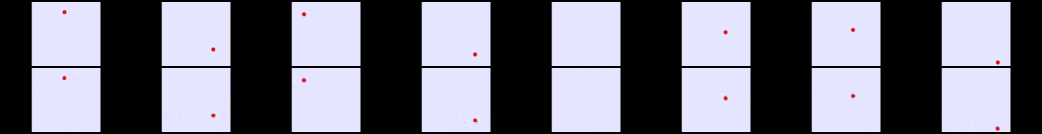

In [53]:
sample = torch.randn(bs, 3072)
compare_x = model.decoder(sample.cuda())

fixed_x, _ = next(iter(dataloader))
fixed_x = fixed_x[:8]



#fixed_x = dataset[randint(1, 100)][0].unsqueeze(0)




compare_x = compare(fixed_x.cuda())

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))